# Developing Brain Atlas through Deep Learning 

## A. Iqbal, R. Khan, T. Karayannis
# .
# .
# .

In [1]:
import os
import sys
import random
import math
import re
import time
import numpy as np
import cv2
import matplotlib
import matplotlib.pyplot as plt

from config import Config
import utils
import model as modellib
import visualize
from model import log

%matplotlib inline 

# Root directory of the project
ROOT_DIR = os.getcwd()

# Directory to save logs and trained model
MODEL_DIR = os.path.join(ROOT_DIR, "logs")

# Local path to trained weights file
COCO_MODEL_PATH = os.path.join(ROOT_DIR, "mask_rcnn_coco.h5")
# Download COCO trained weights from Releases if needed
if not os.path.exists(COCO_MODEL_PATH):
    utils.download_trained_weights(COCO_MODEL_PATH)

c:\users\asfandyar\appdata\local\programs\python\python35\lib\site-packages\h5py\__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [2]:
import glob #for selecting png files in training images folder
from natsort import natsorted, ns #for sorting filenames in a directory
import skimage
from skimage import io

## Configurations

In [3]:
class BrainConfig(Config):
    """Configuration for training on the brain dataset.
    Derives from the base Config class and overrides values specific
    to the brain dataset.
    """
    # Give the configuration a recognizable name
    NAME = "brain"

    # Train on 1 GPU and 8 images per GPU. We can put multiple images on each
    # GPU because the images are small. Batch size is 8 (GPUs * images/GPU).
    GPU_COUNT = 1
    IMAGES_PER_GPU = 1 #8 ; reduced to avoid running out of memory when image size increased

    # Number of classes (including background)
    NUM_CLASSES = 1 + 8  # background + 8 regions

    # Use small images for faster training. Set the limits of the small side
    # the large side, and that determines the image shape.
    IMAGE_MIN_DIM = 128*3 #128
    IMAGE_MAX_DIM = 128*3#128

    # Use smaller anchors because our image and objects are small
    RPN_ANCHOR_SCALES = (8, 16, 32, 64, 128)  # anchor side in pixels

    # Reduce training ROIs per image because the images are small and have
    # few objects. Aim to allow ROI sampling to pick 33% positive ROIs.
    TRAIN_ROIS_PER_IMAGE = 32

    # Use a small epoch since the data is simple
    STEPS_PER_EPOCH = 2000 #100 #steps_per_epoch: Total number of steps (batches of samples) before declaring one epoch finished and starting the next epoch. 
                          #steps_per_epoch = TotalTrainingSamples / TrainingBatchSize (default to use entire training data per epoch; can modify if required)
                          
    # use small validation steps since the epoch is small
    VALIDATION_STEPS = 100 #5 #validation_steps = TotalvalidationSamples / ValidationBatchSize
                         #Ideally, you use all your validation data at once. If you use only part of your validation data, you will get different metrics for each batch, 
                         #what may make you think that your model got worse or better when it actually didn't, you just measured different validation sets.
                         #That's why they suggest validation_steps = uniqueValidationData / batchSize. 
                         #Theoretically, you test your entire data every epoch, as you theoretically should also train your entire data every epoch.
                         #https://stackoverflow.com/questions/45943675/meaning-of-validation-steps-in-keras-sequential-fit-generator-parameter-list
    

    
    ###### Further changes (experimentation):
    
     # Maximum number of ground truth instances to use in one image
    MAX_GT_INSTANCES = 8 #100 #decreased to avoid duplicate instances of each brain region
    
    # Max number of final detections
    DETECTION_MAX_INSTANCES = 8 #100 # #decreased to avoid duplicate instances of each brain region

    # Minimum probability value to accept a detected instance
    # ROIs below this threshold are skipped
    DETECTION_MIN_CONFIDENCE =  0.9 #0.7

    # Non-maximum suppression threshold for detection
    DETECTION_NMS_THRESHOLD = 0.3 # if overlap ratio is greater than the overlap threshold (0.3), suppress object (https://www.pyimagesearch.com/2014/11/17/non-maximum-suppression-object-detection-python)

        
    
    
config = BrainConfig()
config.display()


Configurations:
BACKBONE_SHAPES                [[96 96]
 [48 48]
 [24 24]
 [12 12]
 [ 6  6]]
BACKBONE_STRIDES               [4, 8, 16, 32, 64]
BATCH_SIZE                     1
BBOX_STD_DEV                   [0.1 0.1 0.2 0.2]
DETECTION_MAX_INSTANCES        8
DETECTION_MIN_CONFIDENCE       0.9
DETECTION_NMS_THRESHOLD        0.3
GPU_COUNT                      1
IMAGES_PER_GPU                 1
IMAGE_MAX_DIM                  384
IMAGE_MIN_DIM                  384
IMAGE_PADDING                  True
IMAGE_SHAPE                    [384 384   3]
LEARNING_MOMENTUM              0.9
LEARNING_RATE                  0.001
MASK_POOL_SIZE                 14
MASK_SHAPE                     [28, 28]
MAX_GT_INSTANCES               8
MEAN_PIXEL                     [123.7 116.8 103.9]
MINI_MASK_SHAPE                (56, 56)
NAME                           brain
NUM_CLASSES                    9
POOL_SIZE                      7
POST_NMS_ROIS_INFERENCE        1000
POST_NMS_ROIS_TRAINING         2000
ROI_POSIT

## Notebook Preferences

In [4]:
def get_ax(rows=1, cols=1, size=8):
    """Return a Matplotlib Axes array to be used in
    all visualizations in the notebook. Provide a
    central point to control graph sizes.
    
    Change the default size attribute to control the size
    of rendered images
    """
    _, ax = plt.subplots(rows, cols, figsize=(size*cols, size*rows))
    return ax

## Dataset

Load training dataset

Extend the Dataset class and add a method to load the brain sections dataset, `load_brain()`, and override the following methods:

* load_image()
* load_mask()
* image_reference() # do not need to for now

### change directory here where the dataset is located
### .
### .

In [6]:
########### Create training dataset:

class BrainDataset_Train(utils.Dataset):
    """Generates the brain section dataset. The dataset consists of locally stored 
    brain section images, to which file access is required.
    """

    #see utils.py for default def load_image() function; modify according to your dataset
    
    def load_brain(self): 
        """
        for naming image files follow this convention: '*_(image_id).jpg'
        """
        
        os.chdir('D:\\Romesa_Work\\scene_parsing\\MaskRCNN_dataset\\dataset_6')
        
        self.add_class('brain','1','cortex')
        self.add_class('brain','2','hippocampus')
        self.add_class('brain','3','basal_ganglia')
        self.add_class('brain','4','thalamus')
        self.add_class('brain','5','prethalamus')
        self.add_class('brain','6','midbrain')
        self.add_class('brain','7','hindbrain')
        self.add_class('brain','8','telencephalic_vesicle')
        
        
        training_images_folder = 'mrcnn_train_dataset_images'
        os.chdir(training_images_folder)
        im_id = 0
        cwd = os.getcwd()
        img_list = glob.glob('*.jpg')
        img_list = natsorted(img_list, key=lambda y: y.lower())
        #print(img_list)
        for i in img_list:  #image_ids start at 0 (to keep correspondence with load_mask which begins at image_id=0)!
            img = skimage.io.imread(i) #grayscale = 0
            im_dims = np.shape(img)
            self.add_image("brain", image_id=im_id, path = cwd+'/'+glob.glob('*_'+str(im_id)+'.jpg')[0],height = im_dims[0], width = im_dims[1])#, depth = im_dims[2])
            im_id += 1
            #print(im_dims)
            
            
    
    def load_mask(self,image_id):
        """Load instance masks for the given image.
        Different datasets use different ways to store masks. This
        function converts the different mask format to one format
        in the form of a bitmap [height, width, instances].

        Returns:
        masks: A bool array of shape [height, width, instance count] with
            one mask per instance.
        class_ids: a 1D array of class IDs of the instance masks."""
        
        os.chdir('D:\\Romesa_Work\\scene_parsing\\MaskRCNN_dataset\\dataset_6')
        print(image_id)
        masks_folder = 'mrcnn_train_dataset_masks'
        os.chdir(masks_folder)
        subfolder = glob.glob('*_'+str(image_id))[0]#add 1 to image_id, to get to correct corresponding masks folder for a given image 
        print(subfolder)
        os.chdir(subfolder) 
        
        info = self.image_info[image_id] 
        print(info)
        mk_list = glob.glob('*.png')
        print(mk_list)
        count = len(mk_list)
        mk_id = 0
        mask = np.zeros([info['height'], info['width'], count], dtype=np.uint8)
        #print(np.shape(mask))
        class_ids = np.zeros(count)
        
        for m in mk_list:
            bin_mask = skimage.io.imread(m,as_grey=True) # grayscale=0
            mk_size = np.shape(bin_mask)
            mask[:, :, mk_id]= bin_mask
            
            # Map class names to class IDs.
            class_ids[mk_id] = m[-5] #fifth last position from mask_image name = class_id #need to update(range) if class_ids become two/three-digit numbers 
            mk_id += 1
        return mask, class_ids.astype(np.int32)
    
    
    
    
    
    
########### Create validation dataset:   

class BrainDataset_Val(utils.Dataset):
    """Generates the brain section dataset. The dataset consists of locally stored 
    brain section images, to which file access is required.
    """

    #see utils.py for default def load_image() function; modify according to your dataset
    
    def load_brain(self): 
        """
        for naming image files follow this convention: '*_(image_id+1).jpg'
        """
        
        os.chdir('D:\\Romesa_Work\\scene_parsing\\MaskRCNN_dataset\\dataset_6')
        
        self.add_class('brain','1','cortex')
        self.add_class('brain','2','hippocampus')
        self.add_class('brain','3','basal_ganglia')
        self.add_class('brain','4','thalamus')
        self.add_class('brain','5','prethalamus')
        self.add_class('brain','6','midbrain')
        self.add_class('brain','7','hindbrain')
        self.add_class('brain','8','telencephalic_vesicle')
        
        
        training_images_folder = 'mrcnn_val_blurred_images_sigma_4'
        os.chdir(training_images_folder)
        im_id = 0
        cwd = os.getcwd()
        img_list = glob.glob('*.jpg')
        img_list = natsorted(img_list, key=lambda y: y.lower())
        #print(img_list)
        for i in img_list:  #image_ids start at 0 (to keep correspondence with load_mask which begins at image_id=0)!
            img = skimage.io.imread(i) #grayscale = 0
            im_dims = np.shape(img)
            self.add_image("brain", image_id=im_id, path = cwd+'/'+glob.glob('*_'+str(im_id)+'.jpg')[0],height = im_dims[0], width = im_dims[1])#, depth = im_dims[2])
            im_id += 1
            #print(im_dims)
            
            
    
    def load_mask(self,image_id):
        """Load instance masks for the given image.
        Different datasets use different ways to store masks. This
        function converts the different mask format to one format
        in the form of a bitmap [height, width, instances].

        Returns:
        masks: A bool array of shape [height, width, instance count] with
            one mask per instance.
        class_ids: a 1D array of class IDs of the instance masks."""
        
        os.chdir('D:\\Romesa_Work\\scene_parsing\\MaskRCNN_dataset\\dataset_6')
        print(image_id)
        masks_folder = 'mrcnn_val_dataset_masks'
        os.chdir(masks_folder)
        subfolder = glob.glob('*_'+str(image_id))[0]#add 1 to image_id, to get to correct corresponding masks folder for a given image 
        print(subfolder)
        os.chdir(subfolder) 
        
        info = self.image_info[image_id] 
        print(info)
        mk_list = glob.glob('*.png')
        print(mk_list)
        count = len(mk_list)
        mk_id = 0
        mask = np.zeros([info['height'], info['width'], count], dtype=np.uint8)
        #print(np.shape(mask))
        class_ids = np.zeros(count)
        
        for m in mk_list:
            bin_mask = skimage.io.imread(m,as_grey=True) 
            mk_size = np.shape(bin_mask)
            mask[:, :, mk_id]= bin_mask
            
            # Map class names to class IDs.
            class_ids[mk_id] = m[-5] #fifth last position from mask_image name = class_id #need to update(range) if class_ids become two/three-digit numbers 
            mk_id += 1
        return mask, class_ids.astype(np.int32)





In [7]:
# Training dataset
dataset_train = BrainDataset_Train()
dataset_train.load_brain()
dataset_train.prepare() #does nothing for now 


# Validation dataset 
dataset_val = BrainDataset_Val()
dataset_val.load_brain()
dataset_val.prepare()#does nothing for now 

397
section_masks_397
{'width': 4691, 'id': 397, 'height': 2961, 'path': 'D:\\Romesa_Work\\scene_parsing\\MaskRCNN_dataset\\dataset_6\\mrcnn_train_dataset_images/section_img_397.jpg', 'source': 'brain'}
['section_masks_397_m_1.png', 'section_masks_397_m_4.png', 'section_masks_397_m_5.png', 'section_masks_397_m_6.png', 'section_masks_397_m_8.png']


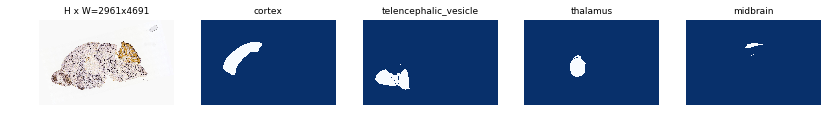

199
section_masks_199
{'width': 2695, 'id': 199, 'height': 2305, 'path': 'D:\\Romesa_Work\\scene_parsing\\MaskRCNN_dataset\\dataset_6\\mrcnn_train_dataset_images/section_img_199.jpg', 'source': 'brain'}
['section_masks_199_m_1.png', 'section_masks_199_m_2.png', 'section_masks_199_m_3.png', 'section_masks_199_m_7.png', 'section_masks_199_m_8.png']


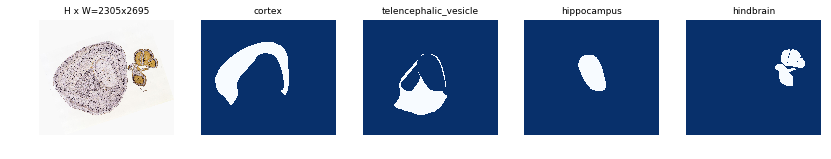

149
section_masks_149
{'width': 3474, 'id': 149, 'height': 2046, 'path': 'D:\\Romesa_Work\\scene_parsing\\MaskRCNN_dataset\\dataset_6\\mrcnn_train_dataset_images/section_img_149.jpg', 'source': 'brain'}
['section_masks_149_m_1.png', 'section_masks_149_m_2.png', 'section_masks_149_m_4.png', 'section_masks_149_m_5.png', 'section_masks_149_m_6.png', 'section_masks_149_m_7.png', 'section_masks_149_m_8.png']


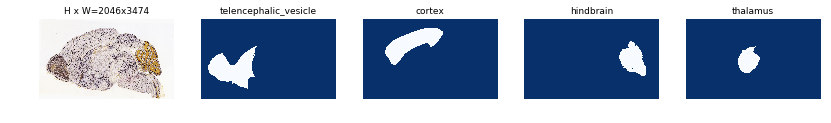

286
section_masks_286
{'width': 3791, 'id': 286, 'height': 2661, 'path': 'D:\\Romesa_Work\\scene_parsing\\MaskRCNN_dataset\\dataset_6\\mrcnn_train_dataset_images/section_img_286.jpg', 'source': 'brain'}
['section_masks_286_m_1.png', 'section_masks_286_m_2.png', 'section_masks_286_m_3.png', 'section_masks_286_m_4.png', 'section_masks_286_m_5.png', 'section_masks_286_m_6.png', 'section_masks_286_m_7.png', 'section_masks_286_m_8.png']


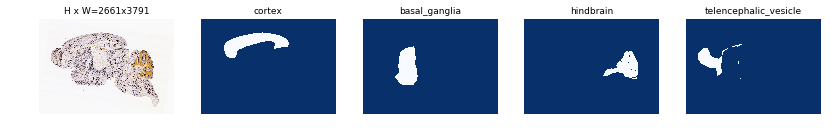

In [8]:
# Load and display random samples
image_ids = np.random.choice(dataset_train.image_ids, 4)
for image_id in image_ids:
    image = dataset_train.load_image(image_id)
    mask, class_ids = dataset_train.load_mask(image_id)
    visualize.display_top_masks(image, mask, class_ids, dataset_train.class_names)

## Create Model

In [9]:
# Create model in training mode
model = modellib.MaskRCNN(mode="training", config=config,
                          model_dir=MODEL_DIR)

In [10]:
# Which weights to start with?
init_with = "coco"  # imagenet, coco, or last

if init_with == "imagenet":
    model.load_weights(model.get_imagenet_weights(), by_name=True)
elif init_with == "coco":
    # Load weights trained on MS COCO, but skip layers that
    # are different due to the different number of classes
    # See README for instructions to download the COCO weights
    model.load_weights(COCO_MODEL_PATH, by_name=True,
                       exclude=["mrcnn_class_logits", "mrcnn_bbox_fc", 
                                "mrcnn_bbox", "mrcnn_mask"])
elif init_with == "last":
    # Load the last model you trained and continue training
    model.load_weights(model.find_last()[1], by_name=True)

## Training

Train in two stages:
1. Only the heads. Here we're freezing all the backbone layers and training only the randomly initialized layers (i.e. the ones that we didn't use pre-trained weights from MS COCO). To train only the head layers, pass `layers='heads'` to the `train()` function.

2. Fine-tune all layers. For this simple example it's not necessary, but we're including it to show the process. Simply pass `layers="all` to train all layers.

In [18]:
# Train the head branches
# Passing layers="heads" freezes all layers except the head
# layers. You can also pass a regular expression to select
# which layers to train by name pattern.
model.train(dataset_train, dataset_val, 
            learning_rate=config.LEARNING_RATE, 
            epochs=2, 
            layers='heads') #epochs = 1


Starting at epoch 0. LR=0.001

Checkpoint Path: C:\Users\Asfandyar\Documents\Romesa\Scene_Parsing\Code\MaskRCNN_master _AP_0.82_dataset_6\logs\brain20180322T2325\mask_rcnn_brain_{epoch:04d}.h5
Selecting layers to train
fpn_c5p5               (Conv2D)
fpn_c4p4               (Conv2D)
fpn_c3p3               (Conv2D)
fpn_c2p2               (Conv2D)
fpn_p5                 (Conv2D)
fpn_p2                 (Conv2D)
fpn_p3                 (Conv2D)
fpn_p4                 (Conv2D)
In model:  rpn_model
    rpn_conv_shared        (Conv2D)
    rpn_class_raw          (Conv2D)
    rpn_bbox_pred          (Conv2D)
mrcnn_mask_conv1       (TimeDistributed)
mrcnn_mask_bn1         (TimeDistributed)
mrcnn_mask_conv2       (TimeDistributed)
mrcnn_mask_bn2         (TimeDistributed)
mrcnn_class_conv1      (TimeDistributed)
mrcnn_class_bn1        (TimeDistributed)
mrcnn_mask_conv3       (TimeDistributed)
mrcnn_mask_bn3         (TimeDistributed)
mrcnn_class_conv2      (TimeDistributed)
mrcnn_class_bn2        (Ti

c:\users\asfandyar\appdata\local\programs\python\python35\lib\site-packages\tensorflow\python\ops\gradients_impl.py:98: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


Epoch 1/2
45
section_masks_45
{'path': 'D:\\Romesa_Work\\MaskRCNN_dataset\\dataset_6\\mrcnn_train_dataset_images/section_img_45.jpg', 'source': 'brain', 'height': 2274, 'width': 2611, 'id': 45}
['section_masks_45_m_1.png', 'section_masks_45_m_2.png', 'section_masks_45_m_3.png', 'section_masks_45_m_7.png', 'section_masks_45_m_8.png']
   1/2000 [..............................] - ETA: 2:07:02 - loss: 9.4210 - rpn_class_loss: 0.0321 - rpn_bbox_loss: 1.4579 - mrcnn_class_loss: 5.6017 - mrcnn_bbox_loss: 1.1279 - mrcnn_mask_loss: 1.2015112
section_masks_112
{'path': 'D:\\Romesa_Work\\MaskRCNN_dataset\\dataset_6\\mrcnn_train_dataset_images/section_img_112.jpg', 'source': 'brain', 'height': 2252, 'width': 3243, 'id': 112}
['section_masks_112_m_1.png', 'section_masks_112_m_2.png', 'section_masks_112_m_3.png', 'section_masks_112_m_4.png', 'section_masks_112_m_5.png', 'section_masks_112_m_6.png', 'section_masks_112_m_7.png', 'section_masks_112_m_8.png']


C:\Users\Asfandyar\AppData\Roaming\Python\Python35\site-packages\scipy\ndimage\interpolation.py:616: UserWarning: From scipy 0.13.0, the output shape of zoom() is calculated with round() instead of int() - for these inputs the size of the returned array has changed.
  "the returned array has changed.", UserWarning)


   2/2000 [..............................] - ETA: 1:20:55 - loss: 8.6897 - rpn_class_loss: 0.0618 - rpn_bbox_loss: 1.3280 - mrcnn_class_loss: 5.0746 - mrcnn_bbox_loss: 1.1689 - mrcnn_mask_loss: 1.056350
section_masks_50
{'path': 'D:\\Romesa_Work\\MaskRCNN_dataset\\dataset_6\\mrcnn_train_dataset_images/section_img_50.jpg', 'source': 'brain', 'height': 1900, 'width': 2316, 'id': 50}
['section_masks_50_m_1.png', 'section_masks_50_m_2.png', 'section_masks_50_m_3.png', 'section_masks_50_m_7.png', 'section_masks_50_m_8.png']
   3/2000 [..............................] - ETA: 1:02:33 - loss: 8.1985 - rpn_class_loss: 0.0583 - rpn_bbox_loss: 1.4847 - mrcnn_class_loss: 4.5378 - mrcnn_bbox_loss: 1.0690 - mrcnn_mask_loss: 1.048785
section_masks_85
{'path': 'D:\\Romesa_Work\\MaskRCNN_dataset\\dataset_6\\mrcnn_train_dataset_images/section_img_85.jpg', 'source': 'brain', 'height': 2415, 'width': 2831, 'id': 85}
['section_masks_85_m_1.png', 'section_masks_85_m_2.png', 'section_masks_85_m_3.png', 'secti

  17/2000 [..............................] - ETA: 38:43 - loss: 5.0285 - rpn_class_loss: 0.0755 - rpn_bbox_loss: 1.2899 - mrcnn_class_loss: 1.8095 - mrcnn_bbox_loss: 0.9851 - mrcnn_mask_loss: 0.868572
section_masks_72
{'path': 'D:\\Romesa_Work\\MaskRCNN_dataset\\dataset_6\\mrcnn_train_dataset_images/section_img_72.jpg', 'source': 'brain', 'height': 1993, 'width': 2602, 'id': 72}
['section_masks_72_m_1.png', 'section_masks_72_m_2.png', 'section_masks_72_m_3.png', 'section_masks_72_m_7.png', 'section_masks_72_m_8.png']
  18/2000 [..............................] - ETA: 38:01 - loss: 4.9217 - rpn_class_loss: 0.0742 - rpn_bbox_loss: 1.2664 - mrcnn_class_loss: 1.7436 - mrcnn_bbox_loss: 0.9752 - mrcnn_mask_loss: 0.8623320
section_masks_320
{'path': 'D:\\Romesa_Work\\MaskRCNN_dataset\\dataset_6\\mrcnn_train_dataset_images/section_img_320.jpg', 'source': 'brain', 'height': 3308, 'width': 4321, 'id': 320}
['section_masks_320_m_1.png', 'section_masks_320_m_2.png', 'section_masks_320_m_4.png', 'se

  32/2000 [..............................] - ETA: 36:31 - loss: 4.1657 - rpn_class_loss: 0.0624 - rpn_bbox_loss: 1.1039 - mrcnn_class_loss: 1.3134 - mrcnn_bbox_loss: 0.8831 - mrcnn_mask_loss: 0.802816
section_masks_16
{'path': 'D:\\Romesa_Work\\MaskRCNN_dataset\\dataset_6\\mrcnn_train_dataset_images/section_img_16.jpg', 'source': 'brain', 'height': 2105, 'width': 2346, 'id': 16}
['section_masks_16_m_1.png', 'section_masks_16_m_2.png', 'section_masks_16_m_7.png', 'section_masks_16_m_8.png']
  33/2000 [..............................] - ETA: 36:09 - loss: 4.1351 - rpn_class_loss: 0.0612 - rpn_bbox_loss: 1.1131 - mrcnn_class_loss: 1.2853 - mrcnn_bbox_loss: 0.8776 - mrcnn_mask_loss: 0.797926
section_masks_26
{'path': 'D:\\Romesa_Work\\MaskRCNN_dataset\\dataset_6\\mrcnn_train_dataset_images/section_img_26.jpg', 'source': 'brain', 'height': 2079, 'width': 2385, 'id': 26}
['section_masks_26_m_1.png', 'section_masks_26_m_2.png', 'section_masks_26_m_3.png', 'section_masks_26_m_7.png', 'section_m

  47/2000 [..............................] - ETA: 34:40 - loss: 3.6903 - rpn_class_loss: 0.0499 - rpn_bbox_loss: 1.0277 - mrcnn_class_loss: 1.0559 - mrcnn_bbox_loss: 0.7961 - mrcnn_mask_loss: 0.7607170
section_masks_170
{'path': 'D:\\Romesa_Work\\MaskRCNN_dataset\\dataset_6\\mrcnn_train_dataset_images/section_img_170.jpg', 'source': 'brain', 'height': 2120, 'width': 3368, 'id': 170}
['section_masks_170_m_1.png', 'section_masks_170_m_4.png', 'section_masks_170_m_5.png', 'section_masks_170_m_6.png', 'section_masks_170_m_8.png']
  48/2000 [..............................] - ETA: 34:33 - loss: 3.6537 - rpn_class_loss: 0.0489 - rpn_bbox_loss: 1.0160 - mrcnn_class_loss: 1.0421 - mrcnn_bbox_loss: 0.7902 - mrcnn_mask_loss: 0.756599
section_masks_99
{'path': 'D:\\Romesa_Work\\MaskRCNN_dataset\\dataset_6\\mrcnn_train_dataset_images/section_img_99.jpg', 'source': 'brain', 'height': 2689, 'width': 3017, 'id': 99}
['section_masks_99_m_1.png', 'section_masks_99_m_2.png', 'section_masks_99_m_3.png', '

  62/2000 [..............................] - ETA: 34:38 - loss: 3.3623 - rpn_class_loss: 0.0420 - rpn_bbox_loss: 0.9419 - mrcnn_class_loss: 0.9115 - mrcnn_bbox_loss: 0.7337 - mrcnn_mask_loss: 0.7333222
section_masks_222
{'path': 'D:\\Romesa_Work\\MaskRCNN_dataset\\dataset_6\\mrcnn_train_dataset_images/section_img_222.jpg', 'source': 'brain', 'height': 2502, 'width': 3100, 'id': 222}
['section_masks_222_m_1.png', 'section_masks_222_m_2.png', 'section_masks_222_m_5.png', 'section_masks_222_m_7.png', 'section_masks_222_m_8.png']
  63/2000 [..............................] - ETA: 34:34 - loss: 3.3810 - rpn_class_loss: 0.0423 - rpn_bbox_loss: 0.9734 - mrcnn_class_loss: 0.9028 - mrcnn_bbox_loss: 0.7323 - mrcnn_mask_loss: 0.7303118
section_masks_118
{'path': 'D:\\Romesa_Work\\MaskRCNN_dataset\\dataset_6\\mrcnn_train_dataset_images/section_img_118.jpg', 'source': 'brain', 'height': 2818, 'width': 3550, 'id': 118}
['section_masks_118_m_1.png', 'section_masks_118_m_2.png', 'section_masks_118_m_3.

  77/2000 [>.............................] - ETA: 33:38 - loss: 3.1325 - rpn_class_loss: 0.0372 - rpn_bbox_loss: 0.9056 - mrcnn_class_loss: 0.7956 - mrcnn_bbox_loss: 0.6873 - mrcnn_mask_loss: 0.706884
section_masks_84
{'path': 'D:\\Romesa_Work\\MaskRCNN_dataset\\dataset_6\\mrcnn_train_dataset_images/section_img_84.jpg', 'source': 'brain', 'height': 2488, 'width': 2883, 'id': 84}
['section_masks_84_m_1.png', 'section_masks_84_m_2.png', 'section_masks_84_m_3.png', 'section_masks_84_m_5.png', 'section_masks_84_m_7.png', 'section_masks_84_m_8.png']
  78/2000 [>.............................] - ETA: 33:33 - loss: 3.1138 - rpn_class_loss: 0.0369 - rpn_bbox_loss: 0.8986 - mrcnn_class_loss: 0.7888 - mrcnn_bbox_loss: 0.6841 - mrcnn_mask_loss: 0.705412
section_masks_12
{'path': 'D:\\Romesa_Work\\MaskRCNN_dataset\\dataset_6\\mrcnn_train_dataset_images/section_img_12.jpg', 'source': 'brain', 'height': 1858, 'width': 2147, 'id': 12}
['section_masks_12_m_1.png', 'section_masks_12_m_2.png', 'section_m

  92/2000 [>.............................] - ETA: 33:05 - loss: 2.9520 - rpn_class_loss: 0.0343 - rpn_bbox_loss: 0.8569 - mrcnn_class_loss: 0.7238 - mrcnn_bbox_loss: 0.6551 - mrcnn_mask_loss: 0.6819126
section_masks_126
{'path': 'D:\\Romesa_Work\\MaskRCNN_dataset\\dataset_6\\mrcnn_train_dataset_images/section_img_126.jpg', 'source': 'brain', 'height': 2656, 'width': 4086, 'id': 126}
['section_masks_126_m_1.png', 'section_masks_126_m_2.png', 'section_masks_126_m_3.png', 'section_masks_126_m_4.png', 'section_masks_126_m_5.png', 'section_masks_126_m_6.png', 'section_masks_126_m_7.png', 'section_masks_126_m_8.png']
  93/2000 [>.............................] - ETA: 33:06 - loss: 2.9469 - rpn_class_loss: 0.0341 - rpn_bbox_loss: 0.8544 - mrcnn_class_loss: 0.7221 - mrcnn_bbox_loss: 0.6551 - mrcnn_mask_loss: 0.6813157
section_masks_157
{'path': 'D:\\Romesa_Work\\MaskRCNN_dataset\\dataset_6\\mrcnn_train_dataset_images/section_img_157.jpg', 'source': 'brain', 'height': 2695, 'width': 3773, 'id': 

 120/2000 [>.............................] - ETA: 32:31 - loss: 2.7317 - rpn_class_loss: 0.0290 - rpn_bbox_loss: 0.7930 - mrcnn_class_loss: 0.6391 - mrcnn_bbox_loss: 0.6207 - mrcnn_mask_loss: 0.649911
section_masks_11
{'path': 'D:\\Romesa_Work\\MaskRCNN_dataset\\dataset_6\\mrcnn_train_dataset_images/section_img_11.jpg', 'source': 'brain', 'height': 1790, 'width': 2091, 'id': 11}
['section_masks_11_m_1.png', 'section_masks_11_m_2.png', 'section_masks_11_m_7.png', 'section_masks_11_m_8.png']
 121/2000 [>.............................] - ETA: 32:25 - loss: 2.7227 - rpn_class_loss: 0.0289 - rpn_bbox_loss: 0.7916 - mrcnn_class_loss: 0.6363 - mrcnn_bbox_loss: 0.6171 - mrcnn_mask_loss: 0.6487232
section_masks_232
{'path': 'D:\\Romesa_Work\\MaskRCNN_dataset\\dataset_6\\mrcnn_train_dataset_images/section_img_232.jpg', 'source': 'brain', 'height': 2012, 'width': 2821, 'id': 232}
['section_masks_232_m_1.png', 'section_masks_232_m_2.png', 'section_masks_232_m_5.png', 'section_masks_232_m_7.png', 's

 149/2000 [=>............................] - ETA: 31:39 - loss: 2.5764 - rpn_class_loss: 0.0259 - rpn_bbox_loss: 0.7668 - mrcnn_class_loss: 0.5776 - mrcnn_bbox_loss: 0.5819 - mrcnn_mask_loss: 0.6241384
section_masks_384
{'path': 'D:\\Romesa_Work\\MaskRCNN_dataset\\dataset_6\\mrcnn_train_dataset_images/section_img_384.jpg', 'source': 'brain', 'height': 2828, 'width': 4659, 'id': 384}
['section_masks_384_m_1.png', 'section_masks_384_m_4.png', 'section_masks_384_m_5.png', 'section_masks_384_m_6.png', 'section_masks_384_m_8.png']
 150/2000 [=>............................] - ETA: 31:40 - loss: 2.5730 - rpn_class_loss: 0.0260 - rpn_bbox_loss: 0.7667 - mrcnn_class_loss: 0.5765 - mrcnn_bbox_loss: 0.5809 - mrcnn_mask_loss: 0.622880
section_masks_80
{'path': 'D:\\Romesa_Work\\MaskRCNN_dataset\\dataset_6\\mrcnn_train_dataset_images/section_img_80.jpg', 'source': 'brain', 'height': 2749, 'width': 3055, 'id': 80}
['section_masks_80_m_1.png', 'section_masks_80_m_2.png', 'section_masks_80_m_3.png', '

 164/2000 [=>............................] - ETA: 31:32 - loss: 2.5084 - rpn_class_loss: 0.0247 - rpn_bbox_loss: 0.7571 - mrcnn_class_loss: 0.5509 - mrcnn_bbox_loss: 0.5653 - mrcnn_mask_loss: 0.6104383
section_masks_383
{'path': 'D:\\Romesa_Work\\MaskRCNN_dataset\\dataset_6\\mrcnn_train_dataset_images/section_img_383.jpg', 'source': 'brain', 'height': 2961, 'width': 4691, 'id': 383}
['section_masks_383_m_1.png', 'section_masks_383_m_4.png', 'section_masks_383_m_5.png', 'section_masks_383_m_6.png', 'section_masks_383_m_8.png']
 165/2000 [=>............................] - ETA: 31:33 - loss: 2.5023 - rpn_class_loss: 0.0246 - rpn_bbox_loss: 0.7559 - mrcnn_class_loss: 0.5482 - mrcnn_bbox_loss: 0.5641 - mrcnn_mask_loss: 0.6095328
section_masks_328
{'path': 'D:\\Romesa_Work\\MaskRCNN_dataset\\dataset_6\\mrcnn_train_dataset_images/section_img_328.jpg', 'source': 'brain', 'height': 2390, 'width': 3964, 'id': 328}
['section_masks_328_m_1.png', 'section_masks_328_m_2.png', 'section_masks_328_m_4.

 179/2000 [=>............................] - ETA: 31:17 - loss: 2.4369 - rpn_class_loss: 0.0234 - rpn_bbox_loss: 0.7395 - mrcnn_class_loss: 0.5276 - mrcnn_bbox_loss: 0.5484 - mrcnn_mask_loss: 0.5980100
section_masks_100
{'path': 'D:\\Romesa_Work\\MaskRCNN_dataset\\dataset_6\\mrcnn_train_dataset_images/section_img_100.jpg', 'source': 'brain', 'height': 2980, 'width': 3619, 'id': 100}
['section_masks_100_m_1.png', 'section_masks_100_m_2.png', 'section_masks_100_m_3.png', 'section_masks_100_m_4.png', 'section_masks_100_m_5.png', 'section_masks_100_m_6.png', 'section_masks_100_m_7.png', 'section_masks_100_m_8.png']
 180/2000 [=>............................] - ETA: 31:18 - loss: 2.4367 - rpn_class_loss: 0.0235 - rpn_bbox_loss: 0.7388 - mrcnn_class_loss: 0.5284 - mrcnn_bbox_loss: 0.5482 - mrcnn_mask_loss: 0.5978115
section_masks_115
{'path': 'D:\\Romesa_Work\\MaskRCNN_dataset\\dataset_6\\mrcnn_train_dataset_images/section_img_115.jpg', 'source': 'brain', 'height': 2549, 'width': 3415, 'id': 

 193/2000 [=>............................] - ETA: 31:08 - loss: 2.3904 - rpn_class_loss: 0.0232 - rpn_bbox_loss: 0.7259 - mrcnn_class_loss: 0.5127 - mrcnn_bbox_loss: 0.5391 - mrcnn_mask_loss: 0.5895239
section_masks_239
{'path': 'D:\\Romesa_Work\\MaskRCNN_dataset\\dataset_6\\mrcnn_train_dataset_images/section_img_239.jpg', 'source': 'brain', 'height': 2573, 'width': 3133, 'id': 239}
['section_masks_239_m_1.png', 'section_masks_239_m_2.png', 'section_masks_239_m_5.png', 'section_masks_239_m_7.png', 'section_masks_239_m_8.png']
 194/2000 [=>............................] - ETA: 31:06 - loss: 2.4100 - rpn_class_loss: 0.0234 - rpn_bbox_loss: 0.7500 - mrcnn_class_loss: 0.5108 - mrcnn_bbox_loss: 0.5375 - mrcnn_mask_loss: 0.5881268
section_masks_268
{'path': 'D:\\Romesa_Work\\MaskRCNN_dataset\\dataset_6\\mrcnn_train_dataset_images/section_img_268.jpg', 'source': 'brain', 'height': 2168, 'width': 3400, 'id': 268}
['section_masks_268_m_1.png', 'section_masks_268_m_2.png', 'section_masks_268_m_3.

 222/2000 [==>...........................] - ETA: 30:29 - loss: 2.3130 - rpn_class_loss: 0.0221 - rpn_bbox_loss: 0.7218 - mrcnn_class_loss: 0.4813 - mrcnn_bbox_loss: 0.5208 - mrcnn_mask_loss: 0.567125
section_masks_25
{'path': 'D:\\Romesa_Work\\MaskRCNN_dataset\\dataset_6\\mrcnn_train_dataset_images/section_img_25.jpg', 'source': 'brain', 'height': 2143, 'width': 2435, 'id': 25}
['section_masks_25_m_1.png', 'section_masks_25_m_2.png', 'section_masks_25_m_3.png', 'section_masks_25_m_7.png', 'section_masks_25_m_8.png']
 223/2000 [==>...........................] - ETA: 30:27 - loss: 2.3084 - rpn_class_loss: 0.0220 - rpn_bbox_loss: 0.7220 - mrcnn_class_loss: 0.4794 - mrcnn_bbox_loss: 0.5192 - mrcnn_mask_loss: 0.5659236
section_masks_236
{'path': 'D:\\Romesa_Work\\MaskRCNN_dataset\\dataset_6\\mrcnn_train_dataset_images/section_img_236.jpg', 'source': 'brain', 'height': 2350, 'width': 3021, 'id': 236}
['section_masks_236_m_1.png', 'section_masks_236_m_2.png', 'section_masks_236_m_5.png', 'se

 237/2000 [==>...........................] - ETA: 30:14 - loss: 2.2740 - rpn_class_loss: 0.0216 - rpn_bbox_loss: 0.7176 - mrcnn_class_loss: 0.4657 - mrcnn_bbox_loss: 0.5131 - mrcnn_mask_loss: 0.5560210
section_masks_210
{'path': 'D:\\Romesa_Work\\MaskRCNN_dataset\\dataset_6\\mrcnn_train_dataset_images/section_img_210.jpg', 'source': 'brain', 'height': 1784, 'width': 2532, 'id': 210}
['section_masks_210_m_1.png', 'section_masks_210_m_2.png', 'section_masks_210_m_3.png', 'section_masks_210_m_7.png', 'section_masks_210_m_8.png']
 238/2000 [==>...........................] - ETA: 30:11 - loss: 2.2692 - rpn_class_loss: 0.0215 - rpn_bbox_loss: 0.7163 - mrcnn_class_loss: 0.4643 - mrcnn_bbox_loss: 0.5121 - mrcnn_mask_loss: 0.555087
section_masks_87
{'path': 'D:\\Romesa_Work\\MaskRCNN_dataset\\dataset_6\\mrcnn_train_dataset_images/section_img_87.jpg', 'source': 'brain', 'height': 2261, 'width': 2716, 'id': 87}
['section_masks_87_m_1.png', 'section_masks_87_m_2.png', 'section_masks_87_m_3.png', '

 252/2000 [==>...........................] - ETA: 29:53 - loss: 2.2314 - rpn_class_loss: 0.0210 - rpn_bbox_loss: 0.7066 - mrcnn_class_loss: 0.4519 - mrcnn_bbox_loss: 0.5063 - mrcnn_mask_loss: 0.5456381
section_masks_381
{'path': 'D:\\Romesa_Work\\MaskRCNN_dataset\\dataset_6\\mrcnn_train_dataset_images/section_img_381.jpg', 'source': 'brain', 'height': 3214, 'width': 4740, 'id': 381}
['section_masks_381_m_1.png', 'section_masks_381_m_4.png', 'section_masks_381_m_5.png', 'section_masks_381_m_6.png', 'section_masks_381_m_8.png']
 253/2000 [==>...........................] - ETA: 29:53 - loss: 2.2304 - rpn_class_loss: 0.0210 - rpn_bbox_loss: 0.7060 - mrcnn_class_loss: 0.4518 - mrcnn_bbox_loss: 0.5065 - mrcnn_mask_loss: 0.5450275
section_masks_275
{'path': 'D:\\Romesa_Work\\MaskRCNN_dataset\\dataset_6\\mrcnn_train_dataset_images/section_img_275.jpg', 'source': 'brain', 'height': 2483, 'width': 3560, 'id': 275}
['section_masks_275_m_1.png', 'section_masks_275_m_2.png', 'section_masks_275_m_3.

 267/2000 [===>..........................] - ETA: 29:41 - loss: 2.1983 - rpn_class_loss: 0.0206 - rpn_bbox_loss: 0.6986 - mrcnn_class_loss: 0.4440 - mrcnn_bbox_loss: 0.4985 - mrcnn_mask_loss: 0.5366277
section_masks_277
{'path': 'D:\\Romesa_Work\\MaskRCNN_dataset\\dataset_6\\mrcnn_train_dataset_images/section_img_277.jpg', 'source': 'brain', 'height': 2678, 'width': 3645, 'id': 277}
['section_masks_277_m_1.png', 'section_masks_277_m_2.png', 'section_masks_277_m_3.png', 'section_masks_277_m_4.png', 'section_masks_277_m_5.png', 'section_masks_277_m_6.png', 'section_masks_277_m_7.png', 'section_masks_277_m_8.png']
 268/2000 [===>..........................] - ETA: 29:41 - loss: 2.1967 - rpn_class_loss: 0.0206 - rpn_bbox_loss: 0.6981 - mrcnn_class_loss: 0.4433 - mrcnn_bbox_loss: 0.4984 - mrcnn_mask_loss: 0.5362241
section_masks_241
{'path': 'D:\\Romesa_Work\\MaskRCNN_dataset\\dataset_6\\mrcnn_train_dataset_images/section_img_241.jpg', 'source': 'brain', 'height': 2644, 'width': 3299, 'id': 

 282/2000 [===>..........................] - ETA: 29:29 - loss: 2.1672 - rpn_class_loss: 0.0203 - rpn_bbox_loss: 0.6939 - mrcnn_class_loss: 0.4342 - mrcnn_bbox_loss: 0.4911 - mrcnn_mask_loss: 0.5277107
section_masks_107
{'path': 'D:\\Romesa_Work\\MaskRCNN_dataset\\dataset_6\\mrcnn_train_dataset_images/section_img_107.jpg', 'source': 'brain', 'height': 2354, 'width': 3305, 'id': 107}
['section_masks_107_m_1.png', 'section_masks_107_m_2.png', 'section_masks_107_m_3.png', 'section_masks_107_m_4.png', 'section_masks_107_m_5.png', 'section_masks_107_m_6.png', 'section_masks_107_m_7.png', 'section_masks_107_m_8.png']
 283/2000 [===>..........................] - ETA: 29:28 - loss: 2.1649 - rpn_class_loss: 0.0202 - rpn_bbox_loss: 0.6928 - mrcnn_class_loss: 0.4334 - mrcnn_bbox_loss: 0.4911 - mrcnn_mask_loss: 0.527469
section_masks_69
{'path': 'D:\\Romesa_Work\\MaskRCNN_dataset\\dataset_6\\mrcnn_train_dataset_images/section_img_69.jpg', 'source': 'brain', 'height': 1910, 'width': 2543, 'id': 69}

 296/2000 [===>..........................] - ETA: 29:27 - loss: 2.1404 - rpn_class_loss: 0.0200 - rpn_bbox_loss: 0.6867 - mrcnn_class_loss: 0.4265 - mrcnn_bbox_loss: 0.4858 - mrcnn_mask_loss: 0.5215324
section_masks_324
{'path': 'D:\\Romesa_Work\\MaskRCNN_dataset\\dataset_6\\mrcnn_train_dataset_images/section_img_324.jpg', 'source': 'brain', 'height': 2877, 'width': 4183, 'id': 324}
['section_masks_324_m_1.png', 'section_masks_324_m_2.png', 'section_masks_324_m_4.png', 'section_masks_324_m_5.png', 'section_masks_324_m_6.png', 'section_masks_324_m_7.png', 'section_masks_324_m_8.png']
 297/2000 [===>..........................] - ETA: 29:27 - loss: 2.1382 - rpn_class_loss: 0.0199 - rpn_bbox_loss: 0.6858 - mrcnn_class_loss: 0.4257 - mrcnn_bbox_loss: 0.4858 - mrcnn_mask_loss: 0.5210101
section_masks_101
{'path': 'D:\\Romesa_Work\\MaskRCNN_dataset\\dataset_6\\mrcnn_train_dataset_images/section_img_101.jpg', 'source': 'brain', 'height': 2901, 'width': 3587, 'id': 101}
['section_masks_101_m_1.

 325/2000 [===>..........................] - ETA: 29:09 - loss: 2.0828 - rpn_class_loss: 0.0191 - rpn_bbox_loss: 0.6747 - mrcnn_class_loss: 0.4076 - mrcnn_bbox_loss: 0.4733 - mrcnn_mask_loss: 0.5081354
section_masks_354
{'path': 'D:\\Romesa_Work\\MaskRCNN_dataset\\dataset_6\\mrcnn_train_dataset_images/section_img_354.jpg', 'source': 'brain', 'height': 2774, 'width': 4040, 'id': 354}
['section_masks_354_m_1.png', 'section_masks_354_m_2.png', 'section_masks_354_m_4.png', 'section_masks_354_m_5.png', 'section_masks_354_m_6.png', 'section_masks_354_m_7.png', 'section_masks_354_m_8.png']
 326/2000 [===>..........................] - ETA: 29:09 - loss: 2.0801 - rpn_class_loss: 0.0191 - rpn_bbox_loss: 0.6741 - mrcnn_class_loss: 0.4067 - mrcnn_bbox_loss: 0.4728 - mrcnn_mask_loss: 0.50756
section_masks_6
{'path': 'D:\\Romesa_Work\\MaskRCNN_dataset\\dataset_6\\mrcnn_train_dataset_images/section_img_6.jpg', 'source': 'brain', 'height': 1986, 'width': 2252, 'id': 6}
['section_masks_6_m_1.png', 'sec

 340/2000 [====>.........................] - ETA: 29:02 - loss: 2.0575 - rpn_class_loss: 0.0187 - rpn_bbox_loss: 0.6699 - mrcnn_class_loss: 0.3988 - mrcnn_bbox_loss: 0.4691 - mrcnn_mask_loss: 0.5009132
section_masks_132
{'path': 'D:\\Romesa_Work\\MaskRCNN_dataset\\dataset_6\\mrcnn_train_dataset_images/section_img_132.jpg', 'source': 'brain', 'height': 2406, 'width': 3965, 'id': 132}
['section_masks_132_m_1.png', 'section_masks_132_m_2.png', 'section_masks_132_m_3.png', 'section_masks_132_m_4.png', 'section_masks_132_m_5.png', 'section_masks_132_m_6.png', 'section_masks_132_m_7.png', 'section_masks_132_m_8.png']
 341/2000 [====>.........................] - ETA: 29:02 - loss: 2.0571 - rpn_class_loss: 0.0187 - rpn_bbox_loss: 0.6693 - mrcnn_class_loss: 0.3991 - mrcnn_bbox_loss: 0.4693 - mrcnn_mask_loss: 0.5007311
section_masks_311
{'path': 'D:\\Romesa_Work\\MaskRCNN_dataset\\dataset_6\\mrcnn_train_dataset_images/section_img_311.jpg', 'source': 'brain', 'height': 2309, 'width': 3786, 'id': 

 354/2000 [====>.........................] - ETA: 29:03 - loss: 2.0370 - rpn_class_loss: 0.0185 - rpn_bbox_loss: 0.6668 - mrcnn_class_loss: 0.3922 - mrcnn_bbox_loss: 0.4637 - mrcnn_mask_loss: 0.4958114
section_masks_114
{'path': 'D:\\Romesa_Work\\MaskRCNN_dataset\\dataset_6\\mrcnn_train_dataset_images/section_img_114.jpg', 'source': 'brain', 'height': 2453, 'width': 3362, 'id': 114}
['section_masks_114_m_1.png', 'section_masks_114_m_2.png', 'section_masks_114_m_3.png', 'section_masks_114_m_4.png', 'section_masks_114_m_5.png', 'section_masks_114_m_6.png', 'section_masks_114_m_7.png', 'section_masks_114_m_8.png']
 355/2000 [====>.........................] - ETA: 29:03 - loss: 2.0360 - rpn_class_loss: 0.0184 - rpn_bbox_loss: 0.6659 - mrcnn_class_loss: 0.3925 - mrcnn_bbox_loss: 0.4636 - mrcnn_mask_loss: 0.4955357
section_masks_357
{'path': 'D:\\Romesa_Work\\MaskRCNN_dataset\\dataset_6\\mrcnn_train_dataset_images/section_img_357.jpg', 'source': 'brain', 'height': 3114, 'width': 4198, 'id': 

 369/2000 [====>.........................] - ETA: 28:50 - loss: 2.0100 - rpn_class_loss: 0.0182 - rpn_bbox_loss: 0.6598 - mrcnn_class_loss: 0.3860 - mrcnn_bbox_loss: 0.4567 - mrcnn_mask_loss: 0.4893318
section_masks_318
{'path': 'D:\\Romesa_Work\\MaskRCNN_dataset\\dataset_6\\mrcnn_train_dataset_images/section_img_318.jpg', 'source': 'brain', 'height': 3119, 'width': 4169, 'id': 318}
['section_masks_318_m_1.png', 'section_masks_318_m_2.png', 'section_masks_318_m_3.png', 'section_masks_318_m_4.png', 'section_masks_318_m_5.png', 'section_masks_318_m_6.png', 'section_masks_318_m_7.png', 'section_masks_318_m_8.png']
 370/2000 [====>.........................] - ETA: 28:51 - loss: 2.0094 - rpn_class_loss: 0.0182 - rpn_bbox_loss: 0.6596 - mrcnn_class_loss: 0.3857 - mrcnn_bbox_loss: 0.4566 - mrcnn_mask_loss: 0.4893218
section_masks_218
{'path': 'D:\\Romesa_Work\\MaskRCNN_dataset\\dataset_6\\mrcnn_train_dataset_images/section_img_218.jpg', 'source': 'brain', 'height': 2413, 'width': 2926, 'id': 

 384/2000 [====>.........................] - ETA: 28:35 - loss: 1.9871 - rpn_class_loss: 0.0178 - rpn_bbox_loss: 0.6541 - mrcnn_class_loss: 0.3794 - mrcnn_bbox_loss: 0.4522 - mrcnn_mask_loss: 0.4836398
section_masks_398
{'path': 'D:\\Romesa_Work\\MaskRCNN_dataset\\dataset_6\\mrcnn_train_dataset_images/section_img_398.jpg', 'source': 'brain', 'height': 3089, 'width': 4718, 'id': 398}
['section_masks_398_m_1.png', 'section_masks_398_m_4.png', 'section_masks_398_m_5.png', 'section_masks_398_m_6.png', 'section_masks_398_m_8.png']
 385/2000 [====>.........................] - ETA: 28:35 - loss: 1.9881 - rpn_class_loss: 0.0178 - rpn_bbox_loss: 0.6546 - mrcnn_class_loss: 0.3799 - mrcnn_bbox_loss: 0.4521 - mrcnn_mask_loss: 0.4836295
section_masks_295
{'path': 'D:\\Romesa_Work\\MaskRCNN_dataset\\dataset_6\\mrcnn_train_dataset_images/section_img_295.jpg', 'source': 'brain', 'height': 2770, 'width': 3848, 'id': 295}
['section_masks_295_m_1.png', 'section_masks_295_m_2.png', 'section_masks_295_m_3.

 399/2000 [====>.........................] - ETA: 28:21 - loss: 1.9717 - rpn_class_loss: 0.0178 - rpn_bbox_loss: 0.6556 - mrcnn_class_loss: 0.3735 - mrcnn_bbox_loss: 0.4461 - mrcnn_mask_loss: 0.478762
section_masks_62
{'path': 'D:\\Romesa_Work\\MaskRCNN_dataset\\dataset_6\\mrcnn_train_dataset_images/section_img_62.jpg', 'source': 'brain', 'height': 2437, 'width': 2887, 'id': 62}
['section_masks_62_m_1.png', 'section_masks_62_m_2.png', 'section_masks_62_m_3.png', 'section_masks_62_m_7.png', 'section_masks_62_m_8.png']
 400/2000 [=====>........................] - ETA: 28:19 - loss: 1.9689 - rpn_class_loss: 0.0178 - rpn_bbox_loss: 0.6547 - mrcnn_class_loss: 0.3727 - mrcnn_bbox_loss: 0.4455 - mrcnn_mask_loss: 0.4782200
section_masks_200
{'path': 'D:\\Romesa_Work\\MaskRCNN_dataset\\dataset_6\\mrcnn_train_dataset_images/section_img_200.jpg', 'source': 'brain', 'height': 2543, 'width': 2990, 'id': 200}
['section_masks_200_m_1.png', 'section_masks_200_m_2.png', 'section_masks_200_m_3.png', 'se

 414/2000 [=====>........................] - ETA: 28:10 - loss: 1.9520 - rpn_class_loss: 0.0176 - rpn_bbox_loss: 0.6500 - mrcnn_class_loss: 0.3680 - mrcnn_bbox_loss: 0.4426 - mrcnn_mask_loss: 0.47378
section_masks_8
{'path': 'D:\\Romesa_Work\\MaskRCNN_dataset\\dataset_6\\mrcnn_train_dataset_images/section_img_8.jpg', 'source': 'brain', 'height': 1858, 'width': 2147, 'id': 8}
['section_masks_8_m_1.png', 'section_masks_8_m_2.png', 'section_masks_8_m_7.png', 'section_masks_8_m_8.png']
 415/2000 [=====>........................] - ETA: 28:08 - loss: 1.9497 - rpn_class_loss: 0.0176 - rpn_bbox_loss: 0.6490 - mrcnn_class_loss: 0.3672 - mrcnn_bbox_loss: 0.4425 - mrcnn_mask_loss: 0.4733174
section_masks_174
{'path': 'D:\\Romesa_Work\\MaskRCNN_dataset\\dataset_6\\mrcnn_train_dataset_images/section_img_174.jpg', 'source': 'brain', 'height': 2568, 'width': 3631, 'id': 174}
['section_masks_174_m_1.png', 'section_masks_174_m_4.png', 'section_masks_174_m_5.png', 'section_masks_174_m_6.png', 'section_m

 444/2000 [=====>........................] - ETA: 27:36 - loss: 1.9157 - rpn_class_loss: 0.0172 - rpn_bbox_loss: 0.6402 - mrcnn_class_loss: 0.3586 - mrcnn_bbox_loss: 0.4355 - mrcnn_mask_loss: 0.4642137
section_masks_137
{'path': 'D:\\Romesa_Work\\MaskRCNN_dataset\\dataset_6\\mrcnn_train_dataset_images/section_img_137.jpg', 'source': 'brain', 'height': 3006, 'width': 4229, 'id': 137}
['section_masks_137_m_1.png', 'section_masks_137_m_2.png', 'section_masks_137_m_3.png', 'section_masks_137_m_4.png', 'section_masks_137_m_5.png', 'section_masks_137_m_6.png', 'section_masks_137_m_7.png', 'section_masks_137_m_8.png']
 445/2000 [=====>........................] - ETA: 27:36 - loss: 1.9153 - rpn_class_loss: 0.0172 - rpn_bbox_loss: 0.6397 - mrcnn_class_loss: 0.3589 - mrcnn_bbox_loss: 0.4355 - mrcnn_mask_loss: 0.4640339
section_masks_339
{'path': 'D:\\Romesa_Work\\MaskRCNN_dataset\\dataset_6\\mrcnn_train_dataset_images/section_img_339.jpg', 'source': 'brain', 'height': 3206, 'width': 4295, 'id': 

 459/2000 [=====>........................] - ETA: 27:22 - loss: 1.9012 - rpn_class_loss: 0.0170 - rpn_bbox_loss: 0.6360 - mrcnn_class_loss: 0.3552 - mrcnn_bbox_loss: 0.4332 - mrcnn_mask_loss: 0.4598142
section_masks_142
{'path': 'D:\\Romesa_Work\\MaskRCNN_dataset\\dataset_6\\mrcnn_train_dataset_images/section_img_142.jpg', 'source': 'brain', 'height': 2793, 'width': 3808, 'id': 142}
['section_masks_142_m_1.png', 'section_masks_142_m_2.png', 'section_masks_142_m_4.png', 'section_masks_142_m_5.png', 'section_masks_142_m_6.png', 'section_masks_142_m_7.png', 'section_masks_142_m_8.png']
 460/2000 [=====>........................] - ETA: 27:21 - loss: 1.8996 - rpn_class_loss: 0.0170 - rpn_bbox_loss: 0.6357 - mrcnn_class_loss: 0.3548 - mrcnn_bbox_loss: 0.4327 - mrcnn_mask_loss: 0.4595112
section_masks_112
{'path': 'D:\\Romesa_Work\\MaskRCNN_dataset\\dataset_6\\mrcnn_train_dataset_images/section_img_112.jpg', 'source': 'brain', 'height': 2252, 'width': 3243, 'id': 112}
['section_masks_112_m_1.

 488/2000 [======>.......................] - ETA: 26:49 - loss: 1.8762 - rpn_class_loss: 0.0166 - rpn_bbox_loss: 0.6364 - mrcnn_class_loss: 0.3463 - mrcnn_bbox_loss: 0.4248 - mrcnn_mask_loss: 0.4521303
section_masks_303
{'path': 'D:\\Romesa_Work\\MaskRCNN_dataset\\dataset_6\\mrcnn_train_dataset_images/section_img_303.jpg', 'source': 'brain', 'height': 3014, 'width': 4129, 'id': 303}
['section_masks_303_m_1.png', 'section_masks_303_m_2.png', 'section_masks_303_m_3.png', 'section_masks_303_m_4.png', 'section_masks_303_m_5.png', 'section_masks_303_m_6.png', 'section_masks_303_m_7.png', 'section_masks_303_m_8.png']
 489/2000 [======>.......................] - ETA: 26:49 - loss: 1.8754 - rpn_class_loss: 0.0166 - rpn_bbox_loss: 0.6362 - mrcnn_class_loss: 0.3462 - mrcnn_bbox_loss: 0.4244 - mrcnn_mask_loss: 0.4520207
section_masks_207
{'path': 'D:\\Romesa_Work\\MaskRCNN_dataset\\dataset_6\\mrcnn_train_dataset_images/section_img_207.jpg', 'source': 'brain', 'height': 2039, 'width': 2705, 'id': 

 503/2000 [======>.......................] - ETA: 26:33 - loss: 1.8544 - rpn_class_loss: 0.0164 - rpn_bbox_loss: 0.6277 - mrcnn_class_loss: 0.3416 - mrcnn_bbox_loss: 0.4207 - mrcnn_mask_loss: 0.4481372
section_masks_372
{'path': 'D:\\Romesa_Work\\MaskRCNN_dataset\\dataset_6\\mrcnn_train_dataset_images/section_img_372.jpg', 'source': 'brain', 'height': 2609, 'width': 3915, 'id': 372}
['section_masks_372_m_1.png', 'section_masks_372_m_2.png', 'section_masks_372_m_4.png', 'section_masks_372_m_5.png', 'section_masks_372_m_6.png', 'section_masks_372_m_7.png', 'section_masks_372_m_8.png']
 504/2000 [======>.......................] - ETA: 26:32 - loss: 1.8526 - rpn_class_loss: 0.0164 - rpn_bbox_loss: 0.6270 - mrcnn_class_loss: 0.3409 - mrcnn_bbox_loss: 0.4205 - mrcnn_mask_loss: 0.4477389
section_masks_389
{'path': 'D:\\Romesa_Work\\MaskRCNN_dataset\\dataset_6\\mrcnn_train_dataset_images/section_img_389.jpg', 'source': 'brain', 'height': 2119, 'width': 4411, 'id': 389}
['section_masks_389_m_1.

 518/2000 [======>.......................] - ETA: 26:19 - loss: 1.8400 - rpn_class_loss: 0.0162 - rpn_bbox_loss: 0.6268 - mrcnn_class_loss: 0.3368 - mrcnn_bbox_loss: 0.4164 - mrcnn_mask_loss: 0.4438167
section_masks_167
{'path': 'D:\\Romesa_Work\\MaskRCNN_dataset\\dataset_6\\mrcnn_train_dataset_images/section_img_167.jpg', 'source': 'brain', 'height': 2461, 'width': 3572, 'id': 167}
['section_masks_167_m_1.png', 'section_masks_167_m_4.png', 'section_masks_167_m_5.png', 'section_masks_167_m_6.png', 'section_masks_167_m_8.png']
 519/2000 [======>.......................] - ETA: 26:18 - loss: 1.8386 - rpn_class_loss: 0.0162 - rpn_bbox_loss: 0.6263 - mrcnn_class_loss: 0.3363 - mrcnn_bbox_loss: 0.4163 - mrcnn_mask_loss: 0.443615
section_masks_15
{'path': 'D:\\Romesa_Work\\MaskRCNN_dataset\\dataset_6\\mrcnn_train_dataset_images/section_img_15.jpg', 'source': 'brain', 'height': 2047, 'width': 2300, 'id': 15}
['section_masks_15_m_1.png', 'section_masks_15_m_2.png', 'section_masks_15_m_7.png', '

 533/2000 [======>.......................] - ETA: 26:05 - loss: 1.8283 - rpn_class_loss: 0.0160 - rpn_bbox_loss: 0.6268 - mrcnn_class_loss: 0.3325 - mrcnn_bbox_loss: 0.4128 - mrcnn_mask_loss: 0.4402235
section_masks_235
{'path': 'D:\\Romesa_Work\\MaskRCNN_dataset\\dataset_6\\mrcnn_train_dataset_images/section_img_235.jpg', 'source': 'brain', 'height': 2269, 'width': 2977, 'id': 235}
['section_masks_235_m_1.png', 'section_masks_235_m_2.png', 'section_masks_235_m_5.png', 'section_masks_235_m_7.png', 'section_masks_235_m_8.png']
 534/2000 [=======>......................] - ETA: 26:03 - loss: 1.8265 - rpn_class_loss: 0.0160 - rpn_bbox_loss: 0.6266 - mrcnn_class_loss: 0.3319 - mrcnn_bbox_loss: 0.4122 - mrcnn_mask_loss: 0.4399390
section_masks_390
{'path': 'D:\\Romesa_Work\\MaskRCNN_dataset\\dataset_6\\mrcnn_train_dataset_images/section_img_390.jpg', 'source': 'brain', 'height': 1968, 'width': 4344, 'id': 390}
['section_masks_390_m_1.png', 'section_masks_390_m_4.png', 'section_masks_390_m_5.

 548/2000 [=======>......................] - ETA: 25:47 - loss: 1.8071 - rpn_class_loss: 0.0159 - rpn_bbox_loss: 0.6209 - mrcnn_class_loss: 0.3271 - mrcnn_bbox_loss: 0.4072 - mrcnn_mask_loss: 0.4360194
section_masks_194
{'path': 'D:\\Romesa_Work\\MaskRCNN_dataset\\dataset_6\\mrcnn_train_dataset_images/section_img_194.jpg', 'source': 'brain', 'height': 1982, 'width': 2500, 'id': 194}
['section_masks_194_m_1.png', 'section_masks_194_m_2.png', 'section_masks_194_m_3.png', 'section_masks_194_m_7.png', 'section_masks_194_m_8.png']
 549/2000 [=======>......................] - ETA: 25:45 - loss: 1.8052 - rpn_class_loss: 0.0159 - rpn_bbox_loss: 0.6200 - mrcnn_class_loss: 0.3268 - mrcnn_bbox_loss: 0.4068 - mrcnn_mask_loss: 0.4358141
section_masks_141
{'path': 'D:\\Romesa_Work\\MaskRCNN_dataset\\dataset_6\\mrcnn_train_dataset_images/section_img_141.jpg', 'source': 'brain', 'height': 2887, 'width': 3837, 'id': 141}
['section_masks_141_m_1.png', 'section_masks_141_m_2.png', 'section_masks_141_m_4.

 563/2000 [=======>......................] - ETA: 25:28 - loss: 1.7917 - rpn_class_loss: 0.0157 - rpn_bbox_loss: 0.6162 - mrcnn_class_loss: 0.3235 - mrcnn_bbox_loss: 0.4034 - mrcnn_mask_loss: 0.432818
section_masks_18
{'path': 'D:\\Romesa_Work\\MaskRCNN_dataset\\dataset_6\\mrcnn_train_dataset_images/section_img_18.jpg', 'source': 'brain', 'height': 2214, 'width': 2428, 'id': 18}
['section_masks_18_m_1.png', 'section_masks_18_m_2.png', 'section_masks_18_m_7.png', 'section_masks_18_m_8.png']
 564/2000 [=======>......................] - ETA: 25:26 - loss: 1.7914 - rpn_class_loss: 0.0157 - rpn_bbox_loss: 0.6169 - mrcnn_class_loss: 0.3233 - mrcnn_bbox_loss: 0.4030 - mrcnn_mask_loss: 0.4326392
section_masks_392
{'path': 'D:\\Romesa_Work\\MaskRCNN_dataset\\dataset_6\\mrcnn_train_dataset_images/section_img_392.jpg', 'source': 'brain', 'height': 2267, 'width': 4471, 'id': 392}
['section_masks_392_m_1.png', 'section_masks_392_m_4.png', 'section_masks_392_m_5.png', 'section_masks_392_m_6.png', 's

 593/2000 [=======>......................] - ETA: 24:50 - loss: 1.7746 - rpn_class_loss: 0.0156 - rpn_bbox_loss: 0.6164 - mrcnn_class_loss: 0.3180 - mrcnn_bbox_loss: 0.3974 - mrcnn_mask_loss: 0.4274113
section_masks_113
{'path': 'D:\\Romesa_Work\\MaskRCNN_dataset\\dataset_6\\mrcnn_train_dataset_images/section_img_113.jpg', 'source': 'brain', 'height': 2354, 'width': 3305, 'id': 113}
['section_masks_113_m_1.png', 'section_masks_113_m_2.png', 'section_masks_113_m_3.png', 'section_masks_113_m_4.png', 'section_masks_113_m_5.png', 'section_masks_113_m_6.png', 'section_masks_113_m_7.png', 'section_masks_113_m_8.png']
 594/2000 [=======>......................] - ETA: 24:49 - loss: 1.7738 - rpn_class_loss: 0.0155 - rpn_bbox_loss: 0.6160 - mrcnn_class_loss: 0.3179 - mrcnn_bbox_loss: 0.3971 - mrcnn_mask_loss: 0.4272133
section_masks_133
{'path': 'D:\\Romesa_Work\\MaskRCNN_dataset\\dataset_6\\mrcnn_train_dataset_images/section_img_133.jpg', 'source': 'brain', 'height': 2532, 'width': 4028, 'id': 

 621/2000 [========>.....................] - ETA: 24:19 - loss: 1.7498 - rpn_class_loss: 0.0153 - rpn_bbox_loss: 0.6103 - mrcnn_class_loss: 0.3113 - mrcnn_bbox_loss: 0.3907 - mrcnn_mask_loss: 0.422166
section_masks_66
{'path': 'D:\\Romesa_Work\\MaskRCNN_dataset\\dataset_6\\mrcnn_train_dataset_images/section_img_66.jpg', 'source': 'brain', 'height': 2152, 'width': 2710, 'id': 66}
['section_masks_66_m_1.png', 'section_masks_66_m_2.png', 'section_masks_66_m_3.png', 'section_masks_66_m_7.png', 'section_masks_66_m_8.png']
 622/2000 [========>.....................] - ETA: 24:18 - loss: 1.7482 - rpn_class_loss: 0.0153 - rpn_bbox_loss: 0.6097 - mrcnn_class_loss: 0.3110 - mrcnn_bbox_loss: 0.3903 - mrcnn_mask_loss: 0.4219201
section_masks_201
{'path': 'D:\\Romesa_Work\\MaskRCNN_dataset\\dataset_6\\mrcnn_train_dataset_images/section_img_201.jpg', 'source': 'brain', 'height': 2479, 'width': 2960, 'id': 201}
['section_masks_201_m_1.png', 'section_masks_201_m_2.png', 'section_masks_201_m_3.png', 'se

 636/2000 [========>.....................] - ETA: 24:01 - loss: 1.7342 - rpn_class_loss: 0.0152 - rpn_bbox_loss: 0.6056 - mrcnn_class_loss: 0.3075 - mrcnn_bbox_loss: 0.3869 - mrcnn_mask_loss: 0.4189304
section_masks_304
{'path': 'D:\\Romesa_Work\\MaskRCNN_dataset\\dataset_6\\mrcnn_train_dataset_images/section_img_304.jpg', 'source': 'brain', 'height': 2904, 'width': 4084, 'id': 304}
['section_masks_304_m_1.png', 'section_masks_304_m_2.png', 'section_masks_304_m_3.png', 'section_masks_304_m_4.png', 'section_masks_304_m_5.png', 'section_masks_304_m_6.png', 'section_masks_304_m_7.png', 'section_masks_304_m_8.png']
 637/2000 [========>.....................] - ETA: 24:01 - loss: 1.7333 - rpn_class_loss: 0.0152 - rpn_bbox_loss: 0.6054 - mrcnn_class_loss: 0.3072 - mrcnn_bbox_loss: 0.3868 - mrcnn_mask_loss: 0.418864
section_masks_64
{'path': 'D:\\Romesa_Work\\MaskRCNN_dataset\\dataset_6\\mrcnn_train_dataset_images/section_img_64.jpg', 'source': 'brain', 'height': 2300, 'width': 2805, 'id': 64}

 651/2000 [========>.....................] - ETA: 23:43 - loss: 1.7232 - rpn_class_loss: 0.0151 - rpn_bbox_loss: 0.6034 - mrcnn_class_loss: 0.3043 - mrcnn_bbox_loss: 0.3842 - mrcnn_mask_loss: 0.4163302
section_masks_302
{'path': 'D:\\Romesa_Work\\MaskRCNN_dataset\\dataset_6\\mrcnn_train_dataset_images/section_img_302.jpg', 'source': 'brain', 'height': 3119, 'width': 4169, 'id': 302}
['section_masks_302_m_1.png', 'section_masks_302_m_2.png', 'section_masks_302_m_3.png', 'section_masks_302_m_4.png', 'section_masks_302_m_5.png', 'section_masks_302_m_6.png', 'section_masks_302_m_7.png', 'section_masks_302_m_8.png']
 652/2000 [========>.....................] - ETA: 23:42 - loss: 1.7229 - rpn_class_loss: 0.0150 - rpn_bbox_loss: 0.6034 - mrcnn_class_loss: 0.3042 - mrcnn_bbox_loss: 0.3840 - mrcnn_mask_loss: 0.4162358
section_masks_358
{'path': 'D:\\Romesa_Work\\MaskRCNN_dataset\\dataset_6\\mrcnn_train_dataset_images/section_img_358.jpg', 'source': 'brain', 'height': 3221, 'width': 4241, 'id': 

 666/2000 [========>.....................] - ETA: 23:26 - loss: 1.7122 - rpn_class_loss: 0.0149 - rpn_bbox_loss: 0.5999 - mrcnn_class_loss: 0.3021 - mrcnn_bbox_loss: 0.3811 - mrcnn_mask_loss: 0.4142217
section_masks_217
{'path': 'D:\\Romesa_Work\\MaskRCNN_dataset\\dataset_6\\mrcnn_train_dataset_images/section_img_217.jpg', 'source': 'brain', 'height': 2344, 'width': 2889, 'id': 217}
['section_masks_217_m_1.png', 'section_masks_217_m_2.png', 'section_masks_217_m_3.png', 'section_masks_217_m_7.png', 'section_masks_217_m_8.png']
 667/2000 [=========>....................] - ETA: 23:25 - loss: 1.7108 - rpn_class_loss: 0.0149 - rpn_bbox_loss: 0.5995 - mrcnn_class_loss: 0.3017 - mrcnn_bbox_loss: 0.3807 - mrcnn_mask_loss: 0.4140272
section_masks_272
{'path': 'D:\\Romesa_Work\\MaskRCNN_dataset\\dataset_6\\mrcnn_train_dataset_images/section_img_272.jpg', 'source': 'brain', 'height': 2168, 'width': 3400, 'id': 272}
['section_masks_272_m_1.png', 'section_masks_272_m_2.png', 'section_masks_272_m_3.

 681/2000 [=========>....................] - ETA: 23:08 - loss: 1.6967 - rpn_class_loss: 0.0147 - rpn_bbox_loss: 0.5962 - mrcnn_class_loss: 0.2977 - mrcnn_bbox_loss: 0.3771 - mrcnn_mask_loss: 0.41107
section_masks_7
{'path': 'D:\\Romesa_Work\\MaskRCNN_dataset\\dataset_6\\mrcnn_train_dataset_images/section_img_7.jpg', 'source': 'brain', 'height': 1923, 'width': 2201, 'id': 7}
['section_masks_7_m_1.png', 'section_masks_7_m_2.png', 'section_masks_7_m_7.png', 'section_masks_7_m_8.png']
 682/2000 [=========>....................] - ETA: 23:06 - loss: 1.6959 - rpn_class_loss: 0.0147 - rpn_bbox_loss: 0.5961 - mrcnn_class_loss: 0.2976 - mrcnn_bbox_loss: 0.3767 - mrcnn_mask_loss: 0.4108360
section_masks_360
{'path': 'D:\\Romesa_Work\\MaskRCNN_dataset\\dataset_6\\mrcnn_train_dataset_images/section_img_360.jpg', 'source': 'brain', 'height': 3496, 'width': 4338, 'id': 360}
['section_masks_360_m_1.png', 'section_masks_360_m_2.png', 'section_masks_360_m_4.png', 'section_masks_360_m_5.png', 'section_m

 695/2000 [=========>....................] - ETA: 22:54 - loss: 1.6872 - rpn_class_loss: 0.0146 - rpn_bbox_loss: 0.5931 - mrcnn_class_loss: 0.2955 - mrcnn_bbox_loss: 0.3750 - mrcnn_mask_loss: 0.4090335
section_masks_335
{'path': 'D:\\Romesa_Work\\MaskRCNN_dataset\\dataset_6\\mrcnn_train_dataset_images/section_img_335.jpg', 'source': 'brain', 'height': 2760, 'width': 4136, 'id': 335}
['section_masks_335_m_1.png', 'section_masks_335_m_2.png', 'section_masks_335_m_4.png', 'section_masks_335_m_5.png', 'section_masks_335_m_6.png', 'section_masks_335_m_7.png', 'section_masks_335_m_8.png']
 696/2000 [=========>....................] - ETA: 22:54 - loss: 1.6862 - rpn_class_loss: 0.0146 - rpn_bbox_loss: 0.5928 - mrcnn_class_loss: 0.2951 - mrcnn_bbox_loss: 0.3748 - mrcnn_mask_loss: 0.4088102
section_masks_102
{'path': 'D:\\Romesa_Work\\MaskRCNN_dataset\\dataset_6\\mrcnn_train_dataset_images/section_img_102.jpg', 'source': 'brain', 'height': 2818, 'width': 3550, 'id': 102}
['section_masks_102_m_1.

 724/2000 [=========>....................] - ETA: 22:22 - loss: 1.6641 - rpn_class_loss: 0.0144 - rpn_bbox_loss: 0.5869 - mrcnn_class_loss: 0.2891 - mrcnn_bbox_loss: 0.3696 - mrcnn_mask_loss: 0.4041322
section_masks_322
{'path': 'D:\\Romesa_Work\\MaskRCNN_dataset\\dataset_6\\mrcnn_train_dataset_images/section_img_322.jpg', 'source': 'brain', 'height': 3100, 'width': 4263, 'id': 322}
['section_masks_322_m_1.png', 'section_masks_322_m_2.png', 'section_masks_322_m_4.png', 'section_masks_322_m_5.png', 'section_masks_322_m_6.png', 'section_masks_322_m_7.png', 'section_masks_322_m_8.png']
 725/2000 [=========>....................] - ETA: 22:21 - loss: 1.6639 - rpn_class_loss: 0.0144 - rpn_bbox_loss: 0.5870 - mrcnn_class_loss: 0.2890 - mrcnn_bbox_loss: 0.3694 - mrcnn_mask_loss: 0.4041209
section_masks_209
{'path': 'D:\\Romesa_Work\\MaskRCNN_dataset\\dataset_6\\mrcnn_train_dataset_images/section_img_209.jpg', 'source': 'brain', 'height': 1872, 'width': 2593, 'id': 209}
['section_masks_209_m_1.

 739/2000 [==========>...................] - ETA: 22:05 - loss: 1.6534 - rpn_class_loss: 0.0143 - rpn_bbox_loss: 0.5846 - mrcnn_class_loss: 0.2862 - mrcnn_bbox_loss: 0.3666 - mrcnn_mask_loss: 0.401873
section_masks_73
{'path': 'D:\\Romesa_Work\\MaskRCNN_dataset\\dataset_6\\mrcnn_train_dataset_images/section_img_73.jpg', 'source': 'brain', 'height': 2074, 'width': 2657, 'id': 73}
['section_masks_73_m_1.png', 'section_masks_73_m_2.png', 'section_masks_73_m_3.png', 'section_masks_73_m_7.png', 'section_masks_73_m_8.png']
 740/2000 [==========>...................] - ETA: 22:04 - loss: 1.6528 - rpn_class_loss: 0.0142 - rpn_bbox_loss: 0.5845 - mrcnn_class_loss: 0.2862 - mrcnn_bbox_loss: 0.3663 - mrcnn_mask_loss: 0.4015283
section_masks_283
{'path': 'D:\\Romesa_Work\\MaskRCNN_dataset\\dataset_6\\mrcnn_train_dataset_images/section_img_283.jpg', 'source': 'brain', 'height': 2979, 'width': 3946, 'id': 283}
['section_masks_283_m_1.png', 'section_masks_283_m_2.png', 'section_masks_283_m_3.png', 'se

 769/2000 [==========>...................] - ETA: 21:32 - loss: 1.6360 - rpn_class_loss: 0.0140 - rpn_bbox_loss: 0.5793 - mrcnn_class_loss: 0.2825 - mrcnn_bbox_loss: 0.3623 - mrcnn_mask_loss: 0.3979378
section_masks_378
{'path': 'D:\\Romesa_Work\\MaskRCNN_dataset\\dataset_6\\mrcnn_train_dataset_images/section_img_378.jpg', 'source': 'brain', 'height': 3298, 'width': 4263, 'id': 378}
['section_masks_378_m_1.png', 'section_masks_378_m_2.png', 'section_masks_378_m_4.png', 'section_masks_378_m_5.png', 'section_masks_378_m_6.png', 'section_masks_378_m_7.png', 'section_masks_378_m_8.png']
 770/2000 [==========>...................] - ETA: 21:31 - loss: 1.6353 - rpn_class_loss: 0.0140 - rpn_bbox_loss: 0.5790 - mrcnn_class_loss: 0.2824 - mrcnn_bbox_loss: 0.3621 - mrcnn_mask_loss: 0.3978332
section_masks_332
{'path': 'D:\\Romesa_Work\\MaskRCNN_dataset\\dataset_6\\mrcnn_train_dataset_images/section_img_332.jpg', 'source': 'brain', 'height': 2390, 'width': 3964, 'id': 332}
['section_masks_332_m_1.

 798/2000 [==========>...................] - ETA: 21:03 - loss: 1.6192 - rpn_class_loss: 0.0139 - rpn_bbox_loss: 0.5760 - mrcnn_class_loss: 0.2775 - mrcnn_bbox_loss: 0.3580 - mrcnn_mask_loss: 0.393845
section_masks_45
{'path': 'D:\\Romesa_Work\\MaskRCNN_dataset\\dataset_6\\mrcnn_train_dataset_images/section_img_45.jpg', 'source': 'brain', 'height': 2274, 'width': 2611, 'id': 45}
['section_masks_45_m_1.png', 'section_masks_45_m_2.png', 'section_masks_45_m_3.png', 'section_masks_45_m_7.png', 'section_masks_45_m_8.png']
 799/2000 [==========>...................] - ETA: 21:02 - loss: 1.6182 - rpn_class_loss: 0.0139 - rpn_bbox_loss: 0.5756 - mrcnn_class_loss: 0.2772 - mrcnn_bbox_loss: 0.3578 - mrcnn_mask_loss: 0.3936240
section_masks_240
{'path': 'D:\\Romesa_Work\\MaskRCNN_dataset\\dataset_6\\mrcnn_train_dataset_images/section_img_240.jpg', 'source': 'brain', 'height': 2718, 'width': 3327, 'id': 240}
['section_masks_240_m_1.png', 'section_masks_240_m_2.png', 'section_masks_240_m_3.png', 'se

 813/2000 [===========>..................] - ETA: 20:47 - loss: 1.6120 - rpn_class_loss: 0.0139 - rpn_bbox_loss: 0.5734 - mrcnn_class_loss: 0.2763 - mrcnn_bbox_loss: 0.3566 - mrcnn_mask_loss: 0.3919359
section_masks_359
{'path': 'D:\\Romesa_Work\\MaskRCNN_dataset\\dataset_6\\mrcnn_train_dataset_images/section_img_359.jpg', 'source': 'brain', 'height': 3323, 'width': 4278, 'id': 359}
['section_masks_359_m_1.png', 'section_masks_359_m_2.png', 'section_masks_359_m_4.png', 'section_masks_359_m_5.png', 'section_masks_359_m_6.png', 'section_masks_359_m_7.png', 'section_masks_359_m_8.png']
 814/2000 [===========>..................] - ETA: 20:46 - loss: 1.6115 - rpn_class_loss: 0.0139 - rpn_bbox_loss: 0.5732 - mrcnn_class_loss: 0.2763 - mrcnn_bbox_loss: 0.3564 - mrcnn_mask_loss: 0.391829
section_masks_29
{'path': 'D:\\Romesa_Work\\MaskRCNN_dataset\\dataset_6\\mrcnn_train_dataset_images/section_img_29.jpg', 'source': 'brain', 'height': 1871, 'width': 2218, 'id': 29}
['section_masks_29_m_1.png',

 842/2000 [===========>..................] - ETA: 20:16 - loss: 1.5966 - rpn_class_loss: 0.0137 - rpn_bbox_loss: 0.5676 - mrcnn_class_loss: 0.2731 - mrcnn_bbox_loss: 0.3536 - mrcnn_mask_loss: 0.3886168
section_masks_168
{'path': 'D:\\Romesa_Work\\MaskRCNN_dataset\\dataset_6\\mrcnn_train_dataset_images/section_img_168.jpg', 'source': 'brain', 'height': 2350, 'width': 3508, 'id': 168}
['section_masks_168_m_1.png', 'section_masks_168_m_4.png', 'section_masks_168_m_5.png', 'section_masks_168_m_6.png', 'section_masks_168_m_8.png']
 843/2000 [===========>..................] - ETA: 20:15 - loss: 1.5960 - rpn_class_loss: 0.0137 - rpn_bbox_loss: 0.5672 - mrcnn_class_loss: 0.2730 - mrcnn_bbox_loss: 0.3536 - mrcnn_mask_loss: 0.388466
section_masks_66
{'path': 'D:\\Romesa_Work\\MaskRCNN_dataset\\dataset_6\\mrcnn_train_dataset_images/section_img_66.jpg', 'source': 'brain', 'height': 2152, 'width': 2710, 'id': 66}
['section_masks_66_m_1.png', 'section_masks_66_m_2.png', 'section_masks_66_m_3.png', '

 872/2000 [============>.................] - ETA: 19:41 - loss: 1.5779 - rpn_class_loss: 0.0136 - rpn_bbox_loss: 0.5613 - mrcnn_class_loss: 0.2697 - mrcnn_bbox_loss: 0.3490 - mrcnn_mask_loss: 0.3842101
section_masks_101
{'path': 'D:\\Romesa_Work\\MaskRCNN_dataset\\dataset_6\\mrcnn_train_dataset_images/section_img_101.jpg', 'source': 'brain', 'height': 2901, 'width': 3587, 'id': 101}
['section_masks_101_m_1.png', 'section_masks_101_m_2.png', 'section_masks_101_m_3.png', 'section_masks_101_m_4.png', 'section_masks_101_m_5.png', 'section_masks_101_m_6.png', 'section_masks_101_m_7.png', 'section_masks_101_m_8.png']
 873/2000 [============>.................] - ETA: 19:40 - loss: 1.5772 - rpn_class_loss: 0.0136 - rpn_bbox_loss: 0.5611 - mrcnn_class_loss: 0.2695 - mrcnn_bbox_loss: 0.3489 - mrcnn_mask_loss: 0.3841345
section_masks_345
{'path': 'D:\\Romesa_Work\\MaskRCNN_dataset\\dataset_6\\mrcnn_train_dataset_images/section_img_345.jpg', 'source': 'brain', 'height': 2891, 'width': 4098, 'id': 

 887/2000 [============>.................] - ETA: 19:25 - loss: 1.5679 - rpn_class_loss: 0.0135 - rpn_bbox_loss: 0.5584 - mrcnn_class_loss: 0.2674 - mrcnn_bbox_loss: 0.3463 - mrcnn_mask_loss: 0.3822384
section_masks_384
{'path': 'D:\\Romesa_Work\\MaskRCNN_dataset\\dataset_6\\mrcnn_train_dataset_images/section_img_384.jpg', 'source': 'brain', 'height': 2828, 'width': 4659, 'id': 384}
['section_masks_384_m_1.png', 'section_masks_384_m_4.png', 'section_masks_384_m_5.png', 'section_masks_384_m_6.png', 'section_masks_384_m_8.png']
 888/2000 [============>.................] - ETA: 19:24 - loss: 1.5673 - rpn_class_loss: 0.0135 - rpn_bbox_loss: 0.5582 - mrcnn_class_loss: 0.2673 - mrcnn_bbox_loss: 0.3462 - mrcnn_mask_loss: 0.3821102
section_masks_102
{'path': 'D:\\Romesa_Work\\MaskRCNN_dataset\\dataset_6\\mrcnn_train_dataset_images/section_img_102.jpg', 'source': 'brain', 'height': 2818, 'width': 3550, 'id': 102}
['section_masks_102_m_1.png', 'section_masks_102_m_2.png', 'section_masks_102_m_3.

 916/2000 [============>.................] - ETA: 18:55 - loss: 1.5539 - rpn_class_loss: 0.0134 - rpn_bbox_loss: 0.5546 - mrcnn_class_loss: 0.2636 - mrcnn_bbox_loss: 0.3434 - mrcnn_mask_loss: 0.3788296
section_masks_296
{'path': 'D:\\Romesa_Work\\MaskRCNN_dataset\\dataset_6\\mrcnn_train_dataset_images/section_img_296.jpg', 'source': 'brain', 'height': 2876, 'width': 3899, 'id': 296}
['section_masks_296_m_1.png', 'section_masks_296_m_2.png', 'section_masks_296_m_3.png', 'section_masks_296_m_4.png', 'section_masks_296_m_5.png', 'section_masks_296_m_6.png', 'section_masks_296_m_7.png', 'section_masks_296_m_8.png']
 917/2000 [============>.................] - ETA: 18:55 - loss: 1.5535 - rpn_class_loss: 0.0134 - rpn_bbox_loss: 0.5545 - mrcnn_class_loss: 0.2636 - mrcnn_bbox_loss: 0.3434 - mrcnn_mask_loss: 0.3786113
section_masks_113
{'path': 'D:\\Romesa_Work\\MaskRCNN_dataset\\dataset_6\\mrcnn_train_dataset_images/section_img_113.jpg', 'source': 'brain', 'height': 2354, 'width': 3305, 'id': 

 945/2000 [=============>................] - ETA: 18:26 - loss: 1.5384 - rpn_class_loss: 0.0133 - rpn_bbox_loss: 0.5496 - mrcnn_class_loss: 0.2600 - mrcnn_bbox_loss: 0.3398 - mrcnn_mask_loss: 0.3757356
section_masks_356
{'path': 'D:\\Romesa_Work\\MaskRCNN_dataset\\dataset_6\\mrcnn_train_dataset_images/section_img_356.jpg', 'source': 'brain', 'height': 3004, 'width': 4151, 'id': 356}
['section_masks_356_m_1.png', 'section_masks_356_m_2.png', 'section_masks_356_m_4.png', 'section_masks_356_m_5.png', 'section_masks_356_m_6.png', 'section_masks_356_m_7.png', 'section_masks_356_m_8.png']
 946/2000 [=============>................] - ETA: 18:25 - loss: 1.5377 - rpn_class_loss: 0.0133 - rpn_bbox_loss: 0.5494 - mrcnn_class_loss: 0.2598 - mrcnn_bbox_loss: 0.3396 - mrcnn_mask_loss: 0.3756338
section_masks_338
{'path': 'D:\\Romesa_Work\\MaskRCNN_dataset\\dataset_6\\mrcnn_train_dataset_images/section_img_338.jpg', 'source': 'brain', 'height': 3100, 'width': 4263, 'id': 338}
['section_masks_338_m_1.

 960/2000 [=============>................] - ETA: 18:10 - loss: 1.5314 - rpn_class_loss: 0.0133 - rpn_bbox_loss: 0.5477 - mrcnn_class_loss: 0.2582 - mrcnn_bbox_loss: 0.3380 - mrcnn_mask_loss: 0.3743392
section_masks_392
{'path': 'D:\\Romesa_Work\\MaskRCNN_dataset\\dataset_6\\mrcnn_train_dataset_images/section_img_392.jpg', 'source': 'brain', 'height': 2267, 'width': 4471, 'id': 392}
['section_masks_392_m_1.png', 'section_masks_392_m_4.png', 'section_masks_392_m_5.png', 'section_masks_392_m_6.png', 'section_masks_392_m_8.png']
 961/2000 [=============>................] - ETA: 18:09 - loss: 1.5308 - rpn_class_loss: 0.0133 - rpn_bbox_loss: 0.5474 - mrcnn_class_loss: 0.2581 - mrcnn_bbox_loss: 0.3378 - mrcnn_mask_loss: 0.37429
section_masks_9
{'path': 'D:\\Romesa_Work\\MaskRCNN_dataset\\dataset_6\\mrcnn_train_dataset_images/section_img_9.jpg', 'source': 'brain', 'height': 1790, 'width': 2091, 'id': 9}
['section_masks_9_m_1.png', 'section_masks_9_m_2.png', 'section_masks_9_m_7.png', 'section

 975/2000 [=============>................] - ETA: 17:53 - loss: 1.5241 - rpn_class_loss: 0.0132 - rpn_bbox_loss: 0.5461 - mrcnn_class_loss: 0.2561 - mrcnn_bbox_loss: 0.3362 - mrcnn_mask_loss: 0.3725148
section_masks_148
{'path': 'D:\\Romesa_Work\\MaskRCNN_dataset\\dataset_6\\mrcnn_train_dataset_images/section_img_148.jpg', 'source': 'brain', 'height': 2161, 'width': 3535, 'id': 148}
['section_masks_148_m_1.png', 'section_masks_148_m_2.png', 'section_masks_148_m_4.png', 'section_masks_148_m_5.png', 'section_masks_148_m_6.png', 'section_masks_148_m_7.png', 'section_masks_148_m_8.png']
 976/2000 [=============>................] - ETA: 17:52 - loss: 1.5237 - rpn_class_loss: 0.0132 - rpn_bbox_loss: 0.5462 - mrcnn_class_loss: 0.2559 - mrcnn_bbox_loss: 0.3361 - mrcnn_mask_loss: 0.3724381
section_masks_381
{'path': 'D:\\Romesa_Work\\MaskRCNN_dataset\\dataset_6\\mrcnn_train_dataset_images/section_img_381.jpg', 'source': 'brain', 'height': 3214, 'width': 4740, 'id': 381}
['section_masks_381_m_1.

 990/2000 [=============>................] - ETA: 17:38 - loss: 1.5169 - rpn_class_loss: 0.0132 - rpn_bbox_loss: 0.5441 - mrcnn_class_loss: 0.2546 - mrcnn_bbox_loss: 0.3343 - mrcnn_mask_loss: 0.3708380
section_masks_380
{'path': 'D:\\Romesa_Work\\MaskRCNN_dataset\\dataset_6\\mrcnn_train_dataset_images/section_img_380.jpg', 'source': 'brain', 'height': 3335, 'width': 4755, 'id': 380}
['section_masks_380_m_1.png', 'section_masks_380_m_4.png', 'section_masks_380_m_5.png', 'section_masks_380_m_6.png', 'section_masks_380_m_8.png']
 991/2000 [=============>................] - ETA: 17:38 - loss: 1.5167 - rpn_class_loss: 0.0132 - rpn_bbox_loss: 0.5442 - mrcnn_class_loss: 0.2544 - mrcnn_bbox_loss: 0.3343 - mrcnn_mask_loss: 0.37064
section_masks_4
{'path': 'D:\\Romesa_Work\\MaskRCNN_dataset\\dataset_6\\mrcnn_train_dataset_images/section_img_4.jpg', 'source': 'brain', 'height': 2105, 'width': 2346, 'id': 4}
['section_masks_4_m_1.png', 'section_masks_4_m_2.png', 'section_masks_4_m_7.png', 'section

1005/2000 [==============>...............] - ETA: 17:24 - loss: 1.5102 - rpn_class_loss: 0.0132 - rpn_bbox_loss: 0.5430 - mrcnn_class_loss: 0.2525 - mrcnn_bbox_loss: 0.3324 - mrcnn_mask_loss: 0.3691302
section_masks_302
{'path': 'D:\\Romesa_Work\\MaskRCNN_dataset\\dataset_6\\mrcnn_train_dataset_images/section_img_302.jpg', 'source': 'brain', 'height': 3119, 'width': 4169, 'id': 302}
['section_masks_302_m_1.png', 'section_masks_302_m_2.png', 'section_masks_302_m_3.png', 'section_masks_302_m_4.png', 'section_masks_302_m_5.png', 'section_masks_302_m_6.png', 'section_masks_302_m_7.png', 'section_masks_302_m_8.png']
1006/2000 [==============>...............] - ETA: 17:23 - loss: 1.5101 - rpn_class_loss: 0.0131 - rpn_bbox_loss: 0.5430 - mrcnn_class_loss: 0.2523 - mrcnn_bbox_loss: 0.3325 - mrcnn_mask_loss: 0.36918
section_masks_8
{'path': 'D:\\Romesa_Work\\MaskRCNN_dataset\\dataset_6\\mrcnn_train_dataset_images/section_img_8.jpg', 'source': 'brain', 'height': 1858, 'width': 2147, 'id': 8}
['s

1020/2000 [==============>...............] - ETA: 17:09 - loss: 1.5026 - rpn_class_loss: 0.0131 - rpn_bbox_loss: 0.5405 - mrcnn_class_loss: 0.2505 - mrcnn_bbox_loss: 0.3310 - mrcnn_mask_loss: 0.3674341
section_masks_341
{'path': 'D:\\Romesa_Work\\MaskRCNN_dataset\\dataset_6\\mrcnn_train_dataset_images/section_img_341.jpg', 'source': 'brain', 'height': 3323, 'width': 4278, 'id': 341}
['section_masks_341_m_1.png', 'section_masks_341_m_2.png', 'section_masks_341_m_4.png', 'section_masks_341_m_5.png', 'section_masks_341_m_6.png', 'section_masks_341_m_7.png', 'section_masks_341_m_8.png']
1021/2000 [==============>...............] - ETA: 17:08 - loss: 1.5025 - rpn_class_loss: 0.0131 - rpn_bbox_loss: 0.5405 - mrcnn_class_loss: 0.2506 - mrcnn_bbox_loss: 0.3310 - mrcnn_mask_loss: 0.3673326
section_masks_326
{'path': 'D:\\Romesa_Work\\MaskRCNN_dataset\\dataset_6\\mrcnn_train_dataset_images/section_img_326.jpg', 'source': 'brain', 'height': 2640, 'width': 4083, 'id': 326}
['section_masks_326_m_1.

1035/2000 [==============>...............] - ETA: 16:54 - loss: 1.4961 - rpn_class_loss: 0.0130 - rpn_bbox_loss: 0.5392 - mrcnn_class_loss: 0.2489 - mrcnn_bbox_loss: 0.3292 - mrcnn_mask_loss: 0.3657248
section_masks_248
{'path': 'D:\\Romesa_Work\\MaskRCNN_dataset\\dataset_6\\mrcnn_train_dataset_images/section_img_248.jpg', 'source': 'brain', 'height': 2044, 'width': 2990, 'id': 248}
['section_masks_248_m_1.png', 'section_masks_248_m_2.png', 'section_masks_248_m_3.png', 'section_masks_248_m_4.png', 'section_masks_248_m_5.png', 'section_masks_248_m_7.png', 'section_masks_248_m_8.png']
1036/2000 [==============>...............] - ETA: 16:53 - loss: 1.4954 - rpn_class_loss: 0.0130 - rpn_bbox_loss: 0.5389 - mrcnn_class_loss: 0.2488 - mrcnn_bbox_loss: 0.3291 - mrcnn_mask_loss: 0.3656367
section_masks_367
{'path': 'D:\\Romesa_Work\\MaskRCNN_dataset\\dataset_6\\mrcnn_train_dataset_images/section_img_367.jpg', 'source': 'brain', 'height': 2733, 'width': 3986, 'id': 367}
['section_masks_367_m_1.

1050/2000 [==============>...............] - ETA: 16:39 - loss: 1.4889 - rpn_class_loss: 0.0129 - rpn_bbox_loss: 0.5371 - mrcnn_class_loss: 0.2473 - mrcnn_bbox_loss: 0.3276 - mrcnn_mask_loss: 0.3639127
section_masks_127
{'path': 'D:\\Romesa_Work\\MaskRCNN_dataset\\dataset_6\\mrcnn_train_dataset_images/section_img_127.jpg', 'source': 'brain', 'height': 2532, 'width': 4028, 'id': 127}
['section_masks_127_m_1.png', 'section_masks_127_m_2.png', 'section_masks_127_m_3.png', 'section_masks_127_m_4.png', 'section_masks_127_m_5.png', 'section_masks_127_m_6.png', 'section_masks_127_m_7.png', 'section_masks_127_m_8.png']
1051/2000 [==============>...............] - ETA: 16:38 - loss: 1.4886 - rpn_class_loss: 0.0129 - rpn_bbox_loss: 0.5370 - mrcnn_class_loss: 0.2472 - mrcnn_bbox_loss: 0.3275 - mrcnn_mask_loss: 0.3639239
section_masks_239
{'path': 'D:\\Romesa_Work\\MaskRCNN_dataset\\dataset_6\\mrcnn_train_dataset_images/section_img_239.jpg', 'source': 'brain', 'height': 2573, 'width': 3133, 'id': 

1078/2000 [===============>..............] - ETA: 16:12 - loss: 1.4781 - rpn_class_loss: 0.0128 - rpn_bbox_loss: 0.5349 - mrcnn_class_loss: 0.2443 - mrcnn_bbox_loss: 0.3247 - mrcnn_mask_loss: 0.361519
section_masks_19
{'path': 'D:\\Romesa_Work\\MaskRCNN_dataset\\dataset_6\\mrcnn_train_dataset_images/section_img_19.jpg', 'source': 'brain', 'height': 2264, 'width': 2464, 'id': 19}
['section_masks_19_m_1.png', 'section_masks_19_m_2.png', 'section_masks_19_m_7.png', 'section_masks_19_m_8.png']
1079/2000 [===============>..............] - ETA: 16:11 - loss: 1.4778 - rpn_class_loss: 0.0128 - rpn_bbox_loss: 0.5350 - mrcnn_class_loss: 0.2441 - mrcnn_bbox_loss: 0.3245 - mrcnn_mask_loss: 0.3614259
section_masks_259
{'path': 'D:\\Romesa_Work\\MaskRCNN_dataset\\dataset_6\\mrcnn_train_dataset_images/section_img_259.jpg', 'source': 'brain', 'height': 2644, 'width': 3299, 'id': 259}
['section_masks_259_m_1.png', 'section_masks_259_m_2.png', 'section_masks_259_m_3.png', 'section_masks_259_m_4.png', 's

1106/2000 [===============>..............] - ETA: 15:45 - loss: 1.4693 - rpn_class_loss: 0.0128 - rpn_bbox_loss: 0.5341 - mrcnn_class_loss: 0.2418 - mrcnn_bbox_loss: 0.3215 - mrcnn_mask_loss: 0.3592393
section_masks_393
{'path': 'D:\\Romesa_Work\\MaskRCNN_dataset\\dataset_6\\mrcnn_train_dataset_images/section_img_393.jpg', 'source': 'brain', 'height': 2412, 'width': 4526, 'id': 393}
['section_masks_393_m_1.png', 'section_masks_393_m_4.png', 'section_masks_393_m_5.png', 'section_masks_393_m_6.png', 'section_masks_393_m_8.png']
1107/2000 [===============>..............] - ETA: 15:44 - loss: 1.4690 - rpn_class_loss: 0.0128 - rpn_bbox_loss: 0.5340 - mrcnn_class_loss: 0.2418 - mrcnn_bbox_loss: 0.3214 - mrcnn_mask_loss: 0.3591231
section_masks_231
{'path': 'D:\\Romesa_Work\\MaskRCNN_dataset\\dataset_6\\mrcnn_train_dataset_images/section_img_231.jpg', 'source': 'brain', 'height': 1922, 'width': 2763, 'id': 231}
['section_masks_231_m_1.png', 'section_masks_231_m_2.png', 'section_masks_231_m_5.

1135/2000 [================>.............] - ETA: 15:15 - loss: 1.4575 - rpn_class_loss: 0.0127 - rpn_bbox_loss: 0.5302 - mrcnn_class_loss: 0.2393 - mrcnn_bbox_loss: 0.3187 - mrcnn_mask_loss: 0.356515
section_masks_15
{'path': 'D:\\Romesa_Work\\MaskRCNN_dataset\\dataset_6\\mrcnn_train_dataset_images/section_img_15.jpg', 'source': 'brain', 'height': 2047, 'width': 2300, 'id': 15}
['section_masks_15_m_1.png', 'section_masks_15_m_2.png', 'section_masks_15_m_7.png', 'section_masks_15_m_8.png']
1136/2000 [================>.............] - ETA: 15:14 - loss: 1.4573 - rpn_class_loss: 0.0127 - rpn_bbox_loss: 0.5305 - mrcnn_class_loss: 0.2392 - mrcnn_bbox_loss: 0.3186 - mrcnn_mask_loss: 0.3564186
section_masks_186
{'path': 'D:\\Romesa_Work\\MaskRCNN_dataset\\dataset_6\\mrcnn_train_dataset_images/section_img_186.jpg', 'source': 'brain', 'height': 1982, 'width': 2500, 'id': 186}
['section_masks_186_m_1.png', 'section_masks_186_m_2.png', 'section_masks_186_m_3.png', 'section_masks_186_m_7.png', 's

1150/2000 [================>.............] - ETA: 15:00 - loss: 1.4519 - rpn_class_loss: 0.0126 - rpn_bbox_loss: 0.5294 - mrcnn_class_loss: 0.2376 - mrcnn_bbox_loss: 0.3172 - mrcnn_mask_loss: 0.3553160
section_masks_160
{'path': 'D:\\Romesa_Work\\MaskRCNN_dataset\\dataset_6\\mrcnn_train_dataset_images/section_img_160.jpg', 'source': 'brain', 'height': 3144, 'width': 3890, 'id': 160}
['section_masks_160_m_1.png', 'section_masks_160_m_4.png', 'section_masks_160_m_5.png', 'section_masks_160_m_6.png', 'section_masks_160_m_8.png']
1151/2000 [================>.............] - ETA: 14:59 - loss: 1.4520 - rpn_class_loss: 0.0126 - rpn_bbox_loss: 0.5296 - mrcnn_class_loss: 0.2375 - mrcnn_bbox_loss: 0.3172 - mrcnn_mask_loss: 0.35511
section_masks_1
{'path': 'D:\\Romesa_Work\\MaskRCNN_dataset\\dataset_6\\mrcnn_train_dataset_images/section_img_1.jpg', 'source': 'brain', 'height': 2264, 'width': 2464, 'id': 1}
['section_masks_1_m_1.png', 'section_masks_1_m_2.png', 'section_masks_1_m_7.png', 'section

1165/2000 [================>.............] - ETA: 14:45 - loss: 1.4488 - rpn_class_loss: 0.0126 - rpn_bbox_loss: 0.5297 - mrcnn_class_loss: 0.2365 - mrcnn_bbox_loss: 0.3162 - mrcnn_mask_loss: 0.3538352
section_masks_352
{'path': 'D:\\Romesa_Work\\MaskRCNN_dataset\\dataset_6\\mrcnn_train_dataset_images/section_img_352.jpg', 'source': 'brain', 'height': 2529, 'width': 3910, 'id': 352}
['section_masks_352_m_1.png', 'section_masks_352_m_2.png', 'section_masks_352_m_4.png', 'section_masks_352_m_5.png', 'section_masks_352_m_6.png', 'section_masks_352_m_7.png', 'section_masks_352_m_8.png']
1166/2000 [================>.............] - ETA: 14:44 - loss: 1.4486 - rpn_class_loss: 0.0126 - rpn_bbox_loss: 0.5296 - mrcnn_class_loss: 0.2365 - mrcnn_bbox_loss: 0.3162 - mrcnn_mask_loss: 0.353785
section_masks_85
{'path': 'D:\\Romesa_Work\\MaskRCNN_dataset\\dataset_6\\mrcnn_train_dataset_images/section_img_85.jpg', 'source': 'brain', 'height': 2415, 'width': 2831, 'id': 85}
['section_masks_85_m_1.png',

1193/2000 [================>.............] - ETA: 14:17 - loss: 1.4380 - rpn_class_loss: 0.0124 - rpn_bbox_loss: 0.5260 - mrcnn_class_loss: 0.2340 - mrcnn_bbox_loss: 0.3139 - mrcnn_mask_loss: 0.351768
section_masks_68
{'path': 'D:\\Romesa_Work\\MaskRCNN_dataset\\dataset_6\\mrcnn_train_dataset_images/section_img_68.jpg', 'source': 'brain', 'height': 1993, 'width': 2602, 'id': 68}
['section_masks_68_m_1.png', 'section_masks_68_m_2.png', 'section_masks_68_m_3.png', 'section_masks_68_m_7.png', 'section_masks_68_m_8.png']
1194/2000 [================>.............] - ETA: 14:16 - loss: 1.4373 - rpn_class_loss: 0.0124 - rpn_bbox_loss: 0.5257 - mrcnn_class_loss: 0.2339 - mrcnn_bbox_loss: 0.3137 - mrcnn_mask_loss: 0.351640
section_masks_40
{'path': 'D:\\Romesa_Work\\MaskRCNN_dataset\\dataset_6\\mrcnn_train_dataset_images/section_img_40.jpg', 'source': 'brain', 'height': 2578, 'width': 2826, 'id': 40}
['section_masks_40_m_1.png', 'section_masks_40_m_2.png', 'section_masks_40_m_3.png', 'section_m

1208/2000 [=================>............] - ETA: 14:02 - loss: 1.4319 - rpn_class_loss: 0.0124 - rpn_bbox_loss: 0.5237 - mrcnn_class_loss: 0.2328 - mrcnn_bbox_loss: 0.3126 - mrcnn_mask_loss: 0.3505204
section_masks_204
{'path': 'D:\\Romesa_Work\\MaskRCNN_dataset\\dataset_6\\mrcnn_train_dataset_images/section_img_204.jpg', 'source': 'brain', 'height': 2272, 'width': 2848, 'id': 204}
['section_masks_204_m_1.png', 'section_masks_204_m_2.png', 'section_masks_204_m_3.png', 'section_masks_204_m_7.png', 'section_masks_204_m_8.png']
1209/2000 [=================>............] - ETA: 14:01 - loss: 1.4314 - rpn_class_loss: 0.0124 - rpn_bbox_loss: 0.5234 - mrcnn_class_loss: 0.2328 - mrcnn_bbox_loss: 0.3124 - mrcnn_mask_loss: 0.3504218
section_masks_218
{'path': 'D:\\Romesa_Work\\MaskRCNN_dataset\\dataset_6\\mrcnn_train_dataset_images/section_img_218.jpg', 'source': 'brain', 'height': 2413, 'width': 2926, 'id': 218}
['section_masks_218_m_1.png', 'section_masks_218_m_2.png', 'section_masks_218_m_3.

1223/2000 [=================>............] - ETA: 13:46 - loss: 1.4248 - rpn_class_loss: 0.0124 - rpn_bbox_loss: 0.5210 - mrcnn_class_loss: 0.2317 - mrcnn_bbox_loss: 0.3108 - mrcnn_mask_loss: 0.349015
section_masks_15
{'path': 'D:\\Romesa_Work\\MaskRCNN_dataset\\dataset_6\\mrcnn_train_dataset_images/section_img_15.jpg', 'source': 'brain', 'height': 2047, 'width': 2300, 'id': 15}
['section_masks_15_m_1.png', 'section_masks_15_m_2.png', 'section_masks_15_m_7.png', 'section_masks_15_m_8.png']
1224/2000 [=================>............] - ETA: 13:45 - loss: 1.4246 - rpn_class_loss: 0.0123 - rpn_bbox_loss: 0.5211 - mrcnn_class_loss: 0.2316 - mrcnn_bbox_loss: 0.3106 - mrcnn_mask_loss: 0.3490216
section_masks_216
{'path': 'D:\\Romesa_Work\\MaskRCNN_dataset\\dataset_6\\mrcnn_train_dataset_images/section_img_216.jpg', 'source': 'brain', 'height': 2272, 'width': 2848, 'id': 216}
['section_masks_216_m_1.png', 'section_masks_216_m_2.png', 'section_masks_216_m_3.png', 'section_masks_216_m_7.png', 's

1238/2000 [=================>............] - ETA: 13:30 - loss: 1.4189 - rpn_class_loss: 0.0123 - rpn_bbox_loss: 0.5191 - mrcnn_class_loss: 0.2306 - mrcnn_bbox_loss: 0.3092 - mrcnn_mask_loss: 0.3477310
section_masks_310
{'path': 'D:\\Romesa_Work\\MaskRCNN_dataset\\dataset_6\\mrcnn_train_dataset_images/section_img_310.jpg', 'source': 'brain', 'height': 2180, 'width': 3712, 'id': 310}
['section_masks_310_m_1.png', 'section_masks_310_m_2.png', 'section_masks_310_m_3.png', 'section_masks_310_m_4.png', 'section_masks_310_m_5.png', 'section_masks_310_m_6.png', 'section_masks_310_m_7.png', 'section_masks_310_m_8.png']
1239/2000 [=================>............] - ETA: 13:29 - loss: 1.4185 - rpn_class_loss: 0.0123 - rpn_bbox_loss: 0.5190 - mrcnn_class_loss: 0.2305 - mrcnn_bbox_loss: 0.3091 - mrcnn_mask_loss: 0.3477148
section_masks_148
{'path': 'D:\\Romesa_Work\\MaskRCNN_dataset\\dataset_6\\mrcnn_train_dataset_images/section_img_148.jpg', 'source': 'brain', 'height': 2161, 'width': 3535, 'id': 

1267/2000 [==================>...........] - ETA: 13:00 - loss: 1.4102 - rpn_class_loss: 0.0122 - rpn_bbox_loss: 0.5170 - mrcnn_class_loss: 0.2286 - mrcnn_bbox_loss: 0.3069 - mrcnn_mask_loss: 0.34552
section_masks_2
{'path': 'D:\\Romesa_Work\\MaskRCNN_dataset\\dataset_6\\mrcnn_train_dataset_images/section_img_2.jpg', 'source': 'brain', 'height': 2214, 'width': 2428, 'id': 2}
['section_masks_2_m_1.png', 'section_masks_2_m_2.png', 'section_masks_2_m_7.png', 'section_masks_2_m_8.png']
1268/2000 [==================>...........] - ETA: 12:59 - loss: 1.4099 - rpn_class_loss: 0.0122 - rpn_bbox_loss: 0.5170 - mrcnn_class_loss: 0.2285 - mrcnn_bbox_loss: 0.3067 - mrcnn_mask_loss: 0.3455280
section_masks_280
{'path': 'D:\\Romesa_Work\\MaskRCNN_dataset\\dataset_6\\mrcnn_train_dataset_images/section_img_280.jpg', 'source': 'brain', 'height': 3264, 'width': 4058, 'id': 280}
['section_masks_280_m_1.png', 'section_masks_280_m_2.png', 'section_masks_280_m_3.png', 'section_masks_280_m_4.png', 'section_m

1296/2000 [==================>...........] - ETA: 12:30 - loss: 1.4017 - rpn_class_loss: 0.0121 - rpn_bbox_loss: 0.5153 - mrcnn_class_loss: 0.2266 - mrcnn_bbox_loss: 0.3045 - mrcnn_mask_loss: 0.3432198
section_masks_198
{'path': 'D:\\Romesa_Work\\MaskRCNN_dataset\\dataset_6\\mrcnn_train_dataset_images/section_img_198.jpg', 'source': 'brain', 'height': 2246, 'width': 2663, 'id': 198}
['section_masks_198_m_1.png', 'section_masks_198_m_2.png', 'section_masks_198_m_3.png', 'section_masks_198_m_7.png', 'section_masks_198_m_8.png']
1297/2000 [==================>...........] - ETA: 12:28 - loss: 1.4012 - rpn_class_loss: 0.0121 - rpn_bbox_loss: 0.5151 - mrcnn_class_loss: 0.2264 - mrcnn_bbox_loss: 0.3044 - mrcnn_mask_loss: 0.343149
section_masks_49
{'path': 'D:\\Romesa_Work\\MaskRCNN_dataset\\dataset_6\\mrcnn_train_dataset_images/section_img_49.jpg', 'source': 'brain', 'height': 1980, 'width': 2381, 'id': 49}
['section_masks_49_m_1.png', 'section_masks_49_m_2.png', 'section_masks_49_m_3.png', '

1311/2000 [==================>...........] - ETA: 12:13 - loss: 1.3967 - rpn_class_loss: 0.0120 - rpn_bbox_loss: 0.5138 - mrcnn_class_loss: 0.2255 - mrcnn_bbox_loss: 0.3033 - mrcnn_mask_loss: 0.3420138
section_masks_138
{'path': 'D:\\Romesa_Work\\MaskRCNN_dataset\\dataset_6\\mrcnn_train_dataset_images/section_img_138.jpg', 'source': 'brain', 'height': 3115, 'width': 4267, 'id': 138}
['section_masks_138_m_1.png', 'section_masks_138_m_2.png', 'section_masks_138_m_3.png', 'section_masks_138_m_4.png', 'section_masks_138_m_5.png', 'section_masks_138_m_6.png', 'section_masks_138_m_7.png', 'section_masks_138_m_8.png']
1312/2000 [==================>...........] - ETA: 12:12 - loss: 1.3967 - rpn_class_loss: 0.0120 - rpn_bbox_loss: 0.5139 - mrcnn_class_loss: 0.2255 - mrcnn_bbox_loss: 0.3033 - mrcnn_mask_loss: 0.342066
section_masks_66
{'path': 'D:\\Romesa_Work\\MaskRCNN_dataset\\dataset_6\\mrcnn_train_dataset_images/section_img_66.jpg', 'source': 'brain', 'height': 2152, 'width': 2710, 'id': 66}

1326/2000 [==================>...........] - ETA: 11:55 - loss: 1.3908 - rpn_class_loss: 0.0120 - rpn_bbox_loss: 0.5120 - mrcnn_class_loss: 0.2243 - mrcnn_bbox_loss: 0.3017 - mrcnn_mask_loss: 0.340824
section_masks_24
{'path': 'D:\\Romesa_Work\\MaskRCNN_dataset\\dataset_6\\mrcnn_train_dataset_images/section_img_24.jpg', 'source': 'brain', 'height': 2205, 'width': 2483, 'id': 24}
['section_masks_24_m_1.png', 'section_masks_24_m_2.png', 'section_masks_24_m_3.png', 'section_masks_24_m_7.png', 'section_masks_24_m_8.png']
1327/2000 [==================>...........] - ETA: 11:54 - loss: 1.3904 - rpn_class_loss: 0.0120 - rpn_bbox_loss: 0.5120 - mrcnn_class_loss: 0.2241 - mrcnn_bbox_loss: 0.3016 - mrcnn_mask_loss: 0.340761
section_masks_61
{'path': 'D:\\Romesa_Work\\MaskRCNN_dataset\\dataset_6\\mrcnn_train_dataset_images/section_img_61.jpg', 'source': 'brain', 'height': 2501, 'width': 2923, 'id': 61}
['section_masks_61_m_1.png', 'section_masks_61_m_2.png', 'section_masks_61_m_3.png', 'section_m

1341/2000 [===================>..........] - ETA: 11:39 - loss: 1.3863 - rpn_class_loss: 0.0120 - rpn_bbox_loss: 0.5108 - mrcnn_class_loss: 0.2237 - mrcnn_bbox_loss: 0.3002 - mrcnn_mask_loss: 0.339645
section_masks_45
{'path': 'D:\\Romesa_Work\\MaskRCNN_dataset\\dataset_6\\mrcnn_train_dataset_images/section_img_45.jpg', 'source': 'brain', 'height': 2274, 'width': 2611, 'id': 45}
['section_masks_45_m_1.png', 'section_masks_45_m_2.png', 'section_masks_45_m_3.png', 'section_masks_45_m_7.png', 'section_masks_45_m_8.png']
1342/2000 [===================>..........] - ETA: 11:37 - loss: 1.3856 - rpn_class_loss: 0.0120 - rpn_bbox_loss: 0.5105 - mrcnn_class_loss: 0.2235 - mrcnn_bbox_loss: 0.3000 - mrcnn_mask_loss: 0.33956
section_masks_6
{'path': 'D:\\Romesa_Work\\MaskRCNN_dataset\\dataset_6\\mrcnn_train_dataset_images/section_img_6.jpg', 'source': 'brain', 'height': 1986, 'width': 2252, 'id': 6}
['section_masks_6_m_1.png', 'section_masks_6_m_2.png', 'section_masks_6_m_7.png', 'section_masks_6_

1356/2000 [===================>..........] - ETA: 11:22 - loss: 1.3810 - rpn_class_loss: 0.0120 - rpn_bbox_loss: 0.5091 - mrcnn_class_loss: 0.2226 - mrcnn_bbox_loss: 0.2990 - mrcnn_mask_loss: 0.3384108
section_masks_108
{'path': 'D:\\Romesa_Work\\MaskRCNN_dataset\\dataset_6\\mrcnn_train_dataset_images/section_img_108.jpg', 'source': 'brain', 'height': 2252, 'width': 3243, 'id': 108}
['section_masks_108_m_1.png', 'section_masks_108_m_2.png', 'section_masks_108_m_3.png', 'section_masks_108_m_4.png', 'section_masks_108_m_5.png', 'section_masks_108_m_6.png', 'section_masks_108_m_7.png', 'section_masks_108_m_8.png']
1357/2000 [===================>..........] - ETA: 11:21 - loss: 1.3807 - rpn_class_loss: 0.0120 - rpn_bbox_loss: 0.5089 - mrcnn_class_loss: 0.2226 - mrcnn_bbox_loss: 0.2990 - mrcnn_mask_loss: 0.338457
section_masks_57
{'path': 'D:\\Romesa_Work\\MaskRCNN_dataset\\dataset_6\\mrcnn_train_dataset_images/section_img_57.jpg', 'source': 'brain', 'height': 2404, 'width': 2707, 'id': 57}

1371/2000 [===================>..........] - ETA: 11:06 - loss: 1.3764 - rpn_class_loss: 0.0119 - rpn_bbox_loss: 0.5075 - mrcnn_class_loss: 0.2218 - mrcnn_bbox_loss: 0.2977 - mrcnn_mask_loss: 0.3376341
section_masks_341
{'path': 'D:\\Romesa_Work\\MaskRCNN_dataset\\dataset_6\\mrcnn_train_dataset_images/section_img_341.jpg', 'source': 'brain', 'height': 3323, 'width': 4278, 'id': 341}
['section_masks_341_m_1.png', 'section_masks_341_m_2.png', 'section_masks_341_m_4.png', 'section_masks_341_m_5.png', 'section_masks_341_m_6.png', 'section_masks_341_m_7.png', 'section_masks_341_m_8.png']
1372/2000 [===================>..........] - ETA: 11:05 - loss: 1.3761 - rpn_class_loss: 0.0119 - rpn_bbox_loss: 0.5074 - mrcnn_class_loss: 0.2217 - mrcnn_bbox_loss: 0.2976 - mrcnn_mask_loss: 0.3375307
section_masks_307
{'path': 'D:\\Romesa_Work\\MaskRCNN_dataset\\dataset_6\\mrcnn_train_dataset_images/section_img_307.jpg', 'source': 'brain', 'height': 2556, 'width': 3920, 'id': 307}
['section_masks_307_m_1.

1386/2000 [===================>..........] - ETA: 10:50 - loss: 1.3718 - rpn_class_loss: 0.0119 - rpn_bbox_loss: 0.5059 - mrcnn_class_loss: 0.2209 - mrcnn_bbox_loss: 0.2967 - mrcnn_mask_loss: 0.3364141
section_masks_141
{'path': 'D:\\Romesa_Work\\MaskRCNN_dataset\\dataset_6\\mrcnn_train_dataset_images/section_img_141.jpg', 'source': 'brain', 'height': 2887, 'width': 3837, 'id': 141}
['section_masks_141_m_1.png', 'section_masks_141_m_2.png', 'section_masks_141_m_4.png', 'section_masks_141_m_5.png', 'section_masks_141_m_6.png', 'section_masks_141_m_7.png', 'section_masks_141_m_8.png']
1387/2000 [===================>..........] - ETA: 10:49 - loss: 1.3717 - rpn_class_loss: 0.0119 - rpn_bbox_loss: 0.5059 - mrcnn_class_loss: 0.2209 - mrcnn_bbox_loss: 0.2967 - mrcnn_mask_loss: 0.3364387
section_masks_387
{'path': 'D:\\Romesa_Work\\MaskRCNN_dataset\\dataset_6\\mrcnn_train_dataset_images/section_img_387.jpg', 'source': 'brain', 'height': 2412, 'width': 4526, 'id': 387}
['section_masks_387_m_1.

1401/2000 [====================>.........] - ETA: 10:33 - loss: 1.3683 - rpn_class_loss: 0.0118 - rpn_bbox_loss: 0.5048 - mrcnn_class_loss: 0.2205 - mrcnn_bbox_loss: 0.2957 - mrcnn_mask_loss: 0.3354240
section_masks_240
{'path': 'D:\\Romesa_Work\\MaskRCNN_dataset\\dataset_6\\mrcnn_train_dataset_images/section_img_240.jpg', 'source': 'brain', 'height': 2718, 'width': 3327, 'id': 240}
['section_masks_240_m_1.png', 'section_masks_240_m_2.png', 'section_masks_240_m_3.png', 'section_masks_240_m_4.png', 'section_masks_240_m_5.png', 'section_masks_240_m_7.png', 'section_masks_240_m_8.png']
1402/2000 [====================>.........] - ETA: 10:32 - loss: 1.3682 - rpn_class_loss: 0.0118 - rpn_bbox_loss: 0.5047 - mrcnn_class_loss: 0.2205 - mrcnn_bbox_loss: 0.2957 - mrcnn_mask_loss: 0.3354242
section_masks_242
{'path': 'D:\\Romesa_Work\\MaskRCNN_dataset\\dataset_6\\mrcnn_train_dataset_images/section_img_242.jpg', 'source': 'brain', 'height': 2567, 'width': 3267, 'id': 242}
['section_masks_242_m_1.

1416/2000 [====================>.........] - ETA: 10:18 - loss: 1.3651 - rpn_class_loss: 0.0118 - rpn_bbox_loss: 0.5037 - mrcnn_class_loss: 0.2201 - mrcnn_bbox_loss: 0.2949 - mrcnn_mask_loss: 0.3346264
section_masks_264
{'path': 'D:\\Romesa_Work\\MaskRCNN_dataset\\dataset_6\\mrcnn_train_dataset_images/section_img_264.jpg', 'source': 'brain', 'height': 2582, 'width': 3605, 'id': 264}
['section_masks_264_m_1.png', 'section_masks_264_m_2.png', 'section_masks_264_m_3.png', 'section_masks_264_m_4.png', 'section_masks_264_m_5.png', 'section_masks_264_m_6.png', 'section_masks_264_m_7.png', 'section_masks_264_m_8.png']
1417/2000 [====================>.........] - ETA: 10:16 - loss: 1.3648 - rpn_class_loss: 0.0118 - rpn_bbox_loss: 0.5036 - mrcnn_class_loss: 0.2200 - mrcnn_bbox_loss: 0.2949 - mrcnn_mask_loss: 0.3346399
section_masks_399
{'path': 'D:\\Romesa_Work\\MaskRCNN_dataset\\dataset_6\\mrcnn_train_dataset_images/section_img_399.jpg', 'source': 'brain', 'height': 3214, 'width': 4740, 'id': 

1431/2000 [====================>.........] - ETA: 10:02 - loss: 1.3608 - rpn_class_loss: 0.0118 - rpn_bbox_loss: 0.5026 - mrcnn_class_loss: 0.2192 - mrcnn_bbox_loss: 0.2937 - mrcnn_mask_loss: 0.3334230
section_masks_230
{'path': 'D:\\Romesa_Work\\MaskRCNN_dataset\\dataset_6\\mrcnn_train_dataset_images/section_img_230.jpg', 'source': 'brain', 'height': 1828, 'width': 2700, 'id': 230}
['section_masks_230_m_1.png', 'section_masks_230_m_2.png', 'section_masks_230_m_5.png', 'section_masks_230_m_7.png', 'section_masks_230_m_8.png']
1432/2000 [====================>.........] - ETA: 10:01 - loss: 1.3603 - rpn_class_loss: 0.0118 - rpn_bbox_loss: 0.5025 - mrcnn_class_loss: 0.2191 - mrcnn_bbox_loss: 0.2936 - mrcnn_mask_loss: 0.333325
section_masks_25
{'path': 'D:\\Romesa_Work\\MaskRCNN_dataset\\dataset_6\\mrcnn_train_dataset_images/section_img_25.jpg', 'source': 'brain', 'height': 2143, 'width': 2435, 'id': 25}
['section_masks_25_m_1.png', 'section_masks_25_m_2.png', 'section_masks_25_m_3.png', '

1446/2000 [====================>.........] - ETA: 9:46 - loss: 1.3556 - rpn_class_loss: 0.0117 - rpn_bbox_loss: 0.5009 - mrcnn_class_loss: 0.2181 - mrcnn_bbox_loss: 0.2925 - mrcnn_mask_loss: 0.332387
section_masks_87
{'path': 'D:\\Romesa_Work\\MaskRCNN_dataset\\dataset_6\\mrcnn_train_dataset_images/section_img_87.jpg', 'source': 'brain', 'height': 2261, 'width': 2716, 'id': 87}
['section_masks_87_m_1.png', 'section_masks_87_m_2.png', 'section_masks_87_m_3.png', 'section_masks_87_m_5.png', 'section_masks_87_m_7.png', 'section_masks_87_m_8.png']
1447/2000 [====================>.........] - ETA: 9:45 - loss: 1.3551 - rpn_class_loss: 0.0117 - rpn_bbox_loss: 0.5007 - mrcnn_class_loss: 0.2181 - mrcnn_bbox_loss: 0.2924 - mrcnn_mask_loss: 0.332388
section_masks_88
{'path': 'D:\\Romesa_Work\\MaskRCNN_dataset\\dataset_6\\mrcnn_train_dataset_images/section_img_88.jpg', 'source': 'brain', 'height': 2179, 'width': 2654, 'id': 88}
['section_masks_88_m_1.png', 'section_masks_88_m_2.png', 'section_mas

1461/2000 [====================>.........] - ETA: 9:31 - loss: 1.3520 - rpn_class_loss: 0.0117 - rpn_bbox_loss: 0.5002 - mrcnn_class_loss: 0.2173 - mrcnn_bbox_loss: 0.2915 - mrcnn_mask_loss: 0.3313259
section_masks_259
{'path': 'D:\\Romesa_Work\\MaskRCNN_dataset\\dataset_6\\mrcnn_train_dataset_images/section_img_259.jpg', 'source': 'brain', 'height': 2644, 'width': 3299, 'id': 259}
['section_masks_259_m_1.png', 'section_masks_259_m_2.png', 'section_masks_259_m_3.png', 'section_masks_259_m_4.png', 'section_masks_259_m_5.png', 'section_masks_259_m_7.png', 'section_masks_259_m_8.png']
1462/2000 [====================>.........] - ETA: 9:30 - loss: 1.3518 - rpn_class_loss: 0.0117 - rpn_bbox_loss: 0.5002 - mrcnn_class_loss: 0.2173 - mrcnn_bbox_loss: 0.2914 - mrcnn_mask_loss: 0.3313146
section_masks_146
{'path': 'D:\\Romesa_Work\\MaskRCNN_dataset\\dataset_6\\mrcnn_train_dataset_images/section_img_146.jpg', 'source': 'brain', 'height': 2384, 'width': 3644, 'id': 146}
['section_masks_146_m_1.pn

1475/2000 [=====================>........] - ETA: 9:17 - loss: 1.3494 - rpn_class_loss: 0.0117 - rpn_bbox_loss: 0.4999 - mrcnn_class_loss: 0.2167 - mrcnn_bbox_loss: 0.2906 - mrcnn_mask_loss: 0.3305315
section_masks_315
{'path': 'D:\\Romesa_Work\\MaskRCNN_dataset\\dataset_6\\mrcnn_train_dataset_images/section_img_315.jpg', 'source': 'brain', 'height': 2792, 'width': 4035, 'id': 315}
['section_masks_315_m_1.png', 'section_masks_315_m_2.png', 'section_masks_315_m_3.png', 'section_masks_315_m_4.png', 'section_masks_315_m_5.png', 'section_masks_315_m_6.png', 'section_masks_315_m_7.png', 'section_masks_315_m_8.png']
1476/2000 [=====================>........] - ETA: 9:16 - loss: 1.3491 - rpn_class_loss: 0.0117 - rpn_bbox_loss: 0.4998 - mrcnn_class_loss: 0.2166 - mrcnn_bbox_loss: 0.2905 - mrcnn_mask_loss: 0.330529
section_masks_29
{'path': 'D:\\Romesa_Work\\MaskRCNN_dataset\\dataset_6\\mrcnn_train_dataset_images/section_img_29.jpg', 'source': 'brain', 'height': 1871, 'width': 2218, 'id': 29}
[

1490/2000 [=====================>........] - ETA: 9:01 - loss: 1.3453 - rpn_class_loss: 0.0116 - rpn_bbox_loss: 0.4987 - mrcnn_class_loss: 0.2159 - mrcnn_bbox_loss: 0.2893 - mrcnn_mask_loss: 0.3297252
section_masks_252
{'path': 'D:\\Romesa_Work\\MaskRCNN_dataset\\dataset_6\\mrcnn_train_dataset_images/section_img_252.jpg', 'source': 'brain', 'height': 2044, 'width': 2990, 'id': 252}
['section_masks_252_m_1.png', 'section_masks_252_m_2.png', 'section_masks_252_m_3.png', 'section_masks_252_m_4.png', 'section_masks_252_m_5.png', 'section_masks_252_m_7.png', 'section_masks_252_m_8.png']
1491/2000 [=====================>........] - ETA: 9:00 - loss: 1.3450 - rpn_class_loss: 0.0116 - rpn_bbox_loss: 0.4986 - mrcnn_class_loss: 0.2159 - mrcnn_bbox_loss: 0.2892 - mrcnn_mask_loss: 0.3296127
section_masks_127
{'path': 'D:\\Romesa_Work\\MaskRCNN_dataset\\dataset_6\\mrcnn_train_dataset_images/section_img_127.jpg', 'source': 'brain', 'height': 2532, 'width': 4028, 'id': 127}
['section_masks_127_m_1.pn

1519/2000 [=====================>........] - ETA: 8:31 - loss: 1.3368 - rpn_class_loss: 0.0116 - rpn_bbox_loss: 0.4962 - mrcnn_class_loss: 0.2142 - mrcnn_bbox_loss: 0.2871 - mrcnn_mask_loss: 0.32780
section_masks_0
{'path': 'D:\\Romesa_Work\\MaskRCNN_dataset\\dataset_6\\mrcnn_train_dataset_images/section_img_0.jpg', 'source': 'brain', 'height': 2311, 'width': 2498, 'id': 0}
['section_masks_0_m_1.png', 'section_masks_0_m_2.png', 'section_masks_0_m_7.png', 'section_masks_0_m_8.png']
1520/2000 [=====================>........] - ETA: 8:29 - loss: 1.3370 - rpn_class_loss: 0.0116 - rpn_bbox_loss: 0.4964 - mrcnn_class_loss: 0.2141 - mrcnn_bbox_loss: 0.2872 - mrcnn_mask_loss: 0.3277219
section_masks_219
{'path': 'D:\\Romesa_Work\\MaskRCNN_dataset\\dataset_6\\mrcnn_train_dataset_images/section_img_219.jpg', 'source': 'brain', 'height': 2479, 'width': 2960, 'id': 219}
['section_masks_219_m_1.png', 'section_masks_219_m_2.png', 'section_masks_219_m_3.png', 'section_masks_219_m_7.png', 'section_mas

1534/2000 [======================>.......] - ETA: 8:15 - loss: 1.3328 - rpn_class_loss: 0.0115 - rpn_bbox_loss: 0.4951 - mrcnn_class_loss: 0.2130 - mrcnn_bbox_loss: 0.2864 - mrcnn_mask_loss: 0.3268206
section_masks_206
{'path': 'D:\\Romesa_Work\\MaskRCNN_dataset\\dataset_6\\mrcnn_train_dataset_images/section_img_206.jpg', 'source': 'brain', 'height': 2119, 'width': 2756, 'id': 206}
['section_masks_206_m_1.png', 'section_masks_206_m_2.png', 'section_masks_206_m_3.png', 'section_masks_206_m_7.png', 'section_masks_206_m_8.png']
1535/2000 [======================>.......] - ETA: 8:14 - loss: 1.3324 - rpn_class_loss: 0.0115 - rpn_bbox_loss: 0.4949 - mrcnn_class_loss: 0.2130 - mrcnn_bbox_loss: 0.2863 - mrcnn_mask_loss: 0.3268119
section_masks_119
{'path': 'D:\\Romesa_Work\\MaskRCNN_dataset\\dataset_6\\mrcnn_train_dataset_images/section_img_119.jpg', 'source': 'brain', 'height': 2901, 'width': 3587, 'id': 119}
['section_masks_119_m_1.png', 'section_masks_119_m_2.png', 'section_masks_119_m_3.pn

1549/2000 [======================>.......] - ETA: 7:59 - loss: 1.3287 - rpn_class_loss: 0.0115 - rpn_bbox_loss: 0.4941 - mrcnn_class_loss: 0.2121 - mrcnn_bbox_loss: 0.2852 - mrcnn_mask_loss: 0.3258390
section_masks_390
{'path': 'D:\\Romesa_Work\\MaskRCNN_dataset\\dataset_6\\mrcnn_train_dataset_images/section_img_390.jpg', 'source': 'brain', 'height': 1968, 'width': 4344, 'id': 390}
['section_masks_390_m_1.png', 'section_masks_390_m_4.png', 'section_masks_390_m_5.png', 'section_masks_390_m_6.png', 'section_masks_390_m_8.png']
1550/2000 [======================>.......] - ETA: 7:58 - loss: 1.3289 - rpn_class_loss: 0.0115 - rpn_bbox_loss: 0.4942 - mrcnn_class_loss: 0.2123 - mrcnn_bbox_loss: 0.2851 - mrcnn_mask_loss: 0.325831
section_masks_31
{'path': 'D:\\Romesa_Work\\MaskRCNN_dataset\\dataset_6\\mrcnn_train_dataset_images/section_img_31.jpg', 'source': 'brain', 'height': 1871, 'width': 2218, 'id': 31}
['section_masks_31_m_1.png', 'section_masks_31_m_2.png', 'section_masks_31_m_3.png', 'se

1564/2000 [======================>.......] - ETA: 7:44 - loss: 1.3255 - rpn_class_loss: 0.0115 - rpn_bbox_loss: 0.4931 - mrcnn_class_loss: 0.2116 - mrcnn_bbox_loss: 0.2841 - mrcnn_mask_loss: 0.325151
section_masks_51
{'path': 'D:\\Romesa_Work\\MaskRCNN_dataset\\dataset_6\\mrcnn_train_dataset_images/section_img_51.jpg', 'source': 'brain', 'height': 1980, 'width': 2381, 'id': 51}
['section_masks_51_m_1.png', 'section_masks_51_m_2.png', 'section_masks_51_m_3.png', 'section_masks_51_m_7.png', 'section_masks_51_m_8.png']
1565/2000 [======================>.......] - ETA: 7:42 - loss: 1.3249 - rpn_class_loss: 0.0115 - rpn_bbox_loss: 0.4929 - mrcnn_class_loss: 0.2115 - mrcnn_bbox_loss: 0.2839 - mrcnn_mask_loss: 0.325044
section_masks_44
{'path': 'D:\\Romesa_Work\\MaskRCNN_dataset\\dataset_6\\mrcnn_train_dataset_images/section_img_44.jpg', 'source': 'brain', 'height': 2340, 'width': 2661, 'id': 44}
['section_masks_44_m_1.png', 'section_masks_44_m_2.png', 'section_masks_44_m_3.png', 'section_mas

1593/2000 [======================>.......] - ETA: 7:13 - loss: 1.3166 - rpn_class_loss: 0.0115 - rpn_bbox_loss: 0.4902 - mrcnn_class_loss: 0.2099 - mrcnn_bbox_loss: 0.2818 - mrcnn_mask_loss: 0.3232161
section_masks_161
{'path': 'D:\\Romesa_Work\\MaskRCNN_dataset\\dataset_6\\mrcnn_train_dataset_images/section_img_161.jpg', 'source': 'brain', 'height': 3057, 'width': 3859, 'id': 161}
['section_masks_161_m_1.png', 'section_masks_161_m_4.png', 'section_masks_161_m_5.png', 'section_masks_161_m_6.png', 'section_masks_161_m_8.png']
1594/2000 [======================>.......] - ETA: 7:12 - loss: 1.3165 - rpn_class_loss: 0.0115 - rpn_bbox_loss: 0.4902 - mrcnn_class_loss: 0.2098 - mrcnn_bbox_loss: 0.2818 - mrcnn_mask_loss: 0.3232241
section_masks_241
{'path': 'D:\\Romesa_Work\\MaskRCNN_dataset\\dataset_6\\mrcnn_train_dataset_images/section_img_241.jpg', 'source': 'brain', 'height': 2644, 'width': 3299, 'id': 241}
['section_masks_241_m_1.png', 'section_masks_241_m_2.png', 'section_masks_241_m_3.pn

1608/2000 [=======================>......] - ETA: 6:57 - loss: 1.3130 - rpn_class_loss: 0.0114 - rpn_bbox_loss: 0.4890 - mrcnn_class_loss: 0.2096 - mrcnn_bbox_loss: 0.2807 - mrcnn_mask_loss: 0.322395
section_masks_95
{'path': 'D:\\Romesa_Work\\MaskRCNN_dataset\\dataset_6\\mrcnn_train_dataset_images/section_img_95.jpg', 'source': 'brain', 'height': 2415, 'width': 2831, 'id': 95}
['section_masks_95_m_1.png', 'section_masks_95_m_2.png', 'section_masks_95_m_3.png', 'section_masks_95_m_5.png', 'section_masks_95_m_7.png', 'section_masks_95_m_8.png']
1609/2000 [=======================>......] - ETA: 6:56 - loss: 1.3129 - rpn_class_loss: 0.0114 - rpn_bbox_loss: 0.4890 - mrcnn_class_loss: 0.2096 - mrcnn_bbox_loss: 0.2806 - mrcnn_mask_loss: 0.3223152
section_masks_152
{'path': 'D:\\Romesa_Work\\MaskRCNN_dataset\\dataset_6\\mrcnn_train_dataset_images/section_img_152.jpg', 'source': 'brain', 'height': 2161, 'width': 3535, 'id': 152}
['section_masks_152_m_1.png', 'section_masks_152_m_2.png', 'secti

1637/2000 [=======================>......] - ETA: 6:27 - loss: 1.3058 - rpn_class_loss: 0.0114 - rpn_bbox_loss: 0.4868 - mrcnn_class_loss: 0.2082 - mrcnn_bbox_loss: 0.2787 - mrcnn_mask_loss: 0.3208176
section_masks_176
{'path': 'D:\\Romesa_Work\\MaskRCNN_dataset\\dataset_6\\mrcnn_train_dataset_images/section_img_176.jpg', 'source': 'brain', 'height': 2774, 'width': 3735, 'id': 176}
['section_masks_176_m_1.png', 'section_masks_176_m_4.png', 'section_masks_176_m_5.png', 'section_masks_176_m_6.png', 'section_masks_176_m_8.png']
1638/2000 [=======================>......] - ETA: 6:26 - loss: 1.3056 - rpn_class_loss: 0.0114 - rpn_bbox_loss: 0.4867 - mrcnn_class_loss: 0.2081 - mrcnn_bbox_loss: 0.2786 - mrcnn_mask_loss: 0.3207108
section_masks_108
{'path': 'D:\\Romesa_Work\\MaskRCNN_dataset\\dataset_6\\mrcnn_train_dataset_images/section_img_108.jpg', 'source': 'brain', 'height': 2252, 'width': 3243, 'id': 108}
['section_masks_108_m_1.png', 'section_masks_108_m_2.png', 'section_masks_108_m_3.pn

1652/2000 [=======================>......] - ETA: 6:11 - loss: 1.3019 - rpn_class_loss: 0.0114 - rpn_bbox_loss: 0.4851 - mrcnn_class_loss: 0.2077 - mrcnn_bbox_loss: 0.2778 - mrcnn_mask_loss: 0.31998
section_masks_8
{'path': 'D:\\Romesa_Work\\MaskRCNN_dataset\\dataset_6\\mrcnn_train_dataset_images/section_img_8.jpg', 'source': 'brain', 'height': 1858, 'width': 2147, 'id': 8}
['section_masks_8_m_1.png', 'section_masks_8_m_2.png', 'section_masks_8_m_7.png', 'section_masks_8_m_8.png']
1653/2000 [=======================>......] - ETA: 6:10 - loss: 1.3013 - rpn_class_loss: 0.0114 - rpn_bbox_loss: 0.4849 - mrcnn_class_loss: 0.2076 - mrcnn_bbox_loss: 0.2776 - mrcnn_mask_loss: 0.3198399
section_masks_399
{'path': 'D:\\Romesa_Work\\MaskRCNN_dataset\\dataset_6\\mrcnn_train_dataset_images/section_img_399.jpg', 'source': 'brain', 'height': 3214, 'width': 4740, 'id': 399}
['section_masks_399_m_1.png', 'section_masks_399_m_4.png', 'section_masks_399_m_5.png', 'section_masks_399_m_6.png', 'section_mas

1667/2000 [========================>.....] - ETA: 5:55 - loss: 1.2985 - rpn_class_loss: 0.0114 - rpn_bbox_loss: 0.4842 - mrcnn_class_loss: 0.2070 - mrcnn_bbox_loss: 0.2768 - mrcnn_mask_loss: 0.319174
section_masks_74
{'path': 'D:\\Romesa_Work\\MaskRCNN_dataset\\dataset_6\\mrcnn_train_dataset_images/section_img_74.jpg', 'source': 'brain', 'height': 2152, 'width': 2710, 'id': 74}
['section_masks_74_m_1.png', 'section_masks_74_m_2.png', 'section_masks_74_m_3.png', 'section_masks_74_m_7.png', 'section_masks_74_m_8.png']
1668/2000 [========================>.....] - ETA: 5:54 - loss: 1.2982 - rpn_class_loss: 0.0114 - rpn_bbox_loss: 0.4841 - mrcnn_class_loss: 0.2070 - mrcnn_bbox_loss: 0.2767 - mrcnn_mask_loss: 0.319069
section_masks_69
{'path': 'D:\\Romesa_Work\\MaskRCNN_dataset\\dataset_6\\mrcnn_train_dataset_images/section_img_69.jpg', 'source': 'brain', 'height': 1910, 'width': 2543, 'id': 69}
['section_masks_69_m_1.png', 'section_masks_69_m_2.png', 'section_masks_69_m_3.png', 'section_mas

1697/2000 [========================>.....] - ETA: 5:23 - loss: 1.2905 - rpn_class_loss: 0.0113 - rpn_bbox_loss: 0.4818 - mrcnn_class_loss: 0.2056 - mrcnn_bbox_loss: 0.2746 - mrcnn_mask_loss: 0.317271
section_masks_71
{'path': 'D:\\Romesa_Work\\MaskRCNN_dataset\\dataset_6\\mrcnn_train_dataset_images/section_img_71.jpg', 'source': 'brain', 'height': 1910, 'width': 2543, 'id': 71}
['section_masks_71_m_1.png', 'section_masks_71_m_2.png', 'section_masks_71_m_3.png', 'section_masks_71_m_7.png', 'section_masks_71_m_8.png']
1698/2000 [========================>.....] - ETA: 5:22 - loss: 1.2901 - rpn_class_loss: 0.0113 - rpn_bbox_loss: 0.4816 - mrcnn_class_loss: 0.2055 - mrcnn_bbox_loss: 0.2745 - mrcnn_mask_loss: 0.317262
section_masks_62
{'path': 'D:\\Romesa_Work\\MaskRCNN_dataset\\dataset_6\\mrcnn_train_dataset_images/section_img_62.jpg', 'source': 'brain', 'height': 2437, 'width': 2887, 'id': 62}
['section_masks_62_m_1.png', 'section_masks_62_m_2.png', 'section_masks_62_m_3.png', 'section_mas

1712/2000 [========================>.....] - ETA: 5:07 - loss: 1.2873 - rpn_class_loss: 0.0113 - rpn_bbox_loss: 0.4802 - mrcnn_class_loss: 0.2054 - mrcnn_bbox_loss: 0.2739 - mrcnn_mask_loss: 0.31655
section_masks_5
{'path': 'D:\\Romesa_Work\\MaskRCNN_dataset\\dataset_6\\mrcnn_train_dataset_images/section_img_5.jpg', 'source': 'brain', 'height': 2047, 'width': 2300, 'id': 5}
['section_masks_5_m_1.png', 'section_masks_5_m_2.png', 'section_masks_5_m_7.png', 'section_masks_5_m_8.png']
1713/2000 [========================>.....] - ETA: 5:06 - loss: 1.2868 - rpn_class_loss: 0.0113 - rpn_bbox_loss: 0.4799 - mrcnn_class_loss: 0.2054 - mrcnn_bbox_loss: 0.2739 - mrcnn_mask_loss: 0.316473
section_masks_73
{'path': 'D:\\Romesa_Work\\MaskRCNN_dataset\\dataset_6\\mrcnn_train_dataset_images/section_img_73.jpg', 'source': 'brain', 'height': 2074, 'width': 2657, 'id': 73}
['section_masks_73_m_1.png', 'section_masks_73_m_2.png', 'section_masks_73_m_3.png', 'section_masks_73_m_7.png', 'section_masks_73_m_

1741/2000 [=========================>....] - ETA: 4:36 - loss: 1.2798 - rpn_class_loss: 0.0112 - rpn_bbox_loss: 0.4775 - mrcnn_class_loss: 0.2043 - mrcnn_bbox_loss: 0.2721 - mrcnn_mask_loss: 0.3147343
section_masks_343
{'path': 'D:\\Romesa_Work\\MaskRCNN_dataset\\dataset_6\\mrcnn_train_dataset_images/section_img_343.jpg', 'source': 'brain', 'height': 3114, 'width': 4198, 'id': 343}
['section_masks_343_m_1.png', 'section_masks_343_m_2.png', 'section_masks_343_m_4.png', 'section_masks_343_m_5.png', 'section_masks_343_m_6.png', 'section_masks_343_m_7.png', 'section_masks_343_m_8.png']
1742/2000 [=========================>....] - ETA: 4:35 - loss: 1.2796 - rpn_class_loss: 0.0112 - rpn_bbox_loss: 0.4775 - mrcnn_class_loss: 0.2042 - mrcnn_bbox_loss: 0.2721 - mrcnn_mask_loss: 0.3146335
section_masks_335
{'path': 'D:\\Romesa_Work\\MaskRCNN_dataset\\dataset_6\\mrcnn_train_dataset_images/section_img_335.jpg', 'source': 'brain', 'height': 2760, 'width': 4136, 'id': 335}
['section_masks_335_m_1.pn

1770/2000 [=========================>....] - ETA: 4:05 - loss: 1.2733 - rpn_class_loss: 0.0111 - rpn_bbox_loss: 0.4752 - mrcnn_class_loss: 0.2029 - mrcnn_bbox_loss: 0.2707 - mrcnn_mask_loss: 0.3134120
section_masks_120
{'path': 'D:\\Romesa_Work\\MaskRCNN_dataset\\dataset_6\\mrcnn_train_dataset_images/section_img_120.jpg', 'source': 'brain', 'height': 3323, 'width': 4327, 'id': 120}
['section_masks_120_m_1.png', 'section_masks_120_m_2.png', 'section_masks_120_m_3.png', 'section_masks_120_m_4.png', 'section_masks_120_m_5.png', 'section_masks_120_m_6.png', 'section_masks_120_m_7.png', 'section_masks_120_m_8.png']
1771/2000 [=========================>....] - ETA: 4:04 - loss: 1.2735 - rpn_class_loss: 0.0111 - rpn_bbox_loss: 0.4752 - mrcnn_class_loss: 0.2030 - mrcnn_bbox_loss: 0.2707 - mrcnn_mask_loss: 0.313413
section_masks_13
{'path': 'D:\\Romesa_Work\\MaskRCNN_dataset\\dataset_6\\mrcnn_train_dataset_images/section_img_13.jpg', 'source': 'brain', 'height': 1923, 'width': 2201, 'id': 13}
[

1784/2000 [=========================>....] - ETA: 3:50 - loss: 1.2722 - rpn_class_loss: 0.0111 - rpn_bbox_loss: 0.4750 - mrcnn_class_loss: 0.2027 - mrcnn_bbox_loss: 0.2703 - mrcnn_mask_loss: 0.3130384
section_masks_384
{'path': 'D:\\Romesa_Work\\MaskRCNN_dataset\\dataset_6\\mrcnn_train_dataset_images/section_img_384.jpg', 'source': 'brain', 'height': 2828, 'width': 4659, 'id': 384}
['section_masks_384_m_1.png', 'section_masks_384_m_4.png', 'section_masks_384_m_5.png', 'section_masks_384_m_6.png', 'section_masks_384_m_8.png']
1785/2000 [=========================>....] - ETA: 3:49 - loss: 1.2719 - rpn_class_loss: 0.0111 - rpn_bbox_loss: 0.4749 - mrcnn_class_loss: 0.2027 - mrcnn_bbox_loss: 0.2702 - mrcnn_mask_loss: 0.3130131
section_masks_131
{'path': 'D:\\Romesa_Work\\MaskRCNN_dataset\\dataset_6\\mrcnn_train_dataset_images/section_img_131.jpg', 'source': 'brain', 'height': 2277, 'width': 3897, 'id': 131}
['section_masks_131_m_1.png', 'section_masks_131_m_2.png', 'section_masks_131_m_3.pn

1799/2000 [=========================>....] - ETA: 3:34 - loss: 1.2690 - rpn_class_loss: 0.0111 - rpn_bbox_loss: 0.4736 - mrcnn_class_loss: 0.2025 - mrcnn_bbox_loss: 0.2695 - mrcnn_mask_loss: 0.3123365
section_masks_365
{'path': 'D:\\Romesa_Work\\MaskRCNN_dataset\\dataset_6\\mrcnn_train_dataset_images/section_img_365.jpg', 'source': 'brain', 'height': 2970, 'width': 4112, 'id': 365}
['section_masks_365_m_1.png', 'section_masks_365_m_2.png', 'section_masks_365_m_4.png', 'section_masks_365_m_5.png', 'section_masks_365_m_6.png', 'section_masks_365_m_7.png', 'section_masks_365_m_8.png']
1800/2000 [==========================>...] - ETA: 3:33 - loss: 1.2689 - rpn_class_loss: 0.0111 - rpn_bbox_loss: 0.4735 - mrcnn_class_loss: 0.2026 - mrcnn_bbox_loss: 0.2695 - mrcnn_mask_loss: 0.3122259
section_masks_259
{'path': 'D:\\Romesa_Work\\MaskRCNN_dataset\\dataset_6\\mrcnn_train_dataset_images/section_img_259.jpg', 'source': 'brain', 'height': 2644, 'width': 3299, 'id': 259}
['section_masks_259_m_1.pn

1814/2000 [==========================>...] - ETA: 3:18 - loss: 1.2662 - rpn_class_loss: 0.0111 - rpn_bbox_loss: 0.4723 - mrcnn_class_loss: 0.2023 - mrcnn_bbox_loss: 0.2689 - mrcnn_mask_loss: 0.3116110
section_masks_110
{'path': 'D:\\Romesa_Work\\MaskRCNN_dataset\\dataset_6\\mrcnn_train_dataset_images/section_img_110.jpg', 'source': 'brain', 'height': 2040, 'width': 3108, 'id': 110}
['section_masks_110_m_1.png', 'section_masks_110_m_2.png', 'section_masks_110_m_3.png', 'section_masks_110_m_4.png', 'section_masks_110_m_5.png', 'section_masks_110_m_6.png', 'section_masks_110_m_7.png', 'section_masks_110_m_8.png']
1815/2000 [==========================>...] - ETA: 3:17 - loss: 1.2659 - rpn_class_loss: 0.0111 - rpn_bbox_loss: 0.4722 - mrcnn_class_loss: 0.2022 - mrcnn_bbox_loss: 0.2688 - mrcnn_mask_loss: 0.3116224
section_masks_224
{'path': 'D:\\Romesa_Work\\MaskRCNN_dataset\\dataset_6\\mrcnn_train_dataset_images/section_img_224.jpg', 'source': 'brain', 'height': 2350, 'width': 3021, 'id': 22

1842/2000 [==========================>...] - ETA: 2:48 - loss: 1.2602 - rpn_class_loss: 0.0110 - rpn_bbox_loss: 0.4701 - mrcnn_class_loss: 0.2015 - mrcnn_bbox_loss: 0.2673 - mrcnn_mask_loss: 0.3102380
section_masks_380
{'path': 'D:\\Romesa_Work\\MaskRCNN_dataset\\dataset_6\\mrcnn_train_dataset_images/section_img_380.jpg', 'source': 'brain', 'height': 3335, 'width': 4755, 'id': 380}
['section_masks_380_m_1.png', 'section_masks_380_m_4.png', 'section_masks_380_m_5.png', 'section_masks_380_m_6.png', 'section_masks_380_m_8.png']
1843/2000 [==========================>...] - ETA: 2:47 - loss: 1.2606 - rpn_class_loss: 0.0110 - rpn_bbox_loss: 0.4704 - mrcnn_class_loss: 0.2015 - mrcnn_bbox_loss: 0.2674 - mrcnn_mask_loss: 0.3102166
section_masks_166
{'path': 'D:\\Romesa_Work\\MaskRCNN_dataset\\dataset_6\\mrcnn_train_dataset_images/section_img_166.jpg', 'source': 'brain', 'height': 2568, 'width': 3631, 'id': 166}
['section_masks_166_m_1.png', 'section_masks_166_m_4.png', 'section_masks_166_m_5.pn

1857/2000 [==========================>...] - ETA: 2:32 - loss: 1.2575 - rpn_class_loss: 0.0110 - rpn_bbox_loss: 0.4695 - mrcnn_class_loss: 0.2008 - mrcnn_bbox_loss: 0.2667 - mrcnn_mask_loss: 0.309423
section_masks_23
{'path': 'D:\\Romesa_Work\\MaskRCNN_dataset\\dataset_6\\mrcnn_train_dataset_images/section_img_23.jpg', 'source': 'brain', 'height': 2265, 'width': 2527, 'id': 23}
['section_masks_23_m_1.png', 'section_masks_23_m_2.png', 'section_masks_23_m_3.png', 'section_masks_23_m_7.png', 'section_masks_23_m_8.png']
1858/2000 [==========================>...] - ETA: 2:30 - loss: 1.2573 - rpn_class_loss: 0.0110 - rpn_bbox_loss: 0.4695 - mrcnn_class_loss: 0.2008 - mrcnn_bbox_loss: 0.2666 - mrcnn_mask_loss: 0.3094392
section_masks_392
{'path': 'D:\\Romesa_Work\\MaskRCNN_dataset\\dataset_6\\mrcnn_train_dataset_images/section_img_392.jpg', 'source': 'brain', 'height': 2267, 'width': 4471, 'id': 392}
['section_masks_392_m_1.png', 'section_masks_392_m_4.png', 'section_masks_392_m_5.png', 'sect

1872/2000 [===========================>..] - ETA: 2:16 - loss: 1.2546 - rpn_class_loss: 0.0110 - rpn_bbox_loss: 0.4689 - mrcnn_class_loss: 0.2001 - mrcnn_bbox_loss: 0.2659 - mrcnn_mask_loss: 0.308735
section_masks_35
{'path': 'D:\\Romesa_Work\\MaskRCNN_dataset\\dataset_6\\mrcnn_train_dataset_images/section_img_35.jpg', 'source': 'brain', 'height': 2143, 'width': 2435, 'id': 35}
['section_masks_35_m_1.png', 'section_masks_35_m_2.png', 'section_masks_35_m_3.png', 'section_masks_35_m_7.png', 'section_masks_35_m_8.png']
1873/2000 [===========================>..] - ETA: 2:14 - loss: 1.2544 - rpn_class_loss: 0.0110 - rpn_bbox_loss: 0.4689 - mrcnn_class_loss: 0.2000 - mrcnn_bbox_loss: 0.2658 - mrcnn_mask_loss: 0.3087290
section_masks_290
{'path': 'D:\\Romesa_Work\\MaskRCNN_dataset\\dataset_6\\mrcnn_train_dataset_images/section_img_290.jpg', 'source': 'brain', 'height': 2192, 'width': 3520, 'id': 290}
['section_masks_290_m_1.png', 'section_masks_290_m_2.png', 'section_masks_290_m_3.png', 'sect

1887/2000 [===========================>..] - ETA: 1:59 - loss: 1.2519 - rpn_class_loss: 0.0110 - rpn_bbox_loss: 0.4685 - mrcnn_class_loss: 0.1993 - mrcnn_bbox_loss: 0.2651 - mrcnn_mask_loss: 0.3081157
section_masks_157
{'path': 'D:\\Romesa_Work\\MaskRCNN_dataset\\dataset_6\\mrcnn_train_dataset_images/section_img_157.jpg', 'source': 'brain', 'height': 2695, 'width': 3773, 'id': 157}
['section_masks_157_m_1.png', 'section_masks_157_m_2.png', 'section_masks_157_m_4.png', 'section_masks_157_m_5.png', 'section_masks_157_m_6.png', 'section_masks_157_m_7.png', 'section_masks_157_m_8.png']
1888/2000 [===========================>..] - ETA: 1:58 - loss: 1.2518 - rpn_class_loss: 0.0110 - rpn_bbox_loss: 0.4685 - mrcnn_class_loss: 0.1993 - mrcnn_bbox_loss: 0.2650 - mrcnn_mask_loss: 0.3080133
section_masks_133
{'path': 'D:\\Romesa_Work\\MaskRCNN_dataset\\dataset_6\\mrcnn_train_dataset_images/section_img_133.jpg', 'source': 'brain', 'height': 2532, 'width': 4028, 'id': 133}
['section_masks_133_m_1.pn

1915/2000 [===========================>..] - ETA: 1:30 - loss: 1.2466 - rpn_class_loss: 0.0109 - rpn_bbox_loss: 0.4671 - mrcnn_class_loss: 0.1980 - mrcnn_bbox_loss: 0.2638 - mrcnn_mask_loss: 0.3068331
section_masks_331
{'path': 'D:\\Romesa_Work\\MaskRCNN_dataset\\dataset_6\\mrcnn_train_dataset_images/section_img_331.jpg', 'source': 'brain', 'height': 2261, 'width': 3896, 'id': 331}
['section_masks_331_m_1.png', 'section_masks_331_m_2.png', 'section_masks_331_m_4.png', 'section_masks_331_m_5.png', 'section_masks_331_m_6.png', 'section_masks_331_m_7.png', 'section_masks_331_m_8.png']
1916/2000 [===========================>..] - ETA: 1:29 - loss: 1.2463 - rpn_class_loss: 0.0109 - rpn_bbox_loss: 0.4670 - mrcnn_class_loss: 0.1980 - mrcnn_bbox_loss: 0.2637 - mrcnn_mask_loss: 0.3068332
section_masks_332
{'path': 'D:\\Romesa_Work\\MaskRCNN_dataset\\dataset_6\\mrcnn_train_dataset_images/section_img_332.jpg', 'source': 'brain', 'height': 2390, 'width': 3964, 'id': 332}
['section_masks_332_m_1.pn

1930/2000 [===========================>..] - ETA: 1:14 - loss: 1.2435 - rpn_class_loss: 0.0109 - rpn_bbox_loss: 0.4666 - mrcnn_class_loss: 0.1972 - mrcnn_bbox_loss: 0.2628 - mrcnn_mask_loss: 0.3061194
section_masks_194
{'path': 'D:\\Romesa_Work\\MaskRCNN_dataset\\dataset_6\\mrcnn_train_dataset_images/section_img_194.jpg', 'source': 'brain', 'height': 1982, 'width': 2500, 'id': 194}
['section_masks_194_m_1.png', 'section_masks_194_m_2.png', 'section_masks_194_m_3.png', 'section_masks_194_m_7.png', 'section_masks_194_m_8.png']
1931/2000 [===========================>..] - ETA: 1:13 - loss: 1.2431 - rpn_class_loss: 0.0109 - rpn_bbox_loss: 0.4664 - mrcnn_class_loss: 0.1971 - mrcnn_bbox_loss: 0.2627 - mrcnn_mask_loss: 0.3060314
section_masks_314
{'path': 'D:\\Romesa_Work\\MaskRCNN_dataset\\dataset_6\\mrcnn_train_dataset_images/section_img_314.jpg', 'source': 'brain', 'height': 2676, 'width': 3980, 'id': 314}
['section_masks_314_m_1.png', 'section_masks_314_m_2.png', 'section_masks_314_m_3.pn

1959/2000 [============================>.] - ETA: 43s - loss: 1.2378 - rpn_class_loss: 0.0108 - rpn_bbox_loss: 0.4647 - mrcnn_class_loss: 0.1962 - mrcnn_bbox_loss: 0.2612 - mrcnn_mask_loss: 0.3048311
section_masks_311
{'path': 'D:\\Romesa_Work\\MaskRCNN_dataset\\dataset_6\\mrcnn_train_dataset_images/section_img_311.jpg', 'source': 'brain', 'height': 2309, 'width': 3786, 'id': 311}
['section_masks_311_m_1.png', 'section_masks_311_m_2.png', 'section_masks_311_m_3.png', 'section_masks_311_m_4.png', 'section_masks_311_m_5.png', 'section_masks_311_m_6.png', 'section_masks_311_m_7.png', 'section_masks_311_m_8.png']
1960/2000 [============================>.] - ETA: 42s - loss: 1.2376 - rpn_class_loss: 0.0108 - rpn_bbox_loss: 0.4647 - mrcnn_class_loss: 0.1961 - mrcnn_bbox_loss: 0.2612 - mrcnn_mask_loss: 0.304876
section_masks_76
{'path': 'D:\\Romesa_Work\\MaskRCNN_dataset\\dataset_6\\mrcnn_train_dataset_images/section_img_76.jpg', 'source': 'brain', 'height': 2300, 'width': 2805, 'id': 76}
['s

1988/2000 [============================>.] - ETA: 12s - loss: 1.2321 - rpn_class_loss: 0.0108 - rpn_bbox_loss: 0.4631 - mrcnn_class_loss: 0.1951 - mrcnn_bbox_loss: 0.2597 - mrcnn_mask_loss: 0.303524
section_masks_24
{'path': 'D:\\Romesa_Work\\MaskRCNN_dataset\\dataset_6\\mrcnn_train_dataset_images/section_img_24.jpg', 'source': 'brain', 'height': 2205, 'width': 2483, 'id': 24}
['section_masks_24_m_1.png', 'section_masks_24_m_2.png', 'section_masks_24_m_3.png', 'section_masks_24_m_7.png', 'section_masks_24_m_8.png']
1989/2000 [============================>.] - ETA: 11s - loss: 1.2319 - rpn_class_loss: 0.0108 - rpn_bbox_loss: 0.4631 - mrcnn_class_loss: 0.1950 - mrcnn_bbox_loss: 0.2596 - mrcnn_mask_loss: 0.3034163
section_masks_163
{'path': 'D:\\Romesa_Work\\MaskRCNN_dataset\\dataset_6\\mrcnn_train_dataset_images/section_img_163.jpg', 'source': 'brain', 'height': 2872, 'width': 3781, 'id': 163}
['section_masks_163_m_1.png', 'section_masks_163_m_4.png', 'section_masks_163_m_5.png', 'sectio

   3/2000 [..............................] - ETA: 34:12 - loss: 0.8603 - rpn_class_loss: 0.0066 - rpn_bbox_loss: 0.3183 - mrcnn_class_loss: 0.1406 - mrcnn_bbox_loss: 0.1754 - mrcnn_mask_loss: 0.2193266
section_masks_266
{'path': 'D:\\Romesa_Work\\MaskRCNN_dataset\\dataset_6\\mrcnn_train_dataset_images/section_img_266.jpg', 'source': 'brain', 'height': 2381, 'width': 3511, 'id': 266}
['section_masks_266_m_1.png', 'section_masks_266_m_2.png', 'section_masks_266_m_3.png', 'section_masks_266_m_4.png', 'section_masks_266_m_5.png', 'section_masks_266_m_6.png', 'section_masks_266_m_7.png', 'section_masks_266_m_8.png']
   4/2000 [..............................] - ETA: 34:48 - loss: 0.8125 - rpn_class_loss: 0.0067 - rpn_bbox_loss: 0.2769 - mrcnn_class_loss: 0.1470 - mrcnn_bbox_loss: 0.1541 - mrcnn_mask_loss: 0.2278251
section_masks_251
{'path': 'D:\\Romesa_Work\\MaskRCNN_dataset\\dataset_6\\mrcnn_train_dataset_images/section_img_251.jpg', 'source': 'brain', 'height': 1947, 'width': 2931, 'id': 

  32/2000 [..............................] - ETA: 33:43 - loss: 0.7725 - rpn_class_loss: 0.0056 - rpn_bbox_loss: 0.2875 - mrcnn_class_loss: 0.1087 - mrcnn_bbox_loss: 0.1562 - mrcnn_mask_loss: 0.214687
section_masks_87
{'path': 'D:\\Romesa_Work\\MaskRCNN_dataset\\dataset_6\\mrcnn_train_dataset_images/section_img_87.jpg', 'source': 'brain', 'height': 2261, 'width': 2716, 'id': 87}
['section_masks_87_m_1.png', 'section_masks_87_m_2.png', 'section_masks_87_m_3.png', 'section_masks_87_m_5.png', 'section_masks_87_m_7.png', 'section_masks_87_m_8.png']
  33/2000 [..............................] - ETA: 33:39 - loss: 0.7665 - rpn_class_loss: 0.0054 - rpn_bbox_loss: 0.2851 - mrcnn_class_loss: 0.1078 - mrcnn_bbox_loss: 0.1546 - mrcnn_mask_loss: 0.2136341
section_masks_341
{'path': 'D:\\Romesa_Work\\MaskRCNN_dataset\\dataset_6\\mrcnn_train_dataset_images/section_img_341.jpg', 'source': 'brain', 'height': 3323, 'width': 4278, 'id': 341}
['section_masks_341_m_1.png', 'section_masks_341_m_2.png', 'sec

  47/2000 [..............................] - ETA: 32:55 - loss: 0.7813 - rpn_class_loss: 0.0059 - rpn_bbox_loss: 0.2922 - mrcnn_class_loss: 0.1155 - mrcnn_bbox_loss: 0.1565 - mrcnn_mask_loss: 0.211256
section_masks_56
{'path': 'D:\\Romesa_Work\\MaskRCNN_dataset\\dataset_6\\mrcnn_train_dataset_images/section_img_56.jpg', 'source': 'brain', 'height': 2340, 'width': 2661, 'id': 56}
['section_masks_56_m_1.png', 'section_masks_56_m_2.png', 'section_masks_56_m_3.png', 'section_masks_56_m_7.png', 'section_masks_56_m_8.png']
  48/2000 [..............................] - ETA: 32:43 - loss: 0.7749 - rpn_class_loss: 0.0058 - rpn_bbox_loss: 0.2893 - mrcnn_class_loss: 0.1151 - mrcnn_bbox_loss: 0.1548 - mrcnn_mask_loss: 0.2100214
section_masks_214
{'path': 'D:\\Romesa_Work\\MaskRCNN_dataset\\dataset_6\\mrcnn_train_dataset_images/section_img_214.jpg', 'source': 'brain', 'height': 2119, 'width': 2756, 'id': 214}
['section_masks_214_m_1.png', 'section_masks_214_m_2.png', 'section_masks_214_m_3.png', 'se

  62/2000 [..............................] - ETA: 32:34 - loss: 0.8126 - rpn_class_loss: 0.0064 - rpn_bbox_loss: 0.3238 - mrcnn_class_loss: 0.1171 - mrcnn_bbox_loss: 0.1590 - mrcnn_mask_loss: 0.2064269
section_masks_269
{'path': 'D:\\Romesa_Work\\MaskRCNN_dataset\\dataset_6\\mrcnn_train_dataset_images/section_img_269.jpg', 'source': 'brain', 'height': 2057, 'width': 3338, 'id': 269}
['section_masks_269_m_1.png', 'section_masks_269_m_2.png', 'section_masks_269_m_3.png', 'section_masks_269_m_4.png', 'section_masks_269_m_5.png', 'section_masks_269_m_6.png', 'section_masks_269_m_7.png', 'section_masks_269_m_8.png']
  63/2000 [..............................] - ETA: 32:33 - loss: 0.8128 - rpn_class_loss: 0.0063 - rpn_bbox_loss: 0.3213 - mrcnn_class_loss: 0.1191 - mrcnn_bbox_loss: 0.1592 - mrcnn_mask_loss: 0.2067226
section_masks_226
{'path': 'D:\\Romesa_Work\\MaskRCNN_dataset\\dataset_6\\mrcnn_train_dataset_images/section_img_226.jpg', 'source': 'brain', 'height': 2186, 'width': 2929, 'id': 

  91/2000 [>.............................] - ETA: 32:42 - loss: 0.8065 - rpn_class_loss: 0.0066 - rpn_bbox_loss: 0.3104 - mrcnn_class_loss: 0.1282 - mrcnn_bbox_loss: 0.1528 - mrcnn_mask_loss: 0.2084361
section_masks_361
{'path': 'D:\\Romesa_Work\\MaskRCNN_dataset\\dataset_6\\mrcnn_train_dataset_images/section_img_361.jpg', 'source': 'brain', 'height': 3399, 'width': 4303, 'id': 361}
['section_masks_361_m_1.png', 'section_masks_361_m_2.png', 'section_masks_361_m_4.png', 'section_masks_361_m_5.png', 'section_masks_361_m_6.png', 'section_masks_361_m_7.png', 'section_masks_361_m_8.png']
  92/2000 [>.............................] - ETA: 32:46 - loss: 0.8099 - rpn_class_loss: 0.0067 - rpn_bbox_loss: 0.3136 - mrcnn_class_loss: 0.1275 - mrcnn_bbox_loss: 0.1534 - mrcnn_mask_loss: 0.2088316
section_masks_316
{'path': 'D:\\Romesa_Work\\MaskRCNN_dataset\\dataset_6\\mrcnn_train_dataset_images/section_img_316.jpg', 'source': 'brain', 'height': 2904, 'width': 4084, 'id': 316}
['section_masks_316_m_1.

 106/2000 [>.............................] - ETA: 32:47 - loss: 0.8129 - rpn_class_loss: 0.0067 - rpn_bbox_loss: 0.3195 - mrcnn_class_loss: 0.1260 - mrcnn_bbox_loss: 0.1522 - mrcnn_mask_loss: 0.2085174
section_masks_174
{'path': 'D:\\Romesa_Work\\MaskRCNN_dataset\\dataset_6\\mrcnn_train_dataset_images/section_img_174.jpg', 'source': 'brain', 'height': 2568, 'width': 3631, 'id': 174}
['section_masks_174_m_1.png', 'section_masks_174_m_4.png', 'section_masks_174_m_5.png', 'section_masks_174_m_6.png', 'section_masks_174_m_8.png']
 107/2000 [>.............................] - ETA: 32:46 - loss: 0.8158 - rpn_class_loss: 0.0066 - rpn_bbox_loss: 0.3198 - mrcnn_class_loss: 0.1286 - mrcnn_bbox_loss: 0.1524 - mrcnn_mask_loss: 0.2084180
section_masks_180
{'path': 'D:\\Romesa_Work\\MaskRCNN_dataset\\dataset_6\\mrcnn_train_dataset_images/section_img_180.jpg', 'source': 'brain', 'height': 2361, 'width': 2725, 'id': 180}
['section_masks_180_m_1.png', 'section_masks_180_m_2.png', 'section_masks_180_m_3.

 135/2000 [=>............................] - ETA: 32:40 - loss: 0.8215 - rpn_class_loss: 0.0073 - rpn_bbox_loss: 0.3174 - mrcnn_class_loss: 0.1259 - mrcnn_bbox_loss: 0.1545 - mrcnn_mask_loss: 0.216530
section_masks_30
{'path': 'D:\\Romesa_Work\\MaskRCNN_dataset\\dataset_6\\mrcnn_train_dataset_images/section_img_30.jpg', 'source': 'brain', 'height': 1796, 'width': 2156, 'id': 30}
['section_masks_30_m_1.png', 'section_masks_30_m_2.png', 'section_masks_30_m_3.png', 'section_masks_30_m_7.png', 'section_masks_30_m_8.png']
 136/2000 [=>............................] - ETA: 32:35 - loss: 0.8205 - rpn_class_loss: 0.0073 - rpn_bbox_loss: 0.3174 - mrcnn_class_loss: 0.1255 - mrcnn_bbox_loss: 0.1542 - mrcnn_mask_loss: 0.2161359
section_masks_359
{'path': 'D:\\Romesa_Work\\MaskRCNN_dataset\\dataset_6\\mrcnn_train_dataset_images/section_img_359.jpg', 'source': 'brain', 'height': 3323, 'width': 4278, 'id': 359}
['section_masks_359_m_1.png', 'section_masks_359_m_2.png', 'section_masks_359_m_4.png', 'se

 165/2000 [=>............................] - ETA: 31:56 - loss: 0.8170 - rpn_class_loss: 0.0070 - rpn_bbox_loss: 0.3199 - mrcnn_class_loss: 0.1209 - mrcnn_bbox_loss: 0.1550 - mrcnn_mask_loss: 0.2141169
section_masks_169
{'path': 'D:\\Romesa_Work\\MaskRCNN_dataset\\dataset_6\\mrcnn_train_dataset_images/section_img_169.jpg', 'source': 'brain', 'height': 2237, 'width': 3440, 'id': 169}
['section_masks_169_m_1.png', 'section_masks_169_m_4.png', 'section_masks_169_m_5.png', 'section_masks_169_m_6.png', 'section_masks_169_m_8.png']
 166/2000 [=>............................] - ETA: 31:54 - loss: 0.8162 - rpn_class_loss: 0.0070 - rpn_bbox_loss: 0.3188 - mrcnn_class_loss: 0.1206 - mrcnn_bbox_loss: 0.1555 - mrcnn_mask_loss: 0.2143197
section_masks_197
{'path': 'D:\\Romesa_Work\\MaskRCNN_dataset\\dataset_6\\mrcnn_train_dataset_images/section_img_197.jpg', 'source': 'brain', 'height': 2184, 'width': 2627, 'id': 197}
['section_masks_197_m_1.png', 'section_masks_197_m_2.png', 'section_masks_197_m_3.

 180/2000 [=>............................] - ETA: 31:32 - loss: 0.8108 - rpn_class_loss: 0.0071 - rpn_bbox_loss: 0.3149 - mrcnn_class_loss: 0.1189 - mrcnn_bbox_loss: 0.1557 - mrcnn_mask_loss: 0.2142168
section_masks_168
{'path': 'D:\\Romesa_Work\\MaskRCNN_dataset\\dataset_6\\mrcnn_train_dataset_images/section_img_168.jpg', 'source': 'brain', 'height': 2350, 'width': 3508, 'id': 168}
['section_masks_168_m_1.png', 'section_masks_168_m_4.png', 'section_masks_168_m_5.png', 'section_masks_168_m_6.png', 'section_masks_168_m_8.png']
 181/2000 [=>............................] - ETA: 31:32 - loss: 0.8091 - rpn_class_loss: 0.0071 - rpn_bbox_loss: 0.3141 - mrcnn_class_loss: 0.1189 - mrcnn_bbox_loss: 0.1554 - mrcnn_mask_loss: 0.2137261
section_masks_261
{'path': 'D:\\Romesa_Work\\MaskRCNN_dataset\\dataset_6\\mrcnn_train_dataset_images/section_img_261.jpg', 'source': 'brain', 'height': 2860, 'width': 3713, 'id': 261}
['section_masks_261_m_1.png', 'section_masks_261_m_2.png', 'section_masks_261_m_3.

 210/2000 [==>...........................] - ETA: 30:41 - loss: 0.8160 - rpn_class_loss: 0.0071 - rpn_bbox_loss: 0.3202 - mrcnn_class_loss: 0.1155 - mrcnn_bbox_loss: 0.1578 - mrcnn_mask_loss: 0.2153100
section_masks_100
{'path': 'D:\\Romesa_Work\\MaskRCNN_dataset\\dataset_6\\mrcnn_train_dataset_images/section_img_100.jpg', 'source': 'brain', 'height': 2980, 'width': 3619, 'id': 100}
['section_masks_100_m_1.png', 'section_masks_100_m_2.png', 'section_masks_100_m_3.png', 'section_masks_100_m_4.png', 'section_masks_100_m_5.png', 'section_masks_100_m_6.png', 'section_masks_100_m_7.png', 'section_masks_100_m_8.png']
 211/2000 [==>...........................] - ETA: 30:40 - loss: 0.8164 - rpn_class_loss: 0.0071 - rpn_bbox_loss: 0.3202 - mrcnn_class_loss: 0.1155 - mrcnn_bbox_loss: 0.1580 - mrcnn_mask_loss: 0.2156209
section_masks_209
{'path': 'D:\\Romesa_Work\\MaskRCNN_dataset\\dataset_6\\mrcnn_train_dataset_images/section_img_209.jpg', 'source': 'brain', 'height': 1872, 'width': 2593, 'id': 

 225/2000 [==>...........................] - ETA: 30:15 - loss: 0.8172 - rpn_class_loss: 0.0071 - rpn_bbox_loss: 0.3213 - mrcnn_class_loss: 0.1151 - mrcnn_bbox_loss: 0.1579 - mrcnn_mask_loss: 0.215865
section_masks_65
{'path': 'D:\\Romesa_Work\\MaskRCNN_dataset\\dataset_6\\mrcnn_train_dataset_images/section_img_65.jpg', 'source': 'brain', 'height': 2227, 'width': 2759, 'id': 65}
['section_masks_65_m_1.png', 'section_masks_65_m_2.png', 'section_masks_65_m_3.png', 'section_masks_65_m_7.png', 'section_masks_65_m_8.png']
 226/2000 [==>...........................] - ETA: 30:13 - loss: 0.8155 - rpn_class_loss: 0.0071 - rpn_bbox_loss: 0.3203 - mrcnn_class_loss: 0.1149 - mrcnn_bbox_loss: 0.1575 - mrcnn_mask_loss: 0.2157215
section_masks_215
{'path': 'D:\\Romesa_Work\\MaskRCNN_dataset\\dataset_6\\mrcnn_train_dataset_images/section_img_215.jpg', 'source': 'brain', 'height': 2197, 'width': 2804, 'id': 215}
['section_masks_215_m_1.png', 'section_masks_215_m_2.png', 'section_masks_215_m_3.png', 'se

 240/2000 [==>...........................] - ETA: 29:55 - loss: 0.8171 - rpn_class_loss: 0.0070 - rpn_bbox_loss: 0.3220 - mrcnn_class_loss: 0.1144 - mrcnn_bbox_loss: 0.1573 - mrcnn_mask_loss: 0.2163386
section_masks_386
{'path': 'D:\\Romesa_Work\\MaskRCNN_dataset\\dataset_6\\mrcnn_train_dataset_images/section_img_386.jpg', 'source': 'brain', 'height': 2554, 'width': 4576, 'id': 386}
['section_masks_386_m_1.png', 'section_masks_386_m_4.png', 'section_masks_386_m_5.png', 'section_masks_386_m_6.png', 'section_masks_386_m_8.png']
 241/2000 [==>...........................] - ETA: 29:54 - loss: 0.8162 - rpn_class_loss: 0.0070 - rpn_bbox_loss: 0.3214 - mrcnn_class_loss: 0.1145 - mrcnn_bbox_loss: 0.1572 - mrcnn_mask_loss: 0.2161347
section_masks_347
{'path': 'D:\\Romesa_Work\\MaskRCNN_dataset\\dataset_6\\mrcnn_train_dataset_images/section_img_347.jpg', 'source': 'brain', 'height': 2653, 'width': 3977, 'id': 347}
['section_masks_347_m_1.png', 'section_masks_347_m_2.png', 'section_masks_347_m_4.

 254/2000 [==>...........................] - ETA: 29:49 - loss: 0.8169 - rpn_class_loss: 0.0072 - rpn_bbox_loss: 0.3199 - mrcnn_class_loss: 0.1158 - mrcnn_bbox_loss: 0.1576 - mrcnn_mask_loss: 0.2164275
section_masks_275
{'path': 'D:\\Romesa_Work\\MaskRCNN_dataset\\dataset_6\\mrcnn_train_dataset_images/section_img_275.jpg', 'source': 'brain', 'height': 2483, 'width': 3560, 'id': 275}
['section_masks_275_m_1.png', 'section_masks_275_m_2.png', 'section_masks_275_m_3.png', 'section_masks_275_m_4.png', 'section_masks_275_m_5.png', 'section_masks_275_m_6.png', 'section_masks_275_m_7.png', 'section_masks_275_m_8.png']
 255/2000 [==>...........................] - ETA: 29:49 - loss: 0.8175 - rpn_class_loss: 0.0072 - rpn_bbox_loss: 0.3198 - mrcnn_class_loss: 0.1160 - mrcnn_bbox_loss: 0.1580 - mrcnn_mask_loss: 0.216645
section_masks_45
{'path': 'D:\\Romesa_Work\\MaskRCNN_dataset\\dataset_6\\mrcnn_train_dataset_images/section_img_45.jpg', 'source': 'brain', 'height': 2274, 'width': 2611, 'id': 45}

 282/2000 [===>..........................] - ETA: 29:33 - loss: 0.8157 - rpn_class_loss: 0.0073 - rpn_bbox_loss: 0.3179 - mrcnn_class_loss: 0.1145 - mrcnn_bbox_loss: 0.1608 - mrcnn_mask_loss: 0.2151346
section_masks_346
{'path': 'D:\\Romesa_Work\\MaskRCNN_dataset\\dataset_6\\mrcnn_train_dataset_images/section_img_346.jpg', 'source': 'brain', 'height': 2774, 'width': 4040, 'id': 346}
['section_masks_346_m_1.png', 'section_masks_346_m_2.png', 'section_masks_346_m_4.png', 'section_masks_346_m_5.png', 'section_masks_346_m_6.png', 'section_masks_346_m_7.png', 'section_masks_346_m_8.png']
 283/2000 [===>..........................] - ETA: 29:34 - loss: 0.8168 - rpn_class_loss: 0.0073 - rpn_bbox_loss: 0.3186 - mrcnn_class_loss: 0.1148 - mrcnn_bbox_loss: 0.1611 - mrcnn_mask_loss: 0.2151202
section_masks_202
{'path': 'D:\\Romesa_Work\\MaskRCNN_dataset\\dataset_6\\mrcnn_train_dataset_images/section_img_202.jpg', 'source': 'brain', 'height': 2413, 'width': 2926, 'id': 202}
['section_masks_202_m_1.

 297/2000 [===>..........................] - ETA: 29:07 - loss: 0.8163 - rpn_class_loss: 0.0073 - rpn_bbox_loss: 0.3193 - mrcnn_class_loss: 0.1147 - mrcnn_bbox_loss: 0.1609 - mrcnn_mask_loss: 0.214212
section_masks_12
{'path': 'D:\\Romesa_Work\\MaskRCNN_dataset\\dataset_6\\mrcnn_train_dataset_images/section_img_12.jpg', 'source': 'brain', 'height': 1858, 'width': 2147, 'id': 12}
['section_masks_12_m_1.png', 'section_masks_12_m_2.png', 'section_masks_12_m_7.png', 'section_masks_12_m_8.png']
 298/2000 [===>..........................] - ETA: 29:05 - loss: 0.8156 - rpn_class_loss: 0.0072 - rpn_bbox_loss: 0.3186 - mrcnn_class_loss: 0.1151 - mrcnn_bbox_loss: 0.1606 - mrcnn_mask_loss: 0.214035
section_masks_35
{'path': 'D:\\Romesa_Work\\MaskRCNN_dataset\\dataset_6\\mrcnn_train_dataset_images/section_img_35.jpg', 'source': 'brain', 'height': 2143, 'width': 2435, 'id': 35}
['section_masks_35_m_1.png', 'section_masks_35_m_2.png', 'section_masks_35_m_3.png', 'section_masks_35_m_7.png', 'section_m

 312/2000 [===>..........................] - ETA: 28:48 - loss: 0.8210 - rpn_class_loss: 0.0074 - rpn_bbox_loss: 0.3237 - mrcnn_class_loss: 0.1145 - mrcnn_bbox_loss: 0.1612 - mrcnn_mask_loss: 0.214232
section_masks_32
{'path': 'D:\\Romesa_Work\\MaskRCNN_dataset\\dataset_6\\mrcnn_train_dataset_images/section_img_32.jpg', 'source': 'brain', 'height': 1942, 'width': 2276, 'id': 32}
['section_masks_32_m_1.png', 'section_masks_32_m_2.png', 'section_masks_32_m_3.png', 'section_masks_32_m_7.png', 'section_masks_32_m_8.png']
 313/2000 [===>..........................] - ETA: 28:45 - loss: 0.8197 - rpn_class_loss: 0.0074 - rpn_bbox_loss: 0.3231 - mrcnn_class_loss: 0.1142 - mrcnn_bbox_loss: 0.1609 - mrcnn_mask_loss: 0.2140173
section_masks_173
{'path': 'D:\\Romesa_Work\\MaskRCNN_dataset\\dataset_6\\mrcnn_train_dataset_images/section_img_173.jpg', 'source': 'brain', 'height': 2461, 'width': 3572, 'id': 173}
['section_masks_173_m_1.png', 'section_masks_173_m_4.png', 'section_masks_173_m_5.png', 'se

 327/2000 [===>..........................] - ETA: 28:34 - loss: 0.8206 - rpn_class_loss: 0.0074 - rpn_bbox_loss: 0.3233 - mrcnn_class_loss: 0.1147 - mrcnn_bbox_loss: 0.1611 - mrcnn_mask_loss: 0.2141270
section_masks_270
{'path': 'D:\\Romesa_Work\\MaskRCNN_dataset\\dataset_6\\mrcnn_train_dataset_images/section_img_270.jpg', 'source': 'brain', 'height': 1944, 'width': 3272, 'id': 270}
['section_masks_270_m_1.png', 'section_masks_270_m_2.png', 'section_masks_270_m_3.png', 'section_masks_270_m_4.png', 'section_masks_270_m_5.png', 'section_masks_270_m_6.png', 'section_masks_270_m_7.png', 'section_masks_270_m_8.png']
 328/2000 [===>..........................] - ETA: 28:33 - loss: 0.8200 - rpn_class_loss: 0.0074 - rpn_bbox_loss: 0.3228 - mrcnn_class_loss: 0.1144 - mrcnn_bbox_loss: 0.1610 - mrcnn_mask_loss: 0.214374
section_masks_74
{'path': 'D:\\Romesa_Work\\MaskRCNN_dataset\\dataset_6\\mrcnn_train_dataset_images/section_img_74.jpg', 'source': 'brain', 'height': 2152, 'width': 2710, 'id': 74}

 341/2000 [====>.........................] - ETA: 28:25 - loss: 0.8202 - rpn_class_loss: 0.0073 - rpn_bbox_loss: 0.3242 - mrcnn_class_loss: 0.1138 - mrcnn_bbox_loss: 0.1601 - mrcnn_mask_loss: 0.2147113
section_masks_113
{'path': 'D:\\Romesa_Work\\MaskRCNN_dataset\\dataset_6\\mrcnn_train_dataset_images/section_img_113.jpg', 'source': 'brain', 'height': 2354, 'width': 3305, 'id': 113}
['section_masks_113_m_1.png', 'section_masks_113_m_2.png', 'section_masks_113_m_3.png', 'section_masks_113_m_4.png', 'section_masks_113_m_5.png', 'section_masks_113_m_6.png', 'section_masks_113_m_7.png', 'section_masks_113_m_8.png']
 342/2000 [====>.........................] - ETA: 28:24 - loss: 0.8202 - rpn_class_loss: 0.0073 - rpn_bbox_loss: 0.3240 - mrcnn_class_loss: 0.1139 - mrcnn_bbox_loss: 0.1603 - mrcnn_mask_loss: 0.214813
section_masks_13
{'path': 'D:\\Romesa_Work\\MaskRCNN_dataset\\dataset_6\\mrcnn_train_dataset_images/section_img_13.jpg', 'source': 'brain', 'height': 1923, 'width': 2201, 'id': 13}

 356/2000 [====>.........................] - ETA: 28:11 - loss: 0.8185 - rpn_class_loss: 0.0075 - rpn_bbox_loss: 0.3246 - mrcnn_class_loss: 0.1122 - mrcnn_bbox_loss: 0.1600 - mrcnn_mask_loss: 0.214270
section_masks_70
{'path': 'D:\\Romesa_Work\\MaskRCNN_dataset\\dataset_6\\mrcnn_train_dataset_images/section_img_70.jpg', 'source': 'brain', 'height': 1824, 'width': 2480, 'id': 70}
['section_masks_70_m_1.png', 'section_masks_70_m_2.png', 'section_masks_70_m_3.png', 'section_masks_70_m_7.png', 'section_masks_70_m_8.png']
 357/2000 [====>.........................] - ETA: 28:10 - loss: 0.8178 - rpn_class_loss: 0.0076 - rpn_bbox_loss: 0.3242 - mrcnn_class_loss: 0.1119 - mrcnn_bbox_loss: 0.1600 - mrcnn_mask_loss: 0.2142367
section_masks_367
{'path': 'D:\\Romesa_Work\\MaskRCNN_dataset\\dataset_6\\mrcnn_train_dataset_images/section_img_367.jpg', 'source': 'brain', 'height': 2733, 'width': 3986, 'id': 367}
['section_masks_367_m_1.png', 'section_masks_367_m_2.png', 'section_masks_367_m_4.png', 'se

 370/2000 [====>.........................] - ETA: 28:07 - loss: 0.8182 - rpn_class_loss: 0.0076 - rpn_bbox_loss: 0.3258 - mrcnn_class_loss: 0.1120 - mrcnn_bbox_loss: 0.1591 - mrcnn_mask_loss: 0.2138216
section_masks_216
{'path': 'D:\\Romesa_Work\\MaskRCNN_dataset\\dataset_6\\mrcnn_train_dataset_images/section_img_216.jpg', 'source': 'brain', 'height': 2272, 'width': 2848, 'id': 216}
['section_masks_216_m_1.png', 'section_masks_216_m_2.png', 'section_masks_216_m_3.png', 'section_masks_216_m_7.png', 'section_masks_216_m_8.png']
 371/2000 [====>.........................] - ETA: 28:05 - loss: 0.8178 - rpn_class_loss: 0.0076 - rpn_bbox_loss: 0.3256 - mrcnn_class_loss: 0.1118 - mrcnn_bbox_loss: 0.1591 - mrcnn_mask_loss: 0.2137149
section_masks_149
{'path': 'D:\\Romesa_Work\\MaskRCNN_dataset\\dataset_6\\mrcnn_train_dataset_images/section_img_149.jpg', 'source': 'brain', 'height': 2046, 'width': 3474, 'id': 149}
['section_masks_149_m_1.png', 'section_masks_149_m_2.png', 'section_masks_149_m_4.

 398/2000 [====>.........................] - ETA: 27:48 - loss: 0.8184 - rpn_class_loss: 0.0077 - rpn_bbox_loss: 0.3292 - mrcnn_class_loss: 0.1107 - mrcnn_bbox_loss: 0.1581 - mrcnn_mask_loss: 0.212716
section_masks_16
{'path': 'D:\\Romesa_Work\\MaskRCNN_dataset\\dataset_6\\mrcnn_train_dataset_images/section_img_16.jpg', 'source': 'brain', 'height': 2105, 'width': 2346, 'id': 16}
['section_masks_16_m_1.png', 'section_masks_16_m_2.png', 'section_masks_16_m_7.png', 'section_masks_16_m_8.png']
 399/2000 [====>.........................] - ETA: 27:47 - loss: 0.8188 - rpn_class_loss: 0.0077 - rpn_bbox_loss: 0.3299 - mrcnn_class_loss: 0.1106 - mrcnn_bbox_loss: 0.1580 - mrcnn_mask_loss: 0.212519
section_masks_19
{'path': 'D:\\Romesa_Work\\MaskRCNN_dataset\\dataset_6\\mrcnn_train_dataset_images/section_img_19.jpg', 'source': 'brain', 'height': 2264, 'width': 2464, 'id': 19}
['section_masks_19_m_1.png', 'section_masks_19_m_2.png', 'section_masks_19_m_7.png', 'section_masks_19_m_8.png']
 400/2000 

 413/2000 [=====>........................] - ETA: 27:30 - loss: 0.8162 - rpn_class_loss: 0.0077 - rpn_bbox_loss: 0.3290 - mrcnn_class_loss: 0.1108 - mrcnn_bbox_loss: 0.1572 - mrcnn_mask_loss: 0.21169
section_masks_9
{'path': 'D:\\Romesa_Work\\MaskRCNN_dataset\\dataset_6\\mrcnn_train_dataset_images/section_img_9.jpg', 'source': 'brain', 'height': 1790, 'width': 2091, 'id': 9}
['section_masks_9_m_1.png', 'section_masks_9_m_2.png', 'section_masks_9_m_7.png', 'section_masks_9_m_8.png']
 414/2000 [=====>........................] - ETA: 27:28 - loss: 0.8166 - rpn_class_loss: 0.0076 - rpn_bbox_loss: 0.3296 - mrcnn_class_loss: 0.1107 - mrcnn_bbox_loss: 0.1572 - mrcnn_mask_loss: 0.2115157
section_masks_157
{'path': 'D:\\Romesa_Work\\MaskRCNN_dataset\\dataset_6\\mrcnn_train_dataset_images/section_img_157.jpg', 'source': 'brain', 'height': 2695, 'width': 3773, 'id': 157}
['section_masks_157_m_1.png', 'section_masks_157_m_2.png', 'section_masks_157_m_4.png', 'section_masks_157_m_5.png', 'section_m

 442/2000 [=====>........................] - ETA: 27:02 - loss: 0.8128 - rpn_class_loss: 0.0078 - rpn_bbox_loss: 0.3279 - mrcnn_class_loss: 0.1104 - mrcnn_bbox_loss: 0.1561 - mrcnn_mask_loss: 0.210599
section_masks_99
{'path': 'D:\\Romesa_Work\\MaskRCNN_dataset\\dataset_6\\mrcnn_train_dataset_images/section_img_99.jpg', 'source': 'brain', 'height': 2689, 'width': 3017, 'id': 99}
['section_masks_99_m_1.png', 'section_masks_99_m_2.png', 'section_masks_99_m_3.png', 'section_masks_99_m_5.png', 'section_masks_99_m_7.png', 'section_masks_99_m_8.png']
 443/2000 [=====>........................] - ETA: 27:02 - loss: 0.8129 - rpn_class_loss: 0.0078 - rpn_bbox_loss: 0.3284 - mrcnn_class_loss: 0.1102 - mrcnn_bbox_loss: 0.1560 - mrcnn_mask_loss: 0.2105167
section_masks_167
{'path': 'D:\\Romesa_Work\\MaskRCNN_dataset\\dataset_6\\mrcnn_train_dataset_images/section_img_167.jpg', 'source': 'brain', 'height': 2461, 'width': 3572, 'id': 167}
['section_masks_167_m_1.png', 'section_masks_167_m_4.png', 'sec

 457/2000 [=====>........................] - ETA: 26:46 - loss: 0.8120 - rpn_class_loss: 0.0078 - rpn_bbox_loss: 0.3288 - mrcnn_class_loss: 0.1102 - mrcnn_bbox_loss: 0.1551 - mrcnn_mask_loss: 0.2101150
section_masks_150
{'path': 'D:\\Romesa_Work\\MaskRCNN_dataset\\dataset_6\\mrcnn_train_dataset_images/section_img_150.jpg', 'source': 'brain', 'height': 1928, 'width': 3408, 'id': 150}
['section_masks_150_m_1.png', 'section_masks_150_m_2.png', 'section_masks_150_m_4.png', 'section_masks_150_m_5.png', 'section_masks_150_m_6.png', 'section_masks_150_m_7.png', 'section_masks_150_m_8.png']
 458/2000 [=====>........................] - ETA: 26:45 - loss: 0.8126 - rpn_class_loss: 0.0078 - rpn_bbox_loss: 0.3288 - mrcnn_class_loss: 0.1107 - mrcnn_bbox_loss: 0.1552 - mrcnn_mask_loss: 0.2101349
section_masks_349
{'path': 'D:\\Romesa_Work\\MaskRCNN_dataset\\dataset_6\\mrcnn_train_dataset_images/section_img_349.jpg', 'source': 'brain', 'height': 2402, 'width': 3837, 'id': 349}
['section_masks_349_m_1.

 472/2000 [======>.......................] - ETA: 26:32 - loss: 0.8117 - rpn_class_loss: 0.0077 - rpn_bbox_loss: 0.3295 - mrcnn_class_loss: 0.1111 - mrcnn_bbox_loss: 0.1541 - mrcnn_mask_loss: 0.20927
section_masks_7
{'path': 'D:\\Romesa_Work\\MaskRCNN_dataset\\dataset_6\\mrcnn_train_dataset_images/section_img_7.jpg', 'source': 'brain', 'height': 1923, 'width': 2201, 'id': 7}
['section_masks_7_m_1.png', 'section_masks_7_m_2.png', 'section_masks_7_m_7.png', 'section_masks_7_m_8.png']
 473/2000 [======>.......................] - ETA: 26:31 - loss: 0.8108 - rpn_class_loss: 0.0077 - rpn_bbox_loss: 0.3291 - mrcnn_class_loss: 0.1110 - mrcnn_bbox_loss: 0.1539 - mrcnn_mask_loss: 0.2090365
section_masks_365
{'path': 'D:\\Romesa_Work\\MaskRCNN_dataset\\dataset_6\\mrcnn_train_dataset_images/section_img_365.jpg', 'source': 'brain', 'height': 2970, 'width': 4112, 'id': 365}
['section_masks_365_m_1.png', 'section_masks_365_m_2.png', 'section_masks_365_m_4.png', 'section_masks_365_m_5.png', 'section_m

 501/2000 [======>.......................] - ETA: 26:05 - loss: 0.8067 - rpn_class_loss: 0.0079 - rpn_bbox_loss: 0.3268 - mrcnn_class_loss: 0.1115 - mrcnn_bbox_loss: 0.1522 - mrcnn_mask_loss: 0.2083331
section_masks_331
{'path': 'D:\\Romesa_Work\\MaskRCNN_dataset\\dataset_6\\mrcnn_train_dataset_images/section_img_331.jpg', 'source': 'brain', 'height': 2261, 'width': 3896, 'id': 331}
['section_masks_331_m_1.png', 'section_masks_331_m_2.png', 'section_masks_331_m_4.png', 'section_masks_331_m_5.png', 'section_masks_331_m_6.png', 'section_masks_331_m_7.png', 'section_masks_331_m_8.png']
 502/2000 [======>.......................] - ETA: 26:04 - loss: 0.8064 - rpn_class_loss: 0.0079 - rpn_bbox_loss: 0.3267 - mrcnn_class_loss: 0.1113 - mrcnn_bbox_loss: 0.1522 - mrcnn_mask_loss: 0.20832
section_masks_2
{'path': 'D:\\Romesa_Work\\MaskRCNN_dataset\\dataset_6\\mrcnn_train_dataset_images/section_img_2.jpg', 'source': 'brain', 'height': 2214, 'width': 2428, 'id': 2}
['section_masks_2_m_1.png', 'sec

 516/2000 [======>.......................] - ETA: 25:48 - loss: 0.8061 - rpn_class_loss: 0.0079 - rpn_bbox_loss: 0.3268 - mrcnn_class_loss: 0.1112 - mrcnn_bbox_loss: 0.1522 - mrcnn_mask_loss: 0.2080326
section_masks_326
{'path': 'D:\\Romesa_Work\\MaskRCNN_dataset\\dataset_6\\mrcnn_train_dataset_images/section_img_326.jpg', 'source': 'brain', 'height': 2640, 'width': 4083, 'id': 326}
['section_masks_326_m_1.png', 'section_masks_326_m_2.png', 'section_masks_326_m_4.png', 'section_masks_326_m_5.png', 'section_masks_326_m_6.png', 'section_masks_326_m_7.png', 'section_masks_326_m_8.png']
 517/2000 [======>.......................] - ETA: 25:47 - loss: 0.8059 - rpn_class_loss: 0.0079 - rpn_bbox_loss: 0.3266 - mrcnn_class_loss: 0.1114 - mrcnn_bbox_loss: 0.1521 - mrcnn_mask_loss: 0.2080120
section_masks_120
{'path': 'D:\\Romesa_Work\\MaskRCNN_dataset\\dataset_6\\mrcnn_train_dataset_images/section_img_120.jpg', 'source': 'brain', 'height': 3323, 'width': 4327, 'id': 120}
['section_masks_120_m_1.

 544/2000 [=======>......................] - ETA: 25:13 - loss: 0.8038 - rpn_class_loss: 0.0078 - rpn_bbox_loss: 0.3263 - mrcnn_class_loss: 0.1116 - mrcnn_bbox_loss: 0.1509 - mrcnn_mask_loss: 0.207194
section_masks_94
{'path': 'D:\\Romesa_Work\\MaskRCNN_dataset\\dataset_6\\mrcnn_train_dataset_images/section_img_94.jpg', 'source': 'brain', 'height': 2340, 'width': 2775, 'id': 94}
['section_masks_94_m_1.png', 'section_masks_94_m_2.png', 'section_masks_94_m_3.png', 'section_masks_94_m_5.png', 'section_masks_94_m_7.png', 'section_masks_94_m_8.png']
 545/2000 [=======>......................] - ETA: 25:11 - loss: 0.8039 - rpn_class_loss: 0.0078 - rpn_bbox_loss: 0.3265 - mrcnn_class_loss: 0.1116 - mrcnn_bbox_loss: 0.1508 - mrcnn_mask_loss: 0.2070214
section_masks_214
{'path': 'D:\\Romesa_Work\\MaskRCNN_dataset\\dataset_6\\mrcnn_train_dataset_images/section_img_214.jpg', 'source': 'brain', 'height': 2119, 'width': 2756, 'id': 214}
['section_masks_214_m_1.png', 'section_masks_214_m_2.png', 'sec

 559/2000 [=======>......................] - ETA: 24:56 - loss: 0.8060 - rpn_class_loss: 0.0079 - rpn_bbox_loss: 0.3280 - mrcnn_class_loss: 0.1127 - mrcnn_bbox_loss: 0.1506 - mrcnn_mask_loss: 0.2068154
section_masks_154
{'path': 'D:\\Romesa_Work\\MaskRCNN_dataset\\dataset_6\\mrcnn_train_dataset_images/section_img_154.jpg', 'source': 'brain', 'height': 2384, 'width': 3644, 'id': 154}
['section_masks_154_m_1.png', 'section_masks_154_m_2.png', 'section_masks_154_m_4.png', 'section_masks_154_m_5.png', 'section_masks_154_m_6.png', 'section_masks_154_m_7.png', 'section_masks_154_m_8.png']
 560/2000 [=======>......................] - ETA: 24:55 - loss: 0.8061 - rpn_class_loss: 0.0079 - rpn_bbox_loss: 0.3281 - mrcnn_class_loss: 0.1128 - mrcnn_bbox_loss: 0.1506 - mrcnn_mask_loss: 0.206771
section_masks_71
{'path': 'D:\\Romesa_Work\\MaskRCNN_dataset\\dataset_6\\mrcnn_train_dataset_images/section_img_71.jpg', 'source': 'brain', 'height': 1910, 'width': 2543, 'id': 71}
['section_masks_71_m_1.png',

 574/2000 [=======>......................] - ETA: 24:34 - loss: 0.8035 - rpn_class_loss: 0.0078 - rpn_bbox_loss: 0.3256 - mrcnn_class_loss: 0.1132 - mrcnn_bbox_loss: 0.1503 - mrcnn_mask_loss: 0.2066114
section_masks_114
{'path': 'D:\\Romesa_Work\\MaskRCNN_dataset\\dataset_6\\mrcnn_train_dataset_images/section_img_114.jpg', 'source': 'brain', 'height': 2453, 'width': 3362, 'id': 114}
['section_masks_114_m_1.png', 'section_masks_114_m_2.png', 'section_masks_114_m_3.png', 'section_masks_114_m_4.png', 'section_masks_114_m_5.png', 'section_masks_114_m_6.png', 'section_masks_114_m_7.png', 'section_masks_114_m_8.png']
 575/2000 [=======>......................] - ETA: 24:33 - loss: 0.8031 - rpn_class_loss: 0.0078 - rpn_bbox_loss: 0.3253 - mrcnn_class_loss: 0.1131 - mrcnn_bbox_loss: 0.1503 - mrcnn_mask_loss: 0.2066168
section_masks_168
{'path': 'D:\\Romesa_Work\\MaskRCNN_dataset\\dataset_6\\mrcnn_train_dataset_images/section_img_168.jpg', 'source': 'brain', 'height': 2350, 'width': 3508, 'id': 

 589/2000 [=======>......................] - ETA: 24:11 - loss: 0.8006 - rpn_class_loss: 0.0078 - rpn_bbox_loss: 0.3234 - mrcnn_class_loss: 0.1131 - mrcnn_bbox_loss: 0.1500 - mrcnn_mask_loss: 0.2063144
section_masks_144
{'path': 'D:\\Romesa_Work\\MaskRCNN_dataset\\dataset_6\\mrcnn_train_dataset_images/section_img_144.jpg', 'source': 'brain', 'height': 2595, 'width': 3735, 'id': 144}
['section_masks_144_m_1.png', 'section_masks_144_m_2.png', 'section_masks_144_m_4.png', 'section_masks_144_m_5.png', 'section_masks_144_m_6.png', 'section_masks_144_m_7.png', 'section_masks_144_m_8.png']
 590/2000 [=======>......................] - ETA: 24:10 - loss: 0.8008 - rpn_class_loss: 0.0078 - rpn_bbox_loss: 0.3236 - mrcnn_class_loss: 0.1131 - mrcnn_bbox_loss: 0.1500 - mrcnn_mask_loss: 0.2063347
section_masks_347
{'path': 'D:\\Romesa_Work\\MaskRCNN_dataset\\dataset_6\\mrcnn_train_dataset_images/section_img_347.jpg', 'source': 'brain', 'height': 2653, 'width': 3977, 'id': 347}
['section_masks_347_m_1.

 604/2000 [========>.....................] - ETA: 23:52 - loss: 0.8002 - rpn_class_loss: 0.0077 - rpn_bbox_loss: 0.3225 - mrcnn_class_loss: 0.1134 - mrcnn_bbox_loss: 0.1500 - mrcnn_mask_loss: 0.2067211
section_masks_211
{'path': 'D:\\Romesa_Work\\MaskRCNN_dataset\\dataset_6\\mrcnn_train_dataset_images/section_img_211.jpg', 'source': 'brain', 'height': 1872, 'width': 2593, 'id': 211}
['section_masks_211_m_1.png', 'section_masks_211_m_2.png', 'section_masks_211_m_3.png', 'section_masks_211_m_7.png', 'section_masks_211_m_8.png']
 605/2000 [========>.....................] - ETA: 23:51 - loss: 0.7997 - rpn_class_loss: 0.0077 - rpn_bbox_loss: 0.3222 - mrcnn_class_loss: 0.1133 - mrcnn_bbox_loss: 0.1499 - mrcnn_mask_loss: 0.2066332
section_masks_332
{'path': 'D:\\Romesa_Work\\MaskRCNN_dataset\\dataset_6\\mrcnn_train_dataset_images/section_img_332.jpg', 'source': 'brain', 'height': 2390, 'width': 3964, 'id': 332}
['section_masks_332_m_1.png', 'section_masks_332_m_2.png', 'section_masks_332_m_4.

 618/2000 [========>.....................] - ETA: 23:37 - loss: 0.7993 - rpn_class_loss: 0.0077 - rpn_bbox_loss: 0.3221 - mrcnn_class_loss: 0.1131 - mrcnn_bbox_loss: 0.1497 - mrcnn_mask_loss: 0.2067173
section_masks_173
{'path': 'D:\\Romesa_Work\\MaskRCNN_dataset\\dataset_6\\mrcnn_train_dataset_images/section_img_173.jpg', 'source': 'brain', 'height': 2461, 'width': 3572, 'id': 173}
['section_masks_173_m_1.png', 'section_masks_173_m_4.png', 'section_masks_173_m_5.png', 'section_masks_173_m_6.png', 'section_masks_173_m_8.png']
 619/2000 [========>.....................] - ETA: 23:36 - loss: 0.7991 - rpn_class_loss: 0.0077 - rpn_bbox_loss: 0.3220 - mrcnn_class_loss: 0.1130 - mrcnn_bbox_loss: 0.1497 - mrcnn_mask_loss: 0.2066302
section_masks_302
{'path': 'D:\\Romesa_Work\\MaskRCNN_dataset\\dataset_6\\mrcnn_train_dataset_images/section_img_302.jpg', 'source': 'brain', 'height': 3119, 'width': 4169, 'id': 302}
['section_masks_302_m_1.png', 'section_masks_302_m_2.png', 'section_masks_302_m_3.

 647/2000 [========>.....................] - ETA: 23:01 - loss: 0.7988 - rpn_class_loss: 0.0076 - rpn_bbox_loss: 0.3228 - mrcnn_class_loss: 0.1131 - mrcnn_bbox_loss: 0.1491 - mrcnn_mask_loss: 0.2061137
section_masks_137
{'path': 'D:\\Romesa_Work\\MaskRCNN_dataset\\dataset_6\\mrcnn_train_dataset_images/section_img_137.jpg', 'source': 'brain', 'height': 3006, 'width': 4229, 'id': 137}
['section_masks_137_m_1.png', 'section_masks_137_m_2.png', 'section_masks_137_m_3.png', 'section_masks_137_m_4.png', 'section_masks_137_m_5.png', 'section_masks_137_m_6.png', 'section_masks_137_m_7.png', 'section_masks_137_m_8.png']
 648/2000 [========>.....................] - ETA: 23:01 - loss: 0.7989 - rpn_class_loss: 0.0076 - rpn_bbox_loss: 0.3228 - mrcnn_class_loss: 0.1130 - mrcnn_bbox_loss: 0.1493 - mrcnn_mask_loss: 0.2062260
section_masks_260
{'path': 'D:\\Romesa_Work\\MaskRCNN_dataset\\dataset_6\\mrcnn_train_dataset_images/section_img_260.jpg', 'source': 'brain', 'height': 2946, 'width': 3740, 'id': 

 662/2000 [========>.....................] - ETA: 22:44 - loss: 0.7992 - rpn_class_loss: 0.0076 - rpn_bbox_loss: 0.3234 - mrcnn_class_loss: 0.1132 - mrcnn_bbox_loss: 0.1491 - mrcnn_mask_loss: 0.205949
section_masks_49
{'path': 'D:\\Romesa_Work\\MaskRCNN_dataset\\dataset_6\\mrcnn_train_dataset_images/section_img_49.jpg', 'source': 'brain', 'height': 1980, 'width': 2381, 'id': 49}
['section_masks_49_m_1.png', 'section_masks_49_m_2.png', 'section_masks_49_m_3.png', 'section_masks_49_m_7.png', 'section_masks_49_m_8.png']
 663/2000 [========>.....................] - ETA: 22:43 - loss: 0.7986 - rpn_class_loss: 0.0076 - rpn_bbox_loss: 0.3232 - mrcnn_class_loss: 0.1131 - mrcnn_bbox_loss: 0.1490 - mrcnn_mask_loss: 0.205853
section_masks_53
{'path': 'D:\\Romesa_Work\\MaskRCNN_dataset\\dataset_6\\mrcnn_train_dataset_images/section_img_53.jpg', 'source': 'brain', 'height': 2132, 'width': 2502, 'id': 53}
['section_masks_53_m_1.png', 'section_masks_53_m_2.png', 'section_masks_53_m_3.png', 'section_m

 677/2000 [=========>....................] - ETA: 22:26 - loss: 0.7964 - rpn_class_loss: 0.0076 - rpn_bbox_loss: 0.3212 - mrcnn_class_loss: 0.1128 - mrcnn_bbox_loss: 0.1494 - mrcnn_mask_loss: 0.2054124
section_masks_124
{'path': 'D:\\Romesa_Work\\MaskRCNN_dataset\\dataset_6\\mrcnn_train_dataset_images/section_img_124.jpg', 'source': 'brain', 'height': 2893, 'width': 4187, 'id': 124}
['section_masks_124_m_1.png', 'section_masks_124_m_2.png', 'section_masks_124_m_3.png', 'section_masks_124_m_4.png', 'section_masks_124_m_5.png', 'section_masks_124_m_6.png', 'section_masks_124_m_7.png', 'section_masks_124_m_8.png']
 678/2000 [=========>....................] - ETA: 22:25 - loss: 0.7964 - rpn_class_loss: 0.0076 - rpn_bbox_loss: 0.3213 - mrcnn_class_loss: 0.1128 - mrcnn_bbox_loss: 0.1493 - mrcnn_mask_loss: 0.2054103
section_masks_103
{'path': 'D:\\Romesa_Work\\MaskRCNN_dataset\\dataset_6\\mrcnn_train_dataset_images/section_img_103.jpg', 'source': 'brain', 'height': 2732, 'width': 3509, 'id': 

 706/2000 [=========>....................] - ETA: 21:53 - loss: 0.7941 - rpn_class_loss: 0.0076 - rpn_bbox_loss: 0.3197 - mrcnn_class_loss: 0.1126 - mrcnn_bbox_loss: 0.1490 - mrcnn_mask_loss: 0.2052247
section_masks_247
{'path': 'D:\\Romesa_Work\\MaskRCNN_dataset\\dataset_6\\mrcnn_train_dataset_images/section_img_247.jpg', 'source': 'brain', 'height': 2138, 'width': 3046, 'id': 247}
['section_masks_247_m_1.png', 'section_masks_247_m_2.png', 'section_masks_247_m_3.png', 'section_masks_247_m_4.png', 'section_masks_247_m_5.png', 'section_masks_247_m_7.png', 'section_masks_247_m_8.png']
 707/2000 [=========>....................] - ETA: 21:52 - loss: 0.7938 - rpn_class_loss: 0.0076 - rpn_bbox_loss: 0.3194 - mrcnn_class_loss: 0.1127 - mrcnn_bbox_loss: 0.1489 - mrcnn_mask_loss: 0.2052149
section_masks_149
{'path': 'D:\\Romesa_Work\\MaskRCNN_dataset\\dataset_6\\mrcnn_train_dataset_images/section_img_149.jpg', 'source': 'brain', 'height': 2046, 'width': 3474, 'id': 149}
['section_masks_149_m_1.

 735/2000 [==========>...................] - ETA: 21:22 - loss: 0.7917 - rpn_class_loss: 0.0077 - rpn_bbox_loss: 0.3185 - mrcnn_class_loss: 0.1128 - mrcnn_bbox_loss: 0.1481 - mrcnn_mask_loss: 0.2046163
section_masks_163
{'path': 'D:\\Romesa_Work\\MaskRCNN_dataset\\dataset_6\\mrcnn_train_dataset_images/section_img_163.jpg', 'source': 'brain', 'height': 2872, 'width': 3781, 'id': 163}
['section_masks_163_m_1.png', 'section_masks_163_m_4.png', 'section_masks_163_m_5.png', 'section_masks_163_m_6.png', 'section_masks_163_m_8.png']
 736/2000 [==========>...................] - ETA: 21:21 - loss: 0.7921 - rpn_class_loss: 0.0077 - rpn_bbox_loss: 0.3187 - mrcnn_class_loss: 0.1129 - mrcnn_bbox_loss: 0.1483 - mrcnn_mask_loss: 0.2046262
section_masks_262
{'path': 'D:\\Romesa_Work\\MaskRCNN_dataset\\dataset_6\\mrcnn_train_dataset_images/section_img_262.jpg', 'source': 'brain', 'height': 2771, 'width': 3681, 'id': 262}
['section_masks_262_m_1.png', 'section_masks_262_m_2.png', 'section_masks_262_m_3.

 750/2000 [==========>...................] - ETA: 21:06 - loss: 0.7911 - rpn_class_loss: 0.0076 - rpn_bbox_loss: 0.3179 - mrcnn_class_loss: 0.1127 - mrcnn_bbox_loss: 0.1484 - mrcnn_mask_loss: 0.2043266
section_masks_266
{'path': 'D:\\Romesa_Work\\MaskRCNN_dataset\\dataset_6\\mrcnn_train_dataset_images/section_img_266.jpg', 'source': 'brain', 'height': 2381, 'width': 3511, 'id': 266}
['section_masks_266_m_1.png', 'section_masks_266_m_2.png', 'section_masks_266_m_3.png', 'section_masks_266_m_4.png', 'section_masks_266_m_5.png', 'section_masks_266_m_6.png', 'section_masks_266_m_7.png', 'section_masks_266_m_8.png']
 751/2000 [==========>...................] - ETA: 21:05 - loss: 0.7910 - rpn_class_loss: 0.0076 - rpn_bbox_loss: 0.3176 - mrcnn_class_loss: 0.1128 - mrcnn_bbox_loss: 0.1485 - mrcnn_mask_loss: 0.2044392
section_masks_392
{'path': 'D:\\Romesa_Work\\MaskRCNN_dataset\\dataset_6\\mrcnn_train_dataset_images/section_img_392.jpg', 'source': 'brain', 'height': 2267, 'width': 4471, 'id': 

 765/2000 [==========>...................] - ETA: 20:49 - loss: 0.7895 - rpn_class_loss: 0.0077 - rpn_bbox_loss: 0.3172 - mrcnn_class_loss: 0.1123 - mrcnn_bbox_loss: 0.1484 - mrcnn_mask_loss: 0.2040142
section_masks_142
{'path': 'D:\\Romesa_Work\\MaskRCNN_dataset\\dataset_6\\mrcnn_train_dataset_images/section_img_142.jpg', 'source': 'brain', 'height': 2793, 'width': 3808, 'id': 142}
['section_masks_142_m_1.png', 'section_masks_142_m_2.png', 'section_masks_142_m_4.png', 'section_masks_142_m_5.png', 'section_masks_142_m_6.png', 'section_masks_142_m_7.png', 'section_masks_142_m_8.png']
 766/2000 [==========>...................] - ETA: 20:48 - loss: 0.7894 - rpn_class_loss: 0.0077 - rpn_bbox_loss: 0.3172 - mrcnn_class_loss: 0.1122 - mrcnn_bbox_loss: 0.1484 - mrcnn_mask_loss: 0.2040231
section_masks_231
{'path': 'D:\\Romesa_Work\\MaskRCNN_dataset\\dataset_6\\mrcnn_train_dataset_images/section_img_231.jpg', 'source': 'brain', 'height': 1922, 'width': 2763, 'id': 231}
['section_masks_231_m_1.

 780/2000 [==========>...................] - ETA: 20:35 - loss: 0.7898 - rpn_class_loss: 0.0077 - rpn_bbox_loss: 0.3169 - mrcnn_class_loss: 0.1129 - mrcnn_bbox_loss: 0.1486 - mrcnn_mask_loss: 0.2037129
section_masks_129
{'path': 'D:\\Romesa_Work\\MaskRCNN_dataset\\dataset_6\\mrcnn_train_dataset_images/section_img_129.jpg', 'source': 'brain', 'height': 2277, 'width': 3897, 'id': 129}
['section_masks_129_m_1.png', 'section_masks_129_m_2.png', 'section_masks_129_m_3.png', 'section_masks_129_m_4.png', 'section_masks_129_m_5.png', 'section_masks_129_m_6.png', 'section_masks_129_m_7.png', 'section_masks_129_m_8.png']
 781/2000 [==========>...................] - ETA: 20:34 - loss: 0.7900 - rpn_class_loss: 0.0077 - rpn_bbox_loss: 0.3171 - mrcnn_class_loss: 0.1128 - mrcnn_bbox_loss: 0.1487 - mrcnn_mask_loss: 0.2038382
section_masks_382
{'path': 'D:\\Romesa_Work\\MaskRCNN_dataset\\dataset_6\\mrcnn_train_dataset_images/section_img_382.jpg', 'source': 'brain', 'height': 3089, 'width': 4718, 'id': 

 809/2000 [===========>..................] - ETA: 20:05 - loss: 0.7872 - rpn_class_loss: 0.0076 - rpn_bbox_loss: 0.3155 - mrcnn_class_loss: 0.1125 - mrcnn_bbox_loss: 0.1482 - mrcnn_mask_loss: 0.203412
section_masks_12
{'path': 'D:\\Romesa_Work\\MaskRCNN_dataset\\dataset_6\\mrcnn_train_dataset_images/section_img_12.jpg', 'source': 'brain', 'height': 1858, 'width': 2147, 'id': 12}
['section_masks_12_m_1.png', 'section_masks_12_m_2.png', 'section_masks_12_m_7.png', 'section_masks_12_m_8.png']
 810/2000 [===========>..................] - ETA: 20:04 - loss: 0.7868 - rpn_class_loss: 0.0076 - rpn_bbox_loss: 0.3154 - mrcnn_class_loss: 0.1124 - mrcnn_bbox_loss: 0.1481 - mrcnn_mask_loss: 0.2033293
section_masks_293
{'path': 'D:\\Romesa_Work\\MaskRCNN_dataset\\dataset_6\\mrcnn_train_dataset_images/section_img_293.jpg', 'source': 'brain', 'height': 2548, 'width': 3730, 'id': 293}
['section_masks_293_m_1.png', 'section_masks_293_m_2.png', 'section_masks_293_m_3.png', 'section_masks_293_m_4.png', 's

 824/2000 [===========>..................] - ETA: 19:49 - loss: 0.7842 - rpn_class_loss: 0.0076 - rpn_bbox_loss: 0.3140 - mrcnn_class_loss: 0.1124 - mrcnn_bbox_loss: 0.1472 - mrcnn_mask_loss: 0.2029180
section_masks_180
{'path': 'D:\\Romesa_Work\\MaskRCNN_dataset\\dataset_6\\mrcnn_train_dataset_images/section_img_180.jpg', 'source': 'brain', 'height': 2361, 'width': 2725, 'id': 180}
['section_masks_180_m_1.png', 'section_masks_180_m_2.png', 'section_masks_180_m_3.png', 'section_masks_180_m_7.png', 'section_masks_180_m_8.png']
 825/2000 [===========>..................] - ETA: 19:48 - loss: 0.7846 - rpn_class_loss: 0.0076 - rpn_bbox_loss: 0.3145 - mrcnn_class_loss: 0.1123 - mrcnn_bbox_loss: 0.1473 - mrcnn_mask_loss: 0.2029325
section_masks_325
{'path': 'D:\\Romesa_Work\\MaskRCNN_dataset\\dataset_6\\mrcnn_train_dataset_images/section_img_325.jpg', 'source': 'brain', 'height': 2760, 'width': 4136, 'id': 325}
['section_masks_325_m_1.png', 'section_masks_325_m_2.png', 'section_masks_325_m_4.

 839/2000 [===========>..................] - ETA: 19:35 - loss: 0.7833 - rpn_class_loss: 0.0076 - rpn_bbox_loss: 0.3140 - mrcnn_class_loss: 0.1121 - mrcnn_bbox_loss: 0.1471 - mrcnn_mask_loss: 0.202513
section_masks_13
{'path': 'D:\\Romesa_Work\\MaskRCNN_dataset\\dataset_6\\mrcnn_train_dataset_images/section_img_13.jpg', 'source': 'brain', 'height': 1923, 'width': 2201, 'id': 13}
['section_masks_13_m_1.png', 'section_masks_13_m_2.png', 'section_masks_13_m_7.png', 'section_masks_13_m_8.png']
 840/2000 [===========>..................] - ETA: 19:34 - loss: 0.7829 - rpn_class_loss: 0.0076 - rpn_bbox_loss: 0.3139 - mrcnn_class_loss: 0.1120 - mrcnn_bbox_loss: 0.1469 - mrcnn_mask_loss: 0.2024158
section_masks_158
{'path': 'D:\\Romesa_Work\\MaskRCNN_dataset\\dataset_6\\mrcnn_train_dataset_images/section_img_158.jpg', 'source': 'brain', 'height': 2793, 'width': 3808, 'id': 158}
['section_masks_158_m_1.png', 'section_masks_158_m_2.png', 'section_masks_158_m_4.png', 'section_masks_158_m_5.png', 's

 854/2000 [===========>..................] - ETA: 19:20 - loss: 0.7837 - rpn_class_loss: 0.0076 - rpn_bbox_loss: 0.3148 - mrcnn_class_loss: 0.1120 - mrcnn_bbox_loss: 0.1471 - mrcnn_mask_loss: 0.2021310
section_masks_310
{'path': 'D:\\Romesa_Work\\MaskRCNN_dataset\\dataset_6\\mrcnn_train_dataset_images/section_img_310.jpg', 'source': 'brain', 'height': 2180, 'width': 3712, 'id': 310}
['section_masks_310_m_1.png', 'section_masks_310_m_2.png', 'section_masks_310_m_3.png', 'section_masks_310_m_4.png', 'section_masks_310_m_5.png', 'section_masks_310_m_6.png', 'section_masks_310_m_7.png', 'section_masks_310_m_8.png']
 855/2000 [===========>..................] - ETA: 19:19 - loss: 0.7838 - rpn_class_loss: 0.0076 - rpn_bbox_loss: 0.3149 - mrcnn_class_loss: 0.1120 - mrcnn_bbox_loss: 0.1471 - mrcnn_mask_loss: 0.2021232
section_masks_232
{'path': 'D:\\Romesa_Work\\MaskRCNN_dataset\\dataset_6\\mrcnn_train_dataset_images/section_img_232.jpg', 'source': 'brain', 'height': 2012, 'width': 2821, 'id': 

 869/2000 [============>.................] - ETA: 19:06 - loss: 0.7826 - rpn_class_loss: 0.0076 - rpn_bbox_loss: 0.3144 - mrcnn_class_loss: 0.1117 - mrcnn_bbox_loss: 0.1472 - mrcnn_mask_loss: 0.2017200
section_masks_200
{'path': 'D:\\Romesa_Work\\MaskRCNN_dataset\\dataset_6\\mrcnn_train_dataset_images/section_img_200.jpg', 'source': 'brain', 'height': 2543, 'width': 2990, 'id': 200}
['section_masks_200_m_1.png', 'section_masks_200_m_2.png', 'section_masks_200_m_3.png', 'section_masks_200_m_7.png', 'section_masks_200_m_8.png']
 870/2000 [============>.................] - ETA: 19:05 - loss: 0.7823 - rpn_class_loss: 0.0076 - rpn_bbox_loss: 0.3143 - mrcnn_class_loss: 0.1116 - mrcnn_bbox_loss: 0.1472 - mrcnn_mask_loss: 0.2016281
section_masks_281
{'path': 'D:\\Romesa_Work\\MaskRCNN_dataset\\dataset_6\\mrcnn_train_dataset_images/section_img_281.jpg', 'source': 'brain', 'height': 3173, 'width': 4025, 'id': 281}
['section_masks_281_m_1.png', 'section_masks_281_m_2.png', 'section_masks_281_m_3.

 884/2000 [============>.................] - ETA: 18:52 - loss: 0.7808 - rpn_class_loss: 0.0076 - rpn_bbox_loss: 0.3135 - mrcnn_class_loss: 0.1112 - mrcnn_bbox_loss: 0.1470 - mrcnn_mask_loss: 0.2015321
section_masks_321
{'path': 'D:\\Romesa_Work\\MaskRCNN_dataset\\dataset_6\\mrcnn_train_dataset_images/section_img_321.jpg', 'source': 'brain', 'height': 3206, 'width': 4295, 'id': 321}
['section_masks_321_m_1.png', 'section_masks_321_m_2.png', 'section_masks_321_m_4.png', 'section_masks_321_m_5.png', 'section_masks_321_m_6.png', 'section_masks_321_m_7.png', 'section_masks_321_m_8.png']
 885/2000 [============>.................] - ETA: 18:51 - loss: 0.7810 - rpn_class_loss: 0.0076 - rpn_bbox_loss: 0.3135 - mrcnn_class_loss: 0.1113 - mrcnn_bbox_loss: 0.1471 - mrcnn_mask_loss: 0.2015338
section_masks_338
{'path': 'D:\\Romesa_Work\\MaskRCNN_dataset\\dataset_6\\mrcnn_train_dataset_images/section_img_338.jpg', 'source': 'brain', 'height': 3100, 'width': 4263, 'id': 338}
['section_masks_338_m_1.

 899/2000 [============>.................] - ETA: 18:38 - loss: 0.7799 - rpn_class_loss: 0.0076 - rpn_bbox_loss: 0.3126 - mrcnn_class_loss: 0.1119 - mrcnn_bbox_loss: 0.1466 - mrcnn_mask_loss: 0.2012174
section_masks_174
{'path': 'D:\\Romesa_Work\\MaskRCNN_dataset\\dataset_6\\mrcnn_train_dataset_images/section_img_174.jpg', 'source': 'brain', 'height': 2568, 'width': 3631, 'id': 174}
['section_masks_174_m_1.png', 'section_masks_174_m_4.png', 'section_masks_174_m_5.png', 'section_masks_174_m_6.png', 'section_masks_174_m_8.png']
 900/2000 [============>.................] - ETA: 18:37 - loss: 0.7798 - rpn_class_loss: 0.0076 - rpn_bbox_loss: 0.3126 - mrcnn_class_loss: 0.1118 - mrcnn_bbox_loss: 0.1467 - mrcnn_mask_loss: 0.201258
section_masks_58
{'path': 'D:\\Romesa_Work\\MaskRCNN_dataset\\dataset_6\\mrcnn_train_dataset_images/section_img_58.jpg', 'source': 'brain', 'height': 2465, 'width': 2750, 'id': 58}
['section_masks_58_m_1.png', 'section_masks_58_m_2.png', 'section_masks_58_m_3.png', '

 928/2000 [============>.................] - ETA: 18:10 - loss: 0.7775 - rpn_class_loss: 0.0076 - rpn_bbox_loss: 0.3123 - mrcnn_class_loss: 0.1115 - mrcnn_bbox_loss: 0.1457 - mrcnn_mask_loss: 0.2005295
section_masks_295
{'path': 'D:\\Romesa_Work\\MaskRCNN_dataset\\dataset_6\\mrcnn_train_dataset_images/section_img_295.jpg', 'source': 'brain', 'height': 2770, 'width': 3848, 'id': 295}
['section_masks_295_m_1.png', 'section_masks_295_m_2.png', 'section_masks_295_m_3.png', 'section_masks_295_m_4.png', 'section_masks_295_m_5.png', 'section_masks_295_m_6.png', 'section_masks_295_m_7.png', 'section_masks_295_m_8.png']
 929/2000 [============>.................] - ETA: 18:09 - loss: 0.7774 - rpn_class_loss: 0.0076 - rpn_bbox_loss: 0.3122 - mrcnn_class_loss: 0.1115 - mrcnn_bbox_loss: 0.1456 - mrcnn_mask_loss: 0.200583
section_masks_83
{'path': 'D:\\Romesa_Work\\MaskRCNN_dataset\\dataset_6\\mrcnn_train_dataset_images/section_img_83.jpg', 'source': 'brain', 'height': 2558, 'width': 2931, 'id': 83}

 942/2000 [=============>................] - ETA: 17:57 - loss: 0.7762 - rpn_class_loss: 0.0075 - rpn_bbox_loss: 0.3114 - mrcnn_class_loss: 0.1116 - mrcnn_bbox_loss: 0.1453 - mrcnn_mask_loss: 0.2004282
section_masks_282
{'path': 'D:\\Romesa_Work\\MaskRCNN_dataset\\dataset_6\\mrcnn_train_dataset_images/section_img_282.jpg', 'source': 'brain', 'height': 3078, 'width': 3988, 'id': 282}
['section_masks_282_m_1.png', 'section_masks_282_m_2.png', 'section_masks_282_m_3.png', 'section_masks_282_m_4.png', 'section_masks_282_m_5.png', 'section_masks_282_m_6.png', 'section_masks_282_m_7.png', 'section_masks_282_m_8.png']
 943/2000 [=============>................] - ETA: 17:57 - loss: 0.7761 - rpn_class_loss: 0.0075 - rpn_bbox_loss: 0.3114 - mrcnn_class_loss: 0.1115 - mrcnn_bbox_loss: 0.1452 - mrcnn_mask_loss: 0.2004331
section_masks_331
{'path': 'D:\\Romesa_Work\\MaskRCNN_dataset\\dataset_6\\mrcnn_train_dataset_images/section_img_331.jpg', 'source': 'brain', 'height': 2261, 'width': 3896, 'id': 

 957/2000 [=============>................] - ETA: 17:42 - loss: 0.7753 - rpn_class_loss: 0.0075 - rpn_bbox_loss: 0.3116 - mrcnn_class_loss: 0.1110 - mrcnn_bbox_loss: 0.1451 - mrcnn_mask_loss: 0.200256
section_masks_56
{'path': 'D:\\Romesa_Work\\MaskRCNN_dataset\\dataset_6\\mrcnn_train_dataset_images/section_img_56.jpg', 'source': 'brain', 'height': 2340, 'width': 2661, 'id': 56}
['section_masks_56_m_1.png', 'section_masks_56_m_2.png', 'section_masks_56_m_3.png', 'section_masks_56_m_7.png', 'section_masks_56_m_8.png']
 958/2000 [=============>................] - ETA: 17:41 - loss: 0.7750 - rpn_class_loss: 0.0075 - rpn_bbox_loss: 0.3114 - mrcnn_class_loss: 0.1109 - mrcnn_bbox_loss: 0.1450 - mrcnn_mask_loss: 0.2001329
section_masks_329
{'path': 'D:\\Romesa_Work\\MaskRCNN_dataset\\dataset_6\\mrcnn_train_dataset_images/section_img_329.jpg', 'source': 'brain', 'height': 2261, 'width': 3896, 'id': 329}
['section_masks_329_m_1.png', 'section_masks_329_m_2.png', 'section_masks_329_m_4.png', 'se

 972/2000 [=============>................] - ETA: 17:27 - loss: 0.7718 - rpn_class_loss: 0.0075 - rpn_bbox_loss: 0.3098 - mrcnn_class_loss: 0.1102 - mrcnn_bbox_loss: 0.1447 - mrcnn_mask_loss: 0.1996245
section_masks_245
{'path': 'D:\\Romesa_Work\\MaskRCNN_dataset\\dataset_6\\mrcnn_train_dataset_images/section_img_245.jpg', 'source': 'brain', 'height': 2318, 'width': 3146, 'id': 245}
['section_masks_245_m_1.png', 'section_masks_245_m_2.png', 'section_masks_245_m_3.png', 'section_masks_245_m_4.png', 'section_masks_245_m_5.png', 'section_masks_245_m_7.png', 'section_masks_245_m_8.png']
 973/2000 [=============>................] - ETA: 17:25 - loss: 0.7718 - rpn_class_loss: 0.0075 - rpn_bbox_loss: 0.3097 - mrcnn_class_loss: 0.1104 - mrcnn_bbox_loss: 0.1446 - mrcnn_mask_loss: 0.1996324
section_masks_324
{'path': 'D:\\Romesa_Work\\MaskRCNN_dataset\\dataset_6\\mrcnn_train_dataset_images/section_img_324.jpg', 'source': 'brain', 'height': 2877, 'width': 4183, 'id': 324}
['section_masks_324_m_1.

 987/2000 [=============>................] - ETA: 17:12 - loss: 0.7708 - rpn_class_loss: 0.0074 - rpn_bbox_loss: 0.3096 - mrcnn_class_loss: 0.1100 - mrcnn_bbox_loss: 0.1443 - mrcnn_mask_loss: 0.1994150
section_masks_150
{'path': 'D:\\Romesa_Work\\MaskRCNN_dataset\\dataset_6\\mrcnn_train_dataset_images/section_img_150.jpg', 'source': 'brain', 'height': 1928, 'width': 3408, 'id': 150}
['section_masks_150_m_1.png', 'section_masks_150_m_2.png', 'section_masks_150_m_4.png', 'section_masks_150_m_5.png', 'section_masks_150_m_6.png', 'section_masks_150_m_7.png', 'section_masks_150_m_8.png']
 988/2000 [=============>................] - ETA: 17:11 - loss: 0.7709 - rpn_class_loss: 0.0074 - rpn_bbox_loss: 0.3098 - mrcnn_class_loss: 0.1100 - mrcnn_bbox_loss: 0.1443 - mrcnn_mask_loss: 0.1994355
section_masks_355
{'path': 'D:\\Romesa_Work\\MaskRCNN_dataset\\dataset_6\\mrcnn_train_dataset_images/section_img_355.jpg', 'source': 'brain', 'height': 2891, 'width': 4098, 'id': 355}
['section_masks_355_m_1.

1016/2000 [==============>...............] - ETA: 16:46 - loss: 0.7696 - rpn_class_loss: 0.0074 - rpn_bbox_loss: 0.3087 - mrcnn_class_loss: 0.1105 - mrcnn_bbox_loss: 0.1438 - mrcnn_mask_loss: 0.1991175
section_masks_175
{'path': 'D:\\Romesa_Work\\MaskRCNN_dataset\\dataset_6\\mrcnn_train_dataset_images/section_img_175.jpg', 'source': 'brain', 'height': 2673, 'width': 3685, 'id': 175}
['section_masks_175_m_1.png', 'section_masks_175_m_4.png', 'section_masks_175_m_5.png', 'section_masks_175_m_6.png', 'section_masks_175_m_8.png']
1017/2000 [==============>...............] - ETA: 16:45 - loss: 0.7694 - rpn_class_loss: 0.0074 - rpn_bbox_loss: 0.3087 - mrcnn_class_loss: 0.1104 - mrcnn_bbox_loss: 0.1438 - mrcnn_mask_loss: 0.199125
section_masks_25
{'path': 'D:\\Romesa_Work\\MaskRCNN_dataset\\dataset_6\\mrcnn_train_dataset_images/section_img_25.jpg', 'source': 'brain', 'height': 2143, 'width': 2435, 'id': 25}
['section_masks_25_m_1.png', 'section_masks_25_m_2.png', 'section_masks_25_m_3.png', '

1031/2000 [==============>...............] - ETA: 16:32 - loss: 0.7688 - rpn_class_loss: 0.0074 - rpn_bbox_loss: 0.3085 - mrcnn_class_loss: 0.1104 - mrcnn_bbox_loss: 0.1434 - mrcnn_mask_loss: 0.1990350
section_masks_350
{'path': 'D:\\Romesa_Work\\MaskRCNN_dataset\\dataset_6\\mrcnn_train_dataset_images/section_img_350.jpg', 'source': 'brain', 'height': 2272, 'width': 3760, 'id': 350}
['section_masks_350_m_1.png', 'section_masks_350_m_2.png', 'section_masks_350_m_4.png', 'section_masks_350_m_5.png', 'section_masks_350_m_6.png', 'section_masks_350_m_7.png', 'section_masks_350_m_8.png']
1032/2000 [==============>...............] - ETA: 16:31 - loss: 0.7687 - rpn_class_loss: 0.0074 - rpn_bbox_loss: 0.3085 - mrcnn_class_loss: 0.1104 - mrcnn_bbox_loss: 0.1433 - mrcnn_mask_loss: 0.1990333
section_masks_333
{'path': 'D:\\Romesa_Work\\MaskRCNN_dataset\\dataset_6\\mrcnn_train_dataset_images/section_img_333.jpg', 'source': 'brain', 'height': 2516, 'width': 4026, 'id': 333}
['section_masks_333_m_1.

1046/2000 [==============>...............] - ETA: 16:17 - loss: 0.7672 - rpn_class_loss: 0.0074 - rpn_bbox_loss: 0.3078 - mrcnn_class_loss: 0.1103 - mrcnn_bbox_loss: 0.1428 - mrcnn_mask_loss: 0.1988300
section_masks_300
{'path': 'D:\\Romesa_Work\\MaskRCNN_dataset\\dataset_6\\mrcnn_train_dataset_images/section_img_300.jpg', 'source': 'brain', 'height': 3318, 'width': 4234, 'id': 300}
['section_masks_300_m_1.png', 'section_masks_300_m_2.png', 'section_masks_300_m_3.png', 'section_masks_300_m_4.png', 'section_masks_300_m_5.png', 'section_masks_300_m_6.png', 'section_masks_300_m_7.png', 'section_masks_300_m_8.png']
1047/2000 [==============>...............] - ETA: 16:16 - loss: 0.7673 - rpn_class_loss: 0.0074 - rpn_bbox_loss: 0.3079 - mrcnn_class_loss: 0.1103 - mrcnn_bbox_loss: 0.1428 - mrcnn_mask_loss: 0.1989249
section_masks_249
{'path': 'D:\\Romesa_Work\\MaskRCNN_dataset\\dataset_6\\mrcnn_train_dataset_images/section_img_249.jpg', 'source': 'brain', 'height': 1947, 'width': 2931, 'id': 

1061/2000 [==============>...............] - ETA: 16:02 - loss: 0.7672 - rpn_class_loss: 0.0074 - rpn_bbox_loss: 0.3076 - mrcnn_class_loss: 0.1104 - mrcnn_bbox_loss: 0.1429 - mrcnn_mask_loss: 0.1989177
section_masks_177
{'path': 'D:\\Romesa_Work\\MaskRCNN_dataset\\dataset_6\\mrcnn_train_dataset_images/section_img_177.jpg', 'source': 'brain', 'height': 2872, 'width': 3781, 'id': 177}
['section_masks_177_m_1.png', 'section_masks_177_m_4.png', 'section_masks_177_m_5.png', 'section_masks_177_m_6.png', 'section_masks_177_m_8.png']
1062/2000 [==============>...............] - ETA: 16:02 - loss: 0.7672 - rpn_class_loss: 0.0074 - rpn_bbox_loss: 0.3075 - mrcnn_class_loss: 0.1104 - mrcnn_bbox_loss: 0.1429 - mrcnn_mask_loss: 0.1989317
section_masks_317
{'path': 'D:\\Romesa_Work\\MaskRCNN_dataset\\dataset_6\\mrcnn_train_dataset_images/section_img_317.jpg', 'source': 'brain', 'height': 3014, 'width': 4129, 'id': 317}
['section_masks_317_m_1.png', 'section_masks_317_m_2.png', 'section_masks_317_m_3.

1090/2000 [===============>..............] - ETA: 15:35 - loss: 0.7644 - rpn_class_loss: 0.0074 - rpn_bbox_loss: 0.3068 - mrcnn_class_loss: 0.1098 - mrcnn_bbox_loss: 0.1421 - mrcnn_mask_loss: 0.1984145
section_masks_145
{'path': 'D:\\Romesa_Work\\MaskRCNN_dataset\\dataset_6\\mrcnn_train_dataset_images/section_img_145.jpg', 'source': 'brain', 'height': 2491, 'width': 3691, 'id': 145}
['section_masks_145_m_1.png', 'section_masks_145_m_2.png', 'section_masks_145_m_4.png', 'section_masks_145_m_5.png', 'section_masks_145_m_6.png', 'section_masks_145_m_7.png', 'section_masks_145_m_8.png']
1091/2000 [===============>..............] - ETA: 15:34 - loss: 0.7645 - rpn_class_loss: 0.0074 - rpn_bbox_loss: 0.3069 - mrcnn_class_loss: 0.1098 - mrcnn_bbox_loss: 0.1420 - mrcnn_mask_loss: 0.1985294
section_masks_294
{'path': 'D:\\Romesa_Work\\MaskRCNN_dataset\\dataset_6\\mrcnn_train_dataset_images/section_img_294.jpg', 'source': 'brain', 'height': 2661, 'width': 3791, 'id': 294}
['section_masks_294_m_1.

1105/2000 [===============>..............] - ETA: 15:21 - loss: 0.7629 - rpn_class_loss: 0.0074 - rpn_bbox_loss: 0.3059 - mrcnn_class_loss: 0.1097 - mrcnn_bbox_loss: 0.1418 - mrcnn_mask_loss: 0.1981192
section_masks_192
{'path': 'D:\\Romesa_Work\\MaskRCNN_dataset\\dataset_6\\mrcnn_train_dataset_images/section_img_192.jpg', 'source': 'brain', 'height': 1836, 'width': 2400, 'id': 192}
['section_masks_192_m_1.png', 'section_masks_192_m_2.png', 'section_masks_192_m_3.png', 'section_masks_192_m_7.png', 'section_masks_192_m_8.png']
1106/2000 [===============>..............] - ETA: 15:19 - loss: 0.7626 - rpn_class_loss: 0.0074 - rpn_bbox_loss: 0.3058 - mrcnn_class_loss: 0.1097 - mrcnn_bbox_loss: 0.1418 - mrcnn_mask_loss: 0.1980104
section_masks_104
{'path': 'D:\\Romesa_Work\\MaskRCNN_dataset\\dataset_6\\mrcnn_train_dataset_images/section_img_104.jpg', 'source': 'brain', 'height': 2642, 'width': 3465, 'id': 104}
['section_masks_104_m_1.png', 'section_masks_104_m_2.png', 'section_masks_104_m_3.

1120/2000 [===============>..............] - ETA: 15:06 - loss: 0.7614 - rpn_class_loss: 0.0074 - rpn_bbox_loss: 0.3045 - mrcnn_class_loss: 0.1097 - mrcnn_bbox_loss: 0.1417 - mrcnn_mask_loss: 0.1982116
section_masks_116
{'path': 'D:\\Romesa_Work\\MaskRCNN_dataset\\dataset_6\\mrcnn_train_dataset_images/section_img_116.jpg', 'source': 'brain', 'height': 2642, 'width': 3465, 'id': 116}
['section_masks_116_m_1.png', 'section_masks_116_m_2.png', 'section_masks_116_m_3.png', 'section_masks_116_m_4.png', 'section_masks_116_m_5.png', 'section_masks_116_m_6.png', 'section_masks_116_m_7.png', 'section_masks_116_m_8.png']
1121/2000 [===============>..............] - ETA: 15:05 - loss: 0.7614 - rpn_class_loss: 0.0074 - rpn_bbox_loss: 0.3045 - mrcnn_class_loss: 0.1096 - mrcnn_bbox_loss: 0.1417 - mrcnn_mask_loss: 0.1982243
section_masks_243
{'path': 'D:\\Romesa_Work\\MaskRCNN_dataset\\dataset_6\\mrcnn_train_dataset_images/section_img_243.jpg', 'source': 'brain', 'height': 2487, 'width': 3230, 'id': 

1134/2000 [================>.............] - ETA: 14:52 - loss: 0.7612 - rpn_class_loss: 0.0074 - rpn_bbox_loss: 0.3042 - mrcnn_class_loss: 0.1097 - mrcnn_bbox_loss: 0.1417 - mrcnn_mask_loss: 0.1984214
section_masks_214
{'path': 'D:\\Romesa_Work\\MaskRCNN_dataset\\dataset_6\\mrcnn_train_dataset_images/section_img_214.jpg', 'source': 'brain', 'height': 2119, 'width': 2756, 'id': 214}
['section_masks_214_m_1.png', 'section_masks_214_m_2.png', 'section_masks_214_m_3.png', 'section_masks_214_m_7.png', 'section_masks_214_m_8.png']
1135/2000 [================>.............] - ETA: 14:51 - loss: 0.7609 - rpn_class_loss: 0.0073 - rpn_bbox_loss: 0.3040 - mrcnn_class_loss: 0.1096 - mrcnn_bbox_loss: 0.1416 - mrcnn_mask_loss: 0.1983263
section_masks_263
{'path': 'D:\\Romesa_Work\\MaskRCNN_dataset\\dataset_6\\mrcnn_train_dataset_images/section_img_263.jpg', 'source': 'brain', 'height': 2678, 'width': 3645, 'id': 263}
['section_masks_263_m_1.png', 'section_masks_263_m_2.png', 'section_masks_263_m_3.

1163/2000 [================>.............] - ETA: 14:22 - loss: 0.7594 - rpn_class_loss: 0.0073 - rpn_bbox_loss: 0.3034 - mrcnn_class_loss: 0.1094 - mrcnn_bbox_loss: 0.1411 - mrcnn_mask_loss: 0.1982140
section_masks_140
{'path': 'D:\\Romesa_Work\\MaskRCNN_dataset\\dataset_6\\mrcnn_train_dataset_images/section_img_140.jpg', 'source': 'brain', 'height': 2978, 'width': 3862, 'id': 140}
['section_masks_140_m_1.png', 'section_masks_140_m_2.png', 'section_masks_140_m_4.png', 'section_masks_140_m_5.png', 'section_masks_140_m_6.png', 'section_masks_140_m_7.png', 'section_masks_140_m_8.png']
1164/2000 [================>.............] - ETA: 14:21 - loss: 0.7594 - rpn_class_loss: 0.0073 - rpn_bbox_loss: 0.3034 - mrcnn_class_loss: 0.1094 - mrcnn_bbox_loss: 0.1411 - mrcnn_mask_loss: 0.1981126
section_masks_126
{'path': 'D:\\Romesa_Work\\MaskRCNN_dataset\\dataset_6\\mrcnn_train_dataset_images/section_img_126.jpg', 'source': 'brain', 'height': 2656, 'width': 4086, 'id': 126}
['section_masks_126_m_1.

1191/2000 [================>.............] - ETA: 13:55 - loss: 0.7592 - rpn_class_loss: 0.0073 - rpn_bbox_loss: 0.3039 - mrcnn_class_loss: 0.1089 - mrcnn_bbox_loss: 0.1410 - mrcnn_mask_loss: 0.1981359
section_masks_359
{'path': 'D:\\Romesa_Work\\MaskRCNN_dataset\\dataset_6\\mrcnn_train_dataset_images/section_img_359.jpg', 'source': 'brain', 'height': 3323, 'width': 4278, 'id': 359}
['section_masks_359_m_1.png', 'section_masks_359_m_2.png', 'section_masks_359_m_4.png', 'section_masks_359_m_5.png', 'section_masks_359_m_6.png', 'section_masks_359_m_7.png', 'section_masks_359_m_8.png']
1192/2000 [================>.............] - ETA: 13:54 - loss: 0.7591 - rpn_class_loss: 0.0073 - rpn_bbox_loss: 0.3038 - mrcnn_class_loss: 0.1089 - mrcnn_bbox_loss: 0.1410 - mrcnn_mask_loss: 0.1981119
section_masks_119
{'path': 'D:\\Romesa_Work\\MaskRCNN_dataset\\dataset_6\\mrcnn_train_dataset_images/section_img_119.jpg', 'source': 'brain', 'height': 2901, 'width': 3587, 'id': 119}
['section_masks_119_m_1.

1205/2000 [=================>............] - ETA: 13:41 - loss: 0.7592 - rpn_class_loss: 0.0073 - rpn_bbox_loss: 0.3038 - mrcnn_class_loss: 0.1090 - mrcnn_bbox_loss: 0.1410 - mrcnn_mask_loss: 0.19806
section_masks_6
{'path': 'D:\\Romesa_Work\\MaskRCNN_dataset\\dataset_6\\mrcnn_train_dataset_images/section_img_6.jpg', 'source': 'brain', 'height': 1986, 'width': 2252, 'id': 6}
['section_masks_6_m_1.png', 'section_masks_6_m_2.png', 'section_masks_6_m_7.png', 'section_masks_6_m_8.png']
1206/2000 [=================>............] - ETA: 13:40 - loss: 0.7588 - rpn_class_loss: 0.0073 - rpn_bbox_loss: 0.3036 - mrcnn_class_loss: 0.1090 - mrcnn_bbox_loss: 0.1409 - mrcnn_mask_loss: 0.1979307
section_masks_307
{'path': 'D:\\Romesa_Work\\MaskRCNN_dataset\\dataset_6\\mrcnn_train_dataset_images/section_img_307.jpg', 'source': 'brain', 'height': 2556, 'width': 3920, 'id': 307}
['section_masks_307_m_1.png', 'section_masks_307_m_2.png', 'section_masks_307_m_3.png', 'section_masks_307_m_4.png', 'section_m

1220/2000 [=================>............] - ETA: 13:25 - loss: 0.7576 - rpn_class_loss: 0.0073 - rpn_bbox_loss: 0.3031 - mrcnn_class_loss: 0.1087 - mrcnn_bbox_loss: 0.1409 - mrcnn_mask_loss: 0.1977194
section_masks_194
{'path': 'D:\\Romesa_Work\\MaskRCNN_dataset\\dataset_6\\mrcnn_train_dataset_images/section_img_194.jpg', 'source': 'brain', 'height': 1982, 'width': 2500, 'id': 194}
['section_masks_194_m_1.png', 'section_masks_194_m_2.png', 'section_masks_194_m_3.png', 'section_masks_194_m_7.png', 'section_masks_194_m_8.png']
1221/2000 [=================>............] - ETA: 13:24 - loss: 0.7575 - rpn_class_loss: 0.0073 - rpn_bbox_loss: 0.3029 - mrcnn_class_loss: 0.1088 - mrcnn_bbox_loss: 0.1408 - mrcnn_mask_loss: 0.1977203
section_masks_203
{'path': 'D:\\Romesa_Work\\MaskRCNN_dataset\\dataset_6\\mrcnn_train_dataset_images/section_img_203.jpg', 'source': 'brain', 'height': 2344, 'width': 2889, 'id': 203}
['section_masks_203_m_1.png', 'section_masks_203_m_2.png', 'section_masks_203_m_3.

1235/2000 [=================>............] - ETA: 13:09 - loss: 0.7560 - rpn_class_loss: 0.0073 - rpn_bbox_loss: 0.3022 - mrcnn_class_loss: 0.1085 - mrcnn_bbox_loss: 0.1406 - mrcnn_mask_loss: 0.1975241
section_masks_241
{'path': 'D:\\Romesa_Work\\MaskRCNN_dataset\\dataset_6\\mrcnn_train_dataset_images/section_img_241.jpg', 'source': 'brain', 'height': 2644, 'width': 3299, 'id': 241}
['section_masks_241_m_1.png', 'section_masks_241_m_2.png', 'section_masks_241_m_3.png', 'section_masks_241_m_4.png', 'section_masks_241_m_5.png', 'section_masks_241_m_7.png', 'section_masks_241_m_8.png']
1236/2000 [=================>............] - ETA: 13:08 - loss: 0.7562 - rpn_class_loss: 0.0073 - rpn_bbox_loss: 0.3021 - mrcnn_class_loss: 0.1087 - mrcnn_bbox_loss: 0.1406 - mrcnn_mask_loss: 0.1975103
section_masks_103
{'path': 'D:\\Romesa_Work\\MaskRCNN_dataset\\dataset_6\\mrcnn_train_dataset_images/section_img_103.jpg', 'source': 'brain', 'height': 2732, 'width': 3509, 'id': 103}
['section_masks_103_m_1.

1263/2000 [=================>............] - ETA: 12:40 - loss: 0.7544 - rpn_class_loss: 0.0072 - rpn_bbox_loss: 0.3010 - mrcnn_class_loss: 0.1082 - mrcnn_bbox_loss: 0.1404 - mrcnn_mask_loss: 0.1975346
section_masks_346
{'path': 'D:\\Romesa_Work\\MaskRCNN_dataset\\dataset_6\\mrcnn_train_dataset_images/section_img_346.jpg', 'source': 'brain', 'height': 2774, 'width': 4040, 'id': 346}
['section_masks_346_m_1.png', 'section_masks_346_m_2.png', 'section_masks_346_m_4.png', 'section_masks_346_m_5.png', 'section_masks_346_m_6.png', 'section_masks_346_m_7.png', 'section_masks_346_m_8.png']
1264/2000 [=================>............] - ETA: 12:39 - loss: 0.7544 - rpn_class_loss: 0.0072 - rpn_bbox_loss: 0.3012 - mrcnn_class_loss: 0.1081 - mrcnn_bbox_loss: 0.1404 - mrcnn_mask_loss: 0.1975363
section_masks_363
{'path': 'D:\\Romesa_Work\\MaskRCNN_dataset\\dataset_6\\mrcnn_train_dataset_images/section_img_363.jpg', 'source': 'brain', 'height': 3192, 'width': 4218, 'id': 363}
['section_masks_363_m_1.

1278/2000 [==================>...........] - ETA: 12:23 - loss: 0.7525 - rpn_class_loss: 0.0072 - rpn_bbox_loss: 0.3002 - mrcnn_class_loss: 0.1079 - mrcnn_bbox_loss: 0.1400 - mrcnn_mask_loss: 0.1972395
section_masks_395
{'path': 'D:\\Romesa_Work\\MaskRCNN_dataset\\dataset_6\\mrcnn_train_dataset_images/section_img_395.jpg', 'source': 'brain', 'height': 2693, 'width': 4620, 'id': 395}
['section_masks_395_m_1.png', 'section_masks_395_m_4.png', 'section_masks_395_m_5.png', 'section_masks_395_m_6.png', 'section_masks_395_m_8.png']
1279/2000 [==================>...........] - ETA: 12:22 - loss: 0.7525 - rpn_class_loss: 0.0072 - rpn_bbox_loss: 0.3001 - mrcnn_class_loss: 0.1078 - mrcnn_bbox_loss: 0.1401 - mrcnn_mask_loss: 0.1972364
section_masks_364
{'path': 'D:\\Romesa_Work\\MaskRCNN_dataset\\dataset_6\\mrcnn_train_dataset_images/section_img_364.jpg', 'source': 'brain', 'height': 3083, 'width': 4167, 'id': 364}
['section_masks_364_m_1.png', 'section_masks_364_m_2.png', 'section_masks_364_m_4.

1293/2000 [==================>...........] - ETA: 12:08 - loss: 0.7518 - rpn_class_loss: 0.0072 - rpn_bbox_loss: 0.2993 - mrcnn_class_loss: 0.1080 - mrcnn_bbox_loss: 0.1401 - mrcnn_mask_loss: 0.1972396
section_masks_396
{'path': 'D:\\Romesa_Work\\MaskRCNN_dataset\\dataset_6\\mrcnn_train_dataset_images/section_img_396.jpg', 'source': 'brain', 'height': 2828, 'width': 4659, 'id': 396}
['section_masks_396_m_1.png', 'section_masks_396_m_4.png', 'section_masks_396_m_5.png', 'section_masks_396_m_6.png', 'section_masks_396_m_8.png']
1294/2000 [==================>...........] - ETA: 12:07 - loss: 0.7518 - rpn_class_loss: 0.0072 - rpn_bbox_loss: 0.2993 - mrcnn_class_loss: 0.1080 - mrcnn_bbox_loss: 0.1401 - mrcnn_mask_loss: 0.1971257
section_masks_257
{'path': 'D:\\Romesa_Work\\MaskRCNN_dataset\\dataset_6\\mrcnn_train_dataset_images/section_img_257.jpg', 'source': 'brain', 'height': 2487, 'width': 3230, 'id': 257}
['section_masks_257_m_1.png', 'section_masks_257_m_2.png', 'section_masks_257_m_3.

1308/2000 [==================>...........] - ETA: 11:53 - loss: 0.7513 - rpn_class_loss: 0.0072 - rpn_bbox_loss: 0.2994 - mrcnn_class_loss: 0.1080 - mrcnn_bbox_loss: 0.1397 - mrcnn_mask_loss: 0.1970356
section_masks_356
{'path': 'D:\\Romesa_Work\\MaskRCNN_dataset\\dataset_6\\mrcnn_train_dataset_images/section_img_356.jpg', 'source': 'brain', 'height': 3004, 'width': 4151, 'id': 356}
['section_masks_356_m_1.png', 'section_masks_356_m_2.png', 'section_masks_356_m_4.png', 'section_masks_356_m_5.png', 'section_masks_356_m_6.png', 'section_masks_356_m_7.png', 'section_masks_356_m_8.png']
1309/2000 [==================>...........] - ETA: 11:52 - loss: 0.7511 - rpn_class_loss: 0.0072 - rpn_bbox_loss: 0.2993 - mrcnn_class_loss: 0.1079 - mrcnn_bbox_loss: 0.1396 - mrcnn_mask_loss: 0.1970156
section_masks_156
{'path': 'D:\\Romesa_Work\\MaskRCNN_dataset\\dataset_6\\mrcnn_train_dataset_images/section_img_156.jpg', 'source': 'brain', 'height': 2595, 'width': 3735, 'id': 156}
['section_masks_156_m_1.

1323/2000 [==================>...........] - ETA: 11:37 - loss: 0.7500 - rpn_class_loss: 0.0072 - rpn_bbox_loss: 0.2987 - mrcnn_class_loss: 0.1079 - mrcnn_bbox_loss: 0.1393 - mrcnn_mask_loss: 0.1969268
section_masks_268
{'path': 'D:\\Romesa_Work\\MaskRCNN_dataset\\dataset_6\\mrcnn_train_dataset_images/section_img_268.jpg', 'source': 'brain', 'height': 2168, 'width': 3400, 'id': 268}
['section_masks_268_m_1.png', 'section_masks_268_m_2.png', 'section_masks_268_m_3.png', 'section_masks_268_m_4.png', 'section_masks_268_m_5.png', 'section_masks_268_m_6.png', 'section_masks_268_m_7.png', 'section_masks_268_m_8.png']
1324/2000 [==================>...........] - ETA: 11:36 - loss: 0.7497 - rpn_class_loss: 0.0072 - rpn_bbox_loss: 0.2986 - mrcnn_class_loss: 0.1078 - mrcnn_bbox_loss: 0.1393 - mrcnn_mask_loss: 0.1968244
section_masks_244
{'path': 'D:\\Romesa_Work\\MaskRCNN_dataset\\dataset_6\\mrcnn_train_dataset_images/section_img_244.jpg', 'source': 'brain', 'height': 2404, 'width': 3190, 'id': 

1338/2000 [===================>..........] - ETA: 11:21 - loss: 0.7478 - rpn_class_loss: 0.0072 - rpn_bbox_loss: 0.2978 - mrcnn_class_loss: 0.1076 - mrcnn_bbox_loss: 0.1387 - mrcnn_mask_loss: 0.1966188
section_masks_188
{'path': 'D:\\Romesa_Work\\MaskRCNN_dataset\\dataset_6\\mrcnn_train_dataset_images/section_img_188.jpg', 'source': 'brain', 'height': 1836, 'width': 2400, 'id': 188}
['section_masks_188_m_1.png', 'section_masks_188_m_2.png', 'section_masks_188_m_3.png', 'section_masks_188_m_7.png', 'section_masks_188_m_8.png']
1339/2000 [===================>..........] - ETA: 11:20 - loss: 0.7475 - rpn_class_loss: 0.0072 - rpn_bbox_loss: 0.2976 - mrcnn_class_loss: 0.1075 - mrcnn_bbox_loss: 0.1387 - mrcnn_mask_loss: 0.196618
section_masks_18
{'path': 'D:\\Romesa_Work\\MaskRCNN_dataset\\dataset_6\\mrcnn_train_dataset_images/section_img_18.jpg', 'source': 'brain', 'height': 2214, 'width': 2428, 'id': 18}
['section_masks_18_m_1.png', 'section_masks_18_m_2.png', 'section_masks_18_m_7.png', '

1368/2000 [===================>..........] - ETA: 10:49 - loss: 0.7442 - rpn_class_loss: 0.0072 - rpn_bbox_loss: 0.2963 - mrcnn_class_loss: 0.1068 - mrcnn_bbox_loss: 0.1379 - mrcnn_mask_loss: 0.1961360
section_masks_360
{'path': 'D:\\Romesa_Work\\MaskRCNN_dataset\\dataset_6\\mrcnn_train_dataset_images/section_img_360.jpg', 'source': 'brain', 'height': 3496, 'width': 4338, 'id': 360}
['section_masks_360_m_1.png', 'section_masks_360_m_2.png', 'section_masks_360_m_4.png', 'section_masks_360_m_5.png', 'section_masks_360_m_6.png', 'section_masks_360_m_7.png', 'section_masks_360_m_8.png']
1369/2000 [===================>..........] - ETA: 10:48 - loss: 0.7444 - rpn_class_loss: 0.0072 - rpn_bbox_loss: 0.2964 - mrcnn_class_loss: 0.1067 - mrcnn_bbox_loss: 0.1380 - mrcnn_mask_loss: 0.1961229
section_masks_229
{'path': 'D:\\Romesa_Work\\MaskRCNN_dataset\\dataset_6\\mrcnn_train_dataset_images/section_img_229.jpg', 'source': 'brain', 'height': 1922, 'width': 2763, 'id': 229}
['section_masks_229_m_1.

1396/2000 [===================>..........] - ETA: 10:20 - loss: 0.7436 - rpn_class_loss: 0.0072 - rpn_bbox_loss: 0.2955 - mrcnn_class_loss: 0.1070 - mrcnn_bbox_loss: 0.1380 - mrcnn_mask_loss: 0.1960286
section_masks_286
{'path': 'D:\\Romesa_Work\\MaskRCNN_dataset\\dataset_6\\mrcnn_train_dataset_images/section_img_286.jpg', 'source': 'brain', 'height': 2661, 'width': 3791, 'id': 286}
['section_masks_286_m_1.png', 'section_masks_286_m_2.png', 'section_masks_286_m_3.png', 'section_masks_286_m_4.png', 'section_masks_286_m_5.png', 'section_masks_286_m_6.png', 'section_masks_286_m_7.png', 'section_masks_286_m_8.png']
1397/2000 [===================>..........] - ETA: 10:19 - loss: 0.7436 - rpn_class_loss: 0.0072 - rpn_bbox_loss: 0.2955 - mrcnn_class_loss: 0.1069 - mrcnn_bbox_loss: 0.1379 - mrcnn_mask_loss: 0.1961176
section_masks_176
{'path': 'D:\\Romesa_Work\\MaskRCNN_dataset\\dataset_6\\mrcnn_train_dataset_images/section_img_176.jpg', 'source': 'brain', 'height': 2774, 'width': 3735, 'id': 

1411/2000 [====================>.........] - ETA: 10:05 - loss: 0.7428 - rpn_class_loss: 0.0072 - rpn_bbox_loss: 0.2954 - mrcnn_class_loss: 0.1065 - mrcnn_bbox_loss: 0.1377 - mrcnn_mask_loss: 0.1961392
section_masks_392
{'path': 'D:\\Romesa_Work\\MaskRCNN_dataset\\dataset_6\\mrcnn_train_dataset_images/section_img_392.jpg', 'source': 'brain', 'height': 2267, 'width': 4471, 'id': 392}
['section_masks_392_m_1.png', 'section_masks_392_m_4.png', 'section_masks_392_m_5.png', 'section_masks_392_m_6.png', 'section_masks_392_m_8.png']
1412/2000 [====================>.........] - ETA: 10:04 - loss: 0.7426 - rpn_class_loss: 0.0072 - rpn_bbox_loss: 0.2953 - mrcnn_class_loss: 0.1064 - mrcnn_bbox_loss: 0.1377 - mrcnn_mask_loss: 0.1960337
section_masks_337
{'path': 'D:\\Romesa_Work\\MaskRCNN_dataset\\dataset_6\\mrcnn_train_dataset_images/section_img_337.jpg', 'source': 'brain', 'height': 2990, 'width': 4226, 'id': 337}
['section_masks_337_m_1.png', 'section_masks_337_m_2.png', 'section_masks_337_m_4.

1426/2000 [====================>.........] - ETA: 9:50 - loss: 0.7429 - rpn_class_loss: 0.0072 - rpn_bbox_loss: 0.2958 - mrcnn_class_loss: 0.1065 - mrcnn_bbox_loss: 0.1375 - mrcnn_mask_loss: 0.1959329
section_masks_329
{'path': 'D:\\Romesa_Work\\MaskRCNN_dataset\\dataset_6\\mrcnn_train_dataset_images/section_img_329.jpg', 'source': 'brain', 'height': 2261, 'width': 3896, 'id': 329}
['section_masks_329_m_1.png', 'section_masks_329_m_2.png', 'section_masks_329_m_4.png', 'section_masks_329_m_5.png', 'section_masks_329_m_6.png', 'section_masks_329_m_7.png', 'section_masks_329_m_8.png']
1427/2000 [====================>.........] - ETA: 9:49 - loss: 0.7431 - rpn_class_loss: 0.0072 - rpn_bbox_loss: 0.2959 - mrcnn_class_loss: 0.1067 - mrcnn_bbox_loss: 0.1375 - mrcnn_mask_loss: 0.1959270
section_masks_270
{'path': 'D:\\Romesa_Work\\MaskRCNN_dataset\\dataset_6\\mrcnn_train_dataset_images/section_img_270.jpg', 'source': 'brain', 'height': 1944, 'width': 3272, 'id': 270}
['section_masks_270_m_1.pn

1455/2000 [====================>.........] - ETA: 9:21 - loss: 0.7424 - rpn_class_loss: 0.0072 - rpn_bbox_loss: 0.2958 - mrcnn_class_loss: 0.1065 - mrcnn_bbox_loss: 0.1373 - mrcnn_mask_loss: 0.19572
section_masks_2
{'path': 'D:\\Romesa_Work\\MaskRCNN_dataset\\dataset_6\\mrcnn_train_dataset_images/section_img_2.jpg', 'source': 'brain', 'height': 2214, 'width': 2428, 'id': 2}
['section_masks_2_m_1.png', 'section_masks_2_m_2.png', 'section_masks_2_m_7.png', 'section_masks_2_m_8.png']
1456/2000 [====================>.........] - ETA: 9:20 - loss: 0.7423 - rpn_class_loss: 0.0072 - rpn_bbox_loss: 0.2958 - mrcnn_class_loss: 0.1064 - mrcnn_bbox_loss: 0.1372 - mrcnn_mask_loss: 0.195773
section_masks_73
{'path': 'D:\\Romesa_Work\\MaskRCNN_dataset\\dataset_6\\mrcnn_train_dataset_images/section_img_73.jpg', 'source': 'brain', 'height': 2074, 'width': 2657, 'id': 73}
['section_masks_73_m_1.png', 'section_masks_73_m_2.png', 'section_masks_73_m_3.png', 'section_masks_73_m_7.png', 'section_masks_73_m_

1485/2000 [=====================>........] - ETA: 8:50 - loss: 0.7399 - rpn_class_loss: 0.0072 - rpn_bbox_loss: 0.2944 - mrcnn_class_loss: 0.1064 - mrcnn_bbox_loss: 0.1367 - mrcnn_mask_loss: 0.1952274
section_masks_274
{'path': 'D:\\Romesa_Work\\MaskRCNN_dataset\\dataset_6\\mrcnn_train_dataset_images/section_img_274.jpg', 'source': 'brain', 'height': 2381, 'width': 3511, 'id': 274}
['section_masks_274_m_1.png', 'section_masks_274_m_2.png', 'section_masks_274_m_3.png', 'section_masks_274_m_4.png', 'section_masks_274_m_5.png', 'section_masks_274_m_6.png', 'section_masks_274_m_7.png', 'section_masks_274_m_8.png']
1486/2000 [=====================>........] - ETA: 8:49 - loss: 0.7399 - rpn_class_loss: 0.0072 - rpn_bbox_loss: 0.2944 - mrcnn_class_loss: 0.1065 - mrcnn_bbox_loss: 0.1367 - mrcnn_mask_loss: 0.1952358
section_masks_358
{'path': 'D:\\Romesa_Work\\MaskRCNN_dataset\\dataset_6\\mrcnn_train_dataset_images/section_img_358.jpg', 'source': 'brain', 'height': 3221, 'width': 4241, 'id': 35

1500/2000 [=====================>........] - ETA: 8:35 - loss: 0.7394 - rpn_class_loss: 0.0072 - rpn_bbox_loss: 0.2944 - mrcnn_class_loss: 0.1062 - mrcnn_bbox_loss: 0.1366 - mrcnn_mask_loss: 0.1949223
section_masks_223
{'path': 'D:\\Romesa_Work\\MaskRCNN_dataset\\dataset_6\\mrcnn_train_dataset_images/section_img_223.jpg', 'source': 'brain', 'height': 2427, 'width': 3062, 'id': 223}
['section_masks_223_m_1.png', 'section_masks_223_m_2.png', 'section_masks_223_m_5.png', 'section_masks_223_m_7.png', 'section_masks_223_m_8.png']
1501/2000 [=====================>........] - ETA: 8:34 - loss: 0.7391 - rpn_class_loss: 0.0072 - rpn_bbox_loss: 0.2942 - mrcnn_class_loss: 0.1062 - mrcnn_bbox_loss: 0.1366 - mrcnn_mask_loss: 0.1949219
section_masks_219
{'path': 'D:\\Romesa_Work\\MaskRCNN_dataset\\dataset_6\\mrcnn_train_dataset_images/section_img_219.jpg', 'source': 'brain', 'height': 2479, 'width': 2960, 'id': 219}
['section_masks_219_m_1.png', 'section_masks_219_m_2.png', 'section_masks_219_m_3.pn

1515/2000 [=====================>........] - ETA: 8:19 - loss: 0.7386 - rpn_class_loss: 0.0072 - rpn_bbox_loss: 0.2939 - mrcnn_class_loss: 0.1061 - mrcnn_bbox_loss: 0.1366 - mrcnn_mask_loss: 0.1947252
section_masks_252
{'path': 'D:\\Romesa_Work\\MaskRCNN_dataset\\dataset_6\\mrcnn_train_dataset_images/section_img_252.jpg', 'source': 'brain', 'height': 2044, 'width': 2990, 'id': 252}
['section_masks_252_m_1.png', 'section_masks_252_m_2.png', 'section_masks_252_m_3.png', 'section_masks_252_m_4.png', 'section_masks_252_m_5.png', 'section_masks_252_m_7.png', 'section_masks_252_m_8.png']
1516/2000 [=====================>........] - ETA: 8:18 - loss: 0.7384 - rpn_class_loss: 0.0072 - rpn_bbox_loss: 0.2938 - mrcnn_class_loss: 0.1061 - mrcnn_bbox_loss: 0.1365 - mrcnn_mask_loss: 0.1947165
section_masks_165
{'path': 'D:\\Romesa_Work\\MaskRCNN_dataset\\dataset_6\\mrcnn_train_dataset_images/section_img_165.jpg', 'source': 'brain', 'height': 2673, 'width': 3685, 'id': 165}
['section_masks_165_m_1.pn

1530/2000 [=====================>........] - ETA: 8:04 - loss: 0.7383 - rpn_class_loss: 0.0072 - rpn_bbox_loss: 0.2944 - mrcnn_class_loss: 0.1058 - mrcnn_bbox_loss: 0.1365 - mrcnn_mask_loss: 0.1944324
section_masks_324
{'path': 'D:\\Romesa_Work\\MaskRCNN_dataset\\dataset_6\\mrcnn_train_dataset_images/section_img_324.jpg', 'source': 'brain', 'height': 2877, 'width': 4183, 'id': 324}
['section_masks_324_m_1.png', 'section_masks_324_m_2.png', 'section_masks_324_m_4.png', 'section_masks_324_m_5.png', 'section_masks_324_m_6.png', 'section_masks_324_m_7.png', 'section_masks_324_m_8.png']
1531/2000 [=====================>........] - ETA: 8:03 - loss: 0.7383 - rpn_class_loss: 0.0072 - rpn_bbox_loss: 0.2944 - mrcnn_class_loss: 0.1058 - mrcnn_bbox_loss: 0.1364 - mrcnn_mask_loss: 0.1944240
section_masks_240
{'path': 'D:\\Romesa_Work\\MaskRCNN_dataset\\dataset_6\\mrcnn_train_dataset_images/section_img_240.jpg', 'source': 'brain', 'height': 2718, 'width': 3327, 'id': 240}
['section_masks_240_m_1.pn

1545/2000 [======================>.......] - ETA: 7:49 - loss: 0.7380 - rpn_class_loss: 0.0072 - rpn_bbox_loss: 0.2943 - mrcnn_class_loss: 0.1056 - mrcnn_bbox_loss: 0.1365 - mrcnn_mask_loss: 0.1944173
section_masks_173
{'path': 'D:\\Romesa_Work\\MaskRCNN_dataset\\dataset_6\\mrcnn_train_dataset_images/section_img_173.jpg', 'source': 'brain', 'height': 2461, 'width': 3572, 'id': 173}
['section_masks_173_m_1.png', 'section_masks_173_m_4.png', 'section_masks_173_m_5.png', 'section_masks_173_m_6.png', 'section_masks_173_m_8.png']
1546/2000 [======================>.......] - ETA: 7:48 - loss: 0.7378 - rpn_class_loss: 0.0072 - rpn_bbox_loss: 0.2942 - mrcnn_class_loss: 0.1056 - mrcnn_bbox_loss: 0.1365 - mrcnn_mask_loss: 0.1944117
section_masks_117
{'path': 'D:\\Romesa_Work\\MaskRCNN_dataset\\dataset_6\\mrcnn_train_dataset_images/section_img_117.jpg', 'source': 'brain', 'height': 2732, 'width': 3509, 'id': 117}
['section_masks_117_m_1.png', 'section_masks_117_m_2.png', 'section_masks_117_m_3.pn

1560/2000 [======================>.......] - ETA: 7:33 - loss: 0.7376 - rpn_class_loss: 0.0072 - rpn_bbox_loss: 0.2941 - mrcnn_class_loss: 0.1058 - mrcnn_bbox_loss: 0.1362 - mrcnn_mask_loss: 0.1942298
section_masks_298
{'path': 'D:\\Romesa_Work\\MaskRCNN_dataset\\dataset_6\\mrcnn_train_dataset_images/section_img_298.jpg', 'source': 'brain', 'height': 3078, 'width': 3988, 'id': 298}
['section_masks_298_m_1.png', 'section_masks_298_m_2.png', 'section_masks_298_m_3.png', 'section_masks_298_m_4.png', 'section_masks_298_m_5.png', 'section_masks_298_m_6.png', 'section_masks_298_m_7.png', 'section_masks_298_m_8.png']
1561/2000 [======================>.......] - ETA: 7:32 - loss: 0.7376 - rpn_class_loss: 0.0072 - rpn_bbox_loss: 0.2942 - mrcnn_class_loss: 0.1057 - mrcnn_bbox_loss: 0.1362 - mrcnn_mask_loss: 0.1943291
section_masks_291
{'path': 'D:\\Romesa_Work\\MaskRCNN_dataset\\dataset_6\\mrcnn_train_dataset_images/section_img_291.jpg', 'source': 'brain', 'height': 2314, 'width': 3595, 'id': 29

1575/2000 [======================>.......] - ETA: 7:18 - loss: 0.7363 - rpn_class_loss: 0.0072 - rpn_bbox_loss: 0.2934 - mrcnn_class_loss: 0.1058 - mrcnn_bbox_loss: 0.1359 - mrcnn_mask_loss: 0.1941366
section_masks_366
{'path': 'D:\\Romesa_Work\\MaskRCNN_dataset\\dataset_6\\mrcnn_train_dataset_images/section_img_366.jpg', 'source': 'brain', 'height': 2853, 'width': 4051, 'id': 366}
['section_masks_366_m_1.png', 'section_masks_366_m_2.png', 'section_masks_366_m_4.png', 'section_masks_366_m_5.png', 'section_masks_366_m_6.png', 'section_masks_366_m_7.png', 'section_masks_366_m_8.png']
1576/2000 [======================>.......] - ETA: 7:17 - loss: 0.7364 - rpn_class_loss: 0.0072 - rpn_bbox_loss: 0.2935 - mrcnn_class_loss: 0.1057 - mrcnn_bbox_loss: 0.1359 - mrcnn_mask_loss: 0.1941343
section_masks_343
{'path': 'D:\\Romesa_Work\\MaskRCNN_dataset\\dataset_6\\mrcnn_train_dataset_images/section_img_343.jpg', 'source': 'brain', 'height': 3114, 'width': 4198, 'id': 343}
['section_masks_343_m_1.pn

1604/2000 [=======================>......] - ETA: 6:48 - loss: 0.7348 - rpn_class_loss: 0.0072 - rpn_bbox_loss: 0.2927 - mrcnn_class_loss: 0.1057 - mrcnn_bbox_loss: 0.1353 - mrcnn_mask_loss: 0.1939395
section_masks_395
{'path': 'D:\\Romesa_Work\\MaskRCNN_dataset\\dataset_6\\mrcnn_train_dataset_images/section_img_395.jpg', 'source': 'brain', 'height': 2693, 'width': 4620, 'id': 395}
['section_masks_395_m_1.png', 'section_masks_395_m_4.png', 'section_masks_395_m_5.png', 'section_masks_395_m_6.png', 'section_masks_395_m_8.png']
1605/2000 [=======================>......] - ETA: 6:47 - loss: 0.7348 - rpn_class_loss: 0.0072 - rpn_bbox_loss: 0.2927 - mrcnn_class_loss: 0.1056 - mrcnn_bbox_loss: 0.1353 - mrcnn_mask_loss: 0.1939162
section_masks_162
{'path': 'D:\\Romesa_Work\\MaskRCNN_dataset\\dataset_6\\mrcnn_train_dataset_images/section_img_162.jpg', 'source': 'brain', 'height': 2966, 'width': 3822, 'id': 162}
['section_masks_162_m_1.png', 'section_masks_162_m_4.png', 'section_masks_162_m_5.pn

1619/2000 [=======================>......] - ETA: 6:32 - loss: 0.7334 - rpn_class_loss: 0.0072 - rpn_bbox_loss: 0.2919 - mrcnn_class_loss: 0.1056 - mrcnn_bbox_loss: 0.1351 - mrcnn_mask_loss: 0.1937232
section_masks_232
{'path': 'D:\\Romesa_Work\\MaskRCNN_dataset\\dataset_6\\mrcnn_train_dataset_images/section_img_232.jpg', 'source': 'brain', 'height': 2012, 'width': 2821, 'id': 232}
['section_masks_232_m_1.png', 'section_masks_232_m_2.png', 'section_masks_232_m_5.png', 'section_masks_232_m_7.png', 'section_masks_232_m_8.png']
1620/2000 [=======================>......] - ETA: 6:31 - loss: 0.7333 - rpn_class_loss: 0.0072 - rpn_bbox_loss: 0.2918 - mrcnn_class_loss: 0.1056 - mrcnn_bbox_loss: 0.1351 - mrcnn_mask_loss: 0.1937147
section_masks_147
{'path': 'D:\\Romesa_Work\\MaskRCNN_dataset\\dataset_6\\mrcnn_train_dataset_images/section_img_147.jpg', 'source': 'brain', 'height': 2274, 'width': 3591, 'id': 147}
['section_masks_147_m_1.png', 'section_masks_147_m_2.png', 'section_masks_147_m_4.pn

1648/2000 [=======================>......] - ETA: 6:02 - loss: 0.7319 - rpn_class_loss: 0.0071 - rpn_bbox_loss: 0.2915 - mrcnn_class_loss: 0.1055 - mrcnn_bbox_loss: 0.1345 - mrcnn_mask_loss: 0.193318
section_masks_18
{'path': 'D:\\Romesa_Work\\MaskRCNN_dataset\\dataset_6\\mrcnn_train_dataset_images/section_img_18.jpg', 'source': 'brain', 'height': 2214, 'width': 2428, 'id': 18}
['section_masks_18_m_1.png', 'section_masks_18_m_2.png', 'section_masks_18_m_7.png', 'section_masks_18_m_8.png']
1649/2000 [=======================>......] - ETA: 6:01 - loss: 0.7319 - rpn_class_loss: 0.0071 - rpn_bbox_loss: 0.2916 - mrcnn_class_loss: 0.1054 - mrcnn_bbox_loss: 0.1345 - mrcnn_mask_loss: 0.193330
section_masks_30
{'path': 'D:\\Romesa_Work\\MaskRCNN_dataset\\dataset_6\\mrcnn_train_dataset_images/section_img_30.jpg', 'source': 'brain', 'height': 1796, 'width': 2156, 'id': 30}
['section_masks_30_m_1.png', 'section_masks_30_m_2.png', 'section_masks_30_m_3.png', 'section_masks_30_m_7.png', 'section_mas

1663/2000 [=======================>......] - ETA: 5:47 - loss: 0.7312 - rpn_class_loss: 0.0071 - rpn_bbox_loss: 0.2916 - mrcnn_class_loss: 0.1051 - mrcnn_bbox_loss: 0.1344 - mrcnn_mask_loss: 0.1929111
section_masks_111
{'path': 'D:\\Romesa_Work\\MaskRCNN_dataset\\dataset_6\\mrcnn_train_dataset_images/section_img_111.jpg', 'source': 'brain', 'height': 2148, 'width': 3178, 'id': 111}
['section_masks_111_m_1.png', 'section_masks_111_m_2.png', 'section_masks_111_m_3.png', 'section_masks_111_m_4.png', 'section_masks_111_m_5.png', 'section_masks_111_m_6.png', 'section_masks_111_m_7.png', 'section_masks_111_m_8.png']
1664/2000 [=======================>......] - ETA: 5:46 - loss: 0.7311 - rpn_class_loss: 0.0071 - rpn_bbox_loss: 0.2915 - mrcnn_class_loss: 0.1051 - mrcnn_bbox_loss: 0.1344 - mrcnn_mask_loss: 0.1929235
section_masks_235
{'path': 'D:\\Romesa_Work\\MaskRCNN_dataset\\dataset_6\\mrcnn_train_dataset_images/section_img_235.jpg', 'source': 'brain', 'height': 2269, 'width': 2977, 'id': 23

1692/2000 [========================>.....] - ETA: 5:17 - loss: 0.7293 - rpn_class_loss: 0.0071 - rpn_bbox_loss: 0.2911 - mrcnn_class_loss: 0.1044 - mrcnn_bbox_loss: 0.1341 - mrcnn_mask_loss: 0.1926352
section_masks_352
{'path': 'D:\\Romesa_Work\\MaskRCNN_dataset\\dataset_6\\mrcnn_train_dataset_images/section_img_352.jpg', 'source': 'brain', 'height': 2529, 'width': 3910, 'id': 352}
['section_masks_352_m_1.png', 'section_masks_352_m_2.png', 'section_masks_352_m_4.png', 'section_masks_352_m_5.png', 'section_masks_352_m_6.png', 'section_masks_352_m_7.png', 'section_masks_352_m_8.png']
1693/2000 [========================>.....] - ETA: 5:16 - loss: 0.7293 - rpn_class_loss: 0.0071 - rpn_bbox_loss: 0.2911 - mrcnn_class_loss: 0.1045 - mrcnn_bbox_loss: 0.1340 - mrcnn_mask_loss: 0.1926143
section_masks_143
{'path': 'D:\\Romesa_Work\\MaskRCNN_dataset\\dataset_6\\mrcnn_train_dataset_images/section_img_143.jpg', 'source': 'brain', 'height': 2695, 'width': 3773, 'id': 143}
['section_masks_143_m_1.pn

1707/2000 [========================>.....] - ETA: 5:02 - loss: 0.7279 - rpn_class_loss: 0.0071 - rpn_bbox_loss: 0.2904 - mrcnn_class_loss: 0.1044 - mrcnn_bbox_loss: 0.1337 - mrcnn_mask_loss: 0.1924255
section_masks_255
{'path': 'D:\\Romesa_Work\\MaskRCNN_dataset\\dataset_6\\mrcnn_train_dataset_images/section_img_255.jpg', 'source': 'brain', 'height': 2318, 'width': 3146, 'id': 255}
['section_masks_255_m_1.png', 'section_masks_255_m_2.png', 'section_masks_255_m_3.png', 'section_masks_255_m_4.png', 'section_masks_255_m_5.png', 'section_masks_255_m_7.png', 'section_masks_255_m_8.png']
1708/2000 [========================>.....] - ETA: 5:01 - loss: 0.7278 - rpn_class_loss: 0.0071 - rpn_bbox_loss: 0.2904 - mrcnn_class_loss: 0.1043 - mrcnn_bbox_loss: 0.1336 - mrcnn_mask_loss: 0.1923160
section_masks_160
{'path': 'D:\\Romesa_Work\\MaskRCNN_dataset\\dataset_6\\mrcnn_train_dataset_images/section_img_160.jpg', 'source': 'brain', 'height': 3144, 'width': 3890, 'id': 160}
['section_masks_160_m_1.pn

1722/2000 [========================>.....] - ETA: 4:46 - loss: 0.7271 - rpn_class_loss: 0.0071 - rpn_bbox_loss: 0.2901 - mrcnn_class_loss: 0.1042 - mrcnn_bbox_loss: 0.1336 - mrcnn_mask_loss: 0.1922157
section_masks_157
{'path': 'D:\\Romesa_Work\\MaskRCNN_dataset\\dataset_6\\mrcnn_train_dataset_images/section_img_157.jpg', 'source': 'brain', 'height': 2695, 'width': 3773, 'id': 157}
['section_masks_157_m_1.png', 'section_masks_157_m_2.png', 'section_masks_157_m_4.png', 'section_masks_157_m_5.png', 'section_masks_157_m_6.png', 'section_masks_157_m_7.png', 'section_masks_157_m_8.png']
1723/2000 [========================>.....] - ETA: 4:45 - loss: 0.7271 - rpn_class_loss: 0.0071 - rpn_bbox_loss: 0.2901 - mrcnn_class_loss: 0.1041 - mrcnn_bbox_loss: 0.1336 - mrcnn_mask_loss: 0.1922118
section_masks_118
{'path': 'D:\\Romesa_Work\\MaskRCNN_dataset\\dataset_6\\mrcnn_train_dataset_images/section_img_118.jpg', 'source': 'brain', 'height': 2818, 'width': 3550, 'id': 118}
['section_masks_118_m_1.pn

1750/2000 [=========================>....] - ETA: 4:18 - loss: 0.7257 - rpn_class_loss: 0.0071 - rpn_bbox_loss: 0.2890 - mrcnn_class_loss: 0.1041 - mrcnn_bbox_loss: 0.1336 - mrcnn_mask_loss: 0.1920323
section_masks_323
{'path': 'D:\\Romesa_Work\\MaskRCNN_dataset\\dataset_6\\mrcnn_train_dataset_images/section_img_323.jpg', 'source': 'brain', 'height': 2990, 'width': 4226, 'id': 323}
['section_masks_323_m_1.png', 'section_masks_323_m_2.png', 'section_masks_323_m_4.png', 'section_masks_323_m_5.png', 'section_masks_323_m_6.png', 'section_masks_323_m_7.png', 'section_masks_323_m_8.png']
1751/2000 [=========================>....] - ETA: 4:17 - loss: 0.7257 - rpn_class_loss: 0.0071 - rpn_bbox_loss: 0.2890 - mrcnn_class_loss: 0.1040 - mrcnn_bbox_loss: 0.1335 - mrcnn_mask_loss: 0.1920175
section_masks_175
{'path': 'D:\\Romesa_Work\\MaskRCNN_dataset\\dataset_6\\mrcnn_train_dataset_images/section_img_175.jpg', 'source': 'brain', 'height': 2673, 'width': 3685, 'id': 175}
['section_masks_175_m_1.pn

1779/2000 [=========================>....] - ETA: 3:48 - loss: 0.7240 - rpn_class_loss: 0.0071 - rpn_bbox_loss: 0.2881 - mrcnn_class_loss: 0.1036 - mrcnn_bbox_loss: 0.1334 - mrcnn_mask_loss: 0.191819
section_masks_19
{'path': 'D:\\Romesa_Work\\MaskRCNN_dataset\\dataset_6\\mrcnn_train_dataset_images/section_img_19.jpg', 'source': 'brain', 'height': 2264, 'width': 2464, 'id': 19}
['section_masks_19_m_1.png', 'section_masks_19_m_2.png', 'section_masks_19_m_7.png', 'section_masks_19_m_8.png']
1780/2000 [=========================>....] - ETA: 3:47 - loss: 0.7240 - rpn_class_loss: 0.0071 - rpn_bbox_loss: 0.2882 - mrcnn_class_loss: 0.1036 - mrcnn_bbox_loss: 0.1334 - mrcnn_mask_loss: 0.1918159
section_masks_159
{'path': 'D:\\Romesa_Work\\MaskRCNN_dataset\\dataset_6\\mrcnn_train_dataset_images/section_img_159.jpg', 'source': 'brain', 'height': 2887, 'width': 3837, 'id': 159}
['section_masks_159_m_1.png', 'section_masks_159_m_2.png', 'section_masks_159_m_4.png', 'section_masks_159_m_5.png', 'sec

1794/2000 [=========================>....] - ETA: 3:33 - loss: 0.7224 - rpn_class_loss: 0.0071 - rpn_bbox_loss: 0.2875 - mrcnn_class_loss: 0.1033 - mrcnn_bbox_loss: 0.1330 - mrcnn_mask_loss: 0.1915391
section_masks_391
{'path': 'D:\\Romesa_Work\\MaskRCNN_dataset\\dataset_6\\mrcnn_train_dataset_images/section_img_391.jpg', 'source': 'brain', 'height': 2119, 'width': 4411, 'id': 391}
['section_masks_391_m_1.png', 'section_masks_391_m_4.png', 'section_masks_391_m_5.png', 'section_masks_391_m_6.png', 'section_masks_391_m_8.png']
1795/2000 [=========================>....] - ETA: 3:32 - loss: 0.7224 - rpn_class_loss: 0.0071 - rpn_bbox_loss: 0.2875 - mrcnn_class_loss: 0.1033 - mrcnn_bbox_loss: 0.1330 - mrcnn_mask_loss: 0.1915252
section_masks_252
{'path': 'D:\\Romesa_Work\\MaskRCNN_dataset\\dataset_6\\mrcnn_train_dataset_images/section_img_252.jpg', 'source': 'brain', 'height': 2044, 'width': 2990, 'id': 252}
['section_masks_252_m_1.png', 'section_masks_252_m_2.png', 'section_masks_252_m_3.pn

1809/2000 [==========================>...] - ETA: 3:17 - loss: 0.7212 - rpn_class_loss: 0.0071 - rpn_bbox_loss: 0.2871 - mrcnn_class_loss: 0.1031 - mrcnn_bbox_loss: 0.1327 - mrcnn_mask_loss: 0.1912304
section_masks_304
{'path': 'D:\\Romesa_Work\\MaskRCNN_dataset\\dataset_6\\mrcnn_train_dataset_images/section_img_304.jpg', 'source': 'brain', 'height': 2904, 'width': 4084, 'id': 304}
['section_masks_304_m_1.png', 'section_masks_304_m_2.png', 'section_masks_304_m_3.png', 'section_masks_304_m_4.png', 'section_masks_304_m_5.png', 'section_masks_304_m_6.png', 'section_masks_304_m_7.png', 'section_masks_304_m_8.png']
1810/2000 [==========================>...] - ETA: 3:16 - loss: 0.7212 - rpn_class_loss: 0.0071 - rpn_bbox_loss: 0.2871 - mrcnn_class_loss: 0.1031 - mrcnn_bbox_loss: 0.1327 - mrcnn_mask_loss: 0.1912196
section_masks_196
{'path': 'D:\\Romesa_Work\\MaskRCNN_dataset\\dataset_6\\mrcnn_train_dataset_images/section_img_196.jpg', 'source': 'brain', 'height': 2119, 'width': 2588, 'id': 19

1824/2000 [==========================>...] - ETA: 3:02 - loss: 0.7200 - rpn_class_loss: 0.0071 - rpn_bbox_loss: 0.2867 - mrcnn_class_loss: 0.1028 - mrcnn_bbox_loss: 0.1324 - mrcnn_mask_loss: 0.191085
section_masks_85
{'path': 'D:\\Romesa_Work\\MaskRCNN_dataset\\dataset_6\\mrcnn_train_dataset_images/section_img_85.jpg', 'source': 'brain', 'height': 2415, 'width': 2831, 'id': 85}
['section_masks_85_m_1.png', 'section_masks_85_m_2.png', 'section_masks_85_m_3.png', 'section_masks_85_m_5.png', 'section_masks_85_m_7.png', 'section_masks_85_m_8.png']
1825/2000 [==========================>...] - ETA: 3:01 - loss: 0.7198 - rpn_class_loss: 0.0071 - rpn_bbox_loss: 0.2866 - mrcnn_class_loss: 0.1027 - mrcnn_bbox_loss: 0.1324 - mrcnn_mask_loss: 0.1910266
section_masks_266
{'path': 'D:\\Romesa_Work\\MaskRCNN_dataset\\dataset_6\\mrcnn_train_dataset_images/section_img_266.jpg', 'source': 'brain', 'height': 2381, 'width': 3511, 'id': 266}
['section_masks_266_m_1.png', 'section_masks_266_m_2.png', 'secti

1839/2000 [==========================>...] - ETA: 2:46 - loss: 0.7194 - rpn_class_loss: 0.0070 - rpn_bbox_loss: 0.2863 - mrcnn_class_loss: 0.1027 - mrcnn_bbox_loss: 0.1323 - mrcnn_mask_loss: 0.1911337
section_masks_337
{'path': 'D:\\Romesa_Work\\MaskRCNN_dataset\\dataset_6\\mrcnn_train_dataset_images/section_img_337.jpg', 'source': 'brain', 'height': 2990, 'width': 4226, 'id': 337}
['section_masks_337_m_1.png', 'section_masks_337_m_2.png', 'section_masks_337_m_4.png', 'section_masks_337_m_5.png', 'section_masks_337_m_6.png', 'section_masks_337_m_7.png', 'section_masks_337_m_8.png']
1840/2000 [==========================>...] - ETA: 2:45 - loss: 0.7194 - rpn_class_loss: 0.0070 - rpn_bbox_loss: 0.2863 - mrcnn_class_loss: 0.1027 - mrcnn_bbox_loss: 0.1323 - mrcnn_mask_loss: 0.1911229
section_masks_229
{'path': 'D:\\Romesa_Work\\MaskRCNN_dataset\\dataset_6\\mrcnn_train_dataset_images/section_img_229.jpg', 'source': 'brain', 'height': 1922, 'width': 2763, 'id': 229}
['section_masks_229_m_1.pn

1854/2000 [==========================>...] - ETA: 2:31 - loss: 0.7184 - rpn_class_loss: 0.0070 - rpn_bbox_loss: 0.2859 - mrcnn_class_loss: 0.1024 - mrcnn_bbox_loss: 0.1322 - mrcnn_mask_loss: 0.1909129
section_masks_129
{'path': 'D:\\Romesa_Work\\MaskRCNN_dataset\\dataset_6\\mrcnn_train_dataset_images/section_img_129.jpg', 'source': 'brain', 'height': 2277, 'width': 3897, 'id': 129}
['section_masks_129_m_1.png', 'section_masks_129_m_2.png', 'section_masks_129_m_3.png', 'section_masks_129_m_4.png', 'section_masks_129_m_5.png', 'section_masks_129_m_6.png', 'section_masks_129_m_7.png', 'section_masks_129_m_8.png']
1855/2000 [==========================>...] - ETA: 2:30 - loss: 0.7185 - rpn_class_loss: 0.0070 - rpn_bbox_loss: 0.2860 - mrcnn_class_loss: 0.1025 - mrcnn_bbox_loss: 0.1322 - mrcnn_mask_loss: 0.1909343
section_masks_343
{'path': 'D:\\Romesa_Work\\MaskRCNN_dataset\\dataset_6\\mrcnn_train_dataset_images/section_img_343.jpg', 'source': 'brain', 'height': 3114, 'width': 4198, 'id': 34

1883/2000 [===========================>..] - ETA: 2:01 - loss: 0.7162 - rpn_class_loss: 0.0070 - rpn_bbox_loss: 0.2851 - mrcnn_class_loss: 0.1017 - mrcnn_bbox_loss: 0.1318 - mrcnn_mask_loss: 0.190636
section_masks_36
{'path': 'D:\\Romesa_Work\\MaskRCNN_dataset\\dataset_6\\mrcnn_train_dataset_images/section_img_36.jpg', 'source': 'brain', 'height': 2205, 'width': 2483, 'id': 36}
['section_masks_36_m_1.png', 'section_masks_36_m_2.png', 'section_masks_36_m_3.png', 'section_masks_36_m_7.png', 'section_masks_36_m_8.png']
1884/2000 [===========================>..] - ETA: 2:00 - loss: 0.7163 - rpn_class_loss: 0.0070 - rpn_bbox_loss: 0.2853 - mrcnn_class_loss: 0.1017 - mrcnn_bbox_loss: 0.1318 - mrcnn_mask_loss: 0.1906387
section_masks_387
{'path': 'D:\\Romesa_Work\\MaskRCNN_dataset\\dataset_6\\mrcnn_train_dataset_images/section_img_387.jpg', 'source': 'brain', 'height': 2412, 'width': 4526, 'id': 387}
['section_masks_387_m_1.png', 'section_masks_387_m_4.png', 'section_masks_387_m_5.png', 'sect

1913/2000 [===========================>..] - ETA: 1:30 - loss: 0.7151 - rpn_class_loss: 0.0070 - rpn_bbox_loss: 0.2853 - mrcnn_class_loss: 0.1014 - mrcnn_bbox_loss: 0.1313 - mrcnn_mask_loss: 0.1901351
section_masks_351
{'path': 'D:\\Romesa_Work\\MaskRCNN_dataset\\dataset_6\\mrcnn_train_dataset_images/section_img_351.jpg', 'source': 'brain', 'height': 2402, 'width': 3837, 'id': 351}
['section_masks_351_m_1.png', 'section_masks_351_m_2.png', 'section_masks_351_m_4.png', 'section_masks_351_m_5.png', 'section_masks_351_m_6.png', 'section_masks_351_m_7.png', 'section_masks_351_m_8.png']
1914/2000 [===========================>..] - ETA: 1:29 - loss: 0.7150 - rpn_class_loss: 0.0070 - rpn_bbox_loss: 0.2852 - mrcnn_class_loss: 0.1014 - mrcnn_bbox_loss: 0.1312 - mrcnn_mask_loss: 0.1901179
section_masks_179
{'path': 'D:\\Romesa_Work\\MaskRCNN_dataset\\dataset_6\\mrcnn_train_dataset_images/section_img_179.jpg', 'source': 'brain', 'height': 3057, 'width': 3859, 'id': 179}
['section_masks_179_m_1.pn

1928/2000 [===========================>..] - ETA: 1:14 - loss: 0.7145 - rpn_class_loss: 0.0070 - rpn_bbox_loss: 0.2850 - mrcnn_class_loss: 0.1015 - mrcnn_bbox_loss: 0.1311 - mrcnn_mask_loss: 0.18992
section_masks_2
{'path': 'D:\\Romesa_Work\\MaskRCNN_dataset\\dataset_6\\mrcnn_train_dataset_images/section_img_2.jpg', 'source': 'brain', 'height': 2214, 'width': 2428, 'id': 2}
['section_masks_2_m_1.png', 'section_masks_2_m_2.png', 'section_masks_2_m_7.png', 'section_masks_2_m_8.png']
1929/2000 [===========================>..] - ETA: 1:13 - loss: 0.7144 - rpn_class_loss: 0.0070 - rpn_bbox_loss: 0.2850 - mrcnn_class_loss: 0.1015 - mrcnn_bbox_loss: 0.1310 - mrcnn_mask_loss: 0.1899122
section_masks_122
{'path': 'D:\\Romesa_Work\\MaskRCNN_dataset\\dataset_6\\mrcnn_train_dataset_images/section_img_122.jpg', 'source': 'brain', 'height': 3115, 'width': 4267, 'id': 122}
['section_masks_122_m_1.png', 'section_masks_122_m_2.png', 'section_masks_122_m_3.png', 'section_masks_122_m_4.png', 'section_mas

1956/2000 [============================>.] - ETA: 45s - loss: 0.7140 - rpn_class_loss: 0.0070 - rpn_bbox_loss: 0.2847 - mrcnn_class_loss: 0.1017 - mrcnn_bbox_loss: 0.1309 - mrcnn_mask_loss: 0.1897137
section_masks_137
{'path': 'D:\\Romesa_Work\\MaskRCNN_dataset\\dataset_6\\mrcnn_train_dataset_images/section_img_137.jpg', 'source': 'brain', 'height': 3006, 'width': 4229, 'id': 137}
['section_masks_137_m_1.png', 'section_masks_137_m_2.png', 'section_masks_137_m_3.png', 'section_masks_137_m_4.png', 'section_masks_137_m_5.png', 'section_masks_137_m_6.png', 'section_masks_137_m_7.png', 'section_masks_137_m_8.png']
1957/2000 [============================>.] - ETA: 44s - loss: 0.7141 - rpn_class_loss: 0.0070 - rpn_bbox_loss: 0.2847 - mrcnn_class_loss: 0.1017 - mrcnn_bbox_loss: 0.1309 - mrcnn_mask_loss: 0.1897105
section_masks_105
{'path': 'D:\\Romesa_Work\\MaskRCNN_dataset\\dataset_6\\mrcnn_train_dataset_images/section_img_105.jpg', 'source': 'brain', 'height': 2549, 'width': 3415, 'id': 105}

1985/2000 [============================>.] - ETA: 15s - loss: 0.7129 - rpn_class_loss: 0.0070 - rpn_bbox_loss: 0.2846 - mrcnn_class_loss: 0.1013 - mrcnn_bbox_loss: 0.1306 - mrcnn_mask_loss: 0.189421
section_masks_21
{'path': 'D:\\Romesa_Work\\MaskRCNN_dataset\\dataset_6\\mrcnn_train_dataset_images/section_img_21.jpg', 'source': 'brain', 'height': 2375, 'width': 2606, 'id': 21}
['section_masks_21_m_1.png', 'section_masks_21_m_2.png', 'section_masks_21_m_3.png', 'section_masks_21_m_7.png', 'section_masks_21_m_8.png']
1986/2000 [============================>.] - ETA: 14s - loss: 0.7129 - rpn_class_loss: 0.0070 - rpn_bbox_loss: 0.2847 - mrcnn_class_loss: 0.1013 - mrcnn_bbox_loss: 0.1306 - mrcnn_mask_loss: 0.1894271
section_masks_271
{'path': 'D:\\Romesa_Work\\MaskRCNN_dataset\\dataset_6\\mrcnn_train_dataset_images/section_img_271.jpg', 'source': 'brain', 'height': 2057, 'width': 3338, 'id': 271}
['section_masks_271_m_1.png', 'section_masks_271_m_2.png', 'section_masks_271_m_3.png', 'sectio

2000/2000 [==============================] - 2083s 1s/step - loss: 0.7126 - rpn_class_loss: 0.0070 - rpn_bbox_loss: 0.2841 - mrcnn_class_loss: 0.1015 - mrcnn_bbox_loss: 0.1306 - mrcnn_mask_loss: 0.1894 - val_loss: 1.8708 - val_rpn_class_loss: 0.0074 - val_rpn_bbox_loss: 0.7350 - val_mrcnn_class_loss: 0.3455 - val_mrcnn_bbox_loss: 0.4253 - val_mrcnn_mask_loss: 0.3576


In [19]:
# Fine tune all layers
# Passing layers="all" trains all layers. You can also 
# pass a regular expression to select which layers to
# train by name pattern.
model.train(dataset_train, dataset_val, 
            learning_rate=config.LEARNING_RATE / 10,
            epochs=3, 
            layers="all")#layers="heads" ; epochs = 2


Starting at epoch 2. LR=0.0001

Checkpoint Path: C:\Users\Asfandyar\Documents\Romesa\Scene_Parsing\Code\MaskRCNN_master _AP_0.82_dataset_6\logs\brain20180322T2325\mask_rcnn_brain_{epoch:04d}.h5
Selecting layers to train
conv1                  (Conv2D)
bn_conv1               (BatchNorm)
res2a_branch2a         (Conv2D)
bn2a_branch2a          (BatchNorm)
res2a_branch2b         (Conv2D)
bn2a_branch2b          (BatchNorm)
res2a_branch2c         (Conv2D)
res2a_branch1          (Conv2D)
bn2a_branch2c          (BatchNorm)
bn2a_branch1           (BatchNorm)
res2b_branch2a         (Conv2D)
bn2b_branch2a          (BatchNorm)
res2b_branch2b         (Conv2D)
bn2b_branch2b          (BatchNorm)
res2b_branch2c         (Conv2D)
bn2b_branch2c          (BatchNorm)
res2c_branch2a         (Conv2D)
bn2c_branch2a          (BatchNorm)
res2c_branch2b         (Conv2D)
bn2c_branch2b          (BatchNorm)
res2c_branch2c         (Conv2D)
bn2c_branch2c          (BatchNorm)
res3a_branch2a         (Conv2D)
bn3a_branc

180
section_masks_180
{'path': 'D:\\Romesa_Work\\MaskRCNN_dataset\\dataset_6\\mrcnn_val_dataset_images/section_img_180.jpg', 'source': 'brain', 'height': 3423, 'width': 4324, 'id': 180}
['section_masks_180_m_1.png', 'section_masks_180_m_2.png', 'section_masks_180_m_4.png', 'section_masks_180_m_5.png', 'section_masks_180_m_6.png', 'section_masks_180_m_7.png', 'section_masks_180_m_8.png']


C:\Users\Asfandyar\AppData\Roaming\Python\Python35\site-packages\scipy\ndimage\interpolation.py:616: UserWarning: From scipy 0.13.0, the output shape of zoom() is calculated with round() instead of int() - for these inputs the size of the returned array has changed.
  "the returned array has changed.", UserWarning)
c:\users\asfandyar\appdata\local\programs\python\python35\lib\site-packages\tensorflow\python\ops\gradients_impl.py:98: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


Epoch 3/3
106
section_masks_106
{'path': 'D:\\Romesa_Work\\MaskRCNN_dataset\\dataset_6\\mrcnn_train_dataset_images/section_img_106.jpg', 'source': 'brain', 'height': 2453, 'width': 3362, 'id': 106}
['section_masks_106_m_1.png', 'section_masks_106_m_2.png', 'section_masks_106_m_3.png', 'section_masks_106_m_4.png', 'section_masks_106_m_5.png', 'section_masks_106_m_6.png', 'section_masks_106_m_7.png', 'section_masks_106_m_8.png']
   1/2000 [..............................] - ETA: 4:34:22 - loss: 0.7656 - rpn_class_loss: 0.0033 - rpn_bbox_loss: 0.2111 - mrcnn_class_loss: 0.2175 - mrcnn_bbox_loss: 0.1635 - mrcnn_mask_loss: 0.1701278
section_masks_278
{'path': 'D:\\Romesa_Work\\MaskRCNN_dataset\\dataset_6\\mrcnn_train_dataset_images/section_img_278.jpg', 'source': 'brain', 'height': 2771, 'width': 3681, 'id': 278}
['section_masks_278_m_1.png', 'section_masks_278_m_2.png', 'section_masks_278_m_3.png', 'section_masks_278_m_4.png', 'section_masks_278_m_5.png', 'section_masks_278_m_6.png', 'secti

  29/2000 [..............................] - ETA: 50:15 - loss: 0.6886 - rpn_class_loss: 0.0080 - rpn_bbox_loss: 0.2408 - mrcnn_class_loss: 0.1017 - mrcnn_bbox_loss: 0.1549 - mrcnn_mask_loss: 0.1832190
section_masks_190
{'path': 'D:\\Romesa_Work\\MaskRCNN_dataset\\dataset_6\\mrcnn_train_dataset_images/section_img_190.jpg', 'source': 'brain', 'height': 1680, 'width': 2288, 'id': 190}
['section_masks_190_m_1.png', 'section_masks_190_m_2.png', 'section_masks_190_m_3.png', 'section_masks_190_m_7.png', 'section_masks_190_m_8.png']
  30/2000 [..............................] - ETA: 49:41 - loss: 0.6767 - rpn_class_loss: 0.0078 - rpn_bbox_loss: 0.2350 - mrcnn_class_loss: 0.1019 - mrcnn_bbox_loss: 0.1508 - mrcnn_mask_loss: 0.1812264
section_masks_264
{'path': 'D:\\Romesa_Work\\MaskRCNN_dataset\\dataset_6\\mrcnn_train_dataset_images/section_img_264.jpg', 'source': 'brain', 'height': 2582, 'width': 3605, 'id': 264}
['section_masks_264_m_1.png', 'section_masks_264_m_2.png', 'section_masks_264_m_3.

  44/2000 [..............................] - ETA: 46:54 - loss: 0.6582 - rpn_class_loss: 0.0075 - rpn_bbox_loss: 0.2311 - mrcnn_class_loss: 0.1035 - mrcnn_bbox_loss: 0.1404 - mrcnn_mask_loss: 0.1757166
section_masks_166
{'path': 'D:\\Romesa_Work\\MaskRCNN_dataset\\dataset_6\\mrcnn_train_dataset_images/section_img_166.jpg', 'source': 'brain', 'height': 2568, 'width': 3631, 'id': 166}
['section_masks_166_m_1.png', 'section_masks_166_m_4.png', 'section_masks_166_m_5.png', 'section_masks_166_m_6.png', 'section_masks_166_m_8.png']
  45/2000 [..............................] - ETA: 46:45 - loss: 0.6588 - rpn_class_loss: 0.0073 - rpn_bbox_loss: 0.2280 - mrcnn_class_loss: 0.1038 - mrcnn_bbox_loss: 0.1442 - mrcnn_mask_loss: 0.1754378
section_masks_378
{'path': 'D:\\Romesa_Work\\MaskRCNN_dataset\\dataset_6\\mrcnn_train_dataset_images/section_img_378.jpg', 'source': 'brain', 'height': 3298, 'width': 4263, 'id': 378}
['section_masks_378_m_1.png', 'section_masks_378_m_2.png', 'section_masks_378_m_4.

  59/2000 [..............................] - ETA: 45:18 - loss: 0.6568 - rpn_class_loss: 0.0069 - rpn_bbox_loss: 0.2345 - mrcnn_class_loss: 0.1062 - mrcnn_bbox_loss: 0.1372 - mrcnn_mask_loss: 0.1721128
section_masks_128
{'path': 'D:\\Romesa_Work\\MaskRCNN_dataset\\dataset_6\\mrcnn_train_dataset_images/section_img_128.jpg', 'source': 'brain', 'height': 2406, 'width': 3965, 'id': 128}
['section_masks_128_m_1.png', 'section_masks_128_m_2.png', 'section_masks_128_m_3.png', 'section_masks_128_m_4.png', 'section_masks_128_m_5.png', 'section_masks_128_m_6.png', 'section_masks_128_m_7.png', 'section_masks_128_m_8.png']
  60/2000 [..............................] - ETA: 45:19 - loss: 0.6597 - rpn_class_loss: 0.0068 - rpn_bbox_loss: 0.2383 - mrcnn_class_loss: 0.1050 - mrcnn_bbox_loss: 0.1374 - mrcnn_mask_loss: 0.1721272
section_masks_272
{'path': 'D:\\Romesa_Work\\MaskRCNN_dataset\\dataset_6\\mrcnn_train_dataset_images/section_img_272.jpg', 'source': 'brain', 'height': 2168, 'width': 3400, 'id': 

  88/2000 [>.............................] - ETA: 43:35 - loss: 0.6388 - rpn_class_loss: 0.0066 - rpn_bbox_loss: 0.2358 - mrcnn_class_loss: 0.1024 - mrcnn_bbox_loss: 0.1246 - mrcnn_mask_loss: 0.1693235
section_masks_235
{'path': 'D:\\Romesa_Work\\MaskRCNN_dataset\\dataset_6\\mrcnn_train_dataset_images/section_img_235.jpg', 'source': 'brain', 'height': 2269, 'width': 2977, 'id': 235}
['section_masks_235_m_1.png', 'section_masks_235_m_2.png', 'section_masks_235_m_5.png', 'section_masks_235_m_7.png', 'section_masks_235_m_8.png']
  89/2000 [>.............................] - ETA: 43:28 - loss: 0.6355 - rpn_class_loss: 0.0066 - rpn_bbox_loss: 0.2346 - mrcnn_class_loss: 0.1018 - mrcnn_bbox_loss: 0.1237 - mrcnn_mask_loss: 0.1688313
section_masks_313
{'path': 'D:\\Romesa_Work\\MaskRCNN_dataset\\dataset_6\\mrcnn_train_dataset_images/section_img_313.jpg', 'source': 'brain', 'height': 2556, 'width': 3920, 'id': 313}
['section_masks_313_m_1.png', 'section_masks_313_m_2.png', 'section_masks_313_m_3.

 103/2000 [>.............................] - ETA: 42:39 - loss: 0.6347 - rpn_class_loss: 0.0065 - rpn_bbox_loss: 0.2437 - mrcnn_class_loss: 0.0990 - mrcnn_bbox_loss: 0.1168 - mrcnn_mask_loss: 0.1687206
section_masks_206
{'path': 'D:\\Romesa_Work\\MaskRCNN_dataset\\dataset_6\\mrcnn_train_dataset_images/section_img_206.jpg', 'source': 'brain', 'height': 2119, 'width': 2756, 'id': 206}
['section_masks_206_m_1.png', 'section_masks_206_m_2.png', 'section_masks_206_m_3.png', 'section_masks_206_m_7.png', 'section_masks_206_m_8.png']
 104/2000 [>.............................] - ETA: 42:33 - loss: 0.6309 - rpn_class_loss: 0.0064 - rpn_bbox_loss: 0.2418 - mrcnn_class_loss: 0.0981 - mrcnn_bbox_loss: 0.1163 - mrcnn_mask_loss: 0.1682260
section_masks_260
{'path': 'D:\\Romesa_Work\\MaskRCNN_dataset\\dataset_6\\mrcnn_train_dataset_images/section_img_260.jpg', 'source': 'brain', 'height': 2946, 'width': 3740, 'id': 260}
['section_masks_260_m_1.png', 'section_masks_260_m_2.png', 'section_masks_260_m_3.

 118/2000 [>.............................] - ETA: 41:46 - loss: 0.6238 - rpn_class_loss: 0.0061 - rpn_bbox_loss: 0.2416 - mrcnn_class_loss: 0.0951 - mrcnn_bbox_loss: 0.1129 - mrcnn_mask_loss: 0.1682261
section_masks_261
{'path': 'D:\\Romesa_Work\\MaskRCNN_dataset\\dataset_6\\mrcnn_train_dataset_images/section_img_261.jpg', 'source': 'brain', 'height': 2860, 'width': 3713, 'id': 261}
['section_masks_261_m_1.png', 'section_masks_261_m_2.png', 'section_masks_261_m_3.png', 'section_masks_261_m_4.png', 'section_masks_261_m_5.png', 'section_masks_261_m_6.png', 'section_masks_261_m_7.png', 'section_masks_261_m_8.png']
 119/2000 [>.............................] - ETA: 41:44 - loss: 0.6231 - rpn_class_loss: 0.0061 - rpn_bbox_loss: 0.2411 - mrcnn_class_loss: 0.0946 - mrcnn_bbox_loss: 0.1127 - mrcnn_mask_loss: 0.1685281
section_masks_281
{'path': 'D:\\Romesa_Work\\MaskRCNN_dataset\\dataset_6\\mrcnn_train_dataset_images/section_img_281.jpg', 'source': 'brain', 'height': 3173, 'width': 4025, 'id': 

 133/2000 [>.............................] - ETA: 41:08 - loss: 0.6216 - rpn_class_loss: 0.0061 - rpn_bbox_loss: 0.2414 - mrcnn_class_loss: 0.0937 - mrcnn_bbox_loss: 0.1117 - mrcnn_mask_loss: 0.1687368
section_masks_368
{'path': 'D:\\Romesa_Work\\MaskRCNN_dataset\\dataset_6\\mrcnn_train_dataset_images/section_img_368.jpg', 'source': 'brain', 'height': 2609, 'width': 3915, 'id': 368}
['section_masks_368_m_1.png', 'section_masks_368_m_2.png', 'section_masks_368_m_4.png', 'section_masks_368_m_5.png', 'section_masks_368_m_6.png', 'section_masks_368_m_7.png', 'section_masks_368_m_8.png']
 134/2000 [=>............................] - ETA: 41:09 - loss: 0.6228 - rpn_class_loss: 0.0061 - rpn_bbox_loss: 0.2426 - mrcnn_class_loss: 0.0932 - mrcnn_bbox_loss: 0.1123 - mrcnn_mask_loss: 0.1687160
section_masks_160
{'path': 'D:\\Romesa_Work\\MaskRCNN_dataset\\dataset_6\\mrcnn_train_dataset_images/section_img_160.jpg', 'source': 'brain', 'height': 3144, 'width': 3890, 'id': 160}
['section_masks_160_m_1.

 148/2000 [=>............................] - ETA: 40:44 - loss: 0.6163 - rpn_class_loss: 0.0063 - rpn_bbox_loss: 0.2387 - mrcnn_class_loss: 0.0920 - mrcnn_bbox_loss: 0.1107 - mrcnn_mask_loss: 0.168686
section_masks_86
{'path': 'D:\\Romesa_Work\\MaskRCNN_dataset\\dataset_6\\mrcnn_train_dataset_images/section_img_86.jpg', 'source': 'brain', 'height': 2340, 'width': 2775, 'id': 86}
['section_masks_86_m_1.png', 'section_masks_86_m_2.png', 'section_masks_86_m_3.png', 'section_masks_86_m_5.png', 'section_masks_86_m_7.png', 'section_masks_86_m_8.png']
 149/2000 [=>............................] - ETA: 40:42 - loss: 0.6147 - rpn_class_loss: 0.0063 - rpn_bbox_loss: 0.2380 - mrcnn_class_loss: 0.0915 - mrcnn_bbox_loss: 0.1104 - mrcnn_mask_loss: 0.1685143
section_masks_143
{'path': 'D:\\Romesa_Work\\MaskRCNN_dataset\\dataset_6\\mrcnn_train_dataset_images/section_img_143.jpg', 'source': 'brain', 'height': 2695, 'width': 3773, 'id': 143}
['section_masks_143_m_1.png', 'section_masks_143_m_2.png', 'sec

 177/2000 [=>............................] - ETA: 40:04 - loss: 0.6010 - rpn_class_loss: 0.0062 - rpn_bbox_loss: 0.2319 - mrcnn_class_loss: 0.0899 - mrcnn_bbox_loss: 0.1063 - mrcnn_mask_loss: 0.1667126
section_masks_126
{'path': 'D:\\Romesa_Work\\MaskRCNN_dataset\\dataset_6\\mrcnn_train_dataset_images/section_img_126.jpg', 'source': 'brain', 'height': 2656, 'width': 4086, 'id': 126}
['section_masks_126_m_1.png', 'section_masks_126_m_2.png', 'section_masks_126_m_3.png', 'section_masks_126_m_4.png', 'section_masks_126_m_5.png', 'section_masks_126_m_6.png', 'section_masks_126_m_7.png', 'section_masks_126_m_8.png']
 178/2000 [=>............................] - ETA: 40:03 - loss: 0.6020 - rpn_class_loss: 0.0062 - rpn_bbox_loss: 0.2326 - mrcnn_class_loss: 0.0902 - mrcnn_bbox_loss: 0.1062 - mrcnn_mask_loss: 0.1668216
section_masks_216
{'path': 'D:\\Romesa_Work\\MaskRCNN_dataset\\dataset_6\\mrcnn_train_dataset_images/section_img_216.jpg', 'source': 'brain', 'height': 2272, 'width': 2848, 'id': 

 206/2000 [==>...........................] - ETA: 39:07 - loss: 0.5954 - rpn_class_loss: 0.0064 - rpn_bbox_loss: 0.2263 - mrcnn_class_loss: 0.0916 - mrcnn_bbox_loss: 0.1047 - mrcnn_mask_loss: 0.1664339
section_masks_339
{'path': 'D:\\Romesa_Work\\MaskRCNN_dataset\\dataset_6\\mrcnn_train_dataset_images/section_img_339.jpg', 'source': 'brain', 'height': 3206, 'width': 4295, 'id': 339}
['section_masks_339_m_1.png', 'section_masks_339_m_2.png', 'section_masks_339_m_4.png', 'section_masks_339_m_5.png', 'section_masks_339_m_6.png', 'section_masks_339_m_7.png', 'section_masks_339_m_8.png']
 207/2000 [==>...........................] - ETA: 39:07 - loss: 0.5962 - rpn_class_loss: 0.0064 - rpn_bbox_loss: 0.2268 - mrcnn_class_loss: 0.0918 - mrcnn_bbox_loss: 0.1047 - mrcnn_mask_loss: 0.1665358
section_masks_358
{'path': 'D:\\Romesa_Work\\MaskRCNN_dataset\\dataset_6\\mrcnn_train_dataset_images/section_img_358.jpg', 'source': 'brain', 'height': 3221, 'width': 4241, 'id': 358}
['section_masks_358_m_1.

 221/2000 [==>...........................] - ETA: 38:39 - loss: 0.5878 - rpn_class_loss: 0.0064 - rpn_bbox_loss: 0.2235 - mrcnn_class_loss: 0.0898 - mrcnn_bbox_loss: 0.1026 - mrcnn_mask_loss: 0.1656230
section_masks_230
{'path': 'D:\\Romesa_Work\\MaskRCNN_dataset\\dataset_6\\mrcnn_train_dataset_images/section_img_230.jpg', 'source': 'brain', 'height': 1828, 'width': 2700, 'id': 230}
['section_masks_230_m_1.png', 'section_masks_230_m_2.png', 'section_masks_230_m_5.png', 'section_masks_230_m_7.png', 'section_masks_230_m_8.png']
 222/2000 [==>...........................] - ETA: 38:36 - loss: 0.5872 - rpn_class_loss: 0.0064 - rpn_bbox_loss: 0.2232 - mrcnn_class_loss: 0.0895 - mrcnn_bbox_loss: 0.1025 - mrcnn_mask_loss: 0.1656192
section_masks_192
{'path': 'D:\\Romesa_Work\\MaskRCNN_dataset\\dataset_6\\mrcnn_train_dataset_images/section_img_192.jpg', 'source': 'brain', 'height': 1836, 'width': 2400, 'id': 192}
['section_masks_192_m_1.png', 'section_masks_192_m_2.png', 'section_masks_192_m_3.

 236/2000 [==>...........................] - ETA: 38:12 - loss: 0.5852 - rpn_class_loss: 0.0065 - rpn_bbox_loss: 0.2231 - mrcnn_class_loss: 0.0894 - mrcnn_bbox_loss: 0.1014 - mrcnn_mask_loss: 0.1648150
section_masks_150
{'path': 'D:\\Romesa_Work\\MaskRCNN_dataset\\dataset_6\\mrcnn_train_dataset_images/section_img_150.jpg', 'source': 'brain', 'height': 1928, 'width': 3408, 'id': 150}
['section_masks_150_m_1.png', 'section_masks_150_m_2.png', 'section_masks_150_m_4.png', 'section_masks_150_m_5.png', 'section_masks_150_m_6.png', 'section_masks_150_m_7.png', 'section_masks_150_m_8.png']
 237/2000 [==>...........................] - ETA: 38:10 - loss: 0.5862 - rpn_class_loss: 0.0065 - rpn_bbox_loss: 0.2238 - mrcnn_class_loss: 0.0897 - mrcnn_bbox_loss: 0.1015 - mrcnn_mask_loss: 0.1647244
section_masks_244
{'path': 'D:\\Romesa_Work\\MaskRCNN_dataset\\dataset_6\\mrcnn_train_dataset_images/section_img_244.jpg', 'source': 'brain', 'height': 2404, 'width': 3190, 'id': 244}
['section_masks_244_m_1.

 251/2000 [==>...........................] - ETA: 37:41 - loss: 0.5820 - rpn_class_loss: 0.0065 - rpn_bbox_loss: 0.2218 - mrcnn_class_loss: 0.0888 - mrcnn_bbox_loss: 0.1001 - mrcnn_mask_loss: 0.164877
section_masks_77
{'path': 'D:\\Romesa_Work\\MaskRCNN_dataset\\dataset_6\\mrcnn_train_dataset_images/section_img_77.jpg', 'source': 'brain', 'height': 2370, 'width': 2848, 'id': 77}
['section_masks_77_m_1.png', 'section_masks_77_m_2.png', 'section_masks_77_m_3.png', 'section_masks_77_m_7.png', 'section_masks_77_m_8.png']
 252/2000 [==>...........................] - ETA: 37:39 - loss: 0.5813 - rpn_class_loss: 0.0065 - rpn_bbox_loss: 0.2216 - mrcnn_class_loss: 0.0886 - mrcnn_bbox_loss: 0.1000 - mrcnn_mask_loss: 0.1647186
section_masks_186
{'path': 'D:\\Romesa_Work\\MaskRCNN_dataset\\dataset_6\\mrcnn_train_dataset_images/section_img_186.jpg', 'source': 'brain', 'height': 1982, 'width': 2500, 'id': 186}
['section_masks_186_m_1.png', 'section_masks_186_m_2.png', 'section_masks_186_m_3.png', 'se

 266/2000 [==>...........................] - ETA: 37:20 - loss: 0.5801 - rpn_class_loss: 0.0064 - rpn_bbox_loss: 0.2205 - mrcnn_class_loss: 0.0885 - mrcnn_bbox_loss: 0.0999 - mrcnn_mask_loss: 0.1648259
section_masks_259
{'path': 'D:\\Romesa_Work\\MaskRCNN_dataset\\dataset_6\\mrcnn_train_dataset_images/section_img_259.jpg', 'source': 'brain', 'height': 2644, 'width': 3299, 'id': 259}
['section_masks_259_m_1.png', 'section_masks_259_m_2.png', 'section_masks_259_m_3.png', 'section_masks_259_m_4.png', 'section_masks_259_m_5.png', 'section_masks_259_m_7.png', 'section_masks_259_m_8.png']
 267/2000 [===>..........................] - ETA: 37:19 - loss: 0.5806 - rpn_class_loss: 0.0064 - rpn_bbox_loss: 0.2208 - mrcnn_class_loss: 0.0884 - mrcnn_bbox_loss: 0.0998 - mrcnn_mask_loss: 0.165217
section_masks_17
{'path': 'D:\\Romesa_Work\\MaskRCNN_dataset\\dataset_6\\mrcnn_train_dataset_images/section_img_17.jpg', 'source': 'brain', 'height': 2161, 'width': 2388, 'id': 17}
['section_masks_17_m_1.png',

 281/2000 [===>..........................] - ETA: 36:55 - loss: 0.5777 - rpn_class_loss: 0.0063 - rpn_bbox_loss: 0.2219 - mrcnn_class_loss: 0.0870 - mrcnn_bbox_loss: 0.0978 - mrcnn_mask_loss: 0.1647316
section_masks_316
{'path': 'D:\\Romesa_Work\\MaskRCNN_dataset\\dataset_6\\mrcnn_train_dataset_images/section_img_316.jpg', 'source': 'brain', 'height': 2904, 'width': 4084, 'id': 316}
['section_masks_316_m_1.png', 'section_masks_316_m_2.png', 'section_masks_316_m_3.png', 'section_masks_316_m_4.png', 'section_masks_316_m_5.png', 'section_masks_316_m_6.png', 'section_masks_316_m_7.png', 'section_masks_316_m_8.png']
 282/2000 [===>..........................] - ETA: 36:55 - loss: 0.5773 - rpn_class_loss: 0.0063 - rpn_bbox_loss: 0.2216 - mrcnn_class_loss: 0.0869 - mrcnn_bbox_loss: 0.0978 - mrcnn_mask_loss: 0.16478
section_masks_8
{'path': 'D:\\Romesa_Work\\MaskRCNN_dataset\\dataset_6\\mrcnn_train_dataset_images/section_img_8.jpg', 'source': 'brain', 'height': 1858, 'width': 2147, 'id': 8}
['s

 310/2000 [===>..........................] - ETA: 36:20 - loss: 0.5759 - rpn_class_loss: 0.0063 - rpn_bbox_loss: 0.2199 - mrcnn_class_loss: 0.0876 - mrcnn_bbox_loss: 0.0972 - mrcnn_mask_loss: 0.16491
section_masks_1
{'path': 'D:\\Romesa_Work\\MaskRCNN_dataset\\dataset_6\\mrcnn_train_dataset_images/section_img_1.jpg', 'source': 'brain', 'height': 2264, 'width': 2464, 'id': 1}
['section_masks_1_m_1.png', 'section_masks_1_m_2.png', 'section_masks_1_m_7.png', 'section_masks_1_m_8.png']
 311/2000 [===>..........................] - ETA: 36:18 - loss: 0.5748 - rpn_class_loss: 0.0063 - rpn_bbox_loss: 0.2195 - mrcnn_class_loss: 0.0873 - mrcnn_bbox_loss: 0.0969 - mrcnn_mask_loss: 0.1648242
section_masks_242
{'path': 'D:\\Romesa_Work\\MaskRCNN_dataset\\dataset_6\\mrcnn_train_dataset_images/section_img_242.jpg', 'source': 'brain', 'height': 2567, 'width': 3267, 'id': 242}
['section_masks_242_m_1.png', 'section_masks_242_m_2.png', 'section_masks_242_m_3.png', 'section_masks_242_m_4.png', 'section_m

 325/2000 [===>..........................] - ETA: 35:57 - loss: 0.5727 - rpn_class_loss: 0.0062 - rpn_bbox_loss: 0.2177 - mrcnn_class_loss: 0.0864 - mrcnn_bbox_loss: 0.0975 - mrcnn_mask_loss: 0.1648115
section_masks_115
{'path': 'D:\\Romesa_Work\\MaskRCNN_dataset\\dataset_6\\mrcnn_train_dataset_images/section_img_115.jpg', 'source': 'brain', 'height': 2549, 'width': 3415, 'id': 115}
['section_masks_115_m_1.png', 'section_masks_115_m_2.png', 'section_masks_115_m_3.png', 'section_masks_115_m_4.png', 'section_masks_115_m_5.png', 'section_masks_115_m_6.png', 'section_masks_115_m_7.png', 'section_masks_115_m_8.png']
 326/2000 [===>..........................] - ETA: 35:56 - loss: 0.5726 - rpn_class_loss: 0.0062 - rpn_bbox_loss: 0.2176 - mrcnn_class_loss: 0.0862 - mrcnn_bbox_loss: 0.0975 - mrcnn_mask_loss: 0.1649139
section_masks_139
{'path': 'D:\\Romesa_Work\\MaskRCNN_dataset\\dataset_6\\mrcnn_train_dataset_images/section_img_139.jpg', 'source': 'brain', 'height': 3221, 'width': 4300, 'id': 

 354/2000 [====>.........................] - ETA: 35:14 - loss: 0.5689 - rpn_class_loss: 0.0062 - rpn_bbox_loss: 0.2141 - mrcnn_class_loss: 0.0873 - mrcnn_bbox_loss: 0.0963 - mrcnn_mask_loss: 0.1649201
section_masks_201
{'path': 'D:\\Romesa_Work\\MaskRCNN_dataset\\dataset_6\\mrcnn_train_dataset_images/section_img_201.jpg', 'source': 'brain', 'height': 2479, 'width': 2960, 'id': 201}
['section_masks_201_m_1.png', 'section_masks_201_m_2.png', 'section_masks_201_m_3.png', 'section_masks_201_m_7.png', 'section_masks_201_m_8.png']
 355/2000 [====>.........................] - ETA: 35:12 - loss: 0.5682 - rpn_class_loss: 0.0062 - rpn_bbox_loss: 0.2137 - mrcnn_class_loss: 0.0872 - mrcnn_bbox_loss: 0.0962 - mrcnn_mask_loss: 0.164953
section_masks_53
{'path': 'D:\\Romesa_Work\\MaskRCNN_dataset\\dataset_6\\mrcnn_train_dataset_images/section_img_53.jpg', 'source': 'brain', 'height': 2132, 'width': 2502, 'id': 53}
['section_masks_53_m_1.png', 'section_masks_53_m_2.png', 'section_masks_53_m_3.png', '

 369/2000 [====>.........................] - ETA: 34:53 - loss: 0.5647 - rpn_class_loss: 0.0062 - rpn_bbox_loss: 0.2123 - mrcnn_class_loss: 0.0866 - mrcnn_bbox_loss: 0.0953 - mrcnn_mask_loss: 0.1643112
section_masks_112
{'path': 'D:\\Romesa_Work\\MaskRCNN_dataset\\dataset_6\\mrcnn_train_dataset_images/section_img_112.jpg', 'source': 'brain', 'height': 2252, 'width': 3243, 'id': 112}
['section_masks_112_m_1.png', 'section_masks_112_m_2.png', 'section_masks_112_m_3.png', 'section_masks_112_m_4.png', 'section_masks_112_m_5.png', 'section_masks_112_m_6.png', 'section_masks_112_m_7.png', 'section_masks_112_m_8.png']
 370/2000 [====>.........................] - ETA: 34:52 - loss: 0.5651 - rpn_class_loss: 0.0062 - rpn_bbox_loss: 0.2123 - mrcnn_class_loss: 0.0867 - mrcnn_bbox_loss: 0.0955 - mrcnn_mask_loss: 0.1644373
section_masks_373
{'path': 'D:\\Romesa_Work\\MaskRCNN_dataset\\dataset_6\\mrcnn_train_dataset_images/section_img_373.jpg', 'source': 'brain', 'height': 2733, 'width': 3986, 'id': 

 384/2000 [====>.........................] - ETA: 34:31 - loss: 0.5594 - rpn_class_loss: 0.0061 - rpn_bbox_loss: 0.2091 - mrcnn_class_loss: 0.0866 - mrcnn_bbox_loss: 0.0940 - mrcnn_mask_loss: 0.16376
section_masks_6
{'path': 'D:\\Romesa_Work\\MaskRCNN_dataset\\dataset_6\\mrcnn_train_dataset_images/section_img_6.jpg', 'source': 'brain', 'height': 1986, 'width': 2252, 'id': 6}
['section_masks_6_m_1.png', 'section_masks_6_m_2.png', 'section_masks_6_m_7.png', 'section_masks_6_m_8.png']
 385/2000 [====>.........................] - ETA: 34:29 - loss: 0.5584 - rpn_class_loss: 0.0061 - rpn_bbox_loss: 0.2086 - mrcnn_class_loss: 0.0864 - mrcnn_bbox_loss: 0.0938 - mrcnn_mask_loss: 0.1635213
section_masks_213
{'path': 'D:\\Romesa_Work\\MaskRCNN_dataset\\dataset_6\\mrcnn_train_dataset_images/section_img_213.jpg', 'source': 'brain', 'height': 2039, 'width': 2705, 'id': 213}
['section_masks_213_m_1.png', 'section_masks_213_m_2.png', 'section_masks_213_m_3.png', 'section_masks_213_m_7.png', 'section_m

 399/2000 [====>.........................] - ETA: 34:13 - loss: 0.5589 - rpn_class_loss: 0.0062 - rpn_bbox_loss: 0.2097 - mrcnn_class_loss: 0.0866 - mrcnn_bbox_loss: 0.0928 - mrcnn_mask_loss: 0.1635170
section_masks_170
{'path': 'D:\\Romesa_Work\\MaskRCNN_dataset\\dataset_6\\mrcnn_train_dataset_images/section_img_170.jpg', 'source': 'brain', 'height': 2120, 'width': 3368, 'id': 170}
['section_masks_170_m_1.png', 'section_masks_170_m_4.png', 'section_masks_170_m_5.png', 'section_masks_170_m_6.png', 'section_masks_170_m_8.png']
 400/2000 [=====>........................] - ETA: 34:12 - loss: 0.5584 - rpn_class_loss: 0.0062 - rpn_bbox_loss: 0.2094 - mrcnn_class_loss: 0.0865 - mrcnn_bbox_loss: 0.0930 - mrcnn_mask_loss: 0.1634206
section_masks_206
{'path': 'D:\\Romesa_Work\\MaskRCNN_dataset\\dataset_6\\mrcnn_train_dataset_images/section_img_206.jpg', 'source': 'brain', 'height': 2119, 'width': 2756, 'id': 206}
['section_masks_206_m_1.png', 'section_masks_206_m_2.png', 'section_masks_206_m_3.

 428/2000 [=====>........................] - ETA: 33:36 - loss: 0.5555 - rpn_class_loss: 0.0061 - rpn_bbox_loss: 0.2065 - mrcnn_class_loss: 0.0871 - mrcnn_bbox_loss: 0.0927 - mrcnn_mask_loss: 0.163035
section_masks_35
{'path': 'D:\\Romesa_Work\\MaskRCNN_dataset\\dataset_6\\mrcnn_train_dataset_images/section_img_35.jpg', 'source': 'brain', 'height': 2143, 'width': 2435, 'id': 35}
['section_masks_35_m_1.png', 'section_masks_35_m_2.png', 'section_masks_35_m_3.png', 'section_masks_35_m_7.png', 'section_masks_35_m_8.png']
 429/2000 [=====>........................] - ETA: 33:34 - loss: 0.5555 - rpn_class_loss: 0.0061 - rpn_bbox_loss: 0.2068 - mrcnn_class_loss: 0.0870 - mrcnn_bbox_loss: 0.0926 - mrcnn_mask_loss: 0.1629315
section_masks_315
{'path': 'D:\\Romesa_Work\\MaskRCNN_dataset\\dataset_6\\mrcnn_train_dataset_images/section_img_315.jpg', 'source': 'brain', 'height': 2792, 'width': 4035, 'id': 315}
['section_masks_315_m_1.png', 'section_masks_315_m_2.png', 'section_masks_315_m_3.png', 'se

 457/2000 [=====>........................] - ETA: 32:58 - loss: 0.5513 - rpn_class_loss: 0.0061 - rpn_bbox_loss: 0.2052 - mrcnn_class_loss: 0.0854 - mrcnn_bbox_loss: 0.0916 - mrcnn_mask_loss: 0.1630390
section_masks_390
{'path': 'D:\\Romesa_Work\\MaskRCNN_dataset\\dataset_6\\mrcnn_train_dataset_images/section_img_390.jpg', 'source': 'brain', 'height': 1968, 'width': 4344, 'id': 390}
['section_masks_390_m_1.png', 'section_masks_390_m_4.png', 'section_masks_390_m_5.png', 'section_masks_390_m_6.png', 'section_masks_390_m_8.png']
 458/2000 [=====>........................] - ETA: 32:57 - loss: 0.5515 - rpn_class_loss: 0.0062 - rpn_bbox_loss: 0.2054 - mrcnn_class_loss: 0.0854 - mrcnn_bbox_loss: 0.0916 - mrcnn_mask_loss: 0.1629103
section_masks_103
{'path': 'D:\\Romesa_Work\\MaskRCNN_dataset\\dataset_6\\mrcnn_train_dataset_images/section_img_103.jpg', 'source': 'brain', 'height': 2732, 'width': 3509, 'id': 103}
['section_masks_103_m_1.png', 'section_masks_103_m_2.png', 'section_masks_103_m_3.

 485/2000 [======>.......................] - ETA: 32:21 - loss: 0.5512 - rpn_class_loss: 0.0062 - rpn_bbox_loss: 0.2051 - mrcnn_class_loss: 0.0858 - mrcnn_bbox_loss: 0.0912 - mrcnn_mask_loss: 0.1629292
section_masks_292
{'path': 'D:\\Romesa_Work\\MaskRCNN_dataset\\dataset_6\\mrcnn_train_dataset_images/section_img_292.jpg', 'source': 'brain', 'height': 2433, 'width': 3665, 'id': 292}
['section_masks_292_m_1.png', 'section_masks_292_m_2.png', 'section_masks_292_m_3.png', 'section_masks_292_m_4.png', 'section_masks_292_m_5.png', 'section_masks_292_m_6.png', 'section_masks_292_m_7.png', 'section_masks_292_m_8.png']
 486/2000 [======>.......................] - ETA: 32:20 - loss: 0.5513 - rpn_class_loss: 0.0062 - rpn_bbox_loss: 0.2052 - mrcnn_class_loss: 0.0858 - mrcnn_bbox_loss: 0.0913 - mrcnn_mask_loss: 0.1629126
section_masks_126
{'path': 'D:\\Romesa_Work\\MaskRCNN_dataset\\dataset_6\\mrcnn_train_dataset_images/section_img_126.jpg', 'source': 'brain', 'height': 2656, 'width': 4086, 'id': 

 500/2000 [======>.......................] - ETA: 31:59 - loss: 0.5517 - rpn_class_loss: 0.0062 - rpn_bbox_loss: 0.2063 - mrcnn_class_loss: 0.0858 - mrcnn_bbox_loss: 0.0906 - mrcnn_mask_loss: 0.1628165
section_masks_165
{'path': 'D:\\Romesa_Work\\MaskRCNN_dataset\\dataset_6\\mrcnn_train_dataset_images/section_img_165.jpg', 'source': 'brain', 'height': 2673, 'width': 3685, 'id': 165}
['section_masks_165_m_1.png', 'section_masks_165_m_4.png', 'section_masks_165_m_5.png', 'section_masks_165_m_6.png', 'section_masks_165_m_8.png']
 501/2000 [======>.......................] - ETA: 31:58 - loss: 0.5515 - rpn_class_loss: 0.0062 - rpn_bbox_loss: 0.2060 - mrcnn_class_loss: 0.0858 - mrcnn_bbox_loss: 0.0908 - mrcnn_mask_loss: 0.1627112
section_masks_112
{'path': 'D:\\Romesa_Work\\MaskRCNN_dataset\\dataset_6\\mrcnn_train_dataset_images/section_img_112.jpg', 'source': 'brain', 'height': 2252, 'width': 3243, 'id': 112}
['section_masks_112_m_1.png', 'section_masks_112_m_2.png', 'section_masks_112_m_3.

 515/2000 [======>.......................] - ETA: 31:40 - loss: 0.5504 - rpn_class_loss: 0.0061 - rpn_bbox_loss: 0.2050 - mrcnn_class_loss: 0.0860 - mrcnn_bbox_loss: 0.0906 - mrcnn_mask_loss: 0.1627166
section_masks_166
{'path': 'D:\\Romesa_Work\\MaskRCNN_dataset\\dataset_6\\mrcnn_train_dataset_images/section_img_166.jpg', 'source': 'brain', 'height': 2568, 'width': 3631, 'id': 166}
['section_masks_166_m_1.png', 'section_masks_166_m_4.png', 'section_masks_166_m_5.png', 'section_masks_166_m_6.png', 'section_masks_166_m_8.png']
 516/2000 [======>.......................] - ETA: 31:39 - loss: 0.5501 - rpn_class_loss: 0.0062 - rpn_bbox_loss: 0.2047 - mrcnn_class_loss: 0.0858 - mrcnn_bbox_loss: 0.0907 - mrcnn_mask_loss: 0.1626278
section_masks_278
{'path': 'D:\\Romesa_Work\\MaskRCNN_dataset\\dataset_6\\mrcnn_train_dataset_images/section_img_278.jpg', 'source': 'brain', 'height': 2771, 'width': 3681, 'id': 278}
['section_masks_278_m_1.png', 'section_masks_278_m_2.png', 'section_masks_278_m_3.

 530/2000 [======>.......................] - ETA: 31:19 - loss: 0.5494 - rpn_class_loss: 0.0062 - rpn_bbox_loss: 0.2050 - mrcnn_class_loss: 0.0849 - mrcnn_bbox_loss: 0.0906 - mrcnn_mask_loss: 0.1627357
section_masks_357
{'path': 'D:\\Romesa_Work\\MaskRCNN_dataset\\dataset_6\\mrcnn_train_dataset_images/section_img_357.jpg', 'source': 'brain', 'height': 3114, 'width': 4198, 'id': 357}
['section_masks_357_m_1.png', 'section_masks_357_m_2.png', 'section_masks_357_m_4.png', 'section_masks_357_m_5.png', 'section_masks_357_m_6.png', 'section_masks_357_m_7.png', 'section_masks_357_m_8.png']
 531/2000 [======>.......................] - ETA: 31:19 - loss: 0.5494 - rpn_class_loss: 0.0062 - rpn_bbox_loss: 0.2050 - mrcnn_class_loss: 0.0849 - mrcnn_bbox_loss: 0.0906 - mrcnn_mask_loss: 0.162852
section_masks_52
{'path': 'D:\\Romesa_Work\\MaskRCNN_dataset\\dataset_6\\mrcnn_train_dataset_images/section_img_52.jpg', 'source': 'brain', 'height': 2057, 'width': 2443, 'id': 52}
['section_masks_52_m_1.png',

 545/2000 [=======>......................] - ETA: 30:59 - loss: 0.5458 - rpn_class_loss: 0.0062 - rpn_bbox_loss: 0.2030 - mrcnn_class_loss: 0.0844 - mrcnn_bbox_loss: 0.0898 - mrcnn_mask_loss: 0.1623274
section_masks_274
{'path': 'D:\\Romesa_Work\\MaskRCNN_dataset\\dataset_6\\mrcnn_train_dataset_images/section_img_274.jpg', 'source': 'brain', 'height': 2381, 'width': 3511, 'id': 274}
['section_masks_274_m_1.png', 'section_masks_274_m_2.png', 'section_masks_274_m_3.png', 'section_masks_274_m_4.png', 'section_masks_274_m_5.png', 'section_masks_274_m_6.png', 'section_masks_274_m_7.png', 'section_masks_274_m_8.png']
 546/2000 [=======>......................] - ETA: 30:58 - loss: 0.5456 - rpn_class_loss: 0.0062 - rpn_bbox_loss: 0.2029 - mrcnn_class_loss: 0.0845 - mrcnn_bbox_loss: 0.0898 - mrcnn_mask_loss: 0.1622240
section_masks_240
{'path': 'D:\\Romesa_Work\\MaskRCNN_dataset\\dataset_6\\mrcnn_train_dataset_images/section_img_240.jpg', 'source': 'brain', 'height': 2718, 'width': 3327, 'id': 

 573/2000 [=======>......................] - ETA: 30:23 - loss: 0.5458 - rpn_class_loss: 0.0062 - rpn_bbox_loss: 0.2032 - mrcnn_class_loss: 0.0848 - mrcnn_bbox_loss: 0.0893 - mrcnn_mask_loss: 0.1624378
section_masks_378
{'path': 'D:\\Romesa_Work\\MaskRCNN_dataset\\dataset_6\\mrcnn_train_dataset_images/section_img_378.jpg', 'source': 'brain', 'height': 3298, 'width': 4263, 'id': 378}
['section_masks_378_m_1.png', 'section_masks_378_m_2.png', 'section_masks_378_m_4.png', 'section_masks_378_m_5.png', 'section_masks_378_m_6.png', 'section_masks_378_m_7.png', 'section_masks_378_m_8.png']
 574/2000 [=======>......................] - ETA: 30:22 - loss: 0.5457 - rpn_class_loss: 0.0062 - rpn_bbox_loss: 0.2031 - mrcnn_class_loss: 0.0848 - mrcnn_bbox_loss: 0.0892 - mrcnn_mask_loss: 0.162366
section_masks_66
{'path': 'D:\\Romesa_Work\\MaskRCNN_dataset\\dataset_6\\mrcnn_train_dataset_images/section_img_66.jpg', 'source': 'brain', 'height': 2152, 'width': 2710, 'id': 66}
['section_masks_66_m_1.png',

 603/2000 [========>.....................] - ETA: 29:38 - loss: 0.5415 - rpn_class_loss: 0.0061 - rpn_bbox_loss: 0.2023 - mrcnn_class_loss: 0.0834 - mrcnn_bbox_loss: 0.0881 - mrcnn_mask_loss: 0.1616158
section_masks_158
{'path': 'D:\\Romesa_Work\\MaskRCNN_dataset\\dataset_6\\mrcnn_train_dataset_images/section_img_158.jpg', 'source': 'brain', 'height': 2793, 'width': 3808, 'id': 158}
['section_masks_158_m_1.png', 'section_masks_158_m_2.png', 'section_masks_158_m_4.png', 'section_masks_158_m_5.png', 'section_masks_158_m_6.png', 'section_masks_158_m_7.png', 'section_masks_158_m_8.png']
 604/2000 [========>.....................] - ETA: 29:37 - loss: 0.5417 - rpn_class_loss: 0.0061 - rpn_bbox_loss: 0.2024 - mrcnn_class_loss: 0.0836 - mrcnn_bbox_loss: 0.0881 - mrcnn_mask_loss: 0.161575
section_masks_75
{'path': 'D:\\Romesa_Work\\MaskRCNN_dataset\\dataset_6\\mrcnn_train_dataset_images/section_img_75.jpg', 'source': 'brain', 'height': 2227, 'width': 2759, 'id': 75}
['section_masks_75_m_1.png',

 618/2000 [========>.....................] - ETA: 29:17 - loss: 0.5402 - rpn_class_loss: 0.0061 - rpn_bbox_loss: 0.2022 - mrcnn_class_loss: 0.0831 - mrcnn_bbox_loss: 0.0877 - mrcnn_mask_loss: 0.1611268
section_masks_268
{'path': 'D:\\Romesa_Work\\MaskRCNN_dataset\\dataset_6\\mrcnn_train_dataset_images/section_img_268.jpg', 'source': 'brain', 'height': 2168, 'width': 3400, 'id': 268}
['section_masks_268_m_1.png', 'section_masks_268_m_2.png', 'section_masks_268_m_3.png', 'section_masks_268_m_4.png', 'section_masks_268_m_5.png', 'section_masks_268_m_6.png', 'section_masks_268_m_7.png', 'section_masks_268_m_8.png']
 619/2000 [========>.....................] - ETA: 29:16 - loss: 0.5402 - rpn_class_loss: 0.0061 - rpn_bbox_loss: 0.2019 - mrcnn_class_loss: 0.0831 - mrcnn_bbox_loss: 0.0878 - mrcnn_mask_loss: 0.1613226
section_masks_226
{'path': 'D:\\Romesa_Work\\MaskRCNN_dataset\\dataset_6\\mrcnn_train_dataset_images/section_img_226.jpg', 'source': 'brain', 'height': 2186, 'width': 2929, 'id': 

 647/2000 [========>.....................] - ETA: 28:38 - loss: 0.5379 - rpn_class_loss: 0.0061 - rpn_bbox_loss: 0.2008 - mrcnn_class_loss: 0.0826 - mrcnn_bbox_loss: 0.0872 - mrcnn_mask_loss: 0.1612201
section_masks_201
{'path': 'D:\\Romesa_Work\\MaskRCNN_dataset\\dataset_6\\mrcnn_train_dataset_images/section_img_201.jpg', 'source': 'brain', 'height': 2479, 'width': 2960, 'id': 201}
['section_masks_201_m_1.png', 'section_masks_201_m_2.png', 'section_masks_201_m_3.png', 'section_masks_201_m_7.png', 'section_masks_201_m_8.png']
 648/2000 [========>.....................] - ETA: 28:37 - loss: 0.5376 - rpn_class_loss: 0.0060 - rpn_bbox_loss: 0.2007 - mrcnn_class_loss: 0.0825 - mrcnn_bbox_loss: 0.0872 - mrcnn_mask_loss: 0.1612221
section_masks_221
{'path': 'D:\\Romesa_Work\\MaskRCNN_dataset\\dataset_6\\mrcnn_train_dataset_images/section_img_221.jpg', 'source': 'brain', 'height': 2573, 'width': 3133, 'id': 221}
['section_masks_221_m_1.png', 'section_masks_221_m_2.png', 'section_masks_221_m_5.

 662/2000 [========>.....................] - ETA: 28:17 - loss: 0.5363 - rpn_class_loss: 0.0060 - rpn_bbox_loss: 0.2003 - mrcnn_class_loss: 0.0820 - mrcnn_bbox_loss: 0.0868 - mrcnn_mask_loss: 0.1611254
section_masks_254
{'path': 'D:\\Romesa_Work\\MaskRCNN_dataset\\dataset_6\\mrcnn_train_dataset_images/section_img_254.jpg', 'source': 'brain', 'height': 2230, 'width': 3098, 'id': 254}
['section_masks_254_m_1.png', 'section_masks_254_m_2.png', 'section_masks_254_m_3.png', 'section_masks_254_m_4.png', 'section_masks_254_m_5.png', 'section_masks_254_m_7.png', 'section_masks_254_m_8.png']
 663/2000 [========>.....................] - ETA: 28:15 - loss: 0.5365 - rpn_class_loss: 0.0060 - rpn_bbox_loss: 0.2004 - mrcnn_class_loss: 0.0820 - mrcnn_bbox_loss: 0.0869 - mrcnn_mask_loss: 0.1612141
section_masks_141
{'path': 'D:\\Romesa_Work\\MaskRCNN_dataset\\dataset_6\\mrcnn_train_dataset_images/section_img_141.jpg', 'source': 'brain', 'height': 2887, 'width': 3837, 'id': 141}
['section_masks_141_m_1.

 677/2000 [=========>....................] - ETA: 27:55 - loss: 0.5354 - rpn_class_loss: 0.0060 - rpn_bbox_loss: 0.2001 - mrcnn_class_loss: 0.0817 - mrcnn_bbox_loss: 0.0866 - mrcnn_mask_loss: 0.161089
section_masks_89
{'path': 'D:\\Romesa_Work\\MaskRCNN_dataset\\dataset_6\\mrcnn_train_dataset_images/section_img_89.jpg', 'source': 'brain', 'height': 2095, 'width': 2589, 'id': 89}
['section_masks_89_m_1.png', 'section_masks_89_m_2.png', 'section_masks_89_m_3.png', 'section_masks_89_m_5.png', 'section_masks_89_m_7.png', 'section_masks_89_m_8.png']
 678/2000 [=========>....................] - ETA: 27:54 - loss: 0.5353 - rpn_class_loss: 0.0060 - rpn_bbox_loss: 0.2002 - mrcnn_class_loss: 0.0816 - mrcnn_bbox_loss: 0.0865 - mrcnn_mask_loss: 0.16094
section_masks_4
{'path': 'D:\\Romesa_Work\\MaskRCNN_dataset\\dataset_6\\mrcnn_train_dataset_images/section_img_4.jpg', 'source': 'brain', 'height': 2105, 'width': 2346, 'id': 4}
['section_masks_4_m_1.png', 'section_masks_4_m_2.png', 'section_masks_4

 692/2000 [=========>....................] - ETA: 27:35 - loss: 0.5352 - rpn_class_loss: 0.0060 - rpn_bbox_loss: 0.2000 - mrcnn_class_loss: 0.0819 - mrcnn_bbox_loss: 0.0863 - mrcnn_mask_loss: 0.1609361
section_masks_361
{'path': 'D:\\Romesa_Work\\MaskRCNN_dataset\\dataset_6\\mrcnn_train_dataset_images/section_img_361.jpg', 'source': 'brain', 'height': 3399, 'width': 4303, 'id': 361}
['section_masks_361_m_1.png', 'section_masks_361_m_2.png', 'section_masks_361_m_4.png', 'section_masks_361_m_5.png', 'section_masks_361_m_6.png', 'section_masks_361_m_7.png', 'section_masks_361_m_8.png']
 693/2000 [=========>....................] - ETA: 27:34 - loss: 0.5354 - rpn_class_loss: 0.0060 - rpn_bbox_loss: 0.2002 - mrcnn_class_loss: 0.0819 - mrcnn_bbox_loss: 0.0864 - mrcnn_mask_loss: 0.1609154
section_masks_154
{'path': 'D:\\Romesa_Work\\MaskRCNN_dataset\\dataset_6\\mrcnn_train_dataset_images/section_img_154.jpg', 'source': 'brain', 'height': 2384, 'width': 3644, 'id': 154}
['section_masks_154_m_1.

 721/2000 [=========>....................] - ETA: 26:58 - loss: 0.5357 - rpn_class_loss: 0.0060 - rpn_bbox_loss: 0.2002 - mrcnn_class_loss: 0.0830 - mrcnn_bbox_loss: 0.0857 - mrcnn_mask_loss: 0.160849
section_masks_49
{'path': 'D:\\Romesa_Work\\MaskRCNN_dataset\\dataset_6\\mrcnn_train_dataset_images/section_img_49.jpg', 'source': 'brain', 'height': 1980, 'width': 2381, 'id': 49}
['section_masks_49_m_1.png', 'section_masks_49_m_2.png', 'section_masks_49_m_3.png', 'section_masks_49_m_7.png', 'section_masks_49_m_8.png']
 722/2000 [=========>....................] - ETA: 26:56 - loss: 0.5352 - rpn_class_loss: 0.0060 - rpn_bbox_loss: 0.2000 - mrcnn_class_loss: 0.0828 - mrcnn_bbox_loss: 0.0856 - mrcnn_mask_loss: 0.1607383
section_masks_383
{'path': 'D:\\Romesa_Work\\MaskRCNN_dataset\\dataset_6\\mrcnn_train_dataset_images/section_img_383.jpg', 'source': 'brain', 'height': 2961, 'width': 4691, 'id': 383}
['section_masks_383_m_1.png', 'section_masks_383_m_4.png', 'section_masks_383_m_5.png', 'se

 749/2000 [==========>...................] - ETA: 26:23 - loss: 0.5338 - rpn_class_loss: 0.0060 - rpn_bbox_loss: 0.1995 - mrcnn_class_loss: 0.0829 - mrcnn_bbox_loss: 0.0850 - mrcnn_mask_loss: 0.160410
section_masks_10
{'path': 'D:\\Romesa_Work\\MaskRCNN_dataset\\dataset_6\\mrcnn_train_dataset_images/section_img_10.jpg', 'source': 'brain', 'height': 1720, 'width': 2032, 'id': 10}
['section_masks_10_m_1.png', 'section_masks_10_m_2.png', 'section_masks_10_m_7.png', 'section_masks_10_m_8.png']
 750/2000 [==========>...................] - ETA: 26:22 - loss: 0.5337 - rpn_class_loss: 0.0060 - rpn_bbox_loss: 0.1995 - mrcnn_class_loss: 0.0829 - mrcnn_bbox_loss: 0.0849 - mrcnn_mask_loss: 0.1604138
section_masks_138
{'path': 'D:\\Romesa_Work\\MaskRCNN_dataset\\dataset_6\\mrcnn_train_dataset_images/section_img_138.jpg', 'source': 'brain', 'height': 3115, 'width': 4267, 'id': 138}
['section_masks_138_m_1.png', 'section_masks_138_m_2.png', 'section_masks_138_m_3.png', 'section_masks_138_m_4.png', 's

 779/2000 [==========>...................] - ETA: 25:43 - loss: 0.5309 - rpn_class_loss: 0.0060 - rpn_bbox_loss: 0.1979 - mrcnn_class_loss: 0.0826 - mrcnn_bbox_loss: 0.0841 - mrcnn_mask_loss: 0.1603115
section_masks_115
{'path': 'D:\\Romesa_Work\\MaskRCNN_dataset\\dataset_6\\mrcnn_train_dataset_images/section_img_115.jpg', 'source': 'brain', 'height': 2549, 'width': 3415, 'id': 115}
['section_masks_115_m_1.png', 'section_masks_115_m_2.png', 'section_masks_115_m_3.png', 'section_masks_115_m_4.png', 'section_masks_115_m_5.png', 'section_masks_115_m_6.png', 'section_masks_115_m_7.png', 'section_masks_115_m_8.png']
 780/2000 [==========>...................] - ETA: 25:41 - loss: 0.5309 - rpn_class_loss: 0.0060 - rpn_bbox_loss: 0.1979 - mrcnn_class_loss: 0.0827 - mrcnn_bbox_loss: 0.0840 - mrcnn_mask_loss: 0.1603121
section_masks_121
{'path': 'D:\\Romesa_Work\\MaskRCNN_dataset\\dataset_6\\mrcnn_train_dataset_images/section_img_121.jpg', 'source': 'brain', 'height': 3221, 'width': 4300, 'id': 

 794/2000 [==========>...................] - ETA: 25:24 - loss: 0.5317 - rpn_class_loss: 0.0060 - rpn_bbox_loss: 0.1991 - mrcnn_class_loss: 0.0827 - mrcnn_bbox_loss: 0.0839 - mrcnn_mask_loss: 0.160082
section_masks_82
{'path': 'D:\\Romesa_Work\\MaskRCNN_dataset\\dataset_6\\mrcnn_train_dataset_images/section_img_82.jpg', 'source': 'brain', 'height': 2625, 'width': 2976, 'id': 82}
['section_masks_82_m_1.png', 'section_masks_82_m_2.png', 'section_masks_82_m_3.png', 'section_masks_82_m_5.png', 'section_masks_82_m_7.png', 'section_masks_82_m_8.png']
 795/2000 [==========>...................] - ETA: 25:22 - loss: 0.5319 - rpn_class_loss: 0.0060 - rpn_bbox_loss: 0.1990 - mrcnn_class_loss: 0.0829 - mrcnn_bbox_loss: 0.0839 - mrcnn_mask_loss: 0.1601235
section_masks_235
{'path': 'D:\\Romesa_Work\\MaskRCNN_dataset\\dataset_6\\mrcnn_train_dataset_images/section_img_235.jpg', 'source': 'brain', 'height': 2269, 'width': 2977, 'id': 235}
['section_masks_235_m_1.png', 'section_masks_235_m_2.png', 'sec

 809/2000 [===========>..................] - ETA: 25:03 - loss: 0.5324 - rpn_class_loss: 0.0060 - rpn_bbox_loss: 0.1994 - mrcnn_class_loss: 0.0832 - mrcnn_bbox_loss: 0.0837 - mrcnn_mask_loss: 0.1601318
section_masks_318
{'path': 'D:\\Romesa_Work\\MaskRCNN_dataset\\dataset_6\\mrcnn_train_dataset_images/section_img_318.jpg', 'source': 'brain', 'height': 3119, 'width': 4169, 'id': 318}
['section_masks_318_m_1.png', 'section_masks_318_m_2.png', 'section_masks_318_m_3.png', 'section_masks_318_m_4.png', 'section_masks_318_m_5.png', 'section_masks_318_m_6.png', 'section_masks_318_m_7.png', 'section_masks_318_m_8.png']
 810/2000 [===========>..................] - ETA: 25:02 - loss: 0.5323 - rpn_class_loss: 0.0060 - rpn_bbox_loss: 0.1993 - mrcnn_class_loss: 0.0831 - mrcnn_bbox_loss: 0.0837 - mrcnn_mask_loss: 0.160247
section_masks_47
{'path': 'D:\\Romesa_Work\\MaskRCNN_dataset\\dataset_6\\mrcnn_train_dataset_images/section_img_47.jpg', 'source': 'brain', 'height': 2132, 'width': 2502, 'id': 47}

 824/2000 [===========>..................] - ETA: 24:42 - loss: 0.5297 - rpn_class_loss: 0.0059 - rpn_bbox_loss: 0.1981 - mrcnn_class_loss: 0.0828 - mrcnn_bbox_loss: 0.0831 - mrcnn_mask_loss: 0.1597241
section_masks_241
{'path': 'D:\\Romesa_Work\\MaskRCNN_dataset\\dataset_6\\mrcnn_train_dataset_images/section_img_241.jpg', 'source': 'brain', 'height': 2644, 'width': 3299, 'id': 241}
['section_masks_241_m_1.png', 'section_masks_241_m_2.png', 'section_masks_241_m_3.png', 'section_masks_241_m_4.png', 'section_masks_241_m_5.png', 'section_masks_241_m_7.png', 'section_masks_241_m_8.png']
 825/2000 [===========>..................] - ETA: 24:40 - loss: 0.5298 - rpn_class_loss: 0.0059 - rpn_bbox_loss: 0.1980 - mrcnn_class_loss: 0.0829 - mrcnn_bbox_loss: 0.0831 - mrcnn_mask_loss: 0.1598102
section_masks_102
{'path': 'D:\\Romesa_Work\\MaskRCNN_dataset\\dataset_6\\mrcnn_train_dataset_images/section_img_102.jpg', 'source': 'brain', 'height': 2818, 'width': 3550, 'id': 102}
['section_masks_102_m_1.

 852/2000 [===========>..................] - ETA: 24:04 - loss: 0.5280 - rpn_class_loss: 0.0059 - rpn_bbox_loss: 0.1972 - mrcnn_class_loss: 0.0824 - mrcnn_bbox_loss: 0.0827 - mrcnn_mask_loss: 0.1597151
section_masks_151
{'path': 'D:\\Romesa_Work\\MaskRCNN_dataset\\dataset_6\\mrcnn_train_dataset_images/section_img_151.jpg', 'source': 'brain', 'height': 2046, 'width': 3474, 'id': 151}
['section_masks_151_m_1.png', 'section_masks_151_m_2.png', 'section_masks_151_m_4.png', 'section_masks_151_m_5.png', 'section_masks_151_m_6.png', 'section_masks_151_m_7.png', 'section_masks_151_m_8.png']
 853/2000 [===========>..................] - ETA: 24:03 - loss: 0.5283 - rpn_class_loss: 0.0059 - rpn_bbox_loss: 0.1973 - mrcnn_class_loss: 0.0825 - mrcnn_bbox_loss: 0.0827 - mrcnn_mask_loss: 0.159833
section_masks_33
{'path': 'D:\\Romesa_Work\\MaskRCNN_dataset\\dataset_6\\mrcnn_train_dataset_images/section_img_33.jpg', 'source': 'brain', 'height': 2012, 'width': 2332, 'id': 33}
['section_masks_33_m_1.png',

 867/2000 [============>.................] - ETA: 23:43 - loss: 0.5272 - rpn_class_loss: 0.0059 - rpn_bbox_loss: 0.1969 - mrcnn_class_loss: 0.0824 - mrcnn_bbox_loss: 0.0825 - mrcnn_mask_loss: 0.1594160
section_masks_160
{'path': 'D:\\Romesa_Work\\MaskRCNN_dataset\\dataset_6\\mrcnn_train_dataset_images/section_img_160.jpg', 'source': 'brain', 'height': 3144, 'width': 3890, 'id': 160}
['section_masks_160_m_1.png', 'section_masks_160_m_4.png', 'section_masks_160_m_5.png', 'section_masks_160_m_6.png', 'section_masks_160_m_8.png']
 868/2000 [============>.................] - ETA: 23:42 - loss: 0.5272 - rpn_class_loss: 0.0059 - rpn_bbox_loss: 0.1970 - mrcnn_class_loss: 0.0824 - mrcnn_bbox_loss: 0.0825 - mrcnn_mask_loss: 0.1594309
section_masks_309
{'path': 'D:\\Romesa_Work\\MaskRCNN_dataset\\dataset_6\\mrcnn_train_dataset_images/section_img_309.jpg', 'source': 'brain', 'height': 2309, 'width': 3786, 'id': 309}
['section_masks_309_m_1.png', 'section_masks_309_m_2.png', 'section_masks_309_m_3.

 882/2000 [============>.................] - ETA: 23:24 - loss: 0.5268 - rpn_class_loss: 0.0059 - rpn_bbox_loss: 0.1972 - mrcnn_class_loss: 0.0821 - mrcnn_bbox_loss: 0.0822 - mrcnn_mask_loss: 0.1593372
section_masks_372
{'path': 'D:\\Romesa_Work\\MaskRCNN_dataset\\dataset_6\\mrcnn_train_dataset_images/section_img_372.jpg', 'source': 'brain', 'height': 2609, 'width': 3915, 'id': 372}
['section_masks_372_m_1.png', 'section_masks_372_m_2.png', 'section_masks_372_m_4.png', 'section_masks_372_m_5.png', 'section_masks_372_m_6.png', 'section_masks_372_m_7.png', 'section_masks_372_m_8.png']
 883/2000 [============>.................] - ETA: 23:23 - loss: 0.5266 - rpn_class_loss: 0.0059 - rpn_bbox_loss: 0.1971 - mrcnn_class_loss: 0.0820 - mrcnn_bbox_loss: 0.0822 - mrcnn_mask_loss: 0.1593202
section_masks_202
{'path': 'D:\\Romesa_Work\\MaskRCNN_dataset\\dataset_6\\mrcnn_train_dataset_images/section_img_202.jpg', 'source': 'brain', 'height': 2413, 'width': 2926, 'id': 202}
['section_masks_202_m_1.

 911/2000 [============>.................] - ETA: 22:46 - loss: 0.5259 - rpn_class_loss: 0.0059 - rpn_bbox_loss: 0.1970 - mrcnn_class_loss: 0.0817 - mrcnn_bbox_loss: 0.0820 - mrcnn_mask_loss: 0.1593341
section_masks_341
{'path': 'D:\\Romesa_Work\\MaskRCNN_dataset\\dataset_6\\mrcnn_train_dataset_images/section_img_341.jpg', 'source': 'brain', 'height': 3323, 'width': 4278, 'id': 341}
['section_masks_341_m_1.png', 'section_masks_341_m_2.png', 'section_masks_341_m_4.png', 'section_masks_341_m_5.png', 'section_masks_341_m_6.png', 'section_masks_341_m_7.png', 'section_masks_341_m_8.png']
 912/2000 [============>.................] - ETA: 22:45 - loss: 0.5257 - rpn_class_loss: 0.0059 - rpn_bbox_loss: 0.1969 - mrcnn_class_loss: 0.0816 - mrcnn_bbox_loss: 0.0820 - mrcnn_mask_loss: 0.1593301
section_masks_301
{'path': 'D:\\Romesa_Work\\MaskRCNN_dataset\\dataset_6\\mrcnn_train_dataset_images/section_img_301.jpg', 'source': 'brain', 'height': 3221, 'width': 4204, 'id': 301}
['section_masks_301_m_1.

 926/2000 [============>.................] - ETA: 22:27 - loss: 0.5262 - rpn_class_loss: 0.0059 - rpn_bbox_loss: 0.1975 - mrcnn_class_loss: 0.0816 - mrcnn_bbox_loss: 0.0820 - mrcnn_mask_loss: 0.1593367
section_masks_367
{'path': 'D:\\Romesa_Work\\MaskRCNN_dataset\\dataset_6\\mrcnn_train_dataset_images/section_img_367.jpg', 'source': 'brain', 'height': 2733, 'width': 3986, 'id': 367}
['section_masks_367_m_1.png', 'section_masks_367_m_2.png', 'section_masks_367_m_4.png', 'section_masks_367_m_5.png', 'section_masks_367_m_6.png', 'section_masks_367_m_7.png', 'section_masks_367_m_8.png']
 927/2000 [============>.................] - ETA: 22:26 - loss: 0.5263 - rpn_class_loss: 0.0059 - rpn_bbox_loss: 0.1976 - mrcnn_class_loss: 0.0816 - mrcnn_bbox_loss: 0.0821 - mrcnn_mask_loss: 0.1593388
section_masks_388
{'path': 'D:\\Romesa_Work\\MaskRCNN_dataset\\dataset_6\\mrcnn_train_dataset_images/section_img_388.jpg', 'source': 'brain', 'height': 2267, 'width': 4471, 'id': 388}
['section_masks_388_m_1.

 954/2000 [=============>................] - ETA: 21:51 - loss: 0.5250 - rpn_class_loss: 0.0059 - rpn_bbox_loss: 0.1972 - mrcnn_class_loss: 0.0814 - mrcnn_bbox_loss: 0.0815 - mrcnn_mask_loss: 0.1589371
section_masks_371
{'path': 'D:\\Romesa_Work\\MaskRCNN_dataset\\dataset_6\\mrcnn_train_dataset_images/section_img_371.jpg', 'source': 'brain', 'height': 2482, 'width': 3840, 'id': 371}
['section_masks_371_m_1.png', 'section_masks_371_m_2.png', 'section_masks_371_m_4.png', 'section_masks_371_m_5.png', 'section_masks_371_m_6.png', 'section_masks_371_m_7.png', 'section_masks_371_m_8.png']
 955/2000 [=============>................] - ETA: 21:50 - loss: 0.5248 - rpn_class_loss: 0.0059 - rpn_bbox_loss: 0.1971 - mrcnn_class_loss: 0.0814 - mrcnn_bbox_loss: 0.0815 - mrcnn_mask_loss: 0.1589295
section_masks_295
{'path': 'D:\\Romesa_Work\\MaskRCNN_dataset\\dataset_6\\mrcnn_train_dataset_images/section_img_295.jpg', 'source': 'brain', 'height': 2770, 'width': 3848, 'id': 295}
['section_masks_295_m_1.

 969/2000 [=============>................] - ETA: 21:32 - loss: 0.5243 - rpn_class_loss: 0.0059 - rpn_bbox_loss: 0.1972 - mrcnn_class_loss: 0.0810 - mrcnn_bbox_loss: 0.0813 - mrcnn_mask_loss: 0.1589230
section_masks_230
{'path': 'D:\\Romesa_Work\\MaskRCNN_dataset\\dataset_6\\mrcnn_train_dataset_images/section_img_230.jpg', 'source': 'brain', 'height': 1828, 'width': 2700, 'id': 230}
['section_masks_230_m_1.png', 'section_masks_230_m_2.png', 'section_masks_230_m_5.png', 'section_masks_230_m_7.png', 'section_masks_230_m_8.png']
 970/2000 [=============>................] - ETA: 21:31 - loss: 0.5242 - rpn_class_loss: 0.0059 - rpn_bbox_loss: 0.1972 - mrcnn_class_loss: 0.0809 - mrcnn_bbox_loss: 0.0813 - mrcnn_mask_loss: 0.1589365
section_masks_365
{'path': 'D:\\Romesa_Work\\MaskRCNN_dataset\\dataset_6\\mrcnn_train_dataset_images/section_img_365.jpg', 'source': 'brain', 'height': 2970, 'width': 4112, 'id': 365}
['section_masks_365_m_1.png', 'section_masks_365_m_2.png', 'section_masks_365_m_4.

 984/2000 [=============>................] - ETA: 21:13 - loss: 0.5250 - rpn_class_loss: 0.0059 - rpn_bbox_loss: 0.1983 - mrcnn_class_loss: 0.0809 - mrcnn_bbox_loss: 0.0811 - mrcnn_mask_loss: 0.1588138
section_masks_138
{'path': 'D:\\Romesa_Work\\MaskRCNN_dataset\\dataset_6\\mrcnn_train_dataset_images/section_img_138.jpg', 'source': 'brain', 'height': 3115, 'width': 4267, 'id': 138}
['section_masks_138_m_1.png', 'section_masks_138_m_2.png', 'section_masks_138_m_3.png', 'section_masks_138_m_4.png', 'section_masks_138_m_5.png', 'section_masks_138_m_6.png', 'section_masks_138_m_7.png', 'section_masks_138_m_8.png']
 985/2000 [=============>................] - ETA: 21:12 - loss: 0.5250 - rpn_class_loss: 0.0059 - rpn_bbox_loss: 0.1983 - mrcnn_class_loss: 0.0809 - mrcnn_bbox_loss: 0.0811 - mrcnn_mask_loss: 0.1588361
section_masks_361
{'path': 'D:\\Romesa_Work\\MaskRCNN_dataset\\dataset_6\\mrcnn_train_dataset_images/section_img_361.jpg', 'source': 'brain', 'height': 3399, 'width': 4303, 'id': 

 999/2000 [=============>................] - ETA: 20:54 - loss: 0.5251 - rpn_class_loss: 0.0059 - rpn_bbox_loss: 0.1986 - mrcnn_class_loss: 0.0808 - mrcnn_bbox_loss: 0.0811 - mrcnn_mask_loss: 0.1588286
section_masks_286
{'path': 'D:\\Romesa_Work\\MaskRCNN_dataset\\dataset_6\\mrcnn_train_dataset_images/section_img_286.jpg', 'source': 'brain', 'height': 2661, 'width': 3791, 'id': 286}
['section_masks_286_m_1.png', 'section_masks_286_m_2.png', 'section_masks_286_m_3.png', 'section_masks_286_m_4.png', 'section_masks_286_m_5.png', 'section_masks_286_m_6.png', 'section_masks_286_m_7.png', 'section_masks_286_m_8.png']
1000/2000 [==============>...............] - ETA: 20:53 - loss: 0.5251 - rpn_class_loss: 0.0059 - rpn_bbox_loss: 0.1986 - mrcnn_class_loss: 0.0807 - mrcnn_bbox_loss: 0.0810 - mrcnn_mask_loss: 0.1588120
section_masks_120
{'path': 'D:\\Romesa_Work\\MaskRCNN_dataset\\dataset_6\\mrcnn_train_dataset_images/section_img_120.jpg', 'source': 'brain', 'height': 3323, 'width': 4327, 'id': 

1014/2000 [==============>...............] - ETA: 20:36 - loss: 0.5251 - rpn_class_loss: 0.0059 - rpn_bbox_loss: 0.1991 - mrcnn_class_loss: 0.0804 - mrcnn_bbox_loss: 0.0809 - mrcnn_mask_loss: 0.1588385
section_masks_385
{'path': 'D:\\Romesa_Work\\MaskRCNN_dataset\\dataset_6\\mrcnn_train_dataset_images/section_img_385.jpg', 'source': 'brain', 'height': 2693, 'width': 4620, 'id': 385}
['section_masks_385_m_1.png', 'section_masks_385_m_4.png', 'section_masks_385_m_5.png', 'section_masks_385_m_6.png', 'section_masks_385_m_8.png']
1015/2000 [==============>...............] - ETA: 20:35 - loss: 0.5252 - rpn_class_loss: 0.0059 - rpn_bbox_loss: 0.1990 - mrcnn_class_loss: 0.0805 - mrcnn_bbox_loss: 0.0810 - mrcnn_mask_loss: 0.1588377
section_masks_377
{'path': 'D:\\Romesa_Work\\MaskRCNN_dataset\\dataset_6\\mrcnn_train_dataset_images/section_img_377.jpg', 'source': 'brain', 'height': 3192, 'width': 4218, 'id': 377}
['section_masks_377_m_1.png', 'section_masks_377_m_2.png', 'section_masks_377_m_4.

1029/2000 [==============>...............] - ETA: 20:16 - loss: 0.5238 - rpn_class_loss: 0.0059 - rpn_bbox_loss: 0.1980 - mrcnn_class_loss: 0.0805 - mrcnn_bbox_loss: 0.0807 - mrcnn_mask_loss: 0.1587256
section_masks_256
{'path': 'D:\\Romesa_Work\\MaskRCNN_dataset\\dataset_6\\mrcnn_train_dataset_images/section_img_256.jpg', 'source': 'brain', 'height': 2404, 'width': 3190, 'id': 256}
['section_masks_256_m_1.png', 'section_masks_256_m_2.png', 'section_masks_256_m_3.png', 'section_masks_256_m_4.png', 'section_masks_256_m_5.png', 'section_masks_256_m_7.png', 'section_masks_256_m_8.png']
1030/2000 [==============>...............] - ETA: 20:15 - loss: 0.5239 - rpn_class_loss: 0.0059 - rpn_bbox_loss: 0.1980 - mrcnn_class_loss: 0.0805 - mrcnn_bbox_loss: 0.0807 - mrcnn_mask_loss: 0.158851
section_masks_51
{'path': 'D:\\Romesa_Work\\MaskRCNN_dataset\\dataset_6\\mrcnn_train_dataset_images/section_img_51.jpg', 'source': 'brain', 'height': 1980, 'width': 2381, 'id': 51}
['section_masks_51_m_1.png',

1044/2000 [==============>...............] - ETA: 19:57 - loss: 0.5237 - rpn_class_loss: 0.0059 - rpn_bbox_loss: 0.1980 - mrcnn_class_loss: 0.0806 - mrcnn_bbox_loss: 0.0805 - mrcnn_mask_loss: 0.1587392
section_masks_392
{'path': 'D:\\Romesa_Work\\MaskRCNN_dataset\\dataset_6\\mrcnn_train_dataset_images/section_img_392.jpg', 'source': 'brain', 'height': 2267, 'width': 4471, 'id': 392}
['section_masks_392_m_1.png', 'section_masks_392_m_4.png', 'section_masks_392_m_5.png', 'section_masks_392_m_6.png', 'section_masks_392_m_8.png']
1045/2000 [==============>...............] - ETA: 19:56 - loss: 0.5237 - rpn_class_loss: 0.0059 - rpn_bbox_loss: 0.1980 - mrcnn_class_loss: 0.0806 - mrcnn_bbox_loss: 0.0805 - mrcnn_mask_loss: 0.1587356
section_masks_356
{'path': 'D:\\Romesa_Work\\MaskRCNN_dataset\\dataset_6\\mrcnn_train_dataset_images/section_img_356.jpg', 'source': 'brain', 'height': 3004, 'width': 4151, 'id': 356}
['section_masks_356_m_1.png', 'section_masks_356_m_2.png', 'section_masks_356_m_4.

1072/2000 [===============>..............] - ETA: 19:23 - loss: 0.5231 - rpn_class_loss: 0.0059 - rpn_bbox_loss: 0.1975 - mrcnn_class_loss: 0.0805 - mrcnn_bbox_loss: 0.0802 - mrcnn_mask_loss: 0.1588128
section_masks_128
{'path': 'D:\\Romesa_Work\\MaskRCNN_dataset\\dataset_6\\mrcnn_train_dataset_images/section_img_128.jpg', 'source': 'brain', 'height': 2406, 'width': 3965, 'id': 128}
['section_masks_128_m_1.png', 'section_masks_128_m_2.png', 'section_masks_128_m_3.png', 'section_masks_128_m_4.png', 'section_masks_128_m_5.png', 'section_masks_128_m_6.png', 'section_masks_128_m_7.png', 'section_masks_128_m_8.png']
1073/2000 [===============>..............] - ETA: 19:22 - loss: 0.5230 - rpn_class_loss: 0.0059 - rpn_bbox_loss: 0.1976 - mrcnn_class_loss: 0.0805 - mrcnn_bbox_loss: 0.0802 - mrcnn_mask_loss: 0.1588208
section_masks_208
{'path': 'D:\\Romesa_Work\\MaskRCNN_dataset\\dataset_6\\mrcnn_train_dataset_images/section_img_208.jpg', 'source': 'brain', 'height': 1957, 'width': 2651, 'id': 

1101/2000 [===============>..............] - ETA: 18:47 - loss: 0.5223 - rpn_class_loss: 0.0059 - rpn_bbox_loss: 0.1971 - mrcnn_class_loss: 0.0803 - mrcnn_bbox_loss: 0.0801 - mrcnn_mask_loss: 0.1588244
section_masks_244
{'path': 'D:\\Romesa_Work\\MaskRCNN_dataset\\dataset_6\\mrcnn_train_dataset_images/section_img_244.jpg', 'source': 'brain', 'height': 2404, 'width': 3190, 'id': 244}
['section_masks_244_m_1.png', 'section_masks_244_m_2.png', 'section_masks_244_m_3.png', 'section_masks_244_m_4.png', 'section_masks_244_m_5.png', 'section_masks_244_m_7.png', 'section_masks_244_m_8.png']
1102/2000 [===============>..............] - ETA: 18:45 - loss: 0.5224 - rpn_class_loss: 0.0059 - rpn_bbox_loss: 0.1970 - mrcnn_class_loss: 0.0805 - mrcnn_bbox_loss: 0.0802 - mrcnn_mask_loss: 0.1588231
section_masks_231
{'path': 'D:\\Romesa_Work\\MaskRCNN_dataset\\dataset_6\\mrcnn_train_dataset_images/section_img_231.jpg', 'source': 'brain', 'height': 1922, 'width': 2763, 'id': 231}
['section_masks_231_m_1.

1116/2000 [===============>..............] - ETA: 18:27 - loss: 0.5210 - rpn_class_loss: 0.0059 - rpn_bbox_loss: 0.1963 - mrcnn_class_loss: 0.0803 - mrcnn_bbox_loss: 0.0799 - mrcnn_mask_loss: 0.1586237
section_masks_237
{'path': 'D:\\Romesa_Work\\MaskRCNN_dataset\\dataset_6\\mrcnn_train_dataset_images/section_img_237.jpg', 'source': 'brain', 'height': 2427, 'width': 3062, 'id': 237}
['section_masks_237_m_1.png', 'section_masks_237_m_2.png', 'section_masks_237_m_5.png', 'section_masks_237_m_7.png', 'section_masks_237_m_8.png']
1117/2000 [===============>..............] - ETA: 18:26 - loss: 0.5211 - rpn_class_loss: 0.0059 - rpn_bbox_loss: 0.1962 - mrcnn_class_loss: 0.0803 - mrcnn_bbox_loss: 0.0800 - mrcnn_mask_loss: 0.1587191
section_masks_191
{'path': 'D:\\Romesa_Work\\MaskRCNN_dataset\\dataset_6\\mrcnn_train_dataset_images/section_img_191.jpg', 'source': 'brain', 'height': 1759, 'width': 2346, 'id': 191}
['section_masks_191_m_1.png', 'section_masks_191_m_2.png', 'section_masks_191_m_3.

1131/2000 [===============>..............] - ETA: 18:08 - loss: 0.5200 - rpn_class_loss: 0.0059 - rpn_bbox_loss: 0.1955 - mrcnn_class_loss: 0.0801 - mrcnn_bbox_loss: 0.0797 - mrcnn_mask_loss: 0.1586359
section_masks_359
{'path': 'D:\\Romesa_Work\\MaskRCNN_dataset\\dataset_6\\mrcnn_train_dataset_images/section_img_359.jpg', 'source': 'brain', 'height': 3323, 'width': 4278, 'id': 359}
['section_masks_359_m_1.png', 'section_masks_359_m_2.png', 'section_masks_359_m_4.png', 'section_masks_359_m_5.png', 'section_masks_359_m_6.png', 'section_masks_359_m_7.png', 'section_masks_359_m_8.png']
1132/2000 [===============>..............] - ETA: 18:07 - loss: 0.5199 - rpn_class_loss: 0.0059 - rpn_bbox_loss: 0.1955 - mrcnn_class_loss: 0.0801 - mrcnn_bbox_loss: 0.0797 - mrcnn_mask_loss: 0.1587306
section_masks_306
{'path': 'D:\\Romesa_Work\\MaskRCNN_dataset\\dataset_6\\mrcnn_train_dataset_images/section_img_306.jpg', 'source': 'brain', 'height': 2676, 'width': 3980, 'id': 306}
['section_masks_306_m_1.

1146/2000 [================>.............] - ETA: 17:49 - loss: 0.5189 - rpn_class_loss: 0.0059 - rpn_bbox_loss: 0.1948 - mrcnn_class_loss: 0.0800 - mrcnn_bbox_loss: 0.0797 - mrcnn_mask_loss: 0.1585110
section_masks_110
{'path': 'D:\\Romesa_Work\\MaskRCNN_dataset\\dataset_6\\mrcnn_train_dataset_images/section_img_110.jpg', 'source': 'brain', 'height': 2040, 'width': 3108, 'id': 110}
['section_masks_110_m_1.png', 'section_masks_110_m_2.png', 'section_masks_110_m_3.png', 'section_masks_110_m_4.png', 'section_masks_110_m_5.png', 'section_masks_110_m_6.png', 'section_masks_110_m_7.png', 'section_masks_110_m_8.png']
1147/2000 [================>.............] - ETA: 17:47 - loss: 0.5189 - rpn_class_loss: 0.0059 - rpn_bbox_loss: 0.1948 - mrcnn_class_loss: 0.0800 - mrcnn_bbox_loss: 0.0796 - mrcnn_mask_loss: 0.1585217
section_masks_217
{'path': 'D:\\Romesa_Work\\MaskRCNN_dataset\\dataset_6\\mrcnn_train_dataset_images/section_img_217.jpg', 'source': 'brain', 'height': 2344, 'width': 2889, 'id': 

1175/2000 [================>.............] - ETA: 17:11 - loss: 0.5177 - rpn_class_loss: 0.0059 - rpn_bbox_loss: 0.1938 - mrcnn_class_loss: 0.0803 - mrcnn_bbox_loss: 0.0793 - mrcnn_mask_loss: 0.1583235
section_masks_235
{'path': 'D:\\Romesa_Work\\MaskRCNN_dataset\\dataset_6\\mrcnn_train_dataset_images/section_img_235.jpg', 'source': 'brain', 'height': 2269, 'width': 2977, 'id': 235}
['section_masks_235_m_1.png', 'section_masks_235_m_2.png', 'section_masks_235_m_5.png', 'section_masks_235_m_7.png', 'section_masks_235_m_8.png']
1176/2000 [================>.............] - ETA: 17:10 - loss: 0.5175 - rpn_class_loss: 0.0059 - rpn_bbox_loss: 0.1937 - mrcnn_class_loss: 0.0803 - mrcnn_bbox_loss: 0.0793 - mrcnn_mask_loss: 0.1583279
section_masks_279
{'path': 'D:\\Romesa_Work\\MaskRCNN_dataset\\dataset_6\\mrcnn_train_dataset_images/section_img_279.jpg', 'source': 'brain', 'height': 2860, 'width': 3713, 'id': 279}
['section_masks_279_m_1.png', 'section_masks_279_m_2.png', 'section_masks_279_m_3.

1190/2000 [================>.............] - ETA: 16:52 - loss: 0.5167 - rpn_class_loss: 0.0059 - rpn_bbox_loss: 0.1934 - mrcnn_class_loss: 0.0802 - mrcnn_bbox_loss: 0.0789 - mrcnn_mask_loss: 0.1582349
section_masks_349
{'path': 'D:\\Romesa_Work\\MaskRCNN_dataset\\dataset_6\\mrcnn_train_dataset_images/section_img_349.jpg', 'source': 'brain', 'height': 2402, 'width': 3837, 'id': 349}
['section_masks_349_m_1.png', 'section_masks_349_m_2.png', 'section_masks_349_m_4.png', 'section_masks_349_m_5.png', 'section_masks_349_m_6.png', 'section_masks_349_m_7.png', 'section_masks_349_m_8.png']
1191/2000 [================>.............] - ETA: 16:51 - loss: 0.5166 - rpn_class_loss: 0.0059 - rpn_bbox_loss: 0.1934 - mrcnn_class_loss: 0.0801 - mrcnn_bbox_loss: 0.0789 - mrcnn_mask_loss: 0.1582224
section_masks_224
{'path': 'D:\\Romesa_Work\\MaskRCNN_dataset\\dataset_6\\mrcnn_train_dataset_images/section_img_224.jpg', 'source': 'brain', 'height': 2350, 'width': 3021, 'id': 224}
['section_masks_224_m_1.

1205/2000 [=================>............] - ETA: 16:32 - loss: 0.5164 - rpn_class_loss: 0.0059 - rpn_bbox_loss: 0.1934 - mrcnn_class_loss: 0.0801 - mrcnn_bbox_loss: 0.0788 - mrcnn_mask_loss: 0.1582153
section_masks_153
{'path': 'D:\\Romesa_Work\\MaskRCNN_dataset\\dataset_6\\mrcnn_train_dataset_images/section_img_153.jpg', 'source': 'brain', 'height': 2274, 'width': 3591, 'id': 153}
['section_masks_153_m_1.png', 'section_masks_153_m_2.png', 'section_masks_153_m_4.png', 'section_masks_153_m_5.png', 'section_masks_153_m_6.png', 'section_masks_153_m_7.png', 'section_masks_153_m_8.png']
1206/2000 [=================>............] - ETA: 16:31 - loss: 0.5165 - rpn_class_loss: 0.0059 - rpn_bbox_loss: 0.1935 - mrcnn_class_loss: 0.0801 - mrcnn_bbox_loss: 0.0788 - mrcnn_mask_loss: 0.158152
section_masks_52
{'path': 'D:\\Romesa_Work\\MaskRCNN_dataset\\dataset_6\\mrcnn_train_dataset_images/section_img_52.jpg', 'source': 'brain', 'height': 2057, 'width': 2443, 'id': 52}
['section_masks_52_m_1.png',

1220/2000 [=================>............] - ETA: 16:13 - loss: 0.5155 - rpn_class_loss: 0.0059 - rpn_bbox_loss: 0.1930 - mrcnn_class_loss: 0.0798 - mrcnn_bbox_loss: 0.0786 - mrcnn_mask_loss: 0.1582102
section_masks_102
{'path': 'D:\\Romesa_Work\\MaskRCNN_dataset\\dataset_6\\mrcnn_train_dataset_images/section_img_102.jpg', 'source': 'brain', 'height': 2818, 'width': 3550, 'id': 102}
['section_masks_102_m_1.png', 'section_masks_102_m_2.png', 'section_masks_102_m_3.png', 'section_masks_102_m_4.png', 'section_masks_102_m_5.png', 'section_masks_102_m_6.png', 'section_masks_102_m_7.png', 'section_masks_102_m_8.png']
1221/2000 [=================>............] - ETA: 16:11 - loss: 0.5154 - rpn_class_loss: 0.0059 - rpn_bbox_loss: 0.1930 - mrcnn_class_loss: 0.0798 - mrcnn_bbox_loss: 0.0786 - mrcnn_mask_loss: 0.1581181
section_masks_181
{'path': 'D:\\Romesa_Work\\MaskRCNN_dataset\\dataset_6\\mrcnn_train_dataset_images/section_img_181.jpg', 'source': 'brain', 'height': 2305, 'width': 2695, 'id': 

1235/2000 [=================>............] - ETA: 15:54 - loss: 0.5153 - rpn_class_loss: 0.0059 - rpn_bbox_loss: 0.1933 - mrcnn_class_loss: 0.0795 - mrcnn_bbox_loss: 0.0784 - mrcnn_mask_loss: 0.158191
section_masks_91
{'path': 'D:\\Romesa_Work\\MaskRCNN_dataset\\dataset_6\\mrcnn_train_dataset_images/section_img_91.jpg', 'source': 'brain', 'height': 2095, 'width': 2589, 'id': 91}
['section_masks_91_m_1.png', 'section_masks_91_m_2.png', 'section_masks_91_m_3.png', 'section_masks_91_m_5.png', 'section_masks_91_m_7.png', 'section_masks_91_m_8.png']
1236/2000 [=================>............] - ETA: 15:52 - loss: 0.5152 - rpn_class_loss: 0.0059 - rpn_bbox_loss: 0.1933 - mrcnn_class_loss: 0.0795 - mrcnn_bbox_loss: 0.0784 - mrcnn_mask_loss: 0.158129
section_masks_29
{'path': 'D:\\Romesa_Work\\MaskRCNN_dataset\\dataset_6\\mrcnn_train_dataset_images/section_img_29.jpg', 'source': 'brain', 'height': 1871, 'width': 2218, 'id': 29}
['section_masks_29_m_1.png', 'section_masks_29_m_2.png', 'section_m

1250/2000 [=================>............] - ETA: 15:35 - loss: 0.5152 - rpn_class_loss: 0.0059 - rpn_bbox_loss: 0.1933 - mrcnn_class_loss: 0.0795 - mrcnn_bbox_loss: 0.0784 - mrcnn_mask_loss: 0.1580370
section_masks_370
{'path': 'D:\\Romesa_Work\\MaskRCNN_dataset\\dataset_6\\mrcnn_train_dataset_images/section_img_370.jpg', 'source': 'brain', 'height': 2352, 'width': 3760, 'id': 370}
['section_masks_370_m_1.png', 'section_masks_370_m_2.png', 'section_masks_370_m_4.png', 'section_masks_370_m_5.png', 'section_masks_370_m_6.png', 'section_masks_370_m_7.png', 'section_masks_370_m_8.png']
1251/2000 [=================>............] - ETA: 15:34 - loss: 0.5151 - rpn_class_loss: 0.0059 - rpn_bbox_loss: 0.1933 - mrcnn_class_loss: 0.0795 - mrcnn_bbox_loss: 0.0784 - mrcnn_mask_loss: 0.1580394
section_masks_394
{'path': 'D:\\Romesa_Work\\MaskRCNN_dataset\\dataset_6\\mrcnn_train_dataset_images/section_img_394.jpg', 'source': 'brain', 'height': 2554, 'width': 4576, 'id': 394}
['section_masks_394_m_1.

1265/2000 [=================>............] - ETA: 15:16 - loss: 0.5149 - rpn_class_loss: 0.0059 - rpn_bbox_loss: 0.1932 - mrcnn_class_loss: 0.0793 - mrcnn_bbox_loss: 0.0785 - mrcnn_mask_loss: 0.1580325
section_masks_325
{'path': 'D:\\Romesa_Work\\MaskRCNN_dataset\\dataset_6\\mrcnn_train_dataset_images/section_img_325.jpg', 'source': 'brain', 'height': 2760, 'width': 4136, 'id': 325}
['section_masks_325_m_1.png', 'section_masks_325_m_2.png', 'section_masks_325_m_4.png', 'section_masks_325_m_5.png', 'section_masks_325_m_6.png', 'section_masks_325_m_7.png', 'section_masks_325_m_8.png']
1266/2000 [=================>............] - ETA: 15:15 - loss: 0.5148 - rpn_class_loss: 0.0059 - rpn_bbox_loss: 0.1932 - mrcnn_class_loss: 0.0793 - mrcnn_bbox_loss: 0.0785 - mrcnn_mask_loss: 0.1580234
section_masks_234
{'path': 'D:\\Romesa_Work\\MaskRCNN_dataset\\dataset_6\\mrcnn_train_dataset_images/section_img_234.jpg', 'source': 'brain', 'height': 2186, 'width': 2929, 'id': 234}
['section_masks_234_m_1.

1280/2000 [==================>...........] - ETA: 14:57 - loss: 0.5147 - rpn_class_loss: 0.0059 - rpn_bbox_loss: 0.1930 - mrcnn_class_loss: 0.0794 - mrcnn_bbox_loss: 0.0784 - mrcnn_mask_loss: 0.158067
section_masks_67
{'path': 'D:\\Romesa_Work\\MaskRCNN_dataset\\dataset_6\\mrcnn_train_dataset_images/section_img_67.jpg', 'source': 'brain', 'height': 2074, 'width': 2657, 'id': 67}
['section_masks_67_m_1.png', 'section_masks_67_m_2.png', 'section_masks_67_m_3.png', 'section_masks_67_m_7.png', 'section_masks_67_m_8.png']
1281/2000 [==================>...........] - ETA: 14:55 - loss: 0.5145 - rpn_class_loss: 0.0059 - rpn_bbox_loss: 0.1929 - mrcnn_class_loss: 0.0794 - mrcnn_bbox_loss: 0.0784 - mrcnn_mask_loss: 0.1580285
section_masks_285
{'path': 'D:\\Romesa_Work\\MaskRCNN_dataset\\dataset_6\\mrcnn_train_dataset_images/section_img_285.jpg', 'source': 'brain', 'height': 2770, 'width': 3848, 'id': 285}
['section_masks_285_m_1.png', 'section_masks_285_m_2.png', 'section_masks_285_m_3.png', 'se

1308/2000 [==================>...........] - ETA: 14:22 - loss: 0.5146 - rpn_class_loss: 0.0059 - rpn_bbox_loss: 0.1933 - mrcnn_class_loss: 0.0793 - mrcnn_bbox_loss: 0.0782 - mrcnn_mask_loss: 0.1580328
section_masks_328
{'path': 'D:\\Romesa_Work\\MaskRCNN_dataset\\dataset_6\\mrcnn_train_dataset_images/section_img_328.jpg', 'source': 'brain', 'height': 2390, 'width': 3964, 'id': 328}
['section_masks_328_m_1.png', 'section_masks_328_m_2.png', 'section_masks_328_m_4.png', 'section_masks_328_m_5.png', 'section_masks_328_m_6.png', 'section_masks_328_m_7.png', 'section_masks_328_m_8.png']
1309/2000 [==================>...........] - ETA: 14:21 - loss: 0.5146 - rpn_class_loss: 0.0059 - rpn_bbox_loss: 0.1933 - mrcnn_class_loss: 0.0792 - mrcnn_bbox_loss: 0.0782 - mrcnn_mask_loss: 0.1580389
section_masks_389
{'path': 'D:\\Romesa_Work\\MaskRCNN_dataset\\dataset_6\\mrcnn_train_dataset_images/section_img_389.jpg', 'source': 'brain', 'height': 2119, 'width': 4411, 'id': 389}
['section_masks_389_m_1.

1337/2000 [===================>..........] - ETA: 13:46 - loss: 0.5148 - rpn_class_loss: 0.0059 - rpn_bbox_loss: 0.1932 - mrcnn_class_loss: 0.0796 - mrcnn_bbox_loss: 0.0780 - mrcnn_mask_loss: 0.1580269
section_masks_269
{'path': 'D:\\Romesa_Work\\MaskRCNN_dataset\\dataset_6\\mrcnn_train_dataset_images/section_img_269.jpg', 'source': 'brain', 'height': 2057, 'width': 3338, 'id': 269}
['section_masks_269_m_1.png', 'section_masks_269_m_2.png', 'section_masks_269_m_3.png', 'section_masks_269_m_4.png', 'section_masks_269_m_5.png', 'section_masks_269_m_6.png', 'section_masks_269_m_7.png', 'section_masks_269_m_8.png']
1338/2000 [===================>..........] - ETA: 13:45 - loss: 0.5148 - rpn_class_loss: 0.0059 - rpn_bbox_loss: 0.1931 - mrcnn_class_loss: 0.0797 - mrcnn_bbox_loss: 0.0781 - mrcnn_mask_loss: 0.15806
section_masks_6
{'path': 'D:\\Romesa_Work\\MaskRCNN_dataset\\dataset_6\\mrcnn_train_dataset_images/section_img_6.jpg', 'source': 'brain', 'height': 1986, 'width': 2252, 'id': 6}
['s

1366/2000 [===================>..........] - ETA: 13:10 - loss: 0.5137 - rpn_class_loss: 0.0059 - rpn_bbox_loss: 0.1929 - mrcnn_class_loss: 0.0793 - mrcnn_bbox_loss: 0.0777 - mrcnn_mask_loss: 0.1578242
section_masks_242
{'path': 'D:\\Romesa_Work\\MaskRCNN_dataset\\dataset_6\\mrcnn_train_dataset_images/section_img_242.jpg', 'source': 'brain', 'height': 2567, 'width': 3267, 'id': 242}
['section_masks_242_m_1.png', 'section_masks_242_m_2.png', 'section_masks_242_m_3.png', 'section_masks_242_m_4.png', 'section_masks_242_m_5.png', 'section_masks_242_m_7.png', 'section_masks_242_m_8.png']
1367/2000 [===================>..........] - ETA: 13:08 - loss: 0.5137 - rpn_class_loss: 0.0059 - rpn_bbox_loss: 0.1928 - mrcnn_class_loss: 0.0794 - mrcnn_bbox_loss: 0.0777 - mrcnn_mask_loss: 0.157950
section_masks_50
{'path': 'D:\\Romesa_Work\\MaskRCNN_dataset\\dataset_6\\mrcnn_train_dataset_images/section_img_50.jpg', 'source': 'brain', 'height': 1900, 'width': 2316, 'id': 50}
['section_masks_50_m_1.png',

1395/2000 [===================>..........] - ETA: 12:33 - loss: 0.5114 - rpn_class_loss: 0.0059 - rpn_bbox_loss: 0.1916 - mrcnn_class_loss: 0.0789 - mrcnn_bbox_loss: 0.0773 - mrcnn_mask_loss: 0.157793
section_masks_93
{'path': 'D:\\Romesa_Work\\MaskRCNN_dataset\\dataset_6\\mrcnn_train_dataset_images/section_img_93.jpg', 'source': 'brain', 'height': 2261, 'width': 2716, 'id': 93}
['section_masks_93_m_1.png', 'section_masks_93_m_2.png', 'section_masks_93_m_3.png', 'section_masks_93_m_5.png', 'section_masks_93_m_7.png', 'section_masks_93_m_8.png']
1396/2000 [===================>..........] - ETA: 12:32 - loss: 0.5114 - rpn_class_loss: 0.0059 - rpn_bbox_loss: 0.1917 - mrcnn_class_loss: 0.0789 - mrcnn_bbox_loss: 0.0773 - mrcnn_mask_loss: 0.1577108
section_masks_108
{'path': 'D:\\Romesa_Work\\MaskRCNN_dataset\\dataset_6\\mrcnn_train_dataset_images/section_img_108.jpg', 'source': 'brain', 'height': 2252, 'width': 3243, 'id': 108}
['section_masks_108_m_1.png', 'section_masks_108_m_2.png', 'sec

1410/2000 [====================>.........] - ETA: 12:14 - loss: 0.5109 - rpn_class_loss: 0.0058 - rpn_bbox_loss: 0.1914 - mrcnn_class_loss: 0.0791 - mrcnn_bbox_loss: 0.0771 - mrcnn_mask_loss: 0.1575300
section_masks_300
{'path': 'D:\\Romesa_Work\\MaskRCNN_dataset\\dataset_6\\mrcnn_train_dataset_images/section_img_300.jpg', 'source': 'brain', 'height': 3318, 'width': 4234, 'id': 300}
['section_masks_300_m_1.png', 'section_masks_300_m_2.png', 'section_masks_300_m_3.png', 'section_masks_300_m_4.png', 'section_masks_300_m_5.png', 'section_masks_300_m_6.png', 'section_masks_300_m_7.png', 'section_masks_300_m_8.png']
1411/2000 [====================>.........] - ETA: 12:13 - loss: 0.5111 - rpn_class_loss: 0.0058 - rpn_bbox_loss: 0.1915 - mrcnn_class_loss: 0.0790 - mrcnn_bbox_loss: 0.0771 - mrcnn_mask_loss: 0.1576216
section_masks_216
{'path': 'D:\\Romesa_Work\\MaskRCNN_dataset\\dataset_6\\mrcnn_train_dataset_images/section_img_216.jpg', 'source': 'brain', 'height': 2272, 'width': 2848, 'id': 

1438/2000 [====================>.........] - ETA: 11:39 - loss: 0.5100 - rpn_class_loss: 0.0059 - rpn_bbox_loss: 0.1909 - mrcnn_class_loss: 0.0789 - mrcnn_bbox_loss: 0.0770 - mrcnn_mask_loss: 0.1574182
section_masks_182
{'path': 'D:\\Romesa_Work\\MaskRCNN_dataset\\dataset_6\\mrcnn_train_dataset_images/section_img_182.jpg', 'source': 'brain', 'height': 2246, 'width': 2663, 'id': 182}
['section_masks_182_m_1.png', 'section_masks_182_m_2.png', 'section_masks_182_m_3.png', 'section_masks_182_m_7.png', 'section_masks_182_m_8.png']
1439/2000 [====================>.........] - ETA: 11:37 - loss: 0.5099 - rpn_class_loss: 0.0059 - rpn_bbox_loss: 0.1909 - mrcnn_class_loss: 0.0789 - mrcnn_bbox_loss: 0.0769 - mrcnn_mask_loss: 0.1574146
section_masks_146
{'path': 'D:\\Romesa_Work\\MaskRCNN_dataset\\dataset_6\\mrcnn_train_dataset_images/section_img_146.jpg', 'source': 'brain', 'height': 2384, 'width': 3644, 'id': 146}
['section_masks_146_m_1.png', 'section_masks_146_m_2.png', 'section_masks_146_m_4.

1453/2000 [====================>.........] - ETA: 11:19 - loss: 0.5090 - rpn_class_loss: 0.0059 - rpn_bbox_loss: 0.1901 - mrcnn_class_loss: 0.0790 - mrcnn_bbox_loss: 0.0767 - mrcnn_mask_loss: 0.1574141
section_masks_141
{'path': 'D:\\Romesa_Work\\MaskRCNN_dataset\\dataset_6\\mrcnn_train_dataset_images/section_img_141.jpg', 'source': 'brain', 'height': 2887, 'width': 3837, 'id': 141}
['section_masks_141_m_1.png', 'section_masks_141_m_2.png', 'section_masks_141_m_4.png', 'section_masks_141_m_5.png', 'section_masks_141_m_6.png', 'section_masks_141_m_7.png', 'section_masks_141_m_8.png']
1454/2000 [====================>.........] - ETA: 11:18 - loss: 0.5092 - rpn_class_loss: 0.0059 - rpn_bbox_loss: 0.1900 - mrcnn_class_loss: 0.0791 - mrcnn_bbox_loss: 0.0768 - mrcnn_mask_loss: 0.1574368
section_masks_368
{'path': 'D:\\Romesa_Work\\MaskRCNN_dataset\\dataset_6\\mrcnn_train_dataset_images/section_img_368.jpg', 'source': 'brain', 'height': 2609, 'width': 3915, 'id': 368}
['section_masks_368_m_1.

1482/2000 [=====================>........] - ETA: 10:43 - loss: 0.5085 - rpn_class_loss: 0.0058 - rpn_bbox_loss: 0.1895 - mrcnn_class_loss: 0.0793 - mrcnn_bbox_loss: 0.0765 - mrcnn_mask_loss: 0.1573275
section_masks_275
{'path': 'D:\\Romesa_Work\\MaskRCNN_dataset\\dataset_6\\mrcnn_train_dataset_images/section_img_275.jpg', 'source': 'brain', 'height': 2483, 'width': 3560, 'id': 275}
['section_masks_275_m_1.png', 'section_masks_275_m_2.png', 'section_masks_275_m_3.png', 'section_masks_275_m_4.png', 'section_masks_275_m_5.png', 'section_masks_275_m_6.png', 'section_masks_275_m_7.png', 'section_masks_275_m_8.png']
1483/2000 [=====================>........] - ETA: 10:42 - loss: 0.5084 - rpn_class_loss: 0.0058 - rpn_bbox_loss: 0.1895 - mrcnn_class_loss: 0.0793 - mrcnn_bbox_loss: 0.0765 - mrcnn_mask_loss: 0.1573131
section_masks_131
{'path': 'D:\\Romesa_Work\\MaskRCNN_dataset\\dataset_6\\mrcnn_train_dataset_images/section_img_131.jpg', 'source': 'brain', 'height': 2277, 'width': 3897, 'id': 

1510/2000 [=====================>........] - ETA: 10:08 - loss: 0.5077 - rpn_class_loss: 0.0058 - rpn_bbox_loss: 0.1890 - mrcnn_class_loss: 0.0791 - mrcnn_bbox_loss: 0.0763 - mrcnn_mask_loss: 0.1574154
section_masks_154
{'path': 'D:\\Romesa_Work\\MaskRCNN_dataset\\dataset_6\\mrcnn_train_dataset_images/section_img_154.jpg', 'source': 'brain', 'height': 2384, 'width': 3644, 'id': 154}
['section_masks_154_m_1.png', 'section_masks_154_m_2.png', 'section_masks_154_m_4.png', 'section_masks_154_m_5.png', 'section_masks_154_m_6.png', 'section_masks_154_m_7.png', 'section_masks_154_m_8.png']
1511/2000 [=====================>........] - ETA: 10:07 - loss: 0.5077 - rpn_class_loss: 0.0058 - rpn_bbox_loss: 0.1891 - mrcnn_class_loss: 0.0791 - mrcnn_bbox_loss: 0.0763 - mrcnn_mask_loss: 0.1573127
section_masks_127
{'path': 'D:\\Romesa_Work\\MaskRCNN_dataset\\dataset_6\\mrcnn_train_dataset_images/section_img_127.jpg', 'source': 'brain', 'height': 2532, 'width': 4028, 'id': 127}
['section_masks_127_m_1.

1525/2000 [=====================>........] - ETA: 9:49 - loss: 0.5065 - rpn_class_loss: 0.0058 - rpn_bbox_loss: 0.1887 - mrcnn_class_loss: 0.0788 - mrcnn_bbox_loss: 0.0760 - mrcnn_mask_loss: 0.1572346
section_masks_346
{'path': 'D:\\Romesa_Work\\MaskRCNN_dataset\\dataset_6\\mrcnn_train_dataset_images/section_img_346.jpg', 'source': 'brain', 'height': 2774, 'width': 4040, 'id': 346}
['section_masks_346_m_1.png', 'section_masks_346_m_2.png', 'section_masks_346_m_4.png', 'section_masks_346_m_5.png', 'section_masks_346_m_6.png', 'section_masks_346_m_7.png', 'section_masks_346_m_8.png']
1526/2000 [=====================>........] - ETA: 9:48 - loss: 0.5066 - rpn_class_loss: 0.0058 - rpn_bbox_loss: 0.1888 - mrcnn_class_loss: 0.0788 - mrcnn_bbox_loss: 0.0760 - mrcnn_mask_loss: 0.157241
section_masks_41
{'path': 'D:\\Romesa_Work\\MaskRCNN_dataset\\dataset_6\\mrcnn_train_dataset_images/section_img_41.jpg', 'source': 'brain', 'height': 2523, 'width': 2790, 'id': 41}
['section_masks_41_m_1.png', '

1540/2000 [======================>.......] - ETA: 9:30 - loss: 0.5065 - rpn_class_loss: 0.0058 - rpn_bbox_loss: 0.1888 - mrcnn_class_loss: 0.0788 - mrcnn_bbox_loss: 0.0759 - mrcnn_mask_loss: 0.157280
section_masks_80
{'path': 'D:\\Romesa_Work\\MaskRCNN_dataset\\dataset_6\\mrcnn_train_dataset_images/section_img_80.jpg', 'source': 'brain', 'height': 2749, 'width': 3055, 'id': 80}
['section_masks_80_m_1.png', 'section_masks_80_m_2.png', 'section_masks_80_m_3.png', 'section_masks_80_m_5.png', 'section_masks_80_m_7.png', 'section_masks_80_m_8.png']
1541/2000 [======================>.......] - ETA: 9:29 - loss: 0.5067 - rpn_class_loss: 0.0058 - rpn_bbox_loss: 0.1888 - mrcnn_class_loss: 0.0789 - mrcnn_bbox_loss: 0.0760 - mrcnn_mask_loss: 0.15721
section_masks_1
{'path': 'D:\\Romesa_Work\\MaskRCNN_dataset\\dataset_6\\mrcnn_train_dataset_images/section_img_1.jpg', 'source': 'brain', 'height': 2264, 'width': 2464, 'id': 1}
['section_masks_1_m_1.png', 'section_masks_1_m_2.png', 'section_masks_1_m

1555/2000 [======================>.......] - ETA: 9:11 - loss: 0.5055 - rpn_class_loss: 0.0058 - rpn_bbox_loss: 0.1882 - mrcnn_class_loss: 0.0785 - mrcnn_bbox_loss: 0.0758 - mrcnn_mask_loss: 0.1571323
section_masks_323
{'path': 'D:\\Romesa_Work\\MaskRCNN_dataset\\dataset_6\\mrcnn_train_dataset_images/section_img_323.jpg', 'source': 'brain', 'height': 2990, 'width': 4226, 'id': 323}
['section_masks_323_m_1.png', 'section_masks_323_m_2.png', 'section_masks_323_m_4.png', 'section_masks_323_m_5.png', 'section_masks_323_m_6.png', 'section_masks_323_m_7.png', 'section_masks_323_m_8.png']
1556/2000 [======================>.......] - ETA: 9:10 - loss: 0.5054 - rpn_class_loss: 0.0058 - rpn_bbox_loss: 0.1882 - mrcnn_class_loss: 0.0785 - mrcnn_bbox_loss: 0.0758 - mrcnn_mask_loss: 0.1571221
section_masks_221
{'path': 'D:\\Romesa_Work\\MaskRCNN_dataset\\dataset_6\\mrcnn_train_dataset_images/section_img_221.jpg', 'source': 'brain', 'height': 2573, 'width': 3133, 'id': 221}
['section_masks_221_m_1.pn

1570/2000 [======================>.......] - ETA: 8:52 - loss: 0.5051 - rpn_class_loss: 0.0058 - rpn_bbox_loss: 0.1882 - mrcnn_class_loss: 0.0783 - mrcnn_bbox_loss: 0.0758 - mrcnn_mask_loss: 0.1570251
section_masks_251
{'path': 'D:\\Romesa_Work\\MaskRCNN_dataset\\dataset_6\\mrcnn_train_dataset_images/section_img_251.jpg', 'source': 'brain', 'height': 1947, 'width': 2931, 'id': 251}
['section_masks_251_m_1.png', 'section_masks_251_m_2.png', 'section_masks_251_m_3.png', 'section_masks_251_m_4.png', 'section_masks_251_m_5.png', 'section_masks_251_m_7.png', 'section_masks_251_m_8.png']
1571/2000 [======================>.......] - ETA: 8:51 - loss: 0.5050 - rpn_class_loss: 0.0058 - rpn_bbox_loss: 0.1881 - mrcnn_class_loss: 0.0784 - mrcnn_bbox_loss: 0.0758 - mrcnn_mask_loss: 0.1569215
section_masks_215
{'path': 'D:\\Romesa_Work\\MaskRCNN_dataset\\dataset_6\\mrcnn_train_dataset_images/section_img_215.jpg', 'source': 'brain', 'height': 2197, 'width': 2804, 'id': 215}
['section_masks_215_m_1.pn

1599/2000 [======================>.......] - ETA: 8:16 - loss: 0.5038 - rpn_class_loss: 0.0058 - rpn_bbox_loss: 0.1875 - mrcnn_class_loss: 0.0784 - mrcnn_bbox_loss: 0.0755 - mrcnn_mask_loss: 0.156748
section_masks_48
{'path': 'D:\\Romesa_Work\\MaskRCNN_dataset\\dataset_6\\mrcnn_train_dataset_images/section_img_48.jpg', 'source': 'brain', 'height': 2057, 'width': 2443, 'id': 48}
['section_masks_48_m_1.png', 'section_masks_48_m_2.png', 'section_masks_48_m_3.png', 'section_masks_48_m_7.png', 'section_masks_48_m_8.png']
1600/2000 [=======================>......] - ETA: 8:15 - loss: 0.5036 - rpn_class_loss: 0.0058 - rpn_bbox_loss: 0.1874 - mrcnn_class_loss: 0.0783 - mrcnn_bbox_loss: 0.0755 - mrcnn_mask_loss: 0.1566348
section_masks_348
{'path': 'D:\\Romesa_Work\\MaskRCNN_dataset\\dataset_6\\mrcnn_train_dataset_images/section_img_348.jpg', 'source': 'brain', 'height': 2529, 'width': 3910, 'id': 348}
['section_masks_348_m_1.png', 'section_masks_348_m_2.png', 'section_masks_348_m_4.png', 'sect

1614/2000 [=======================>......] - ETA: 7:57 - loss: 0.5029 - rpn_class_loss: 0.0058 - rpn_bbox_loss: 0.1871 - mrcnn_class_loss: 0.0782 - mrcnn_bbox_loss: 0.0753 - mrcnn_mask_loss: 0.1567192
section_masks_192
{'path': 'D:\\Romesa_Work\\MaskRCNN_dataset\\dataset_6\\mrcnn_train_dataset_images/section_img_192.jpg', 'source': 'brain', 'height': 1836, 'width': 2400, 'id': 192}
['section_masks_192_m_1.png', 'section_masks_192_m_2.png', 'section_masks_192_m_3.png', 'section_masks_192_m_7.png', 'section_masks_192_m_8.png']
1615/2000 [=======================>......] - ETA: 7:56 - loss: 0.5027 - rpn_class_loss: 0.0058 - rpn_bbox_loss: 0.1870 - mrcnn_class_loss: 0.0782 - mrcnn_bbox_loss: 0.0752 - mrcnn_mask_loss: 0.1566132
section_masks_132
{'path': 'D:\\Romesa_Work\\MaskRCNN_dataset\\dataset_6\\mrcnn_train_dataset_images/section_img_132.jpg', 'source': 'brain', 'height': 2406, 'width': 3965, 'id': 132}
['section_masks_132_m_1.png', 'section_masks_132_m_2.png', 'section_masks_132_m_3.pn

1643/2000 [=======================>......] - ETA: 7:21 - loss: 0.5019 - rpn_class_loss: 0.0057 - rpn_bbox_loss: 0.1867 - mrcnn_class_loss: 0.0781 - mrcnn_bbox_loss: 0.0749 - mrcnn_mask_loss: 0.1565375
section_masks_375
{'path': 'D:\\Romesa_Work\\MaskRCNN_dataset\\dataset_6\\mrcnn_train_dataset_images/section_img_375.jpg', 'source': 'brain', 'height': 2970, 'width': 4112, 'id': 375}
['section_masks_375_m_1.png', 'section_masks_375_m_2.png', 'section_masks_375_m_4.png', 'section_masks_375_m_5.png', 'section_masks_375_m_6.png', 'section_masks_375_m_7.png', 'section_masks_375_m_8.png']
1644/2000 [=======================>......] - ETA: 7:20 - loss: 0.5018 - rpn_class_loss: 0.0057 - rpn_bbox_loss: 0.1866 - mrcnn_class_loss: 0.0781 - mrcnn_bbox_loss: 0.0749 - mrcnn_mask_loss: 0.1565246
section_masks_246
{'path': 'D:\\Romesa_Work\\MaskRCNN_dataset\\dataset_6\\mrcnn_train_dataset_images/section_img_246.jpg', 'source': 'brain', 'height': 2230, 'width': 3098, 'id': 246}
['section_masks_246_m_1.pn

1658/2000 [=======================>......] - ETA: 7:03 - loss: 0.5015 - rpn_class_loss: 0.0057 - rpn_bbox_loss: 0.1865 - mrcnn_class_loss: 0.0781 - mrcnn_bbox_loss: 0.0748 - mrcnn_mask_loss: 0.156433
section_masks_33
{'path': 'D:\\Romesa_Work\\MaskRCNN_dataset\\dataset_6\\mrcnn_train_dataset_images/section_img_33.jpg', 'source': 'brain', 'height': 2012, 'width': 2332, 'id': 33}
['section_masks_33_m_1.png', 'section_masks_33_m_2.png', 'section_masks_33_m_3.png', 'section_masks_33_m_7.png', 'section_masks_33_m_8.png']
1659/2000 [=======================>......] - ETA: 7:01 - loss: 0.5014 - rpn_class_loss: 0.0057 - rpn_bbox_loss: 0.1864 - mrcnn_class_loss: 0.0781 - mrcnn_bbox_loss: 0.0748 - mrcnn_mask_loss: 0.1563377
section_masks_377
{'path': 'D:\\Romesa_Work\\MaskRCNN_dataset\\dataset_6\\mrcnn_train_dataset_images/section_img_377.jpg', 'source': 'brain', 'height': 3192, 'width': 4218, 'id': 377}
['section_masks_377_m_1.png', 'section_masks_377_m_2.png', 'section_masks_377_m_4.png', 'sect

1687/2000 [========================>.....] - ETA: 6:27 - loss: 0.5007 - rpn_class_loss: 0.0057 - rpn_bbox_loss: 0.1857 - mrcnn_class_loss: 0.0782 - mrcnn_bbox_loss: 0.0747 - mrcnn_mask_loss: 0.15641
section_masks_1
{'path': 'D:\\Romesa_Work\\MaskRCNN_dataset\\dataset_6\\mrcnn_train_dataset_images/section_img_1.jpg', 'source': 'brain', 'height': 2264, 'width': 2464, 'id': 1}
['section_masks_1_m_1.png', 'section_masks_1_m_2.png', 'section_masks_1_m_7.png', 'section_masks_1_m_8.png']
1688/2000 [========================>.....] - ETA: 6:25 - loss: 0.5007 - rpn_class_loss: 0.0057 - rpn_bbox_loss: 0.1857 - mrcnn_class_loss: 0.0782 - mrcnn_bbox_loss: 0.0747 - mrcnn_mask_loss: 0.1563127
section_masks_127
{'path': 'D:\\Romesa_Work\\MaskRCNN_dataset\\dataset_6\\mrcnn_train_dataset_images/section_img_127.jpg', 'source': 'brain', 'height': 2532, 'width': 4028, 'id': 127}
['section_masks_127_m_1.png', 'section_masks_127_m_2.png', 'section_masks_127_m_3.png', 'section_masks_127_m_4.png', 'section_mas

1716/2000 [========================>.....] - ETA: 5:50 - loss: 0.5002 - rpn_class_loss: 0.0057 - rpn_bbox_loss: 0.1855 - mrcnn_class_loss: 0.0782 - mrcnn_bbox_loss: 0.0745 - mrcnn_mask_loss: 0.1563121
section_masks_121
{'path': 'D:\\Romesa_Work\\MaskRCNN_dataset\\dataset_6\\mrcnn_train_dataset_images/section_img_121.jpg', 'source': 'brain', 'height': 3221, 'width': 4300, 'id': 121}
['section_masks_121_m_1.png', 'section_masks_121_m_2.png', 'section_masks_121_m_3.png', 'section_masks_121_m_4.png', 'section_masks_121_m_5.png', 'section_masks_121_m_6.png', 'section_masks_121_m_7.png', 'section_masks_121_m_8.png']
1717/2000 [========================>.....] - ETA: 5:49 - loss: 0.5004 - rpn_class_loss: 0.0057 - rpn_bbox_loss: 0.1857 - mrcnn_class_loss: 0.0782 - mrcnn_bbox_loss: 0.0745 - mrcnn_mask_loss: 0.1563185
section_masks_185
{'path': 'D:\\Romesa_Work\\MaskRCNN_dataset\\dataset_6\\mrcnn_train_dataset_images/section_img_185.jpg', 'source': 'brain', 'height': 2052, 'width': 2545, 'id': 18

1745/2000 [=========================>....] - ETA: 5:14 - loss: 0.5002 - rpn_class_loss: 0.0057 - rpn_bbox_loss: 0.1857 - mrcnn_class_loss: 0.0782 - mrcnn_bbox_loss: 0.0744 - mrcnn_mask_loss: 0.156341
section_masks_41
{'path': 'D:\\Romesa_Work\\MaskRCNN_dataset\\dataset_6\\mrcnn_train_dataset_images/section_img_41.jpg', 'source': 'brain', 'height': 2523, 'width': 2790, 'id': 41}
['section_masks_41_m_1.png', 'section_masks_41_m_2.png', 'section_masks_41_m_3.png', 'section_masks_41_m_7.png', 'section_masks_41_m_8.png']
1746/2000 [=========================>....] - ETA: 5:13 - loss: 0.5001 - rpn_class_loss: 0.0057 - rpn_bbox_loss: 0.1856 - mrcnn_class_loss: 0.0782 - mrcnn_bbox_loss: 0.0743 - mrcnn_mask_loss: 0.1563131
section_masks_131
{'path': 'D:\\Romesa_Work\\MaskRCNN_dataset\\dataset_6\\mrcnn_train_dataset_images/section_img_131.jpg', 'source': 'brain', 'height': 2277, 'width': 3897, 'id': 131}
['section_masks_131_m_1.png', 'section_masks_131_m_2.png', 'section_masks_131_m_3.png', 'sect

1760/2000 [=========================>....] - ETA: 4:56 - loss: 0.4996 - rpn_class_loss: 0.0057 - rpn_bbox_loss: 0.1853 - mrcnn_class_loss: 0.0781 - mrcnn_bbox_loss: 0.0743 - mrcnn_mask_loss: 0.1563396
section_masks_396
{'path': 'D:\\Romesa_Work\\MaskRCNN_dataset\\dataset_6\\mrcnn_train_dataset_images/section_img_396.jpg', 'source': 'brain', 'height': 2828, 'width': 4659, 'id': 396}
['section_masks_396_m_1.png', 'section_masks_396_m_4.png', 'section_masks_396_m_5.png', 'section_masks_396_m_6.png', 'section_masks_396_m_8.png']
1761/2000 [=========================>....] - ETA: 4:55 - loss: 0.4995 - rpn_class_loss: 0.0057 - rpn_bbox_loss: 0.1853 - mrcnn_class_loss: 0.0780 - mrcnn_bbox_loss: 0.0743 - mrcnn_mask_loss: 0.1562324
section_masks_324
{'path': 'D:\\Romesa_Work\\MaskRCNN_dataset\\dataset_6\\mrcnn_train_dataset_images/section_img_324.jpg', 'source': 'brain', 'height': 2877, 'width': 4183, 'id': 324}
['section_masks_324_m_1.png', 'section_masks_324_m_2.png', 'section_masks_324_m_4.pn

1775/2000 [=========================>....] - ETA: 4:37 - loss: 0.4987 - rpn_class_loss: 0.0057 - rpn_bbox_loss: 0.1850 - mrcnn_class_loss: 0.0778 - mrcnn_bbox_loss: 0.0741 - mrcnn_mask_loss: 0.156166
section_masks_66
{'path': 'D:\\Romesa_Work\\MaskRCNN_dataset\\dataset_6\\mrcnn_train_dataset_images/section_img_66.jpg', 'source': 'brain', 'height': 2152, 'width': 2710, 'id': 66}
['section_masks_66_m_1.png', 'section_masks_66_m_2.png', 'section_masks_66_m_3.png', 'section_masks_66_m_7.png', 'section_masks_66_m_8.png']
1776/2000 [=========================>....] - ETA: 4:36 - loss: 0.4986 - rpn_class_loss: 0.0057 - rpn_bbox_loss: 0.1849 - mrcnn_class_loss: 0.0778 - mrcnn_bbox_loss: 0.0741 - mrcnn_mask_loss: 0.1561297
section_masks_297
{'path': 'D:\\Romesa_Work\\MaskRCNN_dataset\\dataset_6\\mrcnn_train_dataset_images/section_img_297.jpg', 'source': 'brain', 'height': 2979, 'width': 3946, 'id': 297}
['section_masks_297_m_1.png', 'section_masks_297_m_2.png', 'section_masks_297_m_3.png', 'sect

1790/2000 [=========================>....] - ETA: 4:19 - loss: 0.4983 - rpn_class_loss: 0.0057 - rpn_bbox_loss: 0.1847 - mrcnn_class_loss: 0.0779 - mrcnn_bbox_loss: 0.0740 - mrcnn_mask_loss: 0.1561371
section_masks_371
{'path': 'D:\\Romesa_Work\\MaskRCNN_dataset\\dataset_6\\mrcnn_train_dataset_images/section_img_371.jpg', 'source': 'brain', 'height': 2482, 'width': 3840, 'id': 371}
['section_masks_371_m_1.png', 'section_masks_371_m_2.png', 'section_masks_371_m_4.png', 'section_masks_371_m_5.png', 'section_masks_371_m_6.png', 'section_masks_371_m_7.png', 'section_masks_371_m_8.png']
1791/2000 [=========================>....] - ETA: 4:17 - loss: 0.4982 - rpn_class_loss: 0.0057 - rpn_bbox_loss: 0.1846 - mrcnn_class_loss: 0.0779 - mrcnn_bbox_loss: 0.0740 - mrcnn_mask_loss: 0.1561136
section_masks_136
{'path': 'D:\\Romesa_Work\\MaskRCNN_dataset\\dataset_6\\mrcnn_train_dataset_images/section_img_136.jpg', 'source': 'brain', 'height': 2893, 'width': 4187, 'id': 136}
['section_masks_136_m_1.pn

1805/2000 [==========================>...] - ETA: 4:00 - loss: 0.4976 - rpn_class_loss: 0.0057 - rpn_bbox_loss: 0.1845 - mrcnn_class_loss: 0.0777 - mrcnn_bbox_loss: 0.0738 - mrcnn_mask_loss: 0.1559229
section_masks_229
{'path': 'D:\\Romesa_Work\\MaskRCNN_dataset\\dataset_6\\mrcnn_train_dataset_images/section_img_229.jpg', 'source': 'brain', 'height': 1922, 'width': 2763, 'id': 229}
['section_masks_229_m_1.png', 'section_masks_229_m_2.png', 'section_masks_229_m_5.png', 'section_masks_229_m_7.png', 'section_masks_229_m_8.png']
1806/2000 [==========================>...] - ETA: 3:59 - loss: 0.4976 - rpn_class_loss: 0.0057 - rpn_bbox_loss: 0.1844 - mrcnn_class_loss: 0.0778 - mrcnn_bbox_loss: 0.0738 - mrcnn_mask_loss: 0.1560378
section_masks_378
{'path': 'D:\\Romesa_Work\\MaskRCNN_dataset\\dataset_6\\mrcnn_train_dataset_images/section_img_378.jpg', 'source': 'brain', 'height': 3298, 'width': 4263, 'id': 378}
['section_masks_378_m_1.png', 'section_masks_378_m_2.png', 'section_masks_378_m_4.pn

1820/2000 [==========================>...] - ETA: 3:42 - loss: 0.4973 - rpn_class_loss: 0.0057 - rpn_bbox_loss: 0.1844 - mrcnn_class_loss: 0.0776 - mrcnn_bbox_loss: 0.0738 - mrcnn_mask_loss: 0.1559355
section_masks_355
{'path': 'D:\\Romesa_Work\\MaskRCNN_dataset\\dataset_6\\mrcnn_train_dataset_images/section_img_355.jpg', 'source': 'brain', 'height': 2891, 'width': 4098, 'id': 355}
['section_masks_355_m_1.png', 'section_masks_355_m_2.png', 'section_masks_355_m_4.png', 'section_masks_355_m_5.png', 'section_masks_355_m_6.png', 'section_masks_355_m_7.png', 'section_masks_355_m_8.png']
1821/2000 [==========================>...] - ETA: 3:40 - loss: 0.4973 - rpn_class_loss: 0.0057 - rpn_bbox_loss: 0.1843 - mrcnn_class_loss: 0.0776 - mrcnn_bbox_loss: 0.0737 - mrcnn_mask_loss: 0.1559174
section_masks_174
{'path': 'D:\\Romesa_Work\\MaskRCNN_dataset\\dataset_6\\mrcnn_train_dataset_images/section_img_174.jpg', 'source': 'brain', 'height': 2568, 'width': 3631, 'id': 174}
['section_masks_174_m_1.pn

1850/2000 [==========================>...] - ETA: 3:04 - loss: 0.4968 - rpn_class_loss: 0.0057 - rpn_bbox_loss: 0.1840 - mrcnn_class_loss: 0.0778 - mrcnn_bbox_loss: 0.0736 - mrcnn_mask_loss: 0.1558285
section_masks_285
{'path': 'D:\\Romesa_Work\\MaskRCNN_dataset\\dataset_6\\mrcnn_train_dataset_images/section_img_285.jpg', 'source': 'brain', 'height': 2770, 'width': 3848, 'id': 285}
['section_masks_285_m_1.png', 'section_masks_285_m_2.png', 'section_masks_285_m_3.png', 'section_masks_285_m_4.png', 'section_masks_285_m_5.png', 'section_masks_285_m_6.png', 'section_masks_285_m_7.png', 'section_masks_285_m_8.png']
1851/2000 [==========================>...] - ETA: 3:03 - loss: 0.4968 - rpn_class_loss: 0.0057 - rpn_bbox_loss: 0.1840 - mrcnn_class_loss: 0.0778 - mrcnn_bbox_loss: 0.0736 - mrcnn_mask_loss: 0.15586
section_masks_6
{'path': 'D:\\Romesa_Work\\MaskRCNN_dataset\\dataset_6\\mrcnn_train_dataset_images/section_img_6.jpg', 'source': 'brain', 'height': 1986, 'width': 2252, 'id': 6}
['sec

1865/2000 [==========================>...] - ETA: 2:46 - loss: 0.4970 - rpn_class_loss: 0.0057 - rpn_bbox_loss: 0.1840 - mrcnn_class_loss: 0.0778 - mrcnn_bbox_loss: 0.0737 - mrcnn_mask_loss: 0.1558347
section_masks_347
{'path': 'D:\\Romesa_Work\\MaskRCNN_dataset\\dataset_6\\mrcnn_train_dataset_images/section_img_347.jpg', 'source': 'brain', 'height': 2653, 'width': 3977, 'id': 347}
['section_masks_347_m_1.png', 'section_masks_347_m_2.png', 'section_masks_347_m_4.png', 'section_masks_347_m_5.png', 'section_masks_347_m_6.png', 'section_masks_347_m_7.png', 'section_masks_347_m_8.png']
1866/2000 [==========================>...] - ETA: 2:45 - loss: 0.4970 - rpn_class_loss: 0.0057 - rpn_bbox_loss: 0.1840 - mrcnn_class_loss: 0.0778 - mrcnn_bbox_loss: 0.0737 - mrcnn_mask_loss: 0.155865
section_masks_65
{'path': 'D:\\Romesa_Work\\MaskRCNN_dataset\\dataset_6\\mrcnn_train_dataset_images/section_img_65.jpg', 'source': 'brain', 'height': 2227, 'width': 2759, 'id': 65}
['section_masks_65_m_1.png', '

1880/2000 [===========================>..] - ETA: 2:27 - loss: 0.4967 - rpn_class_loss: 0.0057 - rpn_bbox_loss: 0.1841 - mrcnn_class_loss: 0.0776 - mrcnn_bbox_loss: 0.0736 - mrcnn_mask_loss: 0.1558385
section_masks_385
{'path': 'D:\\Romesa_Work\\MaskRCNN_dataset\\dataset_6\\mrcnn_train_dataset_images/section_img_385.jpg', 'source': 'brain', 'height': 2693, 'width': 4620, 'id': 385}
['section_masks_385_m_1.png', 'section_masks_385_m_4.png', 'section_masks_385_m_5.png', 'section_masks_385_m_6.png', 'section_masks_385_m_8.png']
1881/2000 [===========================>..] - ETA: 2:26 - loss: 0.4966 - rpn_class_loss: 0.0057 - rpn_bbox_loss: 0.1840 - mrcnn_class_loss: 0.0776 - mrcnn_bbox_loss: 0.0736 - mrcnn_mask_loss: 0.1557266
section_masks_266
{'path': 'D:\\Romesa_Work\\MaskRCNN_dataset\\dataset_6\\mrcnn_train_dataset_images/section_img_266.jpg', 'source': 'brain', 'height': 2381, 'width': 3511, 'id': 266}
['section_masks_266_m_1.png', 'section_masks_266_m_2.png', 'section_masks_266_m_3.pn

1894/2000 [===========================>..] - ETA: 2:10 - loss: 0.4963 - rpn_class_loss: 0.0057 - rpn_bbox_loss: 0.1837 - mrcnn_class_loss: 0.0778 - mrcnn_bbox_loss: 0.0735 - mrcnn_mask_loss: 0.1557160
section_masks_160
{'path': 'D:\\Romesa_Work\\MaskRCNN_dataset\\dataset_6\\mrcnn_train_dataset_images/section_img_160.jpg', 'source': 'brain', 'height': 3144, 'width': 3890, 'id': 160}
['section_masks_160_m_1.png', 'section_masks_160_m_4.png', 'section_masks_160_m_5.png', 'section_masks_160_m_6.png', 'section_masks_160_m_8.png']
1895/2000 [===========================>..] - ETA: 2:09 - loss: 0.4964 - rpn_class_loss: 0.0057 - rpn_bbox_loss: 0.1837 - mrcnn_class_loss: 0.0778 - mrcnn_bbox_loss: 0.0736 - mrcnn_mask_loss: 0.155723
section_masks_23
{'path': 'D:\\Romesa_Work\\MaskRCNN_dataset\\dataset_6\\mrcnn_train_dataset_images/section_img_23.jpg', 'source': 'brain', 'height': 2265, 'width': 2527, 'id': 23}
['section_masks_23_m_1.png', 'section_masks_23_m_2.png', 'section_masks_23_m_3.png', 'se

1909/2000 [===========================>..] - ETA: 1:52 - loss: 0.4963 - rpn_class_loss: 0.0057 - rpn_bbox_loss: 0.1838 - mrcnn_class_loss: 0.0778 - mrcnn_bbox_loss: 0.0735 - mrcnn_mask_loss: 0.1556326
section_masks_326
{'path': 'D:\\Romesa_Work\\MaskRCNN_dataset\\dataset_6\\mrcnn_train_dataset_images/section_img_326.jpg', 'source': 'brain', 'height': 2640, 'width': 4083, 'id': 326}
['section_masks_326_m_1.png', 'section_masks_326_m_2.png', 'section_masks_326_m_4.png', 'section_masks_326_m_5.png', 'section_masks_326_m_6.png', 'section_masks_326_m_7.png', 'section_masks_326_m_8.png']
1910/2000 [===========================>..] - ETA: 1:51 - loss: 0.4963 - rpn_class_loss: 0.0057 - rpn_bbox_loss: 0.1837 - mrcnn_class_loss: 0.0778 - mrcnn_bbox_loss: 0.0735 - mrcnn_mask_loss: 0.155683
section_masks_83
{'path': 'D:\\Romesa_Work\\MaskRCNN_dataset\\dataset_6\\mrcnn_train_dataset_images/section_img_83.jpg', 'source': 'brain', 'height': 2558, 'width': 2931, 'id': 83}
['section_masks_83_m_1.png', '

1924/2000 [===========================>..] - ETA: 1:33 - loss: 0.4959 - rpn_class_loss: 0.0057 - rpn_bbox_loss: 0.1835 - mrcnn_class_loss: 0.0779 - mrcnn_bbox_loss: 0.0735 - mrcnn_mask_loss: 0.15553
section_masks_3
{'path': 'D:\\Romesa_Work\\MaskRCNN_dataset\\dataset_6\\mrcnn_train_dataset_images/section_img_3.jpg', 'source': 'brain', 'height': 2161, 'width': 2388, 'id': 3}
['section_masks_3_m_1.png', 'section_masks_3_m_2.png', 'section_masks_3_m_7.png', 'section_masks_3_m_8.png']
1925/2000 [===========================>..] - ETA: 1:32 - loss: 0.4958 - rpn_class_loss: 0.0057 - rpn_bbox_loss: 0.1834 - mrcnn_class_loss: 0.0779 - mrcnn_bbox_loss: 0.0734 - mrcnn_mask_loss: 0.1554232
section_masks_232
{'path': 'D:\\Romesa_Work\\MaskRCNN_dataset\\dataset_6\\mrcnn_train_dataset_images/section_img_232.jpg', 'source': 'brain', 'height': 2012, 'width': 2821, 'id': 232}
['section_masks_232_m_1.png', 'section_masks_232_m_2.png', 'section_masks_232_m_5.png', 'section_masks_232_m_7.png', 'section_mas

1939/2000 [============================>.] - ETA: 1:15 - loss: 0.4958 - rpn_class_loss: 0.0056 - rpn_bbox_loss: 0.1834 - mrcnn_class_loss: 0.0781 - mrcnn_bbox_loss: 0.0733 - mrcnn_mask_loss: 0.1553387
section_masks_387
{'path': 'D:\\Romesa_Work\\MaskRCNN_dataset\\dataset_6\\mrcnn_train_dataset_images/section_img_387.jpg', 'source': 'brain', 'height': 2412, 'width': 4526, 'id': 387}
['section_masks_387_m_1.png', 'section_masks_387_m_4.png', 'section_masks_387_m_5.png', 'section_masks_387_m_6.png', 'section_masks_387_m_8.png']
1940/2000 [============================>.] - ETA: 1:13 - loss: 0.4957 - rpn_class_loss: 0.0056 - rpn_bbox_loss: 0.1834 - mrcnn_class_loss: 0.0781 - mrcnn_bbox_loss: 0.0733 - mrcnn_mask_loss: 0.1553360
section_masks_360
{'path': 'D:\\Romesa_Work\\MaskRCNN_dataset\\dataset_6\\mrcnn_train_dataset_images/section_img_360.jpg', 'source': 'brain', 'height': 3496, 'width': 4338, 'id': 360}
['section_masks_360_m_1.png', 'section_masks_360_m_2.png', 'section_masks_360_m_4.pn

1954/2000 [============================>.] - ETA: 56s - loss: 0.4952 - rpn_class_loss: 0.0056 - rpn_bbox_loss: 0.1831 - mrcnn_class_loss: 0.0779 - mrcnn_bbox_loss: 0.0733 - mrcnn_mask_loss: 0.1553218
section_masks_218
{'path': 'D:\\Romesa_Work\\MaskRCNN_dataset\\dataset_6\\mrcnn_train_dataset_images/section_img_218.jpg', 'source': 'brain', 'height': 2413, 'width': 2926, 'id': 218}
['section_masks_218_m_1.png', 'section_masks_218_m_2.png', 'section_masks_218_m_3.png', 'section_masks_218_m_7.png', 'section_masks_218_m_8.png']
1955/2000 [============================>.] - ETA: 55s - loss: 0.4951 - rpn_class_loss: 0.0056 - rpn_bbox_loss: 0.1831 - mrcnn_class_loss: 0.0779 - mrcnn_bbox_loss: 0.0732 - mrcnn_mask_loss: 0.1553393
section_masks_393
{'path': 'D:\\Romesa_Work\\MaskRCNN_dataset\\dataset_6\\mrcnn_train_dataset_images/section_img_393.jpg', 'source': 'brain', 'height': 2412, 'width': 4526, 'id': 393}
['section_masks_393_m_1.png', 'section_masks_393_m_4.png', 'section_masks_393_m_5.png'

1969/2000 [============================>.] - ETA: 38s - loss: 0.4943 - rpn_class_loss: 0.0056 - rpn_bbox_loss: 0.1827 - mrcnn_class_loss: 0.0776 - mrcnn_bbox_loss: 0.0731 - mrcnn_mask_loss: 0.155276
section_masks_76
{'path': 'D:\\Romesa_Work\\MaskRCNN_dataset\\dataset_6\\mrcnn_train_dataset_images/section_img_76.jpg', 'source': 'brain', 'height': 2300, 'width': 2805, 'id': 76}
['section_masks_76_m_1.png', 'section_masks_76_m_2.png', 'section_masks_76_m_3.png', 'section_masks_76_m_7.png', 'section_masks_76_m_8.png']
1970/2000 [============================>.] - ETA: 36s - loss: 0.4942 - rpn_class_loss: 0.0056 - rpn_bbox_loss: 0.1827 - mrcnn_class_loss: 0.0776 - mrcnn_bbox_loss: 0.0731 - mrcnn_mask_loss: 0.1552116
section_masks_116
{'path': 'D:\\Romesa_Work\\MaskRCNN_dataset\\dataset_6\\mrcnn_train_dataset_images/section_img_116.jpg', 'source': 'brain', 'height': 2642, 'width': 3465, 'id': 116}
['section_masks_116_m_1.png', 'section_masks_116_m_2.png', 'section_masks_116_m_3.png', 'sectio

1984/2000 [============================>.] - ETA: 19s - loss: 0.4938 - rpn_class_loss: 0.0056 - rpn_bbox_loss: 0.1823 - mrcnn_class_loss: 0.0776 - mrcnn_bbox_loss: 0.0731 - mrcnn_mask_loss: 0.1551200
section_masks_200
{'path': 'D:\\Romesa_Work\\MaskRCNN_dataset\\dataset_6\\mrcnn_train_dataset_images/section_img_200.jpg', 'source': 'brain', 'height': 2543, 'width': 2990, 'id': 200}
['section_masks_200_m_1.png', 'section_masks_200_m_2.png', 'section_masks_200_m_3.png', 'section_masks_200_m_7.png', 'section_masks_200_m_8.png']
1985/2000 [============================>.] - ETA: 18s - loss: 0.4938 - rpn_class_loss: 0.0056 - rpn_bbox_loss: 0.1823 - mrcnn_class_loss: 0.0776 - mrcnn_bbox_loss: 0.0731 - mrcnn_mask_loss: 0.1551115
section_masks_115
{'path': 'D:\\Romesa_Work\\MaskRCNN_dataset\\dataset_6\\mrcnn_train_dataset_images/section_img_115.jpg', 'source': 'brain', 'height': 2549, 'width': 3415, 'id': 115}
['section_masks_115_m_1.png', 'section_masks_115_m_2.png', 'section_masks_115_m_3.png'

1999/2000 [============================>.] - ETA: 1s - loss: 0.4933 - rpn_class_loss: 0.0056 - rpn_bbox_loss: 0.1820 - mrcnn_class_loss: 0.0775 - mrcnn_bbox_loss: 0.0731 - mrcnn_mask_loss: 0.1551117
section_masks_117
{'path': 'D:\\Romesa_Work\\MaskRCNN_dataset\\dataset_6\\mrcnn_train_dataset_images/section_img_117.jpg', 'source': 'brain', 'height': 2732, 'width': 3509, 'id': 117}
['section_masks_117_m_1.png', 'section_masks_117_m_2.png', 'section_masks_117_m_3.png', 'section_masks_117_m_4.png', 'section_masks_117_m_5.png', 'section_masks_117_m_6.png', 'section_masks_117_m_7.png', 'section_masks_117_m_8.png']
2000/2000 [==============================] - 2467s 1s/step - loss: 0.4934 - rpn_class_loss: 0.0056 - rpn_bbox_loss: 0.1820 - mrcnn_class_loss: 0.0776 - mrcnn_bbox_loss: 0.0731 - mrcnn_mask_loss: 0.1551 - val_loss: 1.0743 - val_rpn_class_loss: 0.0074 - val_rpn_bbox_loss: 0.4007 - val_mrcnn_class_loss: 0.1281 - val_mrcnn_bbox_loss: 0.1823 - val_mrcnn_mask_loss: 0.3557


In [11]:
# Save weights
# Typically not needed because callbacks save after every epoch
# Uncomment to save manually
model_path = os.path.join(MODEL_DIR, "mask_rcnn_shapes.h5")
model.keras_model.save_weights(model_path)

## Detection

In [12]:
class InferenceConfig(BrainConfig):
    GPU_COUNT = 1
    IMAGES_PER_GPU = 1

inference_config = InferenceConfig()

# Recreate the model in inference mode
model = modellib.MaskRCNN(mode="inference", 
                          config=inference_config,
                          model_dir=MODEL_DIR)

# Get path to saved weights
# Either set a specific path or find last trained weights
# model_path = os.path.join(ROOT_DIR, ".h5 file name here")
model_path = model.find_last()[1]

# Load trained weights (fill in path to trained weights here)
assert model_path != "", "Provide path to trained weights"
print("Loading weights from ", model_path)
model.load_weights(model_path, by_name=True)

Loading weights from  C:\Users\Asfandyar\Documents\Romesa\Scene_Parsing\Code\Mask_RCNN\NatMachIntell_Code_Submit\logs\brain20180322T2325\mask_rcnn_brain_0003.h5


121
section_masks_121
{'width': 3303, 'id': 121, 'height': 2666, 'path': 'D:\\Romesa_Work\\scene_parsing\\MaskRCNN_dataset\\dataset_6\\mrcnn_val_blurred_images_sigma_4/section_img_121.jpg', 'source': 'brain'}
['section_masks_121_m_1.png', 'section_masks_121_m_2.png', 'section_masks_121_m_3.png', 'section_masks_121_m_5.png', 'section_masks_121_m_7.png', 'section_masks_121_m_8.png']


C:\Users\Asfandyar\AppData\Roaming\Python\Python35\site-packages\scipy\ndimage\interpolation.py:616: UserWarning: From scipy 0.13.0, the output shape of zoom() is calculated with round() instead of int() - for these inputs the size of the returned array has changed.
  "the returned array has changed.", UserWarning)


original_image           shape: (384, 384, 3)         min:    0.00000  max:  255.00000
image_meta               shape: (17,)                 min:    0.00000  max: 3303.00000
gt_class_id              shape: (6,)                  min:    1.00000  max:    8.00000
gt_bbox                  shape: (6, 4)                min:   58.00000  max:  322.00000
gt_mask                  shape: (384, 384, 6)         min:    0.00000  max:  255.00000


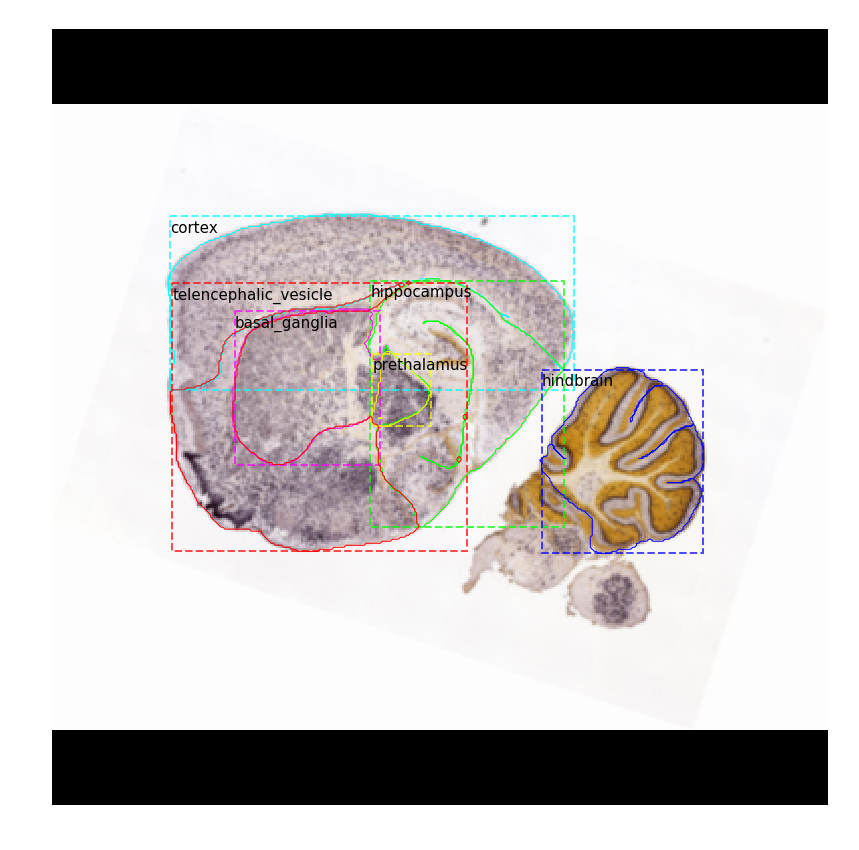

In [13]:
# Test on a random image
image_id = random.choice(dataset_val.image_ids)
original_image, image_meta, gt_class_id, gt_bbox, gt_mask =\
    modellib.load_image_gt(dataset_val, inference_config, 
                           image_id, use_mini_mask=False)

log("original_image", original_image)
log("image_meta", image_meta)
log("gt_class_id", gt_class_id)
log("gt_bbox", gt_bbox)
log("gt_mask", gt_mask)

visualize.display_instances (original_image, gt_bbox, gt_mask, gt_class_id, 
                    dataset_train.class_names, figsize=(15, 15))

Processing 1 images
image                    shape: (384, 384, 3)         min:    0.00000  max:  255.00000
molded_images            shape: (1, 384, 384, 3)      min: -123.70000  max:  151.10000
image_metas              shape: (1, 17)               min:    0.00000  max:  384.00000


<Figure size 1440x1440 with 0 Axes>

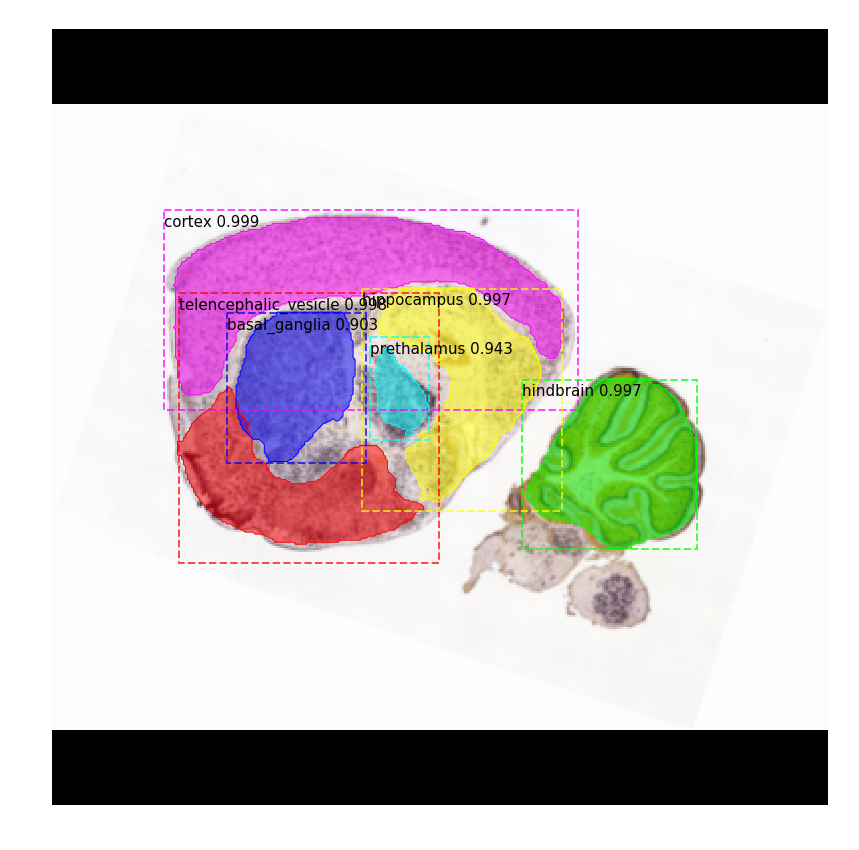

In [14]:
results = model.detect([original_image], verbose=1)
plt.figure(figsize=(20,20))

r = results[0]
visualize.display_instances(original_image, r['rois'], r['masks'], r['class_ids'], 
                            dataset_val.class_names, r['scores'], figsize=(15, 15))#ax=get_ax()

## Evaluation

In [15]:
# Compute VOC-Style mAP @ IoU=0.5
# Running on 10 images. Increase for better accuracy.

#image_ids = np.random.choice(dataset_val.image_ids, 10) 
APs = []
for image_id in range(0,199):#for image_id in image_ids:
    # Load image and ground truth data
    image, image_meta, gt_class_id, gt_bbox, gt_mask =\
        modellib.load_image_gt(dataset_val, inference_config,
                               image_id, use_mini_mask=False)
    molded_images = np.expand_dims(modellib.mold_image(image, inference_config), 0)
    # Run object detection
    results = model.detect([image], verbose=0)
    r = results[0]
    # Compute AP
    AP, precisions, recalls, overlaps =\
        utils.compute_ap(gt_bbox, gt_class_id, gt_mask,
                         r["rois"], r["class_ids"], r["scores"], r['masks'])
    APs.append(AP)
    
print("mAP: ", np.mean(APs))


0
section_masks_0
{'source': 'brain', 'height': 2512, 'path': 'D:\\Romesa_Work\\scene_parsing\\MaskRCNN_dataset\\dataset_6\\mrcnn_val_blurred_images_sigma_4/section_img_0.jpg', 'id': 0, 'width': 2780}
['section_masks_0_m_1.png', 'section_masks_0_m_2.png', 'section_masks_0_m_3.png', 'section_masks_0_m_7.png', 'section_masks_0_m_8.png']


C:\Users\Asfandyar\AppData\Roaming\Python\Python35\site-packages\scipy\ndimage\interpolation.py:616: UserWarning: From scipy 0.13.0, the output shape of zoom() is calculated with round() instead of int() - for these inputs the size of the returned array has changed.
  "the returned array has changed.", UserWarning)


1
section_masks_1
{'source': 'brain', 'height': 2457, 'path': 'D:\\Romesa_Work\\scene_parsing\\MaskRCNN_dataset\\dataset_6\\mrcnn_val_blurred_images_sigma_4/section_img_1.jpg', 'id': 1, 'width': 2745}
['section_masks_1_m_1.png', 'section_masks_1_m_2.png', 'section_masks_1_m_3.png', 'section_masks_1_m_7.png', 'section_masks_1_m_8.png']
2
section_masks_2
{'source': 'brain', 'height': 2400, 'path': 'D:\\Romesa_Work\\scene_parsing\\MaskRCNN_dataset\\dataset_6\\mrcnn_val_blurred_images_sigma_4/section_img_2.jpg', 'id': 2, 'width': 2707}
['section_masks_2_m_1.png', 'section_masks_2_m_2.png', 'section_masks_2_m_3.png', 'section_masks_2_m_7.png', 'section_masks_2_m_8.png']
3
section_masks_3
{'source': 'brain', 'height': 2339, 'path': 'D:\\Romesa_Work\\scene_parsing\\MaskRCNN_dataset\\dataset_6\\mrcnn_val_blurred_images_sigma_4/section_img_3.jpg', 'id': 3, 'width': 2665}
['section_masks_3_m_1.png', 'section_masks_3_m_2.png', 'section_masks_3_m_3.png', 'section_masks_3_m_7.png', 'section_masks_3

24
section_masks_24
{'source': 'brain', 'height': 2757, 'path': 'D:\\Romesa_Work\\scene_parsing\\MaskRCNN_dataset\\dataset_6\\mrcnn_val_blurred_images_sigma_4/section_img_24.jpg', 'id': 24, 'width': 3620}
['section_masks_24_m_1.png', 'section_masks_24_m_2.png', 'section_masks_24_m_3.png', 'section_masks_24_m_4.png', 'section_masks_24_m_5.png', 'section_masks_24_m_6.png', 'section_masks_24_m_7.png', 'section_masks_24_m_8.png']
25
section_masks_25
{'source': 'brain', 'height': 2660, 'path': 'D:\\Romesa_Work\\scene_parsing\\MaskRCNN_dataset\\dataset_6\\mrcnn_val_blurred_images_sigma_4/section_img_25.jpg', 'id': 25, 'width': 3569}
['section_masks_25_m_1.png', 'section_masks_25_m_2.png', 'section_masks_25_m_3.png', 'section_masks_25_m_4.png', 'section_masks_25_m_5.png', 'section_masks_25_m_6.png', 'section_masks_25_m_7.png', 'section_masks_25_m_8.png']
26
section_masks_26
{'source': 'brain', 'height': 2560, 'path': 'D:\\Romesa_Work\\scene_parsing\\MaskRCNN_dataset\\dataset_6\\mrcnn_val_blur

44
section_masks_44
{'source': 'brain', 'height': 3037, 'path': 'D:\\Romesa_Work\\scene_parsing\\MaskRCNN_dataset\\dataset_6\\mrcnn_val_blurred_images_sigma_4/section_img_44.jpg', 'id': 44, 'width': 4023}
['section_masks_44_m_1.png', 'section_masks_44_m_2.png', 'section_masks_44_m_4.png', 'section_masks_44_m_5.png', 'section_masks_44_m_6.png', 'section_masks_44_m_7.png', 'section_masks_44_m_8.png']
45
section_masks_45
{'source': 'brain', 'height': 2929, 'path': 'D:\\Romesa_Work\\scene_parsing\\MaskRCNN_dataset\\dataset_6\\mrcnn_val_blurred_images_sigma_4/section_img_45.jpg', 'id': 45, 'width': 3967}
['section_masks_45_m_1.png', 'section_masks_45_m_2.png', 'section_masks_45_m_4.png', 'section_masks_45_m_5.png', 'section_masks_45_m_6.png', 'section_masks_45_m_7.png', 'section_masks_45_m_8.png']
46
section_masks_46
{'source': 'brain', 'height': 2817, 'path': 'D:\\Romesa_Work\\scene_parsing\\MaskRCNN_dataset\\dataset_6\\mrcnn_val_blurred_images_sigma_4/section_img_46.jpg', 'id': 46, 'width

65
section_masks_65
{'source': 'brain', 'height': 2632, 'path': 'D:\\Romesa_Work\\scene_parsing\\MaskRCNN_dataset\\dataset_6\\mrcnn_val_blurred_images_sigma_4/section_img_65.jpg', 'id': 65, 'width': 3735}
['section_masks_65_m_1.png', 'section_masks_65_m_2.png', 'section_masks_65_m_4.png', 'section_masks_65_m_5.png', 'section_masks_65_m_6.png', 'section_masks_65_m_7.png', 'section_masks_65_m_8.png']
66
section_masks_66
{'source': 'brain', 'height': 2525, 'path': 'D:\\Romesa_Work\\scene_parsing\\MaskRCNN_dataset\\dataset_6\\mrcnn_val_blurred_images_sigma_4/section_img_66.jpg', 'id': 66, 'width': 3683}
['section_masks_66_m_1.png', 'section_masks_66_m_2.png', 'section_masks_66_m_4.png', 'section_masks_66_m_5.png', 'section_masks_66_m_6.png', 'section_masks_66_m_7.png', 'section_masks_66_m_8.png']
67
section_masks_67
{'source': 'brain', 'height': 2415, 'path': 'D:\\Romesa_Work\\scene_parsing\\MaskRCNN_dataset\\dataset_6\\mrcnn_val_blurred_images_sigma_4/section_img_67.jpg', 'id': 67, 'width

86
section_masks_86
{'source': 'brain', 'height': 2613, 'path': 'D:\\Romesa_Work\\scene_parsing\\MaskRCNN_dataset\\dataset_6\\mrcnn_val_blurred_images_sigma_4/section_img_86.jpg', 'id': 86, 'width': 3668}
['section_masks_86_m_1.png', 'section_masks_86_m_2.png', 'section_masks_86_m_4.png', 'section_masks_86_m_5.png', 'section_masks_86_m_6.png', 'section_masks_86_m_7.png', 'section_masks_86_m_8.png']
87
section_masks_87
{'source': 'brain', 'height': 2504, 'path': 'D:\\Romesa_Work\\scene_parsing\\MaskRCNN_dataset\\dataset_6\\mrcnn_val_blurred_images_sigma_4/section_img_87.jpg', 'id': 87, 'width': 3608}
['section_masks_87_m_1.png', 'section_masks_87_m_2.png', 'section_masks_87_m_4.png', 'section_masks_87_m_5.png', 'section_masks_87_m_6.png', 'section_masks_87_m_7.png', 'section_masks_87_m_8.png']
88
section_masks_88
{'source': 'brain', 'height': 2392, 'path': 'D:\\Romesa_Work\\scene_parsing\\MaskRCNN_dataset\\dataset_6\\mrcnn_val_blurred_images_sigma_4/section_img_88.jpg', 'id': 88, 'width

108
section_masks_108
{'source': 'brain', 'height': 2004, 'path': 'D:\\Romesa_Work\\scene_parsing\\MaskRCNN_dataset\\dataset_6\\mrcnn_val_blurred_images_sigma_4/section_img_108.jpg', 'id': 108, 'width': 2757}
['section_masks_108_m_1.png', 'section_masks_108_m_2.png', 'section_masks_108_m_3.png', 'section_masks_108_m_7.png', 'section_masks_108_m_8.png']
109
section_masks_109
{'source': 'brain', 'height': 1915, 'path': 'D:\\Romesa_Work\\scene_parsing\\MaskRCNN_dataset\\dataset_6\\mrcnn_val_blurred_images_sigma_4/section_img_109.jpg', 'id': 109, 'width': 2699}
['section_masks_109_m_1.png', 'section_masks_109_m_2.png', 'section_masks_109_m_3.png', 'section_masks_109_m_7.png', 'section_masks_109_m_8.png']
110
section_masks_110
{'source': 'brain', 'height': 1824, 'path': 'D:\\Romesa_Work\\scene_parsing\\MaskRCNN_dataset\\dataset_6\\mrcnn_val_blurred_images_sigma_4/section_img_110.jpg', 'id': 110, 'width': 2636}
['section_masks_110_m_1.png', 'section_masks_110_m_2.png', 'section_masks_110_m_3

131
section_masks_131
{'source': 'brain', 'height': 1971, 'path': 'D:\\Romesa_Work\\scene_parsing\\MaskRCNN_dataset\\dataset_6\\mrcnn_val_blurred_images_sigma_4/section_img_131.jpg', 'id': 131, 'width': 2928}
['section_masks_131_m_1.png', 'section_masks_131_m_2.png', 'section_masks_131_m_3.png', 'section_masks_131_m_5.png', 'section_masks_131_m_7.png', 'section_masks_131_m_8.png']
132
section_masks_132
{'source': 'brain', 'height': 2068, 'path': 'D:\\Romesa_Work\\scene_parsing\\MaskRCNN_dataset\\dataset_6\\mrcnn_val_blurred_images_sigma_4/section_img_132.jpg', 'id': 132, 'width': 2988}
['section_masks_132_m_1.png', 'section_masks_132_m_2.png', 'section_masks_132_m_3.png', 'section_masks_132_m_5.png', 'section_masks_132_m_7.png', 'section_masks_132_m_8.png']
133
section_masks_133
{'source': 'brain', 'height': 2162, 'path': 'D:\\Romesa_Work\\scene_parsing\\MaskRCNN_dataset\\dataset_6\\mrcnn_val_blurred_images_sigma_4/section_img_133.jpg', 'id': 133, 'width': 3044}
['section_masks_133_m_1

151
section_masks_151
{'source': 'brain', 'height': 2317, 'path': 'D:\\Romesa_Work\\scene_parsing\\MaskRCNN_dataset\\dataset_6\\mrcnn_val_blurred_images_sigma_4/section_img_151.jpg', 'id': 151, 'width': 3691}
['section_masks_151_m_1.png', 'section_masks_151_m_2.png', 'section_masks_151_m_3.png', 'section_masks_151_m_4.png', 'section_masks_151_m_5.png', 'section_masks_151_m_6.png', 'section_masks_151_m_7.png', 'section_masks_151_m_8.png']
152
section_masks_152
{'source': 'brain', 'height': 2439, 'path': 'D:\\Romesa_Work\\scene_parsing\\MaskRCNN_dataset\\dataset_6\\mrcnn_val_blurred_images_sigma_4/section_img_152.jpg', 'id': 152, 'width': 3761}
['section_masks_152_m_1.png', 'section_masks_152_m_2.png', 'section_masks_152_m_3.png', 'section_masks_152_m_4.png', 'section_masks_152_m_5.png', 'section_masks_152_m_6.png', 'section_masks_152_m_7.png', 'section_masks_152_m_8.png']
153
section_masks_153
{'source': 'brain', 'height': 2558, 'path': 'D:\\Romesa_Work\\scene_parsing\\MaskRCNN_dataset\

171
section_masks_171
{'source': 'brain', 'height': 2362, 'path': 'D:\\Romesa_Work\\scene_parsing\\MaskRCNN_dataset\\dataset_6\\mrcnn_val_blurred_images_sigma_4/section_img_171.jpg', 'id': 171, 'width': 3840}
['section_masks_171_m_1.png', 'section_masks_171_m_2.png', 'section_masks_171_m_4.png', 'section_masks_171_m_5.png', 'section_masks_171_m_6.png', 'section_masks_171_m_7.png', 'section_masks_171_m_8.png']
172
section_masks_172
{'source': 'brain', 'height': 2490, 'path': 'D:\\Romesa_Work\\scene_parsing\\MaskRCNN_dataset\\dataset_6\\mrcnn_val_blurred_images_sigma_4/section_img_172.jpg', 'id': 172, 'width': 3911}
['section_masks_172_m_1.png', 'section_masks_172_m_2.png', 'section_masks_172_m_4.png', 'section_masks_172_m_5.png', 'section_masks_172_m_6.png', 'section_masks_172_m_7.png', 'section_masks_172_m_8.png']
173
section_masks_173
{'source': 'brain', 'height': 2614, 'path': 'D:\\Romesa_Work\\scene_parsing\\MaskRCNN_dataset\\dataset_6\\mrcnn_val_blurred_images_sigma_4/section_img_1

191
section_masks_191
{'source': 'brain', 'height': 2399, 'path': 'D:\\Romesa_Work\\scene_parsing\\MaskRCNN_dataset\\dataset_6\\mrcnn_val_blurred_images_sigma_4/section_img_191.jpg', 'id': 191, 'width': 3853}
['section_masks_191_m_1.png', 'section_masks_191_m_2.png', 'section_masks_191_m_4.png', 'section_masks_191_m_5.png', 'section_masks_191_m_6.png', 'section_masks_191_m_7.png', 'section_masks_191_m_8.png']
192
section_masks_192
{'source': 'brain', 'height': 2526, 'path': 'D:\\Romesa_Work\\scene_parsing\\MaskRCNN_dataset\\dataset_6\\mrcnn_val_blurred_images_sigma_4/section_img_192.jpg', 'id': 192, 'width': 3925}
['section_masks_192_m_1.png', 'section_masks_192_m_2.png', 'section_masks_192_m_4.png', 'section_masks_192_m_5.png', 'section_masks_192_m_6.png', 'section_masks_192_m_7.png', 'section_masks_192_m_8.png']
193
section_masks_193
{'source': 'brain', 'height': 2651, 'path': 'D:\\Romesa_Work\\scene_parsing\\MaskRCNN_dataset\\dataset_6\\mrcnn_val_blurred_images_sigma_4/section_img_1

# plotting APs
# .
# .

In [19]:
np.mean(APs)

0.8430577694317832